In [8]:
from tqdm import tqdm
from array_lib import *
from point3d_lib import Point
from skeleton3d_lib import Skeleton
from IPython.display import display, clear_output
from skimage.morphology import skeletonize
from ply_creation_lib import create_ply, create_ply_normals
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import pydicom as dicom
import numpy as np
import shutil
import pickle
import ipympl
import time
import copy
import os

In [28]:
def read_dicom(input_folder: str) -> np.ndarray:
    files: list[str] = os.listdir(input_folder)
    data = [dicom.dcmread(f'{input_folder}\\{file}') for file in files if file.endswith('.dcm')]
    image = np.array([dicom.pixel_array(datum) for datum in data])
    return image

def fit_plane_first_last(skeleton: np.ndarray):
    middle_point = skeleton[len(skeleton)//2]
    first_point = skeleton[0]
    last_point = skeleton[-1]
    
    vector1 = first_point - middle_point
    vector2 = last_point - middle_point
    normal = np.cross(vector1, vector2)
    return normal / np.linalg.norm(normal)

def get_flow_vector(skeleton: np.ndarray):
    middle_point_id = len(skeleton)//2
    flow_vector = skeleton[middle_point_id+1] - skeleton[middle_point_id-1]
    return flow_vector / np.linalg.norm(flow_vector)

def project_vector(n: np.ndarray, v: np.ndarray):
    projected = v - (np.dot(v, n) / np.dot(n, n) * n)
    return projected / np.linalg.norm(projected)

def rotate_vector(f: np.ndarray, n: np.ndarray, degrees: float):
    rad_angle = np.radians(degrees)
    
    add1 = n * np.cos(rad_angle)
    add2 = np.cross(f, n) * np.sin(rad_angle)
    add3 = np.dot(f, n) * (1 - np.cos(rad_angle)) * f
    return add1 + add2 + add3

def draw_wireframe(ax, normal: np.ndarray):
    x = np.linspace(-100, 101, 3)
    y = np.linspace(-100, 101, 3)
    x, y = np.meshgrid(x, y)
    z = -(normal[0] * x + normal[1] * y) / normal[2]
    
    ax.plot_wireframe(x, y, z)
    
def draw_surface(ax, normal: np.ndarray):
    x = np.linspace(-200, 201, 2)
    y = np.linspace(-200, 201, 2)
    x, y = np.meshgrid(x, y)
    z = -(normal[0] * x + normal[1] * y) / normal[2]
    
    ax.plot_surface(x, y, z, color='0')
    
def normalize_image_colors(image: np.ndarray) -> np.ndarray:
    image = copy.deepcopy(image)
    min_val = np.min(image)
    max_val = np.max(image)
    image = (image - min_val) / (max_val - min_val) * 255
    return image
    
def project_point(plane: np.ndarray, point: np.ndarray):
    return point - np.dot(point, plane) * plane

def get_84_rca_data():
    input_folder = f'{os.getcwd()}\\20240923_84'
    skeleton = np.array([(166, 250, 221), (167, 250, 220), (168, 250, 219), (169, 250, 218), (170, 250, 217), (171, 250, 216), (172, 250, 215), (173, 250, 214), (172, 250, 213), (171, 249, 212), (170, 249, 211), (170, 249, 210), (170, 248, 209), (169, 247, 209), (168, 247, 208), (167, 246, 207), (167, 246, 206), (166, 245, 205), (165, 244, 204), (164, 244, 203), (163, 243, 202), (162, 243, 202), (161, 242, 201), (160, 242, 201), (159, 242, 200), (158, 241, 199), (157, 241, 198), (156, 240, 198), (155, 240, 197), (154, 240, 197), (153, 240, 196), (152, 240, 195), (151, 240, 195), (150, 240, 194), (149, 239, 194), (148, 239, 193), (147, 239, 193), (146, 238, 192), (145, 238, 191), (144, 238, 190), (143, 238, 189), (142, 237, 189), (141, 237, 188), (140, 236, 187), (139, 235, 186), (139, 235, 185), (138, 234, 184), (138, 234, 183), (137, 233, 182), (138, 233, 181), (138, 232, 180), (137, 231, 180), (137, 230, 179), (138, 230, 178), (138, 229, 177), (138, 228, 176), (138, 227, 175), (139, 226, 174), (139, 225, 173), (140, 224, 173), (141, 223, 172), (142, 223, 171), (143, 222, 171), (144, 222, 171), (145, 221, 170), (146, 220, 169), (147, 219, 168), (148, 219, 168), (149, 219, 168), (150, 218, 167), (151, 217, 166), (152, 216, 166), (153, 216, 166), (154, 215, 165), (155, 215, 165), (156, 215, 165), (157, 214, 164), (158, 213, 163), (159, 213, 163), (160, 212, 162), (161, 211, 162), (162, 211, 162), (163, 210, 161), (164, 211, 161), (165, 210, 160), (166, 210, 160), (167, 209, 159), (167, 208, 159), (168, 207, 158), (169, 207, 158), (170, 207, 158), (171, 206, 157), (172, 205, 156), (173, 204, 155), (174, 204, 155), (175, 203, 154), (176, 202, 154), (177, 201, 154), (178, 200, 153), (179, 200, 153), (180, 200, 153), (181, 200, 153), (182, 199, 152), (183, 199, 152), (184, 198, 151), (185, 197, 151), (186, 196, 150), (187, 196, 149), (188, 195, 149), (189, 194, 148), (190, 193, 147), (191, 193, 146), (192, 192, 146), (193, 191, 145), (194, 190, 144), (195, 189, 144), (196, 188, 143), (196, 188, 142), (197, 187, 141), (198, 187, 141), (199, 187, 140), (200, 186, 140), (201, 185, 139), (202, 185, 138), (203, 184, 138), (204, 184, 138), (205, 183, 137), (206, 183, 137), (207, 183, 137), (208, 183, 137), (209, 182, 137), (210, 182, 137), (211, 181, 136), (212, 181, 136), (213, 180, 135), (214, 180, 135), (215, 180, 135), (216, 180, 135), (217, 179, 134), (218, 179, 134), (219, 179, 134), (220, 179, 134), (221, 179, 134), (222, 179, 134), (223, 179, 134), (224, 179, 133), (225, 179, 134), (226, 179, 134), (227, 178, 133), (228, 178, 133), (229, 178, 134), (230, 178, 133), (231, 178, 134), (232, 179, 134), (233, 179, 134), (234, 179, 134), (235, 179, 134), (236, 180, 134), (237, 180, 133), (238, 180, 133), (239, 180, 134), (240, 180, 133), (241, 181, 134), (242, 181, 133), (243, 181, 133), (244, 181, 134), (245, 181, 133), (246, 182, 134), (247, 182, 134), (248, 183, 135), (249, 183, 135), (250, 184, 135), (251, 184, 136), (252, 184, 136), (253, 184, 136), (254, 184, 136), (255, 184, 136), (256, 185, 136), (257, 186, 137), (258, 186, 137), (259, 186, 137), (260, 186, 138), (261, 187, 139), (262, 187, 140), (263, 187, 140), (264, 187, 140), (265, 187, 140)])
    branch = np.array([(133, 231, 179), (133, 231, 180), (133, 232, 180), (134, 226, 175), (134, 226, 176), (134, 227, 174), (134, 227, 175), (134, 227, 176), (134, 227, 177), (134, 227, 178), (134, 228, 175), (134, 228, 176), (134, 228, 177), (134, 228, 178), (134, 228, 179), (134, 229, 176), (134, 229, 177), (134, 229, 178), (134, 229, 179), (134, 230, 177), (134, 230, 178), (134, 230, 179), (134, 230, 180), (134, 230, 181), (134, 231, 178), (134, 231, 179), (134, 231, 180), (134, 231, 181), (134, 231, 182), (134, 232, 179), (134, 232, 180), (134, 232, 181), (134, 232, 182), (134, 233, 180), (134, 233, 181), (135, 226, 173), (135, 226, 174), (135, 226, 175), (135, 226, 176), (135, 227, 173), (135, 227, 174), (135, 227, 175), (135, 227, 176), (135, 227, 177), (135, 227, 178), (135, 227, 179), (135, 228, 174), (135, 228, 175), (135, 228, 176), (135, 228, 177), (135, 228, 178), (135, 228, 179), (135, 228, 180), (135, 229, 175), (135, 229, 176), (135, 229, 177), (135, 229, 178), (135, 229, 179), (135, 229, 180), (135, 229, 181), (135, 230, 176), (135, 230, 177), (135, 230, 178), (135, 230, 179), (135, 230, 180), (135, 230, 181), (135, 230, 182), (135, 230, 183), (135, 231, 177), (135, 231, 178), (135, 231, 179), (135, 231, 180), (135, 231, 181), (135, 231, 182), (135, 231, 183), (135, 232, 178), (135, 232, 179), (135, 232, 180), (135, 232, 181), (135, 232, 182), (135, 232, 183), (135, 232, 184), (135, 232, 185), (135, 233, 179), (135, 233, 180), (135, 233, 181), (135, 233, 182), (135, 233, 183), (135, 233, 184), (135, 233, 185), (135, 233, 186), (135, 234, 181), (135, 234, 182), (135, 234, 183), (135, 234, 184), (135, 234, 185), (135, 234, 186), (135, 234, 187), (135, 235, 184), (135, 235, 185), (136, 225, 174), (136, 225, 175), (136, 225, 176), (136, 226, 173), (136, 226, 174), (136, 226, 175), (136, 226, 176), (136, 226, 177), (136, 227, 173), (136, 227, 174), (136, 227, 175), (136, 227, 176), (136, 227, 177), (136, 227, 178), (136, 227, 179), (136, 228, 174), (136, 228, 175), (136, 228, 176), (136, 228, 177), (136, 228, 178), (136, 228, 179), (136, 228, 180), (136, 228, 181), (136, 229, 174), (136, 229, 175), (136, 229, 176), (136, 229, 177), (136, 229, 178), (136, 229, 179), (136, 229, 180), (136, 229, 181), (136, 229, 182), (136, 230, 175), (136, 230, 176), (136, 230, 177), (136, 230, 178), (136, 230, 179), (136, 230, 180), (136, 230, 181), (136, 230, 182), (136, 230, 183), (136, 231, 176), (136, 231, 177), (136, 231, 178), (136, 231, 179), (136, 231, 180), (136, 231, 181), (136, 231, 182), (136, 231, 183), (136, 231, 184), (136, 232, 177), (136, 232, 178), (136, 232, 179), (136, 232, 180), (136, 232, 181), (136, 232, 182), (136, 232, 183), (136, 232, 184), (136, 232, 185), (136, 232, 186), (136, 233, 179), (136, 233, 180), (136, 233, 181), (136, 233, 182), (136, 233, 183), (136, 233, 184), (136, 233, 185), (136, 233, 186), (136, 233, 187), (136, 234, 180), (136, 234, 181), (136, 234, 182), (136, 234, 183), (136, 234, 184), (136, 234, 185), (136, 234, 186), (136, 234, 187), (136, 234, 188), (136, 235, 182), (136, 235, 183), (136, 235, 184), (136, 235, 185), (136, 235, 186), (136, 235, 187), (136, 235, 188), (136, 236, 183), (136, 236, 184), (136, 236, 185), (136, 236, 186), (136, 236, 187), (136, 237, 184), (136, 237, 185), (136, 237, 186), (136, 237, 187), (137, 224, 173), (137, 224, 174), (137, 224, 175), (137, 225, 173), (137, 225, 174), (137, 225, 175), (137, 225, 176), (137, 226, 173), (137, 226, 174), (137, 226, 175), (137, 226, 176), (137, 226, 177), (137, 226, 178), (137, 227, 173), (137, 227, 174), (137, 227, 175), (137, 227, 176), (137, 227, 177), (137, 227, 178), (137, 227, 179), (137, 228, 173), (137, 228, 174), (137, 228, 175), (137, 228, 176), (137, 228, 177), (137, 228, 178), (137, 228, 179), (137, 228, 180), (137, 228, 181), (137, 229, 174), (137, 229, 175), (137, 229, 176), (137, 229, 177), (137, 229, 178), (137, 229, 179), (137, 229, 180), (137, 229, 181), (137, 229, 182), (137, 230, 175), (137, 230, 176), (137, 230, 177), (137, 230, 178), (137, 230, 179), (137, 230, 180), (137, 230, 181), (137, 230, 182), (137, 230, 183), (137, 231, 176), (137, 231, 177), (137, 231, 178), (137, 231, 179), (137, 231, 180), (137, 231, 181), (137, 231, 182), (137, 231, 183), (137, 231, 184), (137, 232, 177), (137, 232, 178), (137, 232, 179), (137, 232, 180), (137, 232, 181), (137, 232, 182), (137, 232, 183), (137, 232, 184), (137, 232, 185), (137, 232, 186), (137, 233, 178), (137, 233, 179), (137, 233, 180), (137, 233, 181), (137, 233, 182), (137, 233, 183), (137, 233, 184), (137, 233, 185), (137, 233, 186), (137, 233, 187), (137, 233, 188), (137, 234, 180), (137, 234, 181), (137, 234, 182), (137, 234, 183), (137, 234, 184), (137, 234, 185), (137, 234, 186), (137, 234, 187), (137, 234, 188), (137, 235, 181), (137, 235, 182), (137, 235, 183), (137, 235, 184), (137, 235, 185), (137, 235, 186), (137, 235, 187), (137, 235, 188), (137, 235, 189), (137, 236, 182), (137, 236, 183), (137, 236, 184), (137, 236, 185), (137, 236, 186), (137, 236, 187), (137, 236, 188), (137, 236, 189), (137, 237, 184), (137, 237, 185), (137, 237, 186), (137, 237, 187), (137, 237, 188), (137, 237, 189), (138, 222, 172), (138, 222, 173), (138, 222, 174), (138, 223, 172), (138, 223, 173), (138, 223, 174), (138, 223, 175), (138, 224, 172), (138, 224, 173), (138, 224, 174), (138, 224, 175), (138, 224, 176), (138, 225, 172), (138, 225, 173), (138, 225, 174), (138, 225, 175), (138, 225, 176), (138, 225, 177), (138, 226, 172), (138, 226, 173), (138, 226, 174), (138, 226, 175), (138, 226, 176), (138, 226, 177), (138, 226, 178), (138, 227, 172), (138, 227, 173), (138, 227, 174), (138, 227, 175), (138, 227, 176), (138, 227, 177), (138, 227, 178), (138, 227, 179), (138, 228, 173), (138, 228, 174), (138, 228, 175), (138, 228, 176), (138, 228, 177), (138, 228, 178), (138, 228, 179), (138, 228, 180), (138, 229, 174), (138, 229, 175), (138, 229, 176), (138, 229, 177), (138, 229, 178), (138, 229, 179), (138, 229, 180), (138, 229, 181), (138, 230, 175), (138, 230, 176), (138, 230, 177), (138, 230, 178), (138, 230, 179), (138, 230, 180), (138, 230, 181), (138, 230, 182), (138, 231, 176), (138, 231, 177), (138, 231, 178), (138, 231, 179), (138, 231, 180), (138, 231, 181), (138, 231, 182), (138, 231, 183), (138, 231, 184), (138, 232, 177), (138, 232, 178), (138, 232, 179), (138, 232, 180), (138, 232, 181), (138, 232, 182), (138, 232, 183), (138, 232, 184), (138, 232, 185), (138, 232, 186), (138, 233, 179), (138, 233, 180), (138, 233, 181), (138, 233, 182), (138, 233, 183), (138, 233, 184), (138, 233, 185), (138, 233, 186), (138, 233, 187), (138, 233, 188), (138, 234, 180), (138, 234, 181), (138, 234, 182), (138, 234, 183), (138, 234, 184), (138, 234, 185), (138, 234, 186), (138, 234, 187), (138, 234, 188), (138, 235, 181), (138, 235, 182), (138, 235, 183), (138, 235, 184), (138, 235, 185), (138, 235, 186), (138, 235, 187), (138, 235, 188), (138, 235, 189), (138, 236, 182), (138, 236, 183), (138, 236, 184), (138, 236, 185), (138, 236, 186), (138, 236, 187), (138, 236, 188), (138, 236, 189), (138, 236, 190), (138, 236, 191), (138, 237, 184), (138, 237, 185), (138, 237, 186), (138, 237, 187), (138, 237, 188), (138, 237, 189), (138, 237, 190), (138, 238, 187), (138, 238, 188), (138, 238, 189), (139, 222, 170), (139, 222, 171), (139, 222, 172), (139, 222, 173), (139, 222, 174), (139, 223, 170), (139, 223, 171), (139, 223, 172), (139, 223, 173), (139, 223, 174), (139, 223, 175), (139, 224, 170), (139, 224, 171), (139, 224, 172), (139, 224, 173), (139, 224, 174), (139, 224, 175), (139, 225, 170), (139, 225, 171), (139, 225, 172), (139, 225, 173), (139, 225, 174), (139, 225, 175), (139, 225, 176), (139, 226, 171), (139, 226, 172), (139, 226, 173), (139, 226, 174), (139, 226, 175), (139, 226, 176), (139, 226, 177), (139, 227, 172), (139, 227, 173), (139, 227, 174), (139, 227, 175), (139, 227, 176), (139, 227, 177), (139, 227, 178), (139, 228, 173), (139, 228, 174), (139, 228, 175), (139, 228, 176), (139, 228, 177), (139, 228, 178), (139, 228, 179), (139, 228, 180), (139, 229, 174), (139, 229, 175), (139, 229, 176), (139, 229, 177), (139, 229, 178), (139, 229, 179), (139, 229, 180), (139, 230, 175), (139, 230, 176), (139, 230, 177), (139, 230, 178), (139, 230, 179), (139, 230, 180), (139, 230, 181), (139, 231, 176), (139, 231, 177), (139, 231, 178), (139, 231, 179), (139, 231, 180), (139, 231, 181), (139, 231, 182), (139, 231, 183), (139, 232, 178), (139, 232, 179), (139, 232, 180), (139, 232, 181), (139, 232, 182), (139, 232, 183), (139, 232, 184), (139, 232, 185), (139, 233, 179), (139, 233, 180), (139, 233, 181), (139, 233, 182), (139, 233, 183), (139, 233, 184), (139, 233, 185), (139, 233, 186), (139, 233, 187), (139, 234, 180), (139, 234, 181), (139, 234, 182), (139, 234, 183), (139, 234, 184), (139, 234, 185), (139, 234, 186), (139, 234, 187), (139, 234, 188), (139, 234, 189), (139, 235, 181), (139, 235, 182), (139, 235, 183), (139, 235, 184), (139, 235, 185), (139, 235, 186), (139, 235, 187), (139, 235, 188), (139, 235, 189), (139, 235, 190), (139, 236, 182), (139, 236, 183), (139, 236, 184), (139, 236, 185), (139, 236, 186), (139, 236, 187), (139, 236, 188), (139, 236, 189), (139, 236, 190), (139, 236, 191), (139, 237, 184), (139, 237, 185), (139, 237, 186), (139, 237, 187), (139, 237, 188), (139, 237, 189), (139, 237, 190), (139, 237, 191), (139, 238, 186), (139, 238, 187), (139, 238, 188), (139, 238, 189), (139, 238, 190), (139, 238, 191), (140, 221, 169), (140, 221, 170), (140, 221, 171), (140, 221, 172), (140, 221, 173), (140, 222, 169), (140, 222, 170), (140, 222, 171), (140, 222, 172), (140, 222, 173), (140, 222, 174), (140, 223, 169), (140, 223, 170), (140, 223, 171), (140, 223, 172), (140, 223, 173), (140, 223, 174), (140, 223, 175), (140, 224, 169), (140, 224, 170), (140, 224, 171), (140, 224, 172), (140, 224, 173), (140, 224, 174), (140, 224, 175), (140, 225, 170), (140, 225, 171), (140, 225, 172), (140, 225, 173), (140, 225, 174), (140, 225, 175), (140, 225, 176), (140, 226, 171), (140, 226, 172), (140, 226, 173), (140, 226, 174), (140, 226, 175), (140, 226, 176), (140, 226, 177), (140, 227, 172), (140, 227, 173), (140, 227, 174), (140, 227, 175), (140, 227, 176), (140, 227, 177), (140, 227, 178), (140, 228, 173), (140, 228, 174), (140, 228, 175), (140, 228, 176), (140, 228, 177), (140, 228, 178), (140, 228, 179), (140, 229, 174), (140, 229, 175), (140, 229, 176), (140, 229, 177), (140, 229, 178), (140, 229, 179), (140, 229, 180), (140, 230, 175), (140, 230, 176), (140, 230, 177), (140, 230, 178), (140, 230, 179), (140, 230, 180), (140, 230, 181), (140, 231, 176), (140, 231, 177), (140, 231, 178), (140, 231, 179), (140, 231, 180), (140, 231, 181), (140, 231, 182), (140, 232, 178), (140, 232, 179), (140, 232, 180), (140, 232, 181), (140, 232, 182), (140, 232, 183), (140, 232, 184), (140, 232, 185), (140, 233, 179), (140, 233, 180), (140, 233, 181), (140, 233, 182), (140, 233, 183), (140, 233, 184), (140, 233, 185), (140, 233, 186), (140, 233, 187), (140, 234, 180), (140, 234, 181), (140, 234, 182), (140, 234, 183), (140, 234, 184), (140, 234, 185), (140, 234, 186), (140, 234, 187), (140, 234, 188), (140, 234, 189), (140, 235, 181), (140, 235, 182), (140, 235, 183), (140, 235, 184), (140, 235, 185), (140, 235, 186), (140, 235, 187), (140, 235, 188), (140, 235, 189), (140, 235, 190), (140, 236, 182), (140, 236, 183), (140, 236, 184), (140, 236, 185), (140, 236, 186), (140, 236, 187), (140, 236, 188), (140, 236, 189), (140, 236, 190), (140, 236, 191), (140, 237, 184), (140, 237, 185), (140, 237, 186), (140, 237, 187), (140, 237, 188), (140, 237, 189), (140, 237, 190), (140, 237, 191), (140, 237, 192), (140, 238, 186), (140, 238, 187), (140, 238, 188), (140, 238, 189), (140, 238, 190), (140, 238, 191), (140, 238, 192), (141, 220, 168), (141, 220, 169), (141, 220, 170), (141, 220, 171), (141, 221, 168), (141, 221, 169), (141, 221, 170), (141, 221, 171), (141, 221, 172), (141, 221, 173), (141, 222, 169), (141, 222, 170), (141, 222, 171), (141, 222, 172), (141, 222, 173), (141, 222, 174), (141, 223, 169), (141, 223, 170), (141, 223, 171), (141, 223, 172), (141, 223, 173), (141, 223, 174), (141, 223, 175), (141, 224, 169), (141, 224, 170), (141, 224, 171), (141, 224, 172), (141, 224, 173), (141, 224, 174), (141, 224, 175), (141, 225, 170), (141, 225, 171), (141, 225, 172), (141, 225, 173), (141, 225, 174), (141, 225, 175), (141, 225, 176), (141, 226, 172), (141, 226, 173), (141, 226, 174), (141, 226, 175), (141, 226, 176), (141, 227, 174), (141, 227, 175), (141, 227, 176), (141, 227, 177), (141, 228, 176), (141, 228, 177), (141, 233, 185), (141, 233, 186), (141, 233, 187), (141, 234, 185), (141, 234, 186), (141, 234, 187), (141, 234, 188), (141, 234, 189), (141, 235, 181), (141, 235, 182), (141, 235, 183), (141, 235, 184), (141, 235, 185), (141, 235, 186), (141, 235, 187), (141, 235, 188), (141, 235, 189), (141, 235, 190), (141, 235, 191), (141, 236, 182), (141, 236, 183), (141, 236, 184), (141, 236, 185), (141, 236, 186), (141, 236, 187), (141, 236, 188), (141, 236, 189), (141, 236, 190), (141, 236, 191), (141, 236, 192), (141, 237, 185), (141, 237, 186), (141, 237, 187), (141, 237, 188), (141, 237, 189), (141, 237, 190), (141, 237, 191), (141, 237, 192), (141, 238, 186), (141, 238, 187), (141, 238, 188), (141, 238, 189), (141, 238, 190), (141, 238, 191), (141, 238, 192), (141, 239, 188), (141, 239, 189), (141, 239, 190), (141, 239, 191), (142, 219, 167), (142, 219, 168), (142, 219, 169), (142, 220, 167), (142, 220, 168), (142, 220, 169), (142, 220, 170), (142, 220, 171), (142, 220, 172), (142, 221, 168), (142, 221, 169), (142, 221, 170), (142, 221, 171), (142, 221, 172), (142, 221, 173), (142, 222, 168), (142, 222, 169), (142, 222, 170), (142, 222, 171), (142, 222, 172), (142, 222, 173), (142, 222, 174), (142, 223, 169), (142, 223, 170), (142, 223, 171), (142, 223, 172), (142, 223, 173), (142, 223, 174), (142, 223, 175), (142, 224, 169), (142, 224, 170), (142, 224, 171), (142, 224, 172), (142, 224, 173), (142, 224, 174), (142, 224, 175), (142, 225, 172), (142, 225, 173), (142, 225, 174), (142, 225, 175), (142, 226, 174), (142, 226, 175), (142, 226, 176), (142, 234, 186), (142, 234, 187), (142, 234, 188), (142, 235, 185), (142, 235, 186), (142, 235, 187), (142, 235, 188), (142, 235, 189), (142, 235, 190), (142, 235, 191), (142, 236, 183), (142, 236, 184), (142, 236, 185), (142, 236, 186), (142, 236, 187), (142, 236, 188), (142, 236, 189), (142, 236, 190), (142, 236, 191), (142, 236, 192), (142, 237, 185), (142, 237, 186), (142, 237, 187), (142, 237, 188), (142, 237, 189), (142, 237, 190), (142, 237, 191), (142, 237, 192), (142, 238, 186), (142, 238, 187), (142, 238, 188), (142, 238, 189), (142, 238, 190), (142, 238, 191), (142, 238, 192), (142, 238, 193), (142, 239, 188), (142, 239, 189), (142, 239, 190), (142, 239, 191), (142, 239, 192), (143, 218, 167), (143, 218, 168), (143, 219, 167), (143, 219, 168), (143, 219, 169), (143, 219, 170), (143, 219, 171), (143, 220, 167), (143, 220, 168), (143, 220, 169), (143, 220, 170), (143, 220, 171), (143, 220, 172), (143, 221, 168), (143, 221, 169), (143, 221, 170), (143, 221, 171), (143, 221, 172), (143, 221, 173), (143, 222, 168), (143, 222, 169), (143, 222, 170), (143, 222, 171), (143, 222, 172), (143, 222, 173), (143, 222, 174), (143, 223, 169), (143, 223, 170), (143, 223, 171), (143, 223, 172), (143, 223, 173), (143, 223, 174), (143, 224, 169), (143, 224, 170), (143, 224, 171), (143, 224, 172), (143, 224, 173), (143, 224, 174), (143, 225, 173), (143, 225, 174), (143, 225, 175), (143, 234, 186), (143, 234, 187), (143, 235, 185), (143, 235, 186), (143, 235, 187), (143, 235, 188), (143, 235, 189), (143, 235, 190), (143, 235, 191), (143, 236, 184), (143, 236, 185), (143, 236, 186), (143, 236, 187), (143, 236, 188), (143, 236, 189), (143, 236, 190), (143, 236, 191), (143, 236, 192), (143, 237, 185), (143, 237, 186), (143, 237, 187), (143, 237, 188), (143, 237, 189), (143, 237, 190), (143, 237, 191), (143, 237, 192), (143, 237, 193), (143, 238, 187), (143, 238, 188), (143, 238, 189), (143, 238, 190), (143, 238, 191), (143, 238, 192), (143, 238, 193), (143, 239, 188), (143, 239, 189), (143, 239, 190), (143, 239, 191), (143, 239, 192), (143, 239, 193), (143, 240, 191), (143, 240, 192), (144, 218, 166), (144, 218, 167), (144, 218, 168), (144, 218, 169), (144, 218, 170), (144, 219, 166), (144, 219, 167), (144, 219, 168), (144, 219, 169), (144, 219, 170), (144, 219, 171), (144, 220, 167), (144, 220, 168), (144, 220, 169), (144, 220, 170), (144, 220, 171), (144, 220, 172), (144, 221, 167), (144, 221, 168), (144, 221, 169), (144, 221, 170), (144, 221, 171), (144, 221, 172), (144, 221, 173), (144, 222, 168), (144, 222, 169), (144, 222, 170), (144, 222, 171), (144, 222, 172), (144, 222, 173), (144, 222, 174), (144, 223, 169), (144, 223, 170), (144, 223, 171), (144, 223, 172), (144, 223, 173), (144, 223, 174), (144, 224, 170), (144, 224, 171), (144, 224, 172), (144, 224, 173), (144, 224, 174), (144, 235, 186), (144, 235, 187), (144, 235, 191), (144, 236, 185), (144, 236, 186), (144, 236, 187), (144, 236, 188), (144, 236, 189), (144, 236, 190), (144, 236, 191), (144, 236, 192), (144, 236, 193), (144, 237, 186), (144, 237, 187), (144, 237, 188), (144, 237, 189), (144, 237, 190), (144, 237, 191), (144, 237, 192), (144, 237, 193), (144, 238, 187), (144, 238, 188), (144, 238, 189), (144, 238, 190), (144, 238, 191), (144, 238, 192), (144, 238, 193), (144, 238, 194), (144, 239, 188), (144, 239, 189), (144, 239, 190), (144, 239, 191), (144, 239, 192), (144, 239, 193), (144, 239, 194), (144, 240, 191), (144, 240, 192), (144, 240, 193), (145, 217, 166), (145, 217, 167), (145, 217, 168), (145, 217, 169), (145, 217, 170), (145, 218, 166), (145, 218, 167), (145, 218, 168), (145, 218, 169), (145, 218, 170), (145, 219, 166), (145, 219, 167), (145, 219, 168), (145, 219, 169), (145, 219, 170), (145, 219, 171), (145, 220, 166), (145, 220, 167), (145, 220, 168), (145, 220, 169), (145, 220, 170), (145, 220, 171), (145, 220, 172), (145, 221, 167), (145, 221, 168), (145, 221, 169), (145, 221, 170), (145, 221, 171), (145, 221, 172), (145, 221, 173), (145, 222, 168), (145, 222, 169), (145, 222, 170), (145, 222, 171), (145, 222, 172), (145, 222, 173), (145, 223, 169), (145, 223, 170), (145, 223, 171), (145, 223, 172), (145, 223, 173), (145, 224, 171), (145, 224, 172), (145, 224, 173), (145, 236, 186), (145, 236, 187), (145, 236, 188), (145, 236, 189), (145, 236, 190), (145, 236, 191), (145, 236, 192), (145, 236, 193), (145, 237, 187), (145, 237, 188), (145, 237, 189), (145, 237, 190), (145, 237, 191), (145, 237, 192), (145, 237, 193), (145, 237, 194), (145, 238, 187), (145, 238, 188), (145, 238, 189), (145, 238, 190), (145, 238, 191), (145, 238, 192), (145, 238, 193), (145, 238, 194), (145, 239, 189), (145, 239, 190), (145, 239, 191), (145, 239, 192), (145, 239, 193), (145, 239, 194), (145, 240, 191), (145, 240, 192), (145, 240, 193), (145, 240, 194), (146, 217, 166), (146, 217, 167), (146, 217, 168), (146, 217, 169), (146, 217, 170), (146, 218, 165), (146, 218, 166), (146, 218, 167), (146, 218, 168), (146, 218, 169), (146, 218, 170), (146, 219, 166), (146, 219, 167), (146, 219, 168), (146, 219, 169), (146, 219, 170), (146, 219, 171), (146, 220, 166), (146, 220, 167), (146, 220, 168), (146, 220, 169), (146, 220, 170), (146, 220, 171), (146, 220, 172), (146, 221, 167), (146, 221, 168), (146, 221, 169), (146, 221, 170), (146, 221, 171), (146, 221, 172), (146, 222, 168), (146, 222, 169), (146, 222, 170), (146, 222, 171), (146, 222, 172), (146, 223, 170), (146, 223, 171), (146, 223, 172), (146, 236, 188), (146, 236, 189), (146, 236, 190), (146, 236, 191), (146, 236, 192), (146, 236, 193), (146, 237, 187), (146, 237, 188), (146, 237, 189), (146, 237, 190), (146, 237, 191), (146, 237, 192), (146, 237, 193), (146, 237, 194), (146, 238, 188), (146, 238, 189), (146, 238, 190), (146, 238, 191), (146, 238, 192), (146, 238, 193), (146, 238, 194), (146, 239, 189), (146, 239, 190), (146, 239, 191), (146, 239, 192), (146, 239, 193), (146, 239, 194), (146, 240, 191), (146, 240, 192), (146, 240, 193), (146, 240, 194), (147, 216, 166), (147, 216, 167), (147, 216, 168), (147, 217, 165), (147, 217, 166), (147, 217, 167), (147, 217, 168), (147, 217, 169), (147, 217, 170), (147, 218, 165), (147, 218, 166), (147, 218, 167), (147, 218, 168), (147, 218, 169), (147, 218, 170), (147, 219, 165), (147, 219, 166), (147, 219, 167), (147, 219, 168), (147, 219, 169), (147, 219, 170), (147, 219, 171), (147, 220, 166), (147, 220, 167), (147, 220, 168), (147, 220, 169), (147, 220, 170), (147, 220, 171), (147, 221, 166), (147, 221, 167), (147, 221, 168), (147, 221, 169), (147, 221, 170), (147, 221, 171), (147, 221, 172), (147, 222, 168), (147, 222, 169), (147, 222, 170), (147, 222, 171), (147, 222, 172), (147, 236, 189), (147, 236, 190), (147, 236, 191), (147, 236, 192), (147, 236, 193), (147, 237, 188), (147, 237, 189), (147, 237, 190), (147, 237, 191), (147, 237, 192), (147, 237, 193), (147, 237, 194), (147, 238, 188), (147, 238, 189), (147, 238, 190), (147, 238, 191), (147, 238, 192), (147, 238, 193), (147, 238, 194), (147, 238, 195), (147, 239, 189), (147, 239, 190), (147, 239, 191), (147, 239, 192), (147, 239, 193), (147, 239, 194), (147, 239, 195), (147, 240, 191), (147, 240, 192), (147, 240, 193), (147, 240, 194), (147, 240, 195), (148, 216, 165), (148, 216, 166), (148, 216, 167), (148, 216, 168), (148, 217, 165), (148, 217, 166), (148, 217, 167), (148, 217, 168), (148, 217, 169), (148, 218, 165), (148, 218, 166), (148, 218, 167), (148, 218, 168), (148, 218, 169), (148, 218, 170), (148, 219, 165), (148, 219, 166), (148, 219, 167), (148, 219, 168), (148, 219, 169), (148, 219, 170), (148, 220, 166), (148, 220, 167), (148, 220, 168), (148, 220, 169), (148, 220, 170), (148, 220, 171), (148, 221, 167), (148, 221, 168), (148, 221, 169), (148, 221, 170), (148, 221, 171), (148, 236, 191), (148, 236, 192), (148, 237, 189), (148, 237, 190), (148, 237, 191), (148, 237, 192), (148, 237, 193), (148, 237, 194), (148, 238, 189), (148, 238, 190), (148, 238, 191), (148, 238, 192), (148, 238, 193), (148, 238, 194), (148, 238, 195), (148, 238, 196), (148, 239, 189), (148, 239, 190), (148, 239, 191), (148, 239, 192), (148, 239, 193), (148, 239, 194), (148, 239, 195), (148, 239, 196), (148, 240, 190), (148, 240, 191), (148, 240, 192), (148, 240, 193), (148, 240, 194), (148, 240, 195), (148, 240, 196), (148, 241, 194), (149, 215, 165), (149, 215, 166), (149, 215, 167), (149, 216, 165), (149, 216, 166), (149, 216, 167), (149, 216, 168), (149, 216, 169), (149, 217, 165), (149, 217, 166), (149, 217, 167), (149, 217, 168), (149, 217, 169), (149, 218, 165), (149, 218, 166), (149, 218, 167), (149, 218, 168), (149, 218, 169), (149, 218, 170), (149, 219, 165), (149, 219, 166), (149, 219, 167), (149, 219, 168), (149, 219, 169), (149, 219, 170), (149, 220, 166), (149, 220, 167), (149, 220, 168), (149, 220, 169), (149, 220, 170), (149, 220, 171), (149, 221, 167), (149, 221, 168), (149, 221, 169), (149, 221, 170), (149, 237, 191), (149, 237, 192), (149, 237, 193), (149, 237, 194), (149, 238, 190), (149, 238, 191), (149, 238, 192), (149, 238, 193), (149, 238, 194), (149, 238, 195), (149, 238, 196), (149, 238, 197), (149, 239, 190), (149, 239, 191), (149, 239, 192), (149, 239, 193), (149, 239, 194), (149, 239, 195), (149, 239, 196), (149, 239, 197), (149, 240, 190), (149, 240, 191), (149, 240, 192), (149, 240, 193), (149, 240, 194), (149, 240, 195), (149, 240, 196), (149, 240, 197), (149, 241, 193), (149, 241, 194), (149, 241, 195), (149, 241, 196), (150, 214, 165), (150, 214, 166), (150, 214, 167), (150, 215, 164), (150, 215, 165), (150, 215, 166), (150, 215, 167), (150, 215, 168), (150, 216, 164), (150, 216, 165), (150, 216, 166), (150, 216, 167), (150, 216, 168), (150, 216, 169), (150, 217, 164), (150, 217, 165), (150, 217, 166), (150, 217, 167), (150, 217, 168), (150, 217, 169), (150, 218, 165), (150, 218, 166), (150, 218, 167), (150, 218, 168), (150, 218, 169), (150, 218, 170), (150, 219, 165), (150, 219, 166), (150, 219, 167), (150, 219, 168), (150, 219, 169), (150, 219, 170), (150, 220, 166), (150, 220, 167), (150, 220, 168), (150, 220, 169), (150, 220, 170), (150, 221, 167), (150, 221, 168), (150, 221, 169), (150, 237, 193), (150, 237, 194), (150, 237, 195), (150, 238, 191), (150, 238, 192), (150, 238, 193), (150, 238, 194), (150, 238, 195), (150, 238, 196), (150, 238, 197), (150, 239, 190), (150, 239, 191), (150, 239, 192), (150, 239, 193), (150, 239, 194), (150, 239, 195), (150, 239, 196), (150, 239, 197), (150, 239, 198), (150, 240, 191), (150, 240, 192), (150, 240, 193), (150, 240, 194), (150, 240, 195), (150, 240, 196), (150, 240, 197), (150, 240, 198), (150, 241, 193), (150, 241, 194), (150, 241, 195), (150, 241, 196), (150, 241, 197), (151, 213, 166), (151, 214, 164), (151, 214, 165), (151, 214, 166), (151, 214, 167), (151, 215, 163), (151, 215, 164), (151, 215, 165), (151, 215, 166), (151, 215, 167), (151, 215, 168), (151, 216, 163), (151, 216, 164), (151, 216, 165), (151, 216, 166), (151, 216, 167), (151, 216, 168), (151, 216, 169), (151, 217, 164), (151, 217, 165), (151, 217, 166), (151, 217, 167), (151, 217, 168), (151, 217, 169), (151, 218, 164), (151, 218, 165), (151, 218, 166), (151, 218, 167), (151, 218, 168), (151, 218, 169), (151, 218, 170), (151, 219, 165), (151, 219, 166), (151, 219, 167), (151, 219, 168), (151, 219, 169), (151, 219, 170), (151, 220, 167), (151, 220, 168), (151, 237, 194), (151, 237, 195), (151, 238, 191), (151, 238, 192), (151, 238, 193), (151, 238, 194), (151, 238, 195), (151, 238, 196), (151, 238, 197), (151, 239, 191), (151, 239, 192), (151, 239, 193), (151, 239, 194), (151, 239, 195), (151, 239, 196), (151, 239, 197), (151, 239, 198), (151, 240, 191), (151, 240, 192), (151, 240, 193), (151, 240, 194), (151, 240, 195), (151, 240, 196), (151, 240, 197), (151, 240, 198), (151, 241, 193), (151, 241, 194), (151, 241, 195), (151, 241, 196), (151, 241, 197), (151, 241, 198), (152, 213, 164), (152, 213, 165), (152, 213, 166), (152, 214, 163), (152, 214, 164), (152, 214, 165), (152, 214, 166), (152, 214, 167), (152, 215, 163), (152, 215, 164), (152, 215, 165), (152, 215, 166), (152, 215, 167), (152, 216, 163), (152, 216, 164), (152, 216, 165), (152, 216, 166), (152, 216, 167), (152, 216, 168), (152, 217, 164), (152, 217, 165), (152, 217, 166), (152, 217, 167), (152, 217, 168), (152, 217, 169), (152, 218, 164), (152, 218, 165), (152, 218, 166), (152, 218, 167), (152, 218, 168), (152, 218, 169), (152, 219, 165), (152, 219, 166), (152, 219, 167), (152, 219, 168), (152, 237, 195), (152, 238, 192), (152, 238, 193), (152, 238, 194), (152, 238, 195), (152, 238, 196), (152, 238, 197), (152, 239, 192), (152, 239, 193), (152, 239, 194), (152, 239, 195), (152, 239, 196), (152, 239, 197), (152, 239, 198), (152, 239, 199), (152, 240, 192), (152, 240, 193), (152, 240, 194), (152, 240, 195), (152, 240, 196), (152, 240, 197), (152, 240, 198), (152, 240, 199), (152, 241, 193), (152, 241, 194), (152, 241, 195), (152, 241, 196), (152, 241, 197), (152, 241, 198), (153, 212, 164), (153, 212, 165), (153, 212, 166), (153, 213, 163), (153, 213, 164), (153, 213, 165), (153, 213, 166), (153, 214, 163), (153, 214, 164), (153, 214, 165), (153, 214, 166), (153, 214, 167), (153, 215, 163), (153, 215, 164), (153, 215, 165), (153, 215, 166), (153, 215, 167), (153, 216, 163), (153, 216, 164), (153, 216, 165), (153, 216, 166), (153, 216, 167), (153, 216, 168), (153, 217, 164), (153, 217, 165), (153, 217, 166), (153, 217, 167), (153, 217, 168), (153, 218, 165), (153, 218, 166), (153, 218, 167), (153, 218, 168), (153, 219, 165), (153, 219, 166), (153, 238, 193), (153, 238, 194), (153, 238, 195), (153, 238, 196), (153, 238, 197), (153, 239, 193), (153, 239, 194), (153, 239, 195), (153, 239, 196), (153, 239, 197), (153, 239, 198), (153, 239, 199), (153, 240, 193), (153, 240, 194), (153, 240, 195), (153, 240, 196), (153, 240, 197), (153, 240, 198), (153, 240, 199), (153, 240, 200), (153, 241, 193), (153, 241, 194), (153, 241, 195), (153, 241, 196), (153, 241, 197), (153, 241, 198), (153, 241, 199), (154, 211, 164), (154, 212, 163), (154, 212, 164), (154, 212, 165), (154, 212, 166), (154, 213, 163), (154, 213, 164), (154, 213, 165), (154, 213, 166), (154, 214, 163), (154, 214, 164), (154, 214, 165), (154, 214, 166), (154, 214, 167), (154, 215, 163), (154, 215, 164), (154, 215, 165), (154, 215, 166), (154, 215, 167), (154, 216, 163), (154, 216, 164), (154, 216, 165), (154, 216, 166), (154, 216, 167), (154, 217, 164), (154, 217, 165), (154, 217, 166), (154, 217, 167), (154, 218, 165), (154, 218, 166), (154, 218, 167), (154, 219, 166), (154, 238, 194), (154, 238, 195), (154, 238, 196), (154, 238, 197), (154, 239, 194), (154, 239, 195), (154, 239, 196), (154, 239, 197), (154, 239, 198), (154, 239, 199), (154, 239, 200), (154, 240, 194), (154, 240, 195), (154, 240, 196), (154, 240, 197), (154, 240, 198), (154, 240, 199), (154, 240, 200), (154, 240, 201), (154, 241, 194), (154, 241, 195), (154, 241, 196), (154, 241, 197), (154, 241, 198), (154, 241, 199), (155, 211, 163), (155, 211, 164), (155, 212, 163), (155, 212, 164), (155, 212, 165), (155, 212, 166), (155, 213, 162), (155, 213, 163), (155, 213, 164), (155, 213, 165), (155, 213, 166), (155, 214, 162), (155, 214, 163), (155, 214, 164), (155, 214, 165), (155, 214, 166), (155, 214, 167), (155, 215, 163), (155, 215, 164), (155, 215, 165), (155, 215, 166), (155, 215, 167), (155, 216, 163), (155, 216, 164), (155, 216, 165), (155, 216, 166), (155, 216, 167), (155, 217, 164), (155, 217, 165), (155, 217, 166), (155, 217, 167), (155, 218, 165), (155, 218, 166), (155, 219, 166), (155, 238, 195), (155, 238, 196), (155, 238, 197), (155, 238, 198), (155, 239, 194), (155, 239, 195), (155, 239, 196), (155, 239, 197), (155, 239, 198), (155, 239, 199), (155, 239, 200), (155, 239, 201), (155, 240, 194), (155, 240, 195), (155, 240, 196), (155, 240, 197), (155, 240, 198), (155, 240, 199), (155, 240, 200), (155, 240, 201), (155, 241, 194), (155, 241, 195), (155, 241, 196), (155, 241, 197), (155, 241, 198), (155, 241, 199), (155, 241, 200), (155, 242, 196), (156, 211, 162), (156, 211, 163), (156, 211, 164), (156, 212, 162), (156, 212, 163), (156, 212, 164), (156, 212, 165), (156, 212, 166), (156, 213, 162), (156, 213, 163), (156, 213, 164), (156, 213, 165), (156, 213, 166), (156, 214, 162), (156, 214, 163), (156, 214, 164), (156, 214, 165), (156, 214, 166), (156, 215, 163), (156, 215, 164), (156, 215, 165), (156, 215, 166), (156, 216, 164), (156, 216, 165), (156, 216, 166), (156, 217, 164), (156, 217, 165), (156, 217, 166), (156, 218, 165), (156, 218, 166), (156, 238, 195), (156, 238, 196), (156, 238, 197), (156, 238, 198), (156, 239, 195), (156, 239, 196), (156, 239, 197), (156, 239, 198), (156, 239, 199), (156, 239, 200), (156, 239, 201), (156, 240, 194), (156, 240, 195), (156, 240, 196), (156, 240, 197), (156, 240, 198), (156, 240, 199), (156, 240, 200), (156, 240, 201), (156, 240, 202), (156, 241, 195), (156, 241, 196), (156, 241, 197), (156, 241, 198), (156, 241, 199), (156, 241, 200), (156, 241, 201), (156, 242, 196), (156, 242, 197), (156, 242, 198), (156, 242, 199), (156, 242, 200), (157, 210, 162), (157, 210, 163), (157, 211, 161), (157, 211, 162), (157, 211, 163), (157, 211, 164), (157, 212, 161), (157, 212, 162), (157, 212, 163), (157, 212, 164), (157, 212, 165), (157, 213, 162), (157, 213, 163), (157, 213, 164), (157, 213, 165), (157, 213, 166), (157, 214, 162), (157, 214, 163), (157, 214, 164), (157, 214, 165), (157, 214, 166), (157, 215, 163), (157, 215, 164), (157, 215, 165), (157, 215, 166), (157, 216, 164), (157, 216, 165), (157, 216, 166), (157, 217, 165), (157, 217, 166), (157, 238, 196), (157, 239, 195), (157, 239, 196), (157, 239, 197), (157, 239, 198), (157, 239, 199), (157, 239, 200), (157, 240, 195), (157, 240, 196), (157, 240, 197), (157, 240, 198), (157, 240, 199), (157, 240, 200), (157, 240, 201), (157, 240, 202), (157, 241, 195), (157, 241, 196), (157, 241, 197), (157, 241, 198), (157, 241, 199), (157, 241, 200), (157, 241, 201), (157, 241, 202), (157, 242, 196), (157, 242, 197), (157, 242, 198), (157, 242, 199), (157, 242, 200), (157, 242, 201), (157, 243, 199), (157, 243, 200), (158, 209, 161), (158, 210, 161), (158, 210, 162), (158, 210, 163), (158, 211, 161), (158, 211, 162), (158, 211, 163), (158, 211, 164), (158, 212, 161), (158, 212, 162), (158, 212, 163), (158, 212, 164), (158, 212, 165), (158, 213, 161), (158, 213, 162), (158, 213, 163), (158, 213, 164), (158, 213, 165), (158, 214, 162), (158, 214, 163), (158, 214, 164), (158, 214, 165), (158, 214, 166), (158, 215, 162), (158, 215, 163), (158, 215, 164), (158, 215, 165), (158, 215, 166), (158, 216, 164), (158, 216, 165), (158, 216, 166), (158, 239, 196), (158, 239, 197), (158, 239, 198), (158, 239, 199), (158, 239, 200), (158, 240, 196), (158, 240, 197), (158, 240, 198), (158, 240, 199), (158, 240, 200), (158, 240, 201), (158, 240, 202), (158, 241, 196), (158, 241, 197), (158, 241, 198), (158, 241, 199), (158, 241, 200), (158, 241, 201), (158, 241, 202), (158, 242, 196), (158, 242, 197), (158, 242, 198), (158, 242, 199), (158, 242, 200), (158, 242, 201), (158, 242, 202), (158, 243, 198), (158, 243, 199), (158, 243, 200), (158, 243, 201), (158, 243, 202), (158, 244, 200), (158, 244, 201), (159, 209, 161), (159, 209, 162), (159, 210, 161), (159, 210, 162), (159, 210, 163), (159, 211, 161), (159, 211, 162), (159, 211, 163), (159, 211, 164), (159, 212, 161), (159, 212, 162), (159, 212, 163), (159, 212, 164), (159, 213, 161), (159, 213, 162), (159, 213, 163), (159, 213, 164), (159, 213, 165), (159, 214, 162), (159, 214, 163), (159, 214, 164), (159, 214, 165), (159, 215, 162), (159, 215, 163), (159, 215, 164), (159, 239, 197), (159, 239, 198), (159, 240, 196), (159, 240, 197), (159, 240, 198), (159, 240, 199), (159, 240, 200), (159, 240, 201), (159, 240, 202), (159, 241, 196), (159, 241, 197), (159, 241, 198), (159, 241, 199), (159, 241, 200), (159, 241, 201), (159, 241, 202), (159, 242, 196), (159, 242, 197), (159, 242, 198), (159, 242, 199), (159, 242, 200), (159, 242, 201), (159, 242, 202), (159, 243, 198), (159, 243, 199), (159, 243, 200), (159, 243, 201), (159, 243, 202), (159, 244, 200), (159, 244, 201), (159, 244, 202), (160, 208, 160), (160, 208, 161), (160, 208, 162), (160, 209, 160), (160, 209, 161), (160, 209, 162), (160, 209, 163), (160, 210, 161), (160, 210, 162), (160, 210, 163), (160, 210, 164), (160, 211, 161), (160, 211, 162), (160, 211, 163), (160, 211, 164), (160, 212, 161), (160, 212, 162), (160, 212, 163), (160, 212, 164), (160, 213, 161), (160, 213, 162), (160, 213, 163), (160, 213, 164), (160, 214, 162), (160, 214, 163), (160, 214, 164), (160, 240, 197), (160, 240, 198), (160, 240, 199), (160, 240, 200), (160, 240, 201), (160, 240, 202), (160, 241, 197), (160, 241, 198), (160, 241, 199), (160, 241, 200), (160, 241, 201), (160, 241, 202), (160, 241, 203), (160, 242, 197), (160, 242, 198), (160, 242, 199), (160, 242, 200), (160, 242, 201), (160, 242, 202), (160, 242, 203), (160, 243, 198), (160, 243, 199), (160, 243, 200), (160, 243, 201), (160, 243, 202), (160, 243, 203), (160, 244, 200), (160, 244, 201), (160, 244, 202), (160, 244, 203), (161, 208, 160), (161, 208, 161), (161, 208, 162), (161, 209, 160), (161, 209, 161), (161, 209, 162), (161, 209, 163), (161, 210, 160), (161, 210, 161), (161, 210, 162), (161, 210, 163), (161, 210, 164), (161, 211, 160), (161, 211, 161), (161, 211, 162), (161, 211, 163), (161, 211, 164), (161, 212, 161), (161, 212, 162), (161, 212, 163), (161, 212, 164), (161, 213, 161), (161, 213, 162), (161, 213, 163), (161, 213, 164), (161, 214, 162), (161, 214, 163), (161, 240, 199), (161, 240, 200), (161, 240, 201), (161, 240, 202), (161, 241, 198), (161, 241, 199), (161, 241, 200), (161, 241, 201), (161, 241, 202), (161, 241, 203), (161, 242, 198), (161, 242, 199), (161, 242, 200), (161, 242, 201), (161, 242, 202), (161, 242, 203), (161, 242, 204), (161, 243, 198), (161, 243, 199), (161, 243, 200), (161, 243, 201), (161, 243, 202), (161, 243, 203), (161, 243, 204), (161, 244, 200), (161, 244, 201), (161, 244, 202), (161, 244, 203), (161, 244, 204), (161, 244, 205), (162, 208, 159), (162, 208, 160), (162, 208, 161), (162, 208, 162), (162, 208, 163), (162, 209, 159), (162, 209, 160), (162, 209, 161), (162, 209, 162), (162, 209, 163), (162, 210, 159), (162, 210, 160), (162, 210, 161), (162, 210, 162), (162, 210, 163), (162, 210, 164), (162, 211, 160), (162, 211, 161), (162, 211, 162), (162, 211, 163), (162, 211, 164), (162, 212, 160), (162, 212, 161), (162, 212, 162), (162, 212, 163), (162, 212, 164), (162, 213, 161), (162, 213, 162), (162, 213, 163), (162, 213, 164), (162, 240, 199), (162, 240, 200), (162, 240, 201), (162, 240, 202), (162, 241, 199), (162, 241, 200), (162, 241, 201), (162, 241, 202), (162, 241, 203), (162, 241, 204), (162, 242, 199), (162, 242, 200), (162, 242, 201), (162, 242, 202), (162, 242, 203), (162, 242, 204), (162, 243, 199), (162, 243, 200), (162, 243, 201), (162, 243, 202), (162, 243, 203), (162, 243, 204), (162, 243, 205), (162, 244, 200), (162, 244, 201), (162, 244, 202), (162, 244, 203), (162, 244, 204), (162, 244, 205), (162, 244, 206), (162, 245, 202), (162, 245, 203), (162, 245, 204), (162, 245, 205), (162, 245, 206), (163, 208, 159), (163, 208, 160), (163, 208, 161), (163, 208, 162), (163, 208, 163), (163, 209, 159), (163, 209, 160), (163, 209, 161), (163, 209, 162), (163, 209, 163), (163, 210, 159), (163, 210, 160), (163, 210, 161), (163, 210, 162), (163, 210, 163), (163, 210, 164), (163, 211, 159), (163, 211, 160), (163, 211, 161), (163, 211, 162), (163, 211, 163), (163, 211, 164), (163, 212, 160), (163, 212, 161), (163, 212, 162), (163, 212, 163), (163, 212, 164), (163, 213, 161), (163, 213, 162), (163, 213, 163), (163, 240, 200), (163, 240, 201), (163, 241, 199), (163, 241, 200), (163, 241, 201), (163, 241, 202), (163, 241, 203), (163, 241, 204), (163, 242, 199), (163, 242, 200), (163, 242, 201), (163, 242, 202), (163, 242, 203), (163, 242, 204), (163, 242, 205), (163, 243, 199), (163, 243, 200), (163, 243, 201), (163, 243, 202), (163, 243, 203), (163, 243, 204), (163, 243, 205), (163, 243, 206), (163, 244, 200), (163, 244, 201), (163, 244, 202), (163, 244, 203), (163, 244, 204), (163, 244, 205), (163, 244, 206), (163, 244, 207), (163, 245, 202), (163, 245, 203), (163, 245, 204), (163, 245, 205), (163, 245, 206), (163, 245, 207), (163, 246, 204), (163, 246, 205), (163, 246, 206), (163, 246, 207), (163, 247, 206), (163, 247, 207), (163, 250, 218), (163, 250, 219), (163, 250, 220), (163, 250, 221), (164, 207, 158), (164, 207, 159), (164, 208, 158), (164, 208, 159), (164, 208, 160), (164, 208, 161), (164, 208, 162), (164, 209, 158), (164, 209, 159), (164, 209, 160), (164, 209, 161), (164, 209, 162), (164, 209, 163), (164, 210, 158), (164, 210, 159), (164, 210, 160), (164, 210, 161), (164, 210, 162), (164, 210, 163), (164, 211, 159), (164, 211, 160), (164, 211, 161), (164, 211, 162), (164, 211, 163), (164, 212, 160), (164, 212, 161), (164, 212, 162), (164, 212, 163), (164, 241, 200), (164, 241, 201), (164, 241, 202), (164, 241, 203), (164, 241, 204), (164, 242, 200), (164, 242, 201), (164, 242, 202), (164, 242, 203), (164, 242, 204), (164, 242, 205), (164, 243, 200), (164, 243, 201), (164, 243, 202), (164, 243, 203), (164, 243, 204), (164, 243, 205), (164, 243, 206), (164, 243, 207), (164, 244, 200), (164, 244, 201), (164, 244, 202), (164, 244, 203), (164, 244, 204), (164, 244, 205), (164, 244, 206), (164, 244, 207), (164, 244, 208), (164, 245, 202), (164, 245, 203), (164, 245, 204), (164, 245, 205), (164, 245, 206), (164, 245, 207), (164, 245, 208), (164, 245, 209), (164, 246, 203), (164, 246, 204), (164, 246, 205), (164, 246, 206), (164, 246, 207), (164, 246, 208), (164, 246, 209), (164, 247, 205), (164, 247, 206), (164, 247, 207), (164, 247, 208), (164, 247, 209), (164, 248, 208), (164, 248, 209), (164, 248, 210), (164, 249, 209), (164, 250, 217), (164, 250, 218), (164, 250, 219), (164, 250, 220), (164, 250, 221), (164, 250, 222), (165, 206, 157), (165, 206, 158), (165, 206, 159), (165, 207, 157), (165, 207, 158), (165, 207, 159), (165, 207, 160), (165, 208, 157), (165, 208, 158), (165, 208, 159), (165, 208, 160), (165, 208, 161), (165, 209, 158), (165, 209, 159), (165, 209, 160), (165, 209, 161), (165, 209, 162), (165, 209, 163), (165, 210, 158), (165, 210, 159), (165, 210, 160), (165, 210, 161), (165, 210, 162), (165, 210, 163), (165, 211, 159), (165, 211, 160), (165, 211, 161), (165, 211, 162), (165, 211, 163), (165, 212, 160), (165, 212, 161), (165, 212, 162), (165, 241, 201), (165, 241, 202), (165, 241, 203), (165, 242, 201), (165, 242, 202), (165, 242, 203), (165, 242, 204), (165, 242, 205), (165, 243, 201), (165, 243, 202), (165, 243, 203), (165, 243, 204), (165, 243, 205), (165, 243, 206), (165, 243, 207), (165, 244, 201), (165, 244, 202), (165, 244, 203), (165, 244, 204), (165, 244, 205), (165, 244, 206), (165, 244, 207), (165, 244, 208), (165, 244, 209), (165, 245, 202), (165, 245, 203), (165, 245, 204), (165, 245, 205), (165, 245, 206), (165, 245, 207), (165, 245, 208), (165, 245, 209), (165, 246, 203), (165, 246, 204), (165, 246, 205), (165, 246, 206), (165, 246, 207), (165, 246, 208), (165, 246, 209), (165, 246, 210), (165, 247, 205), (165, 247, 206), (165, 247, 207), (165, 247, 208), (165, 247, 209), (165, 247, 210), (165, 248, 207), (165, 248, 208), (165, 248, 209), (165, 248, 210), (165, 248, 211), (165, 249, 209), (165, 249, 210), (165, 249, 211), (165, 249, 212), (165, 250, 210), (165, 250, 211), (165, 250, 212), (165, 250, 213), (165, 250, 217), (165, 250, 218), (165, 250, 219), (165, 250, 220), (165, 250, 221), (165, 250, 222), (165, 250, 223), (166, 205, 157), (166, 205, 158), (166, 206, 157), (166, 206, 158), (166, 206, 159), (166, 206, 160), (166, 207, 157), (166, 207, 158), (166, 207, 159), (166, 207, 160), (166, 208, 157), (166, 208, 158), (166, 208, 159), (166, 208, 160), (166, 208, 161), (166, 209, 157), (166, 209, 158), (166, 209, 159), (166, 209, 160), (166, 209, 161), (166, 209, 162), (166, 210, 158), (166, 210, 159), (166, 210, 160), (166, 210, 161), (166, 210, 162), (166, 211, 159), (166, 211, 160), (166, 211, 161), (166, 211, 162), (166, 212, 160), (166, 241, 203), (166, 242, 202), (166, 242, 203), (166, 242, 204), (166, 242, 205), (166, 243, 202), (166, 243, 203), (166, 243, 204), (166, 243, 205), (166, 243, 206), (166, 244, 202), (166, 244, 203), (166, 244, 204), (166, 244, 205), (166, 244, 206), (166, 244, 207), (166, 244, 208), (166, 244, 209), (166, 245, 202), (166, 245, 203), (166, 245, 204), (166, 245, 205), (166, 245, 206), (166, 245, 207), (166, 245, 208), (166, 245, 209), (166, 245, 210), (166, 246, 203), (166, 246, 204), (166, 246, 205), (166, 246, 206), (166, 246, 207), (166, 246, 208), (166, 246, 209), (166, 246, 210), (166, 247, 205), (166, 247, 206), (166, 247, 207), (166, 247, 208), (166, 247, 209), (166, 247, 210), (166, 247, 211), (166, 248, 206), (166, 248, 207), (166, 248, 208), (166, 248, 209), (166, 248, 210), (166, 248, 211), (166, 248, 212), (166, 249, 208), (166, 249, 209), (166, 249, 210), (166, 249, 211), (166, 249, 212), (166, 249, 213), (166, 250, 210), (166, 250, 211), (166, 250, 212), (166, 250, 213), (166, 250, 214), (166, 250, 215), (166, 250, 216), (166, 250, 217), (166, 250, 218), (166, 250, 219), (166, 250, 220), (166, 250, 221), (166, 250, 222), (166, 250, 223), (166, 250, 224), (167, 204, 156), (167, 204, 157), (167, 205, 156), (167, 205, 157), (167, 205, 158), (167, 205, 159), (167, 206, 156), (167, 206, 157), (167, 206, 158), (167, 206, 159), (167, 206, 160), (167, 207, 157), (167, 207, 158), (167, 207, 159), (167, 207, 160), (167, 208, 157), (167, 208, 158), (167, 208, 159), (167, 208, 160), (167, 208, 161), (167, 209, 157), (167, 209, 158), (167, 209, 159), (167, 209, 160), (167, 209, 161), (167, 210, 158), (167, 210, 159), (167, 210, 160), (167, 210, 161), (167, 211, 159), (167, 211, 160), (167, 211, 161), (167, 242, 203), (167, 242, 204), (167, 242, 205), (167, 243, 202), (167, 243, 203), (167, 243, 204), (167, 243, 205), (167, 243, 206), (167, 244, 203), (167, 244, 204), (167, 244, 205), (167, 244, 206), (167, 244, 207), (167, 244, 208), (167, 244, 209), (167, 245, 203), (167, 245, 204), (167, 245, 205), (167, 245, 206), (167, 245, 207), (167, 245, 208), (167, 245, 209), (167, 245, 210), (167, 246, 203), (167, 246, 204), (167, 246, 205), (167, 246, 206), (167, 246, 207), (167, 246, 208), (167, 246, 209), (167, 246, 210), (167, 247, 204), (167, 247, 205), (167, 247, 206), (167, 247, 207), (167, 247, 208), (167, 247, 209), (167, 247, 210), (167, 247, 211), (167, 248, 205), (167, 248, 206), (167, 248, 207), (167, 248, 208), (167, 248, 209), (167, 248, 210), (167, 248, 211), (167, 248, 212), (167, 248, 213), (167, 249, 207), (167, 249, 208), (167, 249, 209), (167, 249, 210), (167, 249, 211), (167, 249, 212), (167, 249, 213), (167, 249, 214), (167, 250, 209), (167, 250, 210), (167, 250, 211), (167, 250, 212), (167, 250, 213), (167, 250, 214), (167, 250, 215), (167, 250, 216), (167, 250, 217), (167, 250, 218), (167, 250, 219), (167, 250, 220), (167, 250, 221), (167, 250, 222), (167, 250, 223), (167, 250, 224), (168, 203, 156), (168, 203, 157), (168, 204, 156), (168, 204, 157), (168, 204, 158), (168, 205, 156), (168, 205, 157), (168, 205, 158), (168, 205, 159), (168, 206, 156), (168, 206, 157), (168, 206, 158), (168, 206, 159), (168, 206, 160), (168, 207, 156), (168, 207, 157), (168, 207, 158), (168, 207, 159), (168, 207, 160), (168, 208, 157), (168, 208, 158), (168, 208, 159), (168, 208, 160), (168, 208, 161), (168, 209, 157), (168, 209, 158), (168, 209, 159), (168, 209, 160), (168, 209, 161), (168, 210, 158), (168, 210, 159), (168, 210, 160), (168, 210, 161), (168, 242, 203), (168, 242, 204), (168, 243, 203), (168, 243, 204), (168, 243, 205), (168, 244, 203), (168, 244, 204), (168, 244, 205), (168, 244, 206), (168, 244, 207), (168, 244, 208), (168, 245, 203), (168, 245, 204), (168, 245, 205), (168, 245, 206), (168, 245, 207), (168, 245, 208), (168, 245, 209), (168, 245, 210), (168, 246, 204), (168, 246, 205), (168, 246, 206), (168, 246, 207), (168, 246, 208), (168, 246, 209), (168, 246, 210), (168, 246, 211), (168, 247, 205), (168, 247, 206), (168, 247, 207), (168, 247, 208), (168, 247, 209), (168, 247, 210), (168, 247, 211), (168, 247, 212), (168, 248, 205), (168, 248, 206), (168, 248, 207), (168, 248, 208), (168, 248, 209), (168, 248, 210), (168, 248, 211), (168, 248, 212), (168, 248, 213), (168, 249, 207), (168, 249, 208), (168, 249, 209), (168, 249, 210), (168, 249, 211), (168, 249, 212), (168, 249, 213), (168, 249, 214), (168, 249, 215), (168, 250, 209), (168, 250, 210), (168, 250, 211), (168, 250, 212), (168, 250, 213), (168, 250, 214), (168, 250, 215), (168, 250, 216), (168, 250, 217), (168, 250, 218), (168, 250, 219), (168, 250, 220), (168, 250, 221), (168, 250, 222), (168, 250, 223), (168, 250, 224), (169, 203, 156), (169, 203, 157), (169, 204, 156), (169, 204, 157), (169, 204, 158), (169, 205, 156), (169, 205, 157), (169, 205, 158), (169, 205, 159), (169, 206, 156), (169, 206, 157), (169, 206, 158), (169, 206, 159), (169, 206, 160), (169, 207, 156), (169, 207, 157), (169, 207, 158), (169, 207, 159), (169, 207, 160), (169, 208, 157), (169, 208, 158), (169, 208, 159), (169, 208, 160), (169, 208, 161), (169, 209, 157), (169, 209, 158), (169, 209, 159), (169, 209, 160), (169, 209, 161), (169, 243, 204), (169, 243, 205), (169, 244, 203), (169, 244, 204), (169, 244, 205), (169, 244, 206), (169, 244, 207), (169, 245, 203), (169, 245, 204), (169, 245, 205), (169, 245, 206), (169, 245, 207), (169, 245, 208), (169, 245, 209), (169, 245, 210), (169, 246, 204), (169, 246, 205), (169, 246, 206), (169, 246, 207), (169, 246, 208), (169, 246, 209), (169, 246, 210), (169, 246, 211), (169, 247, 205), (169, 247, 206), (169, 247, 207), (169, 247, 208), (169, 247, 209), (169, 247, 210), (169, 247, 211), (169, 247, 212), (169, 248, 205), (169, 248, 206), (169, 248, 207), (169, 248, 208), (169, 248, 209), (169, 248, 210), (169, 248, 211), (169, 248, 212), (169, 248, 213), (169, 249, 206), (169, 249, 207), (169, 249, 208), (169, 249, 209), (169, 249, 210), (169, 249, 211), (169, 249, 212), (169, 249, 213), (169, 249, 214), (169, 249, 215), (169, 249, 216), (169, 250, 208), (169, 250, 209), (169, 250, 210), (169, 250, 211), (169, 250, 212), (169, 250, 213), (169, 250, 214), (169, 250, 215), (169, 250, 216), (169, 250, 217), (169, 250, 218), (169, 250, 219), (169, 250, 220), (169, 250, 221), (169, 250, 222), (169, 250, 223), (169, 250, 224), (169, 251, 209), (170, 203, 155), (170, 203, 156), (170, 203, 157), (170, 204, 155), (170, 204, 156), (170, 204, 157), (170, 204, 158), (170, 205, 155), (170, 205, 156), (170, 205, 157), (170, 205, 158), (170, 205, 159), (170, 206, 156), (170, 206, 157), (170, 206, 158), (170, 206, 159), (170, 206, 160), (170, 207, 156), (170, 207, 157), (170, 207, 158), (170, 207, 159), (170, 207, 160), (170, 208, 157), (170, 208, 158), (170, 208, 159), (170, 208, 160), (170, 209, 159), (170, 244, 206), (170, 245, 204), (170, 245, 205), (170, 245, 206), (170, 245, 207), (170, 245, 208), (170, 245, 209), (170, 245, 210), (170, 246, 204), (170, 246, 205), (170, 246, 206), (170, 246, 207), (170, 246, 208), (170, 246, 209), (170, 246, 210), (170, 246, 211), (170, 247, 205), (170, 247, 206), (170, 247, 207), (170, 247, 208), (170, 247, 209), (170, 247, 210), (170, 247, 211), (170, 247, 212), (170, 248, 205), (170, 248, 206), (170, 248, 207), (170, 248, 208), (170, 248, 209), (170, 248, 210), (170, 248, 211), (170, 248, 212), (170, 248, 213), (170, 249, 206), (170, 249, 207), (170, 249, 208), (170, 249, 209), (170, 249, 210), (170, 249, 211), (170, 249, 212), (170, 249, 213), (170, 249, 214), (170, 249, 215), (170, 249, 216), (170, 250, 208), (170, 250, 209), (170, 250, 210), (170, 250, 211), (170, 250, 212), (170, 250, 213), (170, 250, 214), (170, 250, 215), (170, 250, 216), (170, 250, 217), (170, 250, 218), (170, 250, 219), (170, 250, 220), (170, 250, 221), (170, 250, 224), (170, 251, 209), (170, 252, 209), (171, 202, 155), (171, 202, 156), (171, 202, 157), (171, 203, 155), (171, 203, 156), (171, 203, 157), (171, 204, 155), (171, 204, 156), (171, 204, 157), (171, 204, 158), (171, 205, 155), (171, 205, 156), (171, 205, 157), (171, 205, 158), (171, 205, 159), (171, 206, 155), (171, 206, 156), (171, 206, 157), (171, 206, 158), (171, 206, 159), (171, 207, 156), (171, 207, 157), (171, 207, 158), (171, 207, 159), (171, 208, 157), (171, 208, 158), (171, 208, 159), (171, 245, 206), (171, 245, 207), (171, 245, 208), (171, 245, 209), (171, 246, 206), (171, 246, 207), (171, 246, 208), (171, 246, 209), (171, 246, 210), (171, 247, 206), (171, 247, 207), (171, 247, 208), (171, 247, 209), (171, 247, 210), (171, 247, 211), (171, 248, 206), (171, 248, 207), (171, 248, 208), (171, 248, 209), (171, 248, 210), (171, 248, 211), (171, 248, 212), (171, 248, 213), (171, 249, 207), (171, 249, 208), (171, 249, 209), (171, 249, 210), (171, 249, 211), (171, 249, 212), (171, 249, 213), (171, 249, 214), (171, 249, 215), (171, 249, 216), (171, 250, 208), (171, 250, 209), (171, 250, 210), (171, 250, 211), (171, 250, 212), (171, 250, 213), (171, 250, 214), (171, 250, 215), (171, 250, 216), (171, 250, 217), (171, 250, 218), (171, 250, 219), (171, 250, 220), (171, 250, 221), (171, 251, 208), (171, 251, 209), (171, 252, 209), (172, 193, 149), (172, 194, 149), (172, 201, 154), (172, 201, 155), (172, 202, 154), (172, 202, 155), (172, 202, 156), (172, 202, 157), (172, 203, 154), (172, 203, 155), (172, 203, 156), (172, 203, 157), (172, 204, 154), (172, 204, 155), (172, 204, 156), (172, 204, 157), (172, 204, 158), (172, 205, 154), (172, 205, 155), (172, 205, 156), (172, 205, 157), (172, 205, 158), (172, 206, 154), (172, 206, 155), (172, 206, 156), (172, 206, 157), (172, 206, 158), (172, 207, 155), (172, 207, 156), (172, 207, 157), (172, 207, 158), (172, 246, 207), (172, 246, 208), (172, 246, 209), (172, 246, 210), (172, 247, 208), (172, 247, 209), (172, 247, 210), (172, 247, 211), (172, 248, 208), (172, 248, 209), (172, 248, 210), (172, 248, 211), (172, 248, 212), (172, 249, 208), (172, 249, 209), (172, 249, 210), (172, 249, 211), (172, 249, 212), (172, 249, 213), (172, 249, 214), (172, 249, 215), (172, 249, 216), (172, 250, 208), (172, 250, 209), (172, 250, 210), (172, 250, 211), (172, 250, 212), (172, 250, 213), (172, 250, 214), (172, 250, 215), (172, 250, 216), (172, 250, 217), (172, 250, 218), (172, 250, 219), (172, 250, 220), (172, 250, 221), (172, 251, 209), (172, 252, 209), (173, 193, 149), (173, 194, 149), (173, 195, 149), (173, 200, 154), (173, 201, 153), (173, 201, 154), (173, 201, 155), (173, 202, 153), (173, 202, 154), (173, 202, 155), (173, 202, 156), (173, 202, 157), (173, 203, 153), (173, 203, 154), (173, 203, 155), (173, 203, 156), (173, 203, 157), (173, 204, 153), (173, 204, 154), (173, 204, 155), (173, 204, 156), (173, 204, 157), (173, 204, 158), (173, 205, 154), (173, 205, 155), (173, 205, 156), (173, 205, 157), (173, 205, 158), (173, 206, 154), (173, 206, 155), (173, 206, 156), (173, 206, 157), (173, 206, 158), (173, 207, 156), (173, 207, 157), (173, 207, 158), (173, 247, 210), (173, 248, 209), (173, 248, 210), (173, 248, 211), (173, 248, 212), (173, 249, 209), (173, 249, 210), (173, 249, 211), (173, 249, 212), (173, 249, 213), (173, 249, 214), (173, 249, 215), (173, 249, 216), (173, 250, 209), (173, 250, 210), (173, 250, 211), (173, 250, 212), (173, 250, 213), (173, 250, 214), (173, 250, 215), (173, 250, 216), (173, 250, 217), (173, 250, 218), (173, 250, 219), (173, 250, 220), (173, 250, 221), (173, 251, 209), (173, 252, 209), (174, 194, 149), (174, 195, 149), (174, 195, 150), (174, 196, 149), (174, 196, 150), (174, 196, 151), (174, 199, 153), (174, 199, 154), (174, 200, 152), (174, 200, 153), (174, 200, 154), (174, 200, 155), (174, 201, 153), (174, 201, 154), (174, 201, 155), (174, 202, 153), (174, 202, 154), (174, 202, 155), (174, 202, 156), (174, 203, 153), (174, 203, 154), (174, 203, 155), (174, 203, 156), (174, 203, 157), (174, 204, 153), (174, 204, 154), (174, 204, 155), (174, 204, 156), (174, 204, 157), (174, 204, 158), (174, 205, 153), (174, 205, 154), (174, 205, 155), (174, 205, 156), (174, 205, 157), (174, 205, 158), (174, 206, 154), (174, 206, 155), (174, 206, 156), (174, 206, 157), (174, 206, 158), (174, 248, 210), (174, 249, 209), (174, 249, 210), (174, 249, 211), (174, 249, 212), (174, 249, 213), (174, 249, 214), (174, 249, 215), (174, 250, 209), (174, 250, 210), (174, 250, 211), (174, 250, 212), (174, 250, 213), (174, 250, 214), (174, 250, 215), (174, 250, 216), (174, 250, 217), (174, 250, 218), (174, 250, 219), (174, 250, 220), (174, 250, 221), (174, 250, 222), (174, 250, 223), (174, 250, 224), (174, 250, 225), (174, 251, 209), (174, 252, 209), (175, 194, 149), (175, 194, 150), (175, 195, 149), (175, 195, 150), (175, 195, 151), (175, 196, 149), (175, 196, 150), (175, 196, 151), (175, 196, 152), (175, 197, 149), (175, 197, 150), (175, 197, 151), (175, 197, 152), (175, 197, 153), (175, 198, 150), (175, 198, 151), (175, 198, 152), (175, 198, 153), (175, 199, 151), (175, 199, 152), (175, 199, 153), (175, 199, 154), (175, 200, 151), (175, 200, 152), (175, 200, 153), (175, 200, 154), (175, 200, 155), (175, 201, 152), (175, 201, 153), (175, 201, 154), (175, 201, 155), (175, 201, 156), (175, 202, 153), (175, 202, 154), (175, 202, 155), (175, 202, 156), (175, 202, 157), (175, 203, 153), (175, 203, 154), (175, 203, 155), (175, 203, 156), (175, 203, 157), (175, 204, 153), (175, 204, 154), (175, 204, 155), (175, 204, 156), (175, 204, 157), (175, 204, 158), (175, 205, 154), (175, 205, 155), (175, 205, 156), (175, 205, 157), (175, 205, 158), (175, 206, 154), (175, 206, 155), (175, 206, 156), (175, 206, 157), (175, 249, 210), (175, 249, 211), (175, 250, 209), (175, 250, 210), (175, 250, 211), (175, 250, 212), (175, 250, 213), (175, 250, 214), (175, 250, 215), (175, 250, 216), (175, 250, 217), (175, 250, 218), (175, 250, 219), (175, 250, 220), (175, 250, 221), (175, 250, 222), (175, 250, 223), (175, 250, 224), (175, 250, 225), (175, 250, 226), (175, 251, 209), (175, 252, 209), (176, 194, 150), (176, 195, 149), (176, 195, 150), (176, 195, 151), (176, 195, 152), (176, 196, 149), (176, 196, 150), (176, 196, 151), (176, 196, 152), (176, 196, 153), (176, 197, 149), (176, 197, 150), (176, 197, 151), (176, 197, 152), (176, 197, 153), (176, 198, 150), (176, 198, 151), (176, 198, 152), (176, 198, 153), (176, 198, 154), (176, 199, 151), (176, 199, 152), (176, 199, 153), (176, 199, 154), (176, 200, 151), (176, 200, 152), (176, 200, 153), (176, 200, 154), (176, 200, 155), (176, 201, 152), (176, 201, 153), (176, 201, 154), (176, 201, 155), (176, 201, 156), (176, 202, 153), (176, 202, 154), (176, 202, 155), (176, 202, 156), (176, 202, 157), (176, 203, 153), (176, 203, 154), (176, 203, 155), (176, 203, 156), (176, 203, 157), (176, 204, 153), (176, 204, 154), (176, 204, 155), (176, 204, 156), (176, 204, 157), (176, 205, 154), (176, 205, 155), (176, 205, 156), (176, 205, 157), (176, 250, 210), (176, 250, 211), (176, 250, 212), (176, 250, 213), (176, 250, 214), (176, 250, 215), (176, 250, 216), (176, 250, 217), (176, 250, 218), (176, 250, 219), (176, 250, 220), (176, 250, 221), (176, 250, 222), (176, 250, 223), (176, 250, 224), (176, 250, 225), (176, 251, 209), (176, 252, 209), (177, 195, 150), (177, 195, 151), (177, 195, 152), (177, 196, 150), (177, 196, 151), (177, 196, 152), (177, 196, 153), (177, 197, 150), (177, 197, 151), (177, 197, 152), (177, 197, 153), (177, 198, 150), (177, 198, 151), (177, 198, 152), (177, 198, 153), (177, 199, 151), (177, 199, 152), (177, 199, 153), (177, 199, 154), (177, 200, 151), (177, 200, 152), (177, 200, 153), (177, 200, 154), (177, 200, 155), (177, 201, 152), (177, 201, 153), (177, 201, 154), (177, 201, 155), (177, 201, 156), (177, 202, 153), (177, 202, 154), (177, 202, 155), (177, 202, 156), (177, 203, 153), (177, 203, 154), (177, 203, 155), (177, 203, 156), (177, 203, 157), (177, 204, 154), (177, 204, 155), (177, 204, 156), (177, 204, 157), (177, 205, 155), (177, 205, 156), (177, 250, 210), (177, 250, 211), (177, 250, 212), (177, 250, 213), (177, 250, 214), (177, 250, 215), (177, 250, 216), (177, 250, 217), (177, 250, 218), (177, 250, 219), (177, 250, 220), (177, 250, 221), (177, 250, 222), (177, 250, 223), (177, 250, 224), (177, 252, 209), (178, 196, 151), (178, 196, 152), (178, 196, 153), (178, 197, 151), (178, 197, 152), (178, 197, 153), (178, 198, 151), (178, 198, 152), (178, 198, 153), (178, 199, 151), (178, 199, 152), (178, 199, 153), (178, 199, 154), (178, 200, 151), (178, 200, 152), (178, 200, 153), (178, 200, 154), (178, 200, 155), (178, 201, 152), (178, 201, 153), (178, 201, 154), (178, 201, 155), (178, 201, 156), (178, 202, 152), (178, 202, 153), (178, 202, 154), (178, 202, 155), (178, 202, 156), (178, 203, 153), (178, 203, 154), (178, 203, 155), (178, 203, 156), (178, 204, 155), (178, 204, 156), (178, 250, 211), (178, 250, 212), (178, 250, 213), (178, 250, 214), (178, 250, 215), (178, 250, 216), (178, 250, 217), (178, 250, 218), (178, 250, 219), (178, 250, 220), (178, 250, 221), (179, 197, 151), (179, 197, 152), (179, 197, 153), (179, 198, 151), (179, 198, 152), (179, 198, 153), (179, 199, 151), (179, 199, 152), (179, 199, 153), (179, 199, 154), (179, 200, 151), (179, 200, 152), (179, 200, 153), (179, 200, 154), (179, 200, 155), (179, 201, 152), (179, 201, 153), (179, 201, 154), (179, 201, 155), (179, 202, 152), (179, 202, 153), (179, 202, 154), (179, 202, 155), (179, 202, 156), (179, 203, 154), (179, 203, 155), (179, 250, 211), (179, 250, 212), (179, 250, 213), (179, 250, 216), (179, 250, 217), (179, 250, 218), (180, 197, 151), (180, 197, 152), (180, 197, 153), (180, 198, 150), (180, 198, 151), (180, 198, 152), (180, 198, 153), (180, 198, 154), (180, 199, 150), (180, 199, 151), (180, 199, 152), (180, 199, 153), (180, 199, 154), (180, 200, 151), (180, 200, 152), (180, 200, 153), (180, 200, 154), (180, 201, 152), (180, 201, 153), (180, 201, 154), (180, 201, 155), (180, 202, 152), (180, 202, 153), (180, 202, 154), (180, 202, 155), (180, 250, 212), (180, 250, 213), (180, 250, 214), (180, 250, 215), (180, 250, 216), (181, 197, 150), (181, 197, 151), (181, 197, 152), (181, 198, 150), (181, 198, 151), (181, 198, 152), (181, 198, 153), (181, 198, 154), (181, 199, 150), (181, 199, 151), (181, 199, 152), (181, 199, 153), (181, 199, 154), (181, 200, 151), (181, 200, 152), (181, 200, 153), (181, 200, 154), (181, 201, 152), (181, 201, 153), (181, 201, 154), (181, 202, 152), (181, 202, 153), (181, 202, 154), (182, 197, 150), (182, 197, 151), (182, 197, 152), (182, 197, 153), (182, 198, 150), (182, 198, 151), (182, 198, 152), (182, 198, 153), (182, 198, 154), (182, 199, 150), (182, 199, 151), (182, 199, 152), (182, 199, 153), (182, 199, 154), (182, 200, 151), (182, 200, 152), (182, 200, 153), (182, 200, 154), (182, 201, 152), (182, 201, 153), (182, 201, 154), (183, 196, 150), (183, 196, 151), (183, 196, 152), (183, 197, 150), (183, 197, 151), (183, 197, 152), (183, 197, 153), (183, 198, 151), (183, 198, 152), (183, 198, 153), (183, 199, 151), (183, 199, 152), (183, 199, 153), (183, 200, 151), (183, 200, 152), (183, 200, 153), (183, 201, 152), (184, 196, 150), (184, 196, 151), (184, 196, 152), (184, 197, 150), (184, 197, 151), (184, 197, 152), (184, 198, 151), (184, 198, 152), (184, 199, 151), (184, 199, 152), (184, 200, 152), (185, 195, 150), (185, 195, 151), (185, 196, 149), (185, 196, 150), (185, 196, 151), (185, 196, 152), (185, 197, 149), (185, 197, 150), (185, 197, 151), (185, 197, 152), (185, 198, 150), (185, 198, 151), (185, 198, 152), (185, 199, 152), (186, 194, 150), (186, 195, 149), (186, 195, 150), (186, 196, 149), (186, 196, 150), (186, 196, 151), (186, 197, 149), (186, 197, 150), (186, 197, 151), (186, 198, 151), (187, 194, 148), (187, 194, 149), (187, 194, 150), (187, 195, 148), (187, 195, 149), (187, 195, 150), (187, 196, 149), (187, 196, 150), (187, 196, 151), (187, 197, 149), (187, 197, 150), (187, 197, 151), (188, 194, 148), (188, 194, 149), (188, 195, 148), (188, 195, 149), (188, 195, 150), (189, 194, 147), (189, 194, 148), (189, 194, 149), (190, 192, 146), (190, 192, 147), (190, 193, 146), (190, 193, 147), (190, 193, 148), (190, 194, 146), (190, 194, 147), (190, 194, 148), (191, 191, 145), (191, 191, 146), (191, 192, 145), (191, 192, 146), (191, 192, 147), (191, 193, 145), (191, 193, 146), (191, 193, 147), (191, 193, 148), (191, 194, 146), (191, 194, 147), (191, 194, 148), (192, 190, 145), (192, 190, 146), (192, 191, 145), (192, 191, 146), (192, 191, 147), (192, 192, 145), (192, 192, 146), (192, 192, 147), (192, 192, 148), (192, 193, 145), (192, 193, 146), (192, 193, 147), (192, 193, 148), (192, 194, 148), (193, 189, 144), (193, 189, 145), (193, 190, 143), (193, 190, 144), (193, 190, 145), (193, 190, 146), (193, 191, 144), (193, 191, 145), (193, 191, 146), (193, 191, 147), (193, 192, 145), (193, 192, 146), (193, 192, 147), (193, 192, 148), (193, 193, 145), (193, 193, 146), (193, 193, 147), (193, 193, 148), (194, 188, 141), (194, 188, 142), (194, 188, 143), (194, 188, 144), (194, 189, 141), (194, 189, 142), (194, 189, 143), (194, 189, 144), (194, 189, 145), (194, 190, 143), (194, 190, 144), (194, 190, 145), (194, 190, 146), (194, 191, 144), (194, 191, 145), (194, 191, 146), (194, 191, 147), (194, 192, 145), (194, 192, 146), (194, 192, 147), (195, 187, 140), (195, 187, 141), (195, 187, 142), (195, 187, 143), (195, 188, 140), (195, 188, 141), (195, 188, 142), (195, 188, 143), (195, 188, 144), (195, 189, 141), (195, 189, 142), (195, 189, 143), (195, 189, 144), (195, 189, 145), (195, 190, 143), (195, 190, 144), (195, 190, 145), (195, 190, 146), (195, 191, 145), (195, 191, 146), (196, 187, 140), (196, 187, 141), (196, 187, 142), (196, 187, 143), (196, 188, 140), (196, 188, 141), (196, 188, 142), (196, 188, 143), (196, 188, 144), (196, 189, 143), (196, 189, 144), (196, 189, 145), (196, 190, 145), (197, 186, 139), (197, 186, 140), (197, 186, 141), (197, 187, 139), (197, 187, 140), (197, 187, 141), (197, 187, 142), (197, 187, 143), (197, 188, 140), (197, 188, 141), (197, 188, 142), (197, 188, 143), (197, 188, 144), (197, 189, 144), (198, 185, 139), (198, 185, 140), (198, 186, 138), (198, 186, 139), (198, 186, 140), (198, 186, 141), (198, 186, 142), (198, 187, 138), (198, 187, 139), (198, 187, 140), (198, 187, 141), (198, 187, 142), (198, 187, 143), (198, 188, 139), (198, 188, 140), (198, 188, 141), (198, 188, 142), (198, 188, 143), (198, 189, 142), (199, 185, 138), (199, 185, 139), (199, 185, 140), (199, 185, 141), (199, 186, 138), (199, 186, 139), (199, 186, 140), (199, 186, 141), (199, 186, 142), (199, 187, 138), (199, 187, 139), (199, 187, 140), (199, 187, 141), (199, 187, 142), (199, 188, 139), (199, 188, 140), (199, 188, 141), (199, 188, 142), (199, 189, 141), (199, 189, 142), (200, 184, 138), (200, 184, 139), (200, 185, 137), (200, 185, 138), (200, 185, 139), (200, 185, 140), (200, 185, 141), (200, 186, 138), (200, 186, 139), (200, 186, 140), (200, 186, 141), (200, 187, 138), (200, 187, 139), (200, 187, 140), (200, 187, 141), (200, 188, 139), (200, 188, 140), (200, 188, 141), (201, 184, 138), (201, 184, 139), (201, 184, 140), (201, 185, 138), (201, 185, 139), (201, 185, 140), (201, 185, 141), (201, 186, 138), (201, 186, 139), (201, 186, 140), (201, 186, 141), (201, 187, 138), (201, 187, 139), (202, 183, 138), (202, 183, 139), (202, 184, 138), (202, 184, 139), (202, 184, 140), (202, 185, 138), (202, 185, 139), (202, 185, 140), (202, 186, 138), (202, 186, 139), (203, 183, 137), (203, 183, 138), (203, 183, 139), (203, 183, 140), (203, 184, 137), (203, 184, 138), (203, 184, 139), (203, 184, 140), (203, 185, 137), (203, 185, 138), (203, 185, 139), (203, 185, 140), (203, 186, 138), (203, 186, 139), (204, 183, 136), (204, 183, 137), (204, 183, 138), (204, 183, 139), (204, 184, 136), (204, 184, 137), (204, 184, 138), (204, 184, 139), (204, 184, 140), (204, 185, 137), (204, 185, 138), (204, 185, 139), (204, 186, 138), (205, 182, 136), (205, 182, 137), (205, 182, 138), (205, 183, 136), (205, 183, 137), (205, 183, 138), (205, 183, 139), (205, 184, 136), (205, 184, 137), (205, 184, 138), (205, 184, 139), (205, 185, 137), (205, 185, 138), (205, 185, 139), (205, 186, 138), (206, 182, 136), (206, 182, 137), (206, 182, 138), (206, 183, 136), (206, 183, 137), (206, 183, 138), (206, 184, 136), (206, 184, 137), (206, 184, 138), (206, 185, 137), (206, 185, 138), (207, 182, 136), (207, 182, 137), (207, 182, 138), (207, 183, 136), (207, 183, 137), (207, 183, 138), (207, 184, 136), (207, 184, 137), (207, 184, 138), (207, 185, 137), (208, 181, 137), (208, 181, 138), (208, 182, 136), (208, 182, 137), (208, 182, 138), (208, 183, 136), (208, 183, 137), (208, 184, 137), (209, 181, 137), (209, 181, 138), (209, 182, 135), (209, 182, 136), (209, 182, 137), (209, 183, 137), (210, 181, 135), (210, 181, 136), (210, 181, 137), (210, 182, 136), (210, 182, 137), (211, 180, 135), (211, 180, 136), (211, 181, 135), (211, 181, 136), (211, 181, 137), (212, 180, 134), (212, 180, 135), (212, 180, 136), (212, 181, 135), (212, 181, 136), (213, 179, 134), (213, 179, 135), (213, 180, 134), (213, 180, 135), (213, 180, 136), (213, 181, 135), (214, 179, 134), (214, 179, 135), (214, 180, 134), (214, 180, 135), (214, 181, 135), (215, 179, 134), (215, 179, 135), (215, 180, 134), (215, 180, 135), (215, 181, 135), (216, 179, 134), (216, 179, 135), (216, 180, 134), (216, 180, 135), (216, 181, 135), (217, 178, 134), (217, 178, 135), (217, 179, 134), (217, 179, 135), (217, 180, 134), (217, 180, 135), (218, 178, 134), (218, 178, 135), (218, 179, 134), (218, 179, 135), (218, 180, 134), (218, 180, 135), (219, 178, 134), (219, 178, 135), (219, 179, 134), (219, 179, 135), (219, 180, 134), (219, 180, 135), (220, 178, 134), (220, 179, 134), (220, 179, 135), (221, 178, 134), (221, 179, 133), (221, 179, 134), (222, 178, 134), (222, 179, 133), (222, 179, 134), (223, 178, 133), (223, 178, 134), (223, 179, 133), (223, 179, 134), (224, 178, 133), (224, 179, 133), (224, 179, 134), (225, 178, 133), (225, 178, 134), (225, 179, 133), (225, 179, 134), (226, 178, 133), (226, 178, 134), (226, 179, 133), (226, 179, 134), (227, 178, 133), (228, 178, 133), (229, 178, 133), (229, 178, 134), (230, 177, 133), (230, 178, 133), (230, 178, 134), (231, 177, 133), (231, 177, 134), (231, 178, 133), (231, 178, 134), (232, 177, 133), (232, 178, 133), (232, 178, 134), (232, 179, 134), (233, 178, 133), (233, 178, 134), (233, 179, 133), (233, 179, 134), (234, 178, 133), (234, 178, 134), (234, 179, 133), (234, 179, 134), (235, 179, 133), (235, 179, 134), (235, 179, 135), (236, 179, 132), (236, 179, 133), (236, 179, 134), (236, 179, 135), (236, 180, 133), (236, 180, 134), (237, 179, 132), (237, 179, 133), (237, 179, 134), (237, 179, 135), (237, 180, 132), (237, 180, 133), (237, 180, 134), (238, 179, 132), (238, 179, 133), (238, 179, 134), (238, 179, 135), (238, 180, 132), (238, 180, 133), (238, 180, 134), (239, 179, 133), (239, 179, 134), (239, 180, 133), (239, 180, 134), (239, 181, 134), (240, 179, 133), (240, 180, 133), (240, 180, 134), (240, 181, 133), (240, 181, 134), (241, 180, 133), (241, 180, 134), (241, 181, 133), (241, 181, 134), (242, 180, 132), (242, 180, 133), (242, 180, 134), (242, 181, 133), (242, 181, 134), (242, 181, 135), (242, 182, 133), (242, 182, 134), (243, 180, 132), (243, 180, 133), (243, 180, 134), (243, 181, 133), (243, 181, 134), (243, 181, 135), (243, 182, 133), (243, 182, 134), (243, 182, 135), (244, 180, 133), (244, 180, 134), (244, 180, 135), (244, 181, 133), (244, 181, 134), (244, 181, 135), (244, 182, 133), (244, 182, 134), (244, 182, 135), (245, 180, 133), (245, 180, 134), (245, 181, 133), (245, 181, 134), (245, 181, 135), (245, 182, 133), (245, 182, 134), (245, 182, 135), (246, 181, 133), (246, 181, 134), (246, 181, 135), (246, 182, 133), (246, 182, 134), (246, 182, 135), (246, 182, 136), (246, 183, 134), (246, 183, 135), (247, 181, 134), (247, 181, 135), (247, 182, 134), (247, 182, 135), (247, 182, 136), (247, 183, 134), (247, 183, 135), (248, 182, 134), (248, 182, 135), (248, 182, 136), (248, 183, 134), (248, 183, 135), (248, 183, 136), (249, 182, 135), (249, 182, 136), (249, 183, 134), (249, 183, 135), (249, 183, 136), (249, 184, 134), (249, 184, 135), (250, 183, 134), (250, 183, 135), (250, 183, 136), (250, 184, 134), (250, 184, 135), (250, 184, 136), (251, 183, 135), (251, 183, 136), (251, 184, 135), (251, 184, 136), (252, 183, 136), (252, 184, 135), (252, 184, 136), (252, 185, 136), (253, 183, 136), (253, 183, 137), (253, 184, 135), (253, 184, 136), (253, 184, 137), (253, 185, 136), (253, 185, 137), (254, 183, 136), (254, 183, 137), (254, 184, 135), (254, 184, 136), (254, 184, 137), (254, 185, 135), (254, 185, 136), (254, 185, 137), (255, 183, 136), (255, 183, 137), (255, 184, 135), (255, 184, 136), (255, 184, 137), (255, 185, 135), (255, 185, 136), (255, 185, 137), (256, 184, 136), (256, 184, 137), (256, 185, 136), (256, 185, 137), (256, 186, 136), (256, 186, 137), (257, 185, 136), (257, 185, 137), (257, 185, 138), (257, 186, 136), (257, 186, 137), (257, 186, 138), (258, 184, 138), (258, 185, 136), (258, 185, 137), (258, 185, 138), (258, 186, 136), (258, 186, 137), (258, 186, 138), (259, 184, 138), (259, 185, 136), (259, 185, 137), (259, 185, 138), (259, 186, 136), (259, 186, 137), (259, 186, 138), (260, 185, 137), (260, 185, 138), (260, 186, 137), (260, 186, 138), (260, 186, 139), (261, 185, 138), (261, 186, 138), (261, 186, 139), (261, 187, 139), (262, 186, 139), (262, 186, 140), (262, 187, 139), (262, 187, 140), (263, 186, 140), (263, 187, 139), (263, 187, 140), (264, 186, 140), (264, 187, 139), (264, 187, 140), (265, 186, 140), (265, 187, 139), (265, 187, 140), (266, 186, 140), (266, 187, 139), (266, 187, 140), (266, 188, 140), (267, 187, 140), (267, 188, 140)])
    return input_folder, skeleton, branch

def get_84_lad_data():
    input_folder = f'{os.getcwd()}\\20240923_84'
    skeleton = np.array([(123, 325, 234), (124, 326, 234), (125, 327, 234), (125, 328, 235), (126, 329, 235), (126, 330, 235), (127, 331, 235), (127, 332, 235), (128, 333, 235), (128, 334, 235), (129, 335, 235), (128, 336, 236), (127, 337, 237), (127, 338, 238), (126, 338, 239), (125, 338, 240), (125, 339, 241), (125, 339, 242), (124, 340, 243), (123, 340, 244), (122, 341, 245), (122, 341, 246), (122, 341, 247), (122, 341, 248), (121, 341, 249), (120, 341, 250), (120, 341, 251), (120, 342, 252), (120, 341, 253), (119, 341, 254), (119, 341, 255), (119, 341, 256), (119, 341, 257), (119, 341, 258), (118, 341, 259), (117, 342, 260), (117, 341, 261), (116, 341, 262), (116, 341, 263), (117, 341, 264), (116, 341, 265), (115, 340, 265), (114, 340, 266), (113, 340, 266), (112, 339, 267), (111, 339, 268), (111, 339, 269), (111, 338, 270), (110, 338, 271), (109, 337, 272), (109, 337, 273), (108, 336, 274), (108, 336, 275), (107, 335, 276), (107, 334, 277), (107, 334, 278), (106, 333, 279), (107, 332, 280), (107, 331, 281), (107, 331, 282), (107, 330, 283), (108, 329, 284), (107, 329, 285), (107, 328, 286), (106, 327, 287), (106, 327, 288), (106, 326, 289), (106, 325, 290), (105, 324, 291), (105, 324, 292), (105, 323, 293), (104, 323, 294), (104, 322, 295), (104, 321, 296), (103, 320, 297), (103, 319, 298), (103, 319, 299), (103, 318, 300), (103, 317, 301), (102, 316, 302), (102, 315, 303), (101, 315, 304), (101, 314, 305), (101, 313, 306), (101, 312, 307), (100, 311, 308), (100, 310, 309), (99, 309, 310), (98, 308, 311), (97, 307, 312), (97, 306, 313), (97, 305, 314), (97, 304, 315), (96, 303, 315), (95, 302, 316), (95, 301, 317), (95, 300, 318), (95, 299, 319), (94, 298, 319), (94, 297, 320), (94, 296, 321), (93, 295, 321), (92, 295, 322), (93, 294, 321), (93, 293, 321), (92, 292, 322), (92, 291, 322), (92, 290, 322), (92, 289, 322), (92, 288, 322), (93, 287, 323), (92, 286, 323), (92, 285, 323), (92, 284, 323), (92, 283, 323), (92, 282, 323), (92, 281, 323), (92, 280, 323), (93, 279, 323), (94, 278, 323), (94, 277, 322), (94, 276, 322), (94, 275, 322), (95, 274, 322), (95, 273, 323), (95, 272, 323), (96, 271, 323), (97, 270, 323), (97, 269, 323), (97, 268, 323), (97, 267, 323), (98, 266, 323), (98, 265, 323), (99, 264, 323), (100, 263, 323), (101, 262, 323), (101, 261, 323), (102, 260, 323), (103, 259, 323), (104, 258, 323), (105, 257, 323), (105, 256, 323), (106, 255, 322), (107, 254, 322), (108, 253, 322), (109, 252, 322), (109, 251, 321), (110, 250, 321), (111, 250, 321), (112, 249, 321), (113, 248, 321), (114, 247, 320), (115, 246, 320), (116, 245, 320), (116, 244, 320), (117, 243, 320), (118, 242, 320), (118, 241, 320), (119, 240, 320), (120, 239, 320), (121, 238, 319), (122, 237, 319), (122, 236, 320), (123, 235, 320), (124, 234, 320), (124, 233, 320), (125, 232, 320), (126, 231, 320), (126, 230, 320), (127, 229, 320), (127, 228, 321), (127, 227, 321), (127, 226, 322), (127, 225, 322), (127, 224, 323), (127, 223, 323), (128, 222, 324), (128, 221, 324), (128, 220, 324), (128, 219, 324), (129, 218, 324), (129, 217, 325), (128, 216, 325), (128, 215, 326), (128, 214, 326), (128, 213, 327), (129, 212, 327), (129, 211, 328), (129, 210, 328), (129, 209, 329), (129, 208, 329), (130, 207, 329), (130, 206, 330), (130, 205, 330), (129, 204, 331), (129, 203, 331), (130, 202, 332), (129, 201, 332), (129, 200, 332), (130, 199, 332), (130, 198, 332), (130, 197, 333), (130, 196, 334), (130, 195, 335), (131, 194, 335), (132, 193, 335), (133, 192, 335), (133, 191, 336), (133, 190, 337), (134, 189, 337), (135, 188, 336), (136, 187, 337), (137, 186, 336), (138, 185, 336), (139, 184, 336), (140, 183, 336), (141, 183, 336), (142, 182, 336), (143, 181, 336), (144, 180, 335), (145, 180, 335), (146, 179, 335), (147, 179, 335), (148, 178, 335), (149, 178, 335), (150, 178, 335), (151, 177, 335), (152, 176, 335), (153, 175, 335), (154, 174, 335), (155, 173, 334), (156, 172, 334), (157, 172, 334), (158, 171, 334), (159, 170, 334), (160, 170, 334), (161, 169, 334), (162, 169, 334), (163, 168, 334), (164, 167, 334), (165, 166, 334), (166, 165, 334), (167, 164, 334), (168, 164, 334), (169, 163, 333), (170, 162, 333), (171, 161, 333), (172, 161, 333), (173, 160, 333), (174, 160, 333), (175, 159, 334), (176, 159, 334), (177, 158, 334), (178, 158, 335), (179, 157, 335), (180, 157, 335), (181, 157, 335), (182, 156, 336), (183, 155, 337), (184, 155, 337), (185, 154, 338), (186, 154, 338), (187, 154, 339), (188, 153, 340), (189, 153, 341), (190, 153, 341), (191, 152, 342), (192, 152, 342), (193, 151, 343), (194, 151, 343), (195, 150, 344), (196, 150, 345), (196, 149, 346)])
    branch = np.array([(88, 283, 323), (88, 284, 323), (88, 285, 323), (88, 285, 324), (88, 286, 323), (88, 286, 324), (88, 287, 322), (88, 287, 323), (88, 287, 324), (88, 288, 322), (88, 288, 323), (88, 288, 324), (88, 289, 322), (88, 289, 323), (88, 290, 322), (88, 290, 323), (88, 291, 322), (88, 291, 323), (88, 296, 327), (88, 296, 328), (88, 296, 329), (88, 296, 330), (88, 296, 331), (88, 296, 332), (88, 296, 333), (88, 297, 327), (88, 297, 328), (88, 297, 329), (88, 297, 330), (88, 297, 331), (89, 275, 323), (89, 275, 324), (89, 276, 323), (89, 276, 324), (89, 277, 323), (89, 277, 324), (89, 278, 322), (89, 278, 323), (89, 278, 324), (89, 279, 322), (89, 279, 323), (89, 279, 324), (89, 280, 322), (89, 280, 323), (89, 280, 324), (89, 281, 322), (89, 281, 323), (89, 281, 324), (89, 281, 325), (89, 282, 322), (89, 282, 323), (89, 282, 324), (89, 282, 325), (89, 283, 321), (89, 283, 322), (89, 283, 323), (89, 283, 324), (89, 283, 325), (89, 284, 321), (89, 284, 322), (89, 284, 323), (89, 284, 324), (89, 284, 325), (89, 285, 321), (89, 285, 322), (89, 285, 323), (89, 285, 324), (89, 285, 325), (89, 286, 321), (89, 286, 322), (89, 286, 323), (89, 286, 324), (89, 287, 321), (89, 287, 322), (89, 287, 323), (89, 287, 324), (89, 288, 321), (89, 288, 322), (89, 288, 323), (89, 288, 324), (89, 289, 321), (89, 289, 322), (89, 289, 323), (89, 289, 324), (89, 290, 321), (89, 290, 322), (89, 290, 323), (89, 290, 324), (89, 291, 321), (89, 291, 322), (89, 291, 323), (89, 292, 321), (89, 292, 322), (89, 292, 323), (89, 293, 321), (89, 293, 322), (89, 293, 323), (89, 294, 321), (89, 294, 322), (89, 294, 323), (89, 296, 323), (89, 296, 324), (89, 296, 325), (89, 296, 326), (89, 296, 327), (89, 296, 328), (89, 296, 329), (89, 296, 330), (89, 296, 331), (89, 296, 332), (89, 296, 333), (89, 297, 326), (89, 297, 327), (89, 297, 328), (89, 297, 329), (89, 297, 330), (89, 297, 331), (89, 297, 332), (90, 273, 323), (90, 273, 324), (90, 273, 325), (90, 274, 322), (90, 274, 323), (90, 274, 324), (90, 274, 325), (90, 275, 322), (90, 275, 323), (90, 275, 324), (90, 275, 325), (90, 276, 321), (90, 276, 322), (90, 276, 323), (90, 276, 324), (90, 276, 325), (90, 277, 321), (90, 277, 322), (90, 277, 323), (90, 277, 324), (90, 277, 325), (90, 278, 321), (90, 278, 322), (90, 278, 323), (90, 278, 324), (90, 278, 325), (90, 279, 321), (90, 279, 322), (90, 279, 323), (90, 279, 324), (90, 279, 325), (90, 280, 321), (90, 280, 322), (90, 280, 323), (90, 280, 324), (90, 280, 325), (90, 280, 326), (90, 281, 321), (90, 281, 322), (90, 281, 323), (90, 281, 324), (90, 281, 325), (90, 281, 326), (90, 282, 321), (90, 282, 322), (90, 282, 323), (90, 282, 324), (90, 282, 325), (90, 282, 326), (90, 283, 321), (90, 283, 322), (90, 283, 323), (90, 283, 324), (90, 283, 325), (90, 284, 321), (90, 284, 322), (90, 284, 323), (90, 284, 324), (90, 284, 325), (90, 285, 321), (90, 285, 322), (90, 285, 323), (90, 285, 324), (90, 285, 325), (90, 286, 321), (90, 286, 322), (90, 286, 323), (90, 286, 324), (90, 286, 325), (90, 287, 321), (90, 287, 322), (90, 287, 323), (90, 287, 324), (90, 287, 325), (90, 288, 321), (90, 288, 322), (90, 288, 323), (90, 288, 324), (90, 289, 321), (90, 289, 322), (90, 289, 323), (90, 289, 324), (90, 290, 320), (90, 290, 321), (90, 290, 322), (90, 290, 323), (90, 290, 324), (90, 291, 320), (90, 291, 321), (90, 291, 322), (90, 291, 323), (90, 291, 324), (90, 292, 320), (90, 292, 321), (90, 292, 322), (90, 292, 323), (90, 292, 324), (90, 293, 320), (90, 293, 321), (90, 293, 322), (90, 293, 323), (90, 294, 320), (90, 294, 321), (90, 294, 322), (90, 294, 323), (90, 294, 324), (90, 295, 320), (90, 295, 321), (90, 295, 322), (90, 295, 323), (90, 295, 324), (90, 295, 325), (90, 295, 326), (90, 296, 321), (90, 296, 322), (90, 296, 323), (90, 296, 324), (90, 296, 325), (90, 296, 326), (90, 296, 327), (90, 296, 328), (90, 296, 329), (90, 296, 330), (90, 296, 331), (90, 296, 332), (90, 296, 333), (90, 297, 323), (90, 297, 326), (90, 297, 327), (90, 297, 328), (90, 297, 329), (90, 297, 330), (90, 297, 331), (90, 297, 332), (90, 298, 330), (91, 270, 325), (91, 270, 326), (91, 271, 322), (91, 271, 323), (91, 271, 324), (91, 271, 325), (91, 271, 326), (91, 272, 321), (91, 272, 322), (91, 272, 323), (91, 272, 324), (91, 272, 325), (91, 273, 321), (91, 273, 322), (91, 273, 323), (91, 273, 324), (91, 273, 325), (91, 274, 321), (91, 274, 322), (91, 274, 323), (91, 274, 324), (91, 274, 325), (91, 275, 321), (91, 275, 322), (91, 275, 323), (91, 275, 324), (91, 275, 325), (91, 276, 320), (91, 276, 321), (91, 276, 322), (91, 276, 323), (91, 276, 324), (91, 276, 325), (91, 277, 321), (91, 277, 322), (91, 277, 323), (91, 277, 324), (91, 277, 325), (91, 278, 321), (91, 278, 322), (91, 278, 323), (91, 278, 324), (91, 278, 325), (91, 279, 320), (91, 279, 321), (91, 279, 322), (91, 279, 323), (91, 279, 324), (91, 279, 325), (91, 279, 326), (91, 280, 321), (91, 280, 322), (91, 280, 323), (91, 280, 324), (91, 280, 325), (91, 280, 326), (91, 281, 321), (91, 281, 322), (91, 281, 323), (91, 281, 324), (91, 281, 325), (91, 281, 326), (91, 282, 321), (91, 282, 322), (91, 282, 323), (91, 282, 324), (91, 282, 325), (91, 282, 326), (91, 283, 321), (91, 283, 322), (91, 283, 323), (91, 283, 324), (91, 283, 325), (91, 284, 321), (91, 284, 322), (91, 284, 323), (91, 284, 324), (91, 284, 325), (91, 285, 321), (91, 285, 322), (91, 285, 323), (91, 285, 324), (91, 285, 325), (91, 286, 321), (91, 286, 322), (91, 286, 323), (91, 286, 324), (91, 286, 325), (91, 287, 321), (91, 287, 322), (91, 287, 323), (91, 287, 324), (91, 287, 325), (91, 288, 320), (91, 288, 321), (91, 288, 322), (91, 288, 323), (91, 288, 324), (91, 288, 325), (91, 289, 320), (91, 289, 321), (91, 289, 322), (91, 289, 323), (91, 289, 324), (91, 289, 325), (91, 290, 320), (91, 290, 321), (91, 290, 322), (91, 290, 323), (91, 290, 324), (91, 291, 320), (91, 291, 321), (91, 291, 322), (91, 291, 323), (91, 291, 324), (91, 292, 319), (91, 292, 320), (91, 292, 321), (91, 292, 322), (91, 292, 323), (91, 292, 324), (91, 293, 319), (91, 293, 320), (91, 293, 321), (91, 293, 322), (91, 293, 323), (91, 293, 324), (91, 294, 318), (91, 294, 319), (91, 294, 320), (91, 294, 321), (91, 294, 322), (91, 294, 323), (91, 294, 324), (91, 294, 325), (91, 295, 318), (91, 295, 319), (91, 295, 320), (91, 295, 321), (91, 295, 322), (91, 295, 323), (91, 295, 324), (91, 295, 325), (91, 295, 326), (91, 295, 327), (91, 296, 318), (91, 296, 319), (91, 296, 320), (91, 296, 321), (91, 296, 322), (91, 296, 323), (91, 296, 324), (91, 296, 325), (91, 296, 326), (91, 296, 327), (91, 296, 328), (91, 296, 329), (91, 296, 330), (91, 296, 331), (91, 296, 332), (91, 296, 333), (91, 297, 318), (91, 297, 319), (91, 297, 320), (91, 297, 321), (91, 297, 322), (91, 297, 323), (91, 297, 324), (91, 297, 325), (91, 297, 326), (91, 297, 327), (91, 297, 328), (91, 297, 329), (91, 297, 330), (91, 297, 331), (91, 297, 332), (91, 298, 317), (91, 298, 318), (91, 298, 319), (91, 298, 320), (91, 298, 321), (91, 298, 330), (91, 299, 316), (91, 299, 317), (91, 299, 318), (91, 299, 319), (91, 299, 320), (91, 300, 316), (91, 300, 317), (91, 300, 318), (91, 300, 319), (91, 300, 320), (91, 301, 315), (91, 301, 316), (91, 301, 317), (91, 301, 318), (91, 301, 319), (91, 301, 320), (91, 302, 315), (91, 302, 316), (91, 302, 317), (91, 302, 318), (91, 302, 319), (92, 269, 322), (92, 269, 323), (92, 269, 324), (92, 269, 325), (92, 270, 321), (92, 270, 322), (92, 270, 323), (92, 270, 324), (92, 270, 325), (92, 270, 326), (92, 271, 321), (92, 271, 322), (92, 271, 323), (92, 271, 324), (92, 271, 325), (92, 271, 326), (92, 272, 320), (92, 272, 321), (92, 272, 322), (92, 272, 323), (92, 272, 324), (92, 272, 325), (92, 273, 320), (92, 273, 321), (92, 273, 322), (92, 273, 323), (92, 273, 324), (92, 273, 325), (92, 274, 320), (92, 274, 321), (92, 274, 322), (92, 274, 323), (92, 274, 324), (92, 274, 325), (92, 275, 320), (92, 275, 321), (92, 275, 322), (92, 275, 323), (92, 275, 324), (92, 275, 325), (92, 276, 320), (92, 276, 321), (92, 276, 322), (92, 276, 323), (92, 276, 324), (92, 276, 325), (92, 277, 320), (92, 277, 321), (92, 277, 322), (92, 277, 323), (92, 277, 324), (92, 277, 325), (92, 277, 326), (92, 278, 320), (92, 278, 321), (92, 278, 322), (92, 278, 323), (92, 278, 324), (92, 278, 325), (92, 278, 326), (92, 279, 320), (92, 279, 321), (92, 279, 322), (92, 279, 323), (92, 279, 324), (92, 279, 325), (92, 279, 326), (92, 280, 320), (92, 280, 321), (92, 280, 322), (92, 280, 323), (92, 280, 324), (92, 280, 325), (92, 280, 326), (92, 281, 320), (92, 281, 321), (92, 281, 322), (92, 281, 323), (92, 281, 324), (92, 281, 325), (92, 281, 326), (92, 282, 320), (92, 282, 321), (92, 282, 322), (92, 282, 323), (92, 282, 324), (92, 282, 325), (92, 282, 326), (92, 283, 321), (92, 283, 322), (92, 283, 323), (92, 283, 324), (92, 283, 325), (92, 284, 321), (92, 284, 322), (92, 284, 323), (92, 284, 324), (92, 284, 325), (92, 285, 321), (92, 285, 322), (92, 285, 323), (92, 285, 324), (92, 285, 325), (92, 286, 321), (92, 286, 322), (92, 286, 323), (92, 286, 324), (92, 286, 325), (92, 287, 321), (92, 287, 322), (92, 287, 323), (92, 287, 324), (92, 287, 325), (92, 288, 320), (92, 288, 321), (92, 288, 322), (92, 288, 323), (92, 288, 324), (92, 288, 325), (92, 289, 320), (92, 289, 321), (92, 289, 322), (92, 289, 323), (92, 289, 324), (92, 289, 325), (92, 290, 320), (92, 290, 321), (92, 290, 322), (92, 290, 323), (92, 290, 324), (92, 291, 319), (92, 291, 320), (92, 291, 321), (92, 291, 322), (92, 291, 323), (92, 291, 324), (92, 292, 319), (92, 292, 320), (92, 292, 321), (92, 292, 322), (92, 292, 323), (92, 292, 324), (92, 293, 318), (92, 293, 319), (92, 293, 320), (92, 293, 321), (92, 293, 322), (92, 293, 323), (92, 293, 324), (92, 294, 318), (92, 294, 319), (92, 294, 320), (92, 294, 321), (92, 294, 322), (92, 294, 323), (92, 294, 324), (92, 294, 325), (92, 295, 318), (92, 295, 319), (92, 295, 320), (92, 295, 321), (92, 295, 322), (92, 295, 323), (92, 295, 324), (92, 295, 325), (92, 295, 326), (92, 296, 317), (92, 296, 318), (92, 296, 319), (92, 296, 320), (92, 296, 321), (92, 296, 322), (92, 296, 323), (92, 296, 324), (92, 296, 325), (92, 296, 326), (92, 296, 327), (92, 296, 331), (92, 296, 332), (92, 296, 333), (92, 297, 317), (92, 297, 318), (92, 297, 319), (92, 297, 320), (92, 297, 321), (92, 297, 322), (92, 297, 323), (92, 297, 324), (92, 297, 325), (92, 297, 326), (92, 298, 316), (92, 298, 317), (92, 298, 318), (92, 298, 319), (92, 298, 320), (92, 298, 321), (92, 298, 322), (92, 298, 323), (92, 299, 315), (92, 299, 316), (92, 299, 317), (92, 299, 318), (92, 299, 319), (92, 299, 320), (92, 299, 321), (92, 299, 322), (92, 300, 314), (92, 300, 315), (92, 300, 316), (92, 300, 317), (92, 300, 318), (92, 300, 319), (92, 300, 320), (92, 300, 321), (92, 301, 314), (92, 301, 315), (92, 301, 316), (92, 301, 317), (92, 301, 318), (92, 301, 319), (92, 301, 320), (92, 302, 314), (92, 302, 315), (92, 302, 316), (92, 302, 317), (92, 302, 318), (92, 302, 319), (92, 302, 320), (92, 303, 313), (92, 303, 314), (92, 303, 315), (92, 303, 316), (92, 303, 317), (92, 303, 318), (92, 304, 312), (92, 304, 313), (92, 304, 314), (92, 304, 315), (92, 304, 316), (92, 304, 317), (92, 305, 315), (92, 305, 316), (93, 266, 322), (93, 266, 323), (93, 267, 322), (93, 267, 323), (93, 267, 324), (93, 267, 325), (93, 268, 322), (93, 268, 323), (93, 268, 324), (93, 268, 325), (93, 269, 321), (93, 269, 322), (93, 269, 323), (93, 269, 324), (93, 269, 325), (93, 270, 321), (93, 270, 322), (93, 270, 323), (93, 270, 324), (93, 270, 325), (93, 271, 320), (93, 271, 321), (93, 271, 322), (93, 271, 323), (93, 271, 324), (93, 271, 325), (93, 271, 326), (93, 272, 320), (93, 272, 321), (93, 272, 322), (93, 272, 323), (93, 272, 324), (93, 272, 325), (93, 272, 326), (93, 273, 320), (93, 273, 321), (93, 273, 322), (93, 273, 323), (93, 273, 324), (93, 273, 325), (93, 274, 320), (93, 274, 321), (93, 274, 322), (93, 274, 323), (93, 274, 324), (93, 274, 325), (93, 275, 320), (93, 275, 321), (93, 275, 322), (93, 275, 323), (93, 275, 324), (93, 275, 325), (93, 276, 320), (93, 276, 321), (93, 276, 322), (93, 276, 323), (93, 276, 324), (93, 276, 325), (93, 276, 326), (93, 277, 320), (93, 277, 321), (93, 277, 322), (93, 277, 323), (93, 277, 324), (93, 277, 325), (93, 277, 326), (93, 278, 320), (93, 278, 321), (93, 278, 322), (93, 278, 323), (93, 278, 324), (93, 278, 325), (93, 278, 326), (93, 279, 319), (93, 279, 320), (93, 279, 321), (93, 279, 322), (93, 279, 323), (93, 279, 324), (93, 279, 325), (93, 279, 326), (93, 280, 320), (93, 280, 321), (93, 280, 322), (93, 280, 323), (93, 280, 324), (93, 280, 325), (93, 280, 326), (93, 281, 320), (93, 281, 321), (93, 281, 322), (93, 281, 323), (93, 281, 324), (93, 281, 325), (93, 281, 326), (93, 282, 320), (93, 282, 321), (93, 282, 322), (93, 282, 323), (93, 282, 324), (93, 282, 325), (93, 282, 326), (93, 283, 321), (93, 283, 322), (93, 283, 323), (93, 283, 324), (93, 283, 325), (93, 284, 321), (93, 284, 322), (93, 284, 323), (93, 284, 324), (93, 284, 325), (93, 285, 321), (93, 285, 322), (93, 285, 323), (93, 285, 324), (93, 285, 325), (93, 286, 321), (93, 286, 322), (93, 286, 323), (93, 286, 324), (93, 286, 325), (93, 287, 320), (93, 287, 321), (93, 287, 322), (93, 287, 323), (93, 287, 324), (93, 287, 325), (93, 288, 320), (93, 288, 321), (93, 288, 322), (93, 288, 323), (93, 288, 324), (93, 288, 325), (93, 289, 320), (93, 289, 321), (93, 289, 322), (93, 289, 323), (93, 289, 324), (93, 289, 325), (93, 290, 320), (93, 290, 321), (93, 290, 322), (93, 290, 323), (93, 290, 324), (93, 291, 319), (93, 291, 320), (93, 291, 321), (93, 291, 322), (93, 291, 323), (93, 291, 324), (93, 292, 319), (93, 292, 320), (93, 292, 321), (93, 292, 322), (93, 292, 323), (93, 292, 324), (93, 293, 318), (93, 293, 319), (93, 293, 320), (93, 293, 321), (93, 293, 322), (93, 293, 323), (93, 293, 324), (93, 294, 318), (93, 294, 319), (93, 294, 320), (93, 294, 321), (93, 294, 322), (93, 294, 323), (93, 294, 324), (93, 294, 325), (93, 295, 318), (93, 295, 319), (93, 295, 320), (93, 295, 321), (93, 295, 322), (93, 295, 323), (93, 295, 324), (93, 295, 325), (93, 296, 317), (93, 296, 318), (93, 296, 319), (93, 296, 320), (93, 296, 321), (93, 296, 322), (93, 296, 323), (93, 296, 324), (93, 296, 325), (93, 297, 316), (93, 297, 317), (93, 297, 318), (93, 297, 319), (93, 297, 320), (93, 297, 321), (93, 297, 322), (93, 297, 323), (93, 297, 324), (93, 297, 325), (93, 298, 315), (93, 298, 316), (93, 298, 317), (93, 298, 318), (93, 298, 319), (93, 298, 320), (93, 298, 321), (93, 298, 322), (93, 298, 323), (93, 299, 314), (93, 299, 315), (93, 299, 316), (93, 299, 317), (93, 299, 318), (93, 299, 319), (93, 299, 320), (93, 299, 321), (93, 299, 322), (93, 300, 314), (93, 300, 315), (93, 300, 316), (93, 300, 317), (93, 300, 318), (93, 300, 319), (93, 300, 320), (93, 300, 321), (93, 301, 313), (93, 301, 314), (93, 301, 315), (93, 301, 316), (93, 301, 317), (93, 301, 318), (93, 301, 319), (93, 301, 320), (93, 301, 321), (93, 302, 313), (93, 302, 314), (93, 302, 315), (93, 302, 316), (93, 302, 317), (93, 302, 318), (93, 302, 319), (93, 302, 320), (93, 303, 312), (93, 303, 313), (93, 303, 314), (93, 303, 315), (93, 303, 316), (93, 303, 317), (93, 303, 318), (93, 303, 319), (93, 304, 311), (93, 304, 312), (93, 304, 313), (93, 304, 314), (93, 304, 315), (93, 304, 316), (93, 304, 317), (93, 304, 318), (93, 305, 311), (93, 305, 312), (93, 305, 313), (93, 305, 314), (93, 305, 315), (93, 305, 316), (93, 305, 317), (93, 306, 311), (93, 306, 312), (93, 306, 314), (93, 306, 315), (93, 306, 316), (93, 307, 311), (93, 307, 312), (93, 307, 315), (93, 308, 314), (93, 309, 310), (93, 309, 311), (93, 310, 310), (93, 310, 311), (94, 264, 322), (94, 264, 323), (94, 265, 322), (94, 265, 323), (94, 265, 324), (94, 265, 325), (94, 266, 321), (94, 266, 322), (94, 266, 323), (94, 266, 324), (94, 266, 325), (94, 267, 321), (94, 267, 322), (94, 267, 323), (94, 267, 324), (94, 267, 325), (94, 268, 321), (94, 268, 322), (94, 268, 323), (94, 268, 324), (94, 268, 325), (94, 269, 321), (94, 269, 322), (94, 269, 323), (94, 269, 324), (94, 269, 325), (94, 270, 320), (94, 270, 321), (94, 270, 322), (94, 270, 323), (94, 270, 324), (94, 270, 325), (94, 270, 326), (94, 271, 320), (94, 271, 321), (94, 271, 322), (94, 271, 323), (94, 271, 324), (94, 271, 325), (94, 271, 326), (94, 272, 320), (94, 272, 321), (94, 272, 322), (94, 272, 323), (94, 272, 324), (94, 272, 325), (94, 272, 326), (94, 273, 320), (94, 273, 321), (94, 273, 322), (94, 273, 323), (94, 273, 324), (94, 273, 325), (94, 273, 326), (94, 274, 320), (94, 274, 321), (94, 274, 322), (94, 274, 323), (94, 274, 324), (94, 274, 325), (94, 275, 320), (94, 275, 321), (94, 275, 322), (94, 275, 323), (94, 275, 324), (94, 275, 325), (94, 275, 326), (94, 276, 319), (94, 276, 320), (94, 276, 321), (94, 276, 322), (94, 276, 323), (94, 276, 324), (94, 276, 325), (94, 276, 326), (94, 277, 319), (94, 277, 320), (94, 277, 321), (94, 277, 322), (94, 277, 323), (94, 277, 324), (94, 277, 325), (94, 277, 326), (94, 278, 319), (94, 278, 320), (94, 278, 321), (94, 278, 322), (94, 278, 323), (94, 278, 324), (94, 278, 325), (94, 278, 326), (94, 279, 319), (94, 279, 320), (94, 279, 321), (94, 279, 322), (94, 279, 323), (94, 279, 324), (94, 279, 325), (94, 279, 326), (94, 280, 319), (94, 280, 320), (94, 280, 321), (94, 280, 322), (94, 280, 323), (94, 280, 324), (94, 280, 325), (94, 280, 326), (94, 281, 320), (94, 281, 321), (94, 281, 322), (94, 281, 323), (94, 281, 324), (94, 281, 325), (94, 281, 326), (94, 282, 320), (94, 282, 321), (94, 282, 322), (94, 282, 323), (94, 282, 324), (94, 282, 325), (94, 282, 326), (94, 283, 321), (94, 283, 322), (94, 283, 323), (94, 283, 324), (94, 283, 325), (94, 284, 321), (94, 284, 322), (94, 284, 323), (94, 284, 324), (94, 284, 325), (94, 285, 321), (94, 285, 322), (94, 285, 323), (94, 285, 324), (94, 285, 325), (94, 286, 321), (94, 286, 322), (94, 286, 323), (94, 286, 324), (94, 286, 325), (94, 287, 320), (94, 287, 321), (94, 287, 322), (94, 287, 323), (94, 287, 324), (94, 287, 325), (94, 288, 320), (94, 288, 321), (94, 288, 322), (94, 288, 323), (94, 288, 324), (94, 288, 325), (94, 289, 320), (94, 289, 321), (94, 289, 322), (94, 289, 323), (94, 289, 324), (94, 289, 325), (94, 290, 320), (94, 290, 321), (94, 290, 322), (94, 290, 323), (94, 290, 324), (94, 291, 319), (94, 291, 320), (94, 291, 321), (94, 291, 322), (94, 291, 323), (94, 291, 324), (94, 292, 319), (94, 292, 320), (94, 292, 321), (94, 292, 322), (94, 292, 323), (94, 292, 324), (94, 293, 318), (94, 293, 319), (94, 293, 320), (94, 293, 321), (94, 293, 322), (94, 293, 323), (94, 293, 324), (94, 294, 318), (94, 294, 319), (94, 294, 320), (94, 294, 321), (94, 294, 322), (94, 294, 323), (94, 294, 324), (94, 295, 318), (94, 295, 319), (94, 295, 320), (94, 295, 321), (94, 295, 322), (94, 295, 323), (94, 295, 324), (94, 296, 317), (94, 296, 318), (94, 296, 319), (94, 296, 320), (94, 296, 321), (94, 296, 322), (94, 296, 323), (94, 296, 324), (94, 297, 316), (94, 297, 317), (94, 297, 318), (94, 297, 319), (94, 297, 320), (94, 297, 321), (94, 297, 322), (94, 297, 323), (94, 297, 324), (94, 298, 315), (94, 298, 316), (94, 298, 317), (94, 298, 318), (94, 298, 319), (94, 298, 320), (94, 298, 321), (94, 298, 322), (94, 298, 323), (94, 299, 314), (94, 299, 315), (94, 299, 316), (94, 299, 317), (94, 299, 318), (94, 299, 319), (94, 299, 320), (94, 299, 321), (94, 299, 322), (94, 300, 314), (94, 300, 315), (94, 300, 316), (94, 300, 317), (94, 300, 318), (94, 300, 319), (94, 300, 320), (94, 300, 321), (94, 301, 313), (94, 301, 314), (94, 301, 315), (94, 301, 316), (94, 301, 317), (94, 301, 318), (94, 301, 319), (94, 301, 320), (94, 301, 321), (94, 302, 312), (94, 302, 313), (94, 302, 314), (94, 302, 315), (94, 302, 316), (94, 302, 317), (94, 302, 318), (94, 302, 319), (94, 302, 320), (94, 303, 311), (94, 303, 312), (94, 303, 313), (94, 303, 314), (94, 303, 315), (94, 303, 316), (94, 303, 317), (94, 303, 318), (94, 303, 319), (94, 304, 310), (94, 304, 311), (94, 304, 312), (94, 304, 313), (94, 304, 314), (94, 304, 315), (94, 304, 316), (94, 304, 317), (94, 304, 318), (94, 305, 310), (94, 305, 311), (94, 305, 312), (94, 305, 313), (94, 305, 314), (94, 305, 315), (94, 305, 316), (94, 305, 317), (94, 306, 309), (94, 306, 310), (94, 306, 311), (94, 306, 312), (94, 306, 313), (94, 306, 314), (94, 306, 315), (94, 306, 316), (94, 307, 309), (94, 307, 310), (94, 307, 311), (94, 307, 312), (94, 307, 313), (94, 307, 314), (94, 307, 315), (94, 308, 309), (94, 308, 310), (94, 308, 311), (94, 308, 312), (94, 308, 313), (94, 308, 314), (94, 308, 315), (94, 309, 308), (94, 309, 309), (94, 309, 310), (94, 309, 311), (94, 309, 312), (94, 309, 313), (94, 309, 314), (94, 310, 306), (94, 310, 307), (94, 310, 308), (94, 310, 309), (94, 310, 310), (94, 310, 311), (94, 310, 312), (94, 310, 313), (94, 311, 306), (94, 311, 307), (94, 311, 308), (94, 311, 309), (94, 311, 310), (94, 311, 311), (94, 312, 305), (94, 312, 306), (94, 312, 307), (94, 312, 308), (94, 312, 309), (94, 313, 305), (94, 313, 306), (94, 313, 307), (95, 262, 322), (95, 262, 323), (95, 263, 322), (95, 263, 323), (95, 263, 324), (95, 263, 325), (95, 264, 321), (95, 264, 322), (95, 264, 323), (95, 264, 324), (95, 264, 325), (95, 265, 321), (95, 265, 322), (95, 265, 323), (95, 265, 324), (95, 265, 325), (95, 265, 326), (95, 266, 321), (95, 266, 322), (95, 266, 323), (95, 266, 324), (95, 266, 325), (95, 266, 326), (95, 267, 321), (95, 267, 322), (95, 267, 323), (95, 267, 324), (95, 267, 325), (95, 268, 321), (95, 268, 322), (95, 268, 323), (95, 268, 324), (95, 268, 325), (95, 269, 320), (95, 269, 321), (95, 269, 322), (95, 269, 323), (95, 269, 324), (95, 269, 325), (95, 270, 320), (95, 270, 321), (95, 270, 322), (95, 270, 323), (95, 270, 324), (95, 270, 325), (95, 270, 326), (95, 271, 320), (95, 271, 321), (95, 271, 322), (95, 271, 323), (95, 271, 324), (95, 271, 325), (95, 271, 326), (95, 272, 320), (95, 272, 321), (95, 272, 322), (95, 272, 323), (95, 272, 324), (95, 272, 325), (95, 272, 326), (95, 273, 320), (95, 273, 321), (95, 273, 322), (95, 273, 323), (95, 273, 324), (95, 273, 325), (95, 274, 320), (95, 274, 321), (95, 274, 322), (95, 274, 323), (95, 274, 324), (95, 274, 325), (95, 275, 319), (95, 275, 320), (95, 275, 321), (95, 275, 322), (95, 275, 323), (95, 275, 324), (95, 275, 325), (95, 276, 319), (95, 276, 320), (95, 276, 321), (95, 276, 322), (95, 276, 323), (95, 276, 324), (95, 276, 325), (95, 276, 326), (95, 277, 319), (95, 277, 320), (95, 277, 321), (95, 277, 322), (95, 277, 323), (95, 277, 324), (95, 277, 325), (95, 277, 326), (95, 278, 319), (95, 278, 320), (95, 278, 321), (95, 278, 322), (95, 278, 323), (95, 278, 324), (95, 278, 325), (95, 278, 326), (95, 279, 319), (95, 279, 320), (95, 279, 321), (95, 279, 322), (95, 279, 323), (95, 279, 324), (95, 279, 325), (95, 279, 326), (95, 280, 319), (95, 280, 320), (95, 280, 321), (95, 280, 322), (95, 280, 323), (95, 280, 324), (95, 280, 325), (95, 280, 326), (95, 281, 320), (95, 281, 321), (95, 281, 322), (95, 281, 323), (95, 281, 324), (95, 281, 325), (95, 281, 326), (95, 282, 321), (95, 282, 322), (95, 282, 323), (95, 282, 324), (95, 282, 325), (95, 283, 322), (95, 283, 323), (95, 283, 324), (95, 283, 325), (95, 284, 322), (95, 284, 323), (95, 284, 324), (95, 284, 325), (95, 285, 321), (95, 285, 322), (95, 285, 323), (95, 285, 324), (95, 285, 325), (95, 286, 321), (95, 286, 322), (95, 286, 323), (95, 286, 324), (95, 286, 325), (95, 287, 321), (95, 287, 322), (95, 287, 323), (95, 287, 324), (95, 287, 325), (95, 288, 320), (95, 288, 321), (95, 288, 322), (95, 288, 323), (95, 288, 324), (95, 288, 325), (95, 289, 320), (95, 289, 321), (95, 289, 322), (95, 289, 323), (95, 289, 324), (95, 289, 325), (95, 290, 320), (95, 290, 321), (95, 290, 322), (95, 290, 323), (95, 290, 324), (95, 291, 320), (95, 291, 321), (95, 291, 322), (95, 291, 323), (95, 292, 319), (95, 292, 320), (95, 292, 321), (95, 292, 322), (95, 292, 323), (95, 293, 319), (95, 293, 320), (95, 293, 321), (95, 293, 322), (95, 293, 323), (95, 294, 318), (95, 294, 319), (95, 294, 320), (95, 294, 321), (95, 294, 322), (95, 294, 323), (95, 295, 318), (95, 295, 319), (95, 295, 320), (95, 295, 321), (95, 295, 322), (95, 295, 323), (95, 295, 324), (95, 296, 317), (95, 296, 318), (95, 296, 319), (95, 296, 320), (95, 296, 321), (95, 296, 322), (95, 296, 323), (95, 296, 324), (95, 297, 316), (95, 297, 317), (95, 297, 318), (95, 297, 319), (95, 297, 320), (95, 297, 321), (95, 297, 322), (95, 297, 323), (95, 297, 324), (95, 298, 315), (95, 298, 316), (95, 298, 317), (95, 298, 318), (95, 298, 319), (95, 298, 320), (95, 298, 321), (95, 298, 322), (95, 298, 323), (95, 298, 324), (95, 299, 314), (95, 299, 315), (95, 299, 316), (95, 299, 317), (95, 299, 318), (95, 299, 319), (95, 299, 320), (95, 299, 321), (95, 299, 322), (95, 300, 313), (95, 300, 314), (95, 300, 315), (95, 300, 316), (95, 300, 317), (95, 300, 318), (95, 300, 319), (95, 300, 320), (95, 300, 321), (95, 301, 313), (95, 301, 314), (95, 301, 315), (95, 301, 316), (95, 301, 317), (95, 301, 318), (95, 301, 319), (95, 301, 320), (95, 301, 321), (95, 302, 312), (95, 302, 313), (95, 302, 314), (95, 302, 315), (95, 302, 316), (95, 302, 317), (95, 302, 318), (95, 302, 319), (95, 302, 320), (95, 303, 311), (95, 303, 312), (95, 303, 313), (95, 303, 314), (95, 303, 315), (95, 303, 316), (95, 303, 317), (95, 303, 318), (95, 303, 319), (95, 303, 320), (95, 304, 310), (95, 304, 311), (95, 304, 312), (95, 304, 313), (95, 304, 314), (95, 304, 315), (95, 304, 316), (95, 304, 317), (95, 304, 318), (95, 304, 319), (95, 305, 310), (95, 305, 311), (95, 305, 312), (95, 305, 313), (95, 305, 314), (95, 305, 315), (95, 305, 316), (95, 305, 317), (95, 305, 318), (95, 306, 309), (95, 306, 310), (95, 306, 311), (95, 306, 312), (95, 306, 313), (95, 306, 314), (95, 306, 315), (95, 306, 316), (95, 306, 317), (95, 307, 308), (95, 307, 309), (95, 307, 310), (95, 307, 311), (95, 307, 312), (95, 307, 313), (95, 307, 314), (95, 307, 315), (95, 307, 316), (95, 308, 308), (95, 308, 309), (95, 308, 310), (95, 308, 311), (95, 308, 312), (95, 308, 313), (95, 308, 314), (95, 308, 315), (95, 309, 307), (95, 309, 308), (95, 309, 309), (95, 309, 310), (95, 309, 311), (95, 309, 312), (95, 309, 313), (95, 309, 314), (95, 310, 306), (95, 310, 307), (95, 310, 308), (95, 310, 309), (95, 310, 310), (95, 310, 311), (95, 310, 312), (95, 310, 313), (95, 311, 305), (95, 311, 306), (95, 311, 307), (95, 311, 308), (95, 311, 309), (95, 311, 310), (95, 311, 311), (95, 311, 312), (95, 312, 305), (95, 312, 306), (95, 312, 307), (95, 312, 308), (95, 312, 309), (95, 312, 310), (95, 312, 311), (95, 313, 304), (95, 313, 305), (95, 313, 306), (95, 313, 307), (95, 313, 308), (95, 313, 309), (95, 314, 304), (95, 314, 305), (95, 314, 306), (95, 314, 307), (95, 314, 308), (96, 261, 322), (96, 261, 323), (96, 262, 321), (96, 262, 322), (96, 262, 323), (96, 262, 324), (96, 262, 325), (96, 263, 321), (96, 263, 322), (96, 263, 323), (96, 263, 324), (96, 263, 325), (96, 264, 321), (96, 264, 322), (96, 264, 323), (96, 264, 324), (96, 264, 325), (96, 265, 321), (96, 265, 322), (96, 265, 323), (96, 265, 324), (96, 265, 325), (96, 265, 326), (96, 266, 321), (96, 266, 322), (96, 266, 323), (96, 266, 324), (96, 266, 325), (96, 266, 326), (96, 267, 320), (96, 267, 321), (96, 267, 322), (96, 267, 323), (96, 267, 324), (96, 267, 325), (96, 267, 326), (96, 268, 320), (96, 268, 321), (96, 268, 322), (96, 268, 323), (96, 268, 324), (96, 268, 325), (96, 269, 320), (96, 269, 321), (96, 269, 322), (96, 269, 323), (96, 269, 324), (96, 269, 325), (96, 270, 320), (96, 270, 321), (96, 270, 322), (96, 270, 323), (96, 270, 324), (96, 270, 325), (96, 270, 326), (96, 271, 320), (96, 271, 321), (96, 271, 322), (96, 271, 323), (96, 271, 324), (96, 271, 325), (96, 272, 320), (96, 272, 321), (96, 272, 322), (96, 272, 323), (96, 272, 324), (96, 272, 325), (96, 273, 320), (96, 273, 321), (96, 273, 322), (96, 273, 323), (96, 273, 324), (96, 273, 325), (96, 274, 320), (96, 274, 321), (96, 274, 322), (96, 274, 323), (96, 274, 324), (96, 274, 325), (96, 275, 319), (96, 275, 320), (96, 275, 321), (96, 275, 322), (96, 275, 323), (96, 275, 324), (96, 275, 325), (96, 276, 319), (96, 276, 320), (96, 276, 321), (96, 276, 322), (96, 276, 323), (96, 276, 324), (96, 276, 325), (96, 277, 318), (96, 277, 319), (96, 277, 320), (96, 277, 321), (96, 277, 322), (96, 277, 323), (96, 277, 324), (96, 277, 325), (96, 278, 318), (96, 278, 319), (96, 278, 320), (96, 278, 321), (96, 278, 322), (96, 278, 323), (96, 278, 324), (96, 278, 325), (96, 279, 319), (96, 279, 320), (96, 279, 321), (96, 279, 322), (96, 279, 323), (96, 279, 324), (96, 279, 325), (96, 280, 320), (96, 280, 321), (96, 280, 322), (96, 280, 323), (96, 280, 324), (96, 280, 325), (96, 281, 321), (96, 281, 322), (96, 281, 323), (96, 281, 324), (96, 281, 325), (96, 282, 321), (96, 282, 322), (96, 282, 323), (96, 282, 324), (96, 282, 325), (96, 283, 322), (96, 283, 323), (96, 283, 324), (96, 284, 323), (96, 284, 324), (96, 285, 323), (96, 285, 324), (96, 285, 325), (96, 286, 323), (96, 286, 324), (96, 286, 325), (96, 287, 322), (96, 287, 323), (96, 287, 324), (96, 287, 325), (96, 288, 322), (96, 288, 323), (96, 288, 324), (96, 289, 321), (96, 289, 322), (96, 289, 323), (96, 289, 324), (96, 290, 321), (96, 290, 322), (96, 290, 323), (96, 290, 324), (96, 291, 320), (96, 291, 321), (96, 291, 322), (96, 291, 323), (96, 292, 320), (96, 292, 321), (96, 292, 322), (96, 292, 323), (96, 293, 319), (96, 293, 320), (96, 293, 321), (96, 293, 322), (96, 293, 323), (96, 294, 319), (96, 294, 320), (96, 294, 321), (96, 294, 322), (96, 294, 323), (96, 295, 318), (96, 295, 319), (96, 295, 320), (96, 295, 321), (96, 295, 322), (96, 295, 323), (96, 296, 317), (96, 296, 318), (96, 296, 319), (96, 296, 320), (96, 296, 321), (96, 296, 322), (96, 296, 323), (96, 296, 324), (96, 297, 316), (96, 297, 317), (96, 297, 318), (96, 297, 319), (96, 297, 320), (96, 297, 321), (96, 297, 322), (96, 297, 323), (96, 297, 324), (96, 298, 315), (96, 298, 316), (96, 298, 317), (96, 298, 318), (96, 298, 319), (96, 298, 320), (96, 298, 321), (96, 298, 322), (96, 298, 323), (96, 299, 314), (96, 299, 315), (96, 299, 316), (96, 299, 317), (96, 299, 318), (96, 299, 319), (96, 299, 320), (96, 299, 321), (96, 299, 322), (96, 300, 313), (96, 300, 314), (96, 300, 315), (96, 300, 316), (96, 300, 317), (96, 300, 318), (96, 300, 319), (96, 300, 320), (96, 300, 321), (96, 301, 313), (96, 301, 314), (96, 301, 315), (96, 301, 316), (96, 301, 317), (96, 301, 318), (96, 301, 319), (96, 301, 320), (96, 301, 321), (96, 302, 312), (96, 302, 313), (96, 302, 314), (96, 302, 315), (96, 302, 316), (96, 302, 317), (96, 302, 318), (96, 302, 319), (96, 302, 320), (96, 303, 310), (96, 303, 311), (96, 303, 312), (96, 303, 313), (96, 303, 314), (96, 303, 315), (96, 303, 316), (96, 303, 317), (96, 303, 318), (96, 303, 319), (96, 303, 320), (96, 304, 310), (96, 304, 311), (96, 304, 312), (96, 304, 313), (96, 304, 314), (96, 304, 315), (96, 304, 316), (96, 304, 317), (96, 304, 318), (96, 304, 319), (96, 305, 309), (96, 305, 310), (96, 305, 311), (96, 305, 312), (96, 305, 313), (96, 305, 314), (96, 305, 315), (96, 305, 316), (96, 305, 317), (96, 305, 318), (96, 306, 309), (96, 306, 310), (96, 306, 311), (96, 306, 312), (96, 306, 313), (96, 306, 314), (96, 306, 315), (96, 306, 316), (96, 306, 317), (96, 307, 308), (96, 307, 309), (96, 307, 310), (96, 307, 311), (96, 307, 312), (96, 307, 313), (96, 307, 314), (96, 307, 315), (96, 307, 316), (96, 308, 307), (96, 308, 308), (96, 308, 309), (96, 308, 310), (96, 308, 311), (96, 308, 312), (96, 308, 313), (96, 308, 314), (96, 308, 315), (96, 309, 306), (96, 309, 307), (96, 309, 308), (96, 309, 309), (96, 309, 310), (96, 309, 311), (96, 309, 312), (96, 309, 313), (96, 309, 314), (96, 310, 305), (96, 310, 306), (96, 310, 307), (96, 310, 308), (96, 310, 309), (96, 310, 310), (96, 310, 311), (96, 310, 312), (96, 310, 313), (96, 311, 305), (96, 311, 306), (96, 311, 307), (96, 311, 308), (96, 311, 309), (96, 311, 310), (96, 311, 311), (96, 311, 312), (96, 312, 304), (96, 312, 305), (96, 312, 306), (96, 312, 307), (96, 312, 308), (96, 312, 309), (96, 312, 310), (96, 312, 311), (96, 313, 303), (96, 313, 304), (96, 313, 305), (96, 313, 306), (96, 313, 307), (96, 313, 308), (96, 313, 309), (96, 313, 310), (96, 314, 303), (96, 314, 304), (96, 314, 305), (96, 314, 306), (96, 314, 307), (96, 314, 308), (96, 314, 309), (96, 315, 303), (96, 315, 304), (96, 315, 305), (96, 315, 306), (96, 315, 307), (96, 315, 308), (96, 316, 303), (96, 316, 304), (96, 316, 305), (96, 316, 306), (96, 316, 307), (96, 317, 303), (96, 317, 304), (96, 317, 305), (96, 318, 301), (97, 259, 323), (97, 260, 322), (97, 260, 323), (97, 260, 324), (97, 261, 322), (97, 261, 323), (97, 261, 324), (97, 261, 325), (97, 262, 321), (97, 262, 322), (97, 262, 323), (97, 262, 324), (97, 262, 325), (97, 263, 321), (97, 263, 322), (97, 263, 323), (97, 263, 324), (97, 263, 325), (97, 264, 321), (97, 264, 322), (97, 264, 323), (97, 264, 324), (97, 264, 325), (97, 264, 326), (97, 265, 321), (97, 265, 322), (97, 265, 323), (97, 265, 324), (97, 265, 325), (97, 265, 326), (97, 266, 320), (97, 266, 321), (97, 266, 322), (97, 266, 323), (97, 266, 324), (97, 266, 325), (97, 266, 326), (97, 267, 320), (97, 267, 321), (97, 267, 322), (97, 267, 323), (97, 267, 324), (97, 267, 325), (97, 267, 326), (97, 268, 320), (97, 268, 321), (97, 268, 322), (97, 268, 323), (97, 268, 324), (97, 268, 325), (97, 269, 320), (97, 269, 321), (97, 269, 322), (97, 269, 323), (97, 269, 324), (97, 269, 325), (97, 270, 320), (97, 270, 321), (97, 270, 322), (97, 270, 323), (97, 270, 324), (97, 270, 325), (97, 270, 326), (97, 271, 320), (97, 271, 321), (97, 271, 322), (97, 271, 323), (97, 271, 324), (97, 271, 325), (97, 272, 320), (97, 272, 321), (97, 272, 322), (97, 272, 323), (97, 272, 324), (97, 272, 325), (97, 273, 320), (97, 273, 321), (97, 273, 322), (97, 273, 323), (97, 273, 324), (97, 273, 325), (97, 274, 320), (97, 274, 321), (97, 274, 322), (97, 274, 323), (97, 274, 324), (97, 274, 325), (97, 275, 319), (97, 275, 320), (97, 275, 321), (97, 275, 322), (97, 275, 323), (97, 275, 324), (97, 275, 325), (97, 276, 319), (97, 276, 320), (97, 276, 321), (97, 276, 322), (97, 276, 323), (97, 276, 324), (97, 276, 325), (97, 277, 319), (97, 277, 320), (97, 277, 321), (97, 277, 322), (97, 277, 323), (97, 277, 324), (97, 278, 319), (97, 278, 320), (97, 278, 321), (97, 278, 322), (97, 278, 323), (97, 278, 324), (97, 279, 321), (97, 279, 322), (97, 279, 323), (97, 279, 324), (97, 279, 325), (97, 280, 322), (97, 280, 323), (97, 280, 324), (97, 280, 325), (97, 281, 322), (97, 281, 323), (97, 281, 324), (97, 281, 325), (97, 289, 323), (97, 290, 322), (97, 290, 323), (97, 291, 321), (97, 291, 322), (97, 291, 323), (97, 292, 321), (97, 292, 322), (97, 293, 320), (97, 293, 321), (97, 293, 322), (97, 294, 319), (97, 294, 320), (97, 294, 321), (97, 294, 322), (97, 295, 318), (97, 295, 319), (97, 295, 320), (97, 296, 317), (97, 296, 318), (97, 296, 319), (97, 296, 320), (97, 297, 316), (97, 297, 317), (97, 297, 318), (97, 297, 319), (97, 297, 320), (97, 297, 321), (97, 298, 315), (97, 298, 316), (97, 298, 317), (97, 298, 318), (97, 298, 319), (97, 298, 320), (97, 298, 321), (97, 298, 322), (97, 299, 314), (97, 299, 315), (97, 299, 316), (97, 299, 317), (97, 299, 318), (97, 299, 319), (97, 299, 320), (97, 299, 321), (97, 299, 322), (97, 300, 313), (97, 300, 314), (97, 300, 315), (97, 300, 316), (97, 300, 317), (97, 300, 318), (97, 300, 319), (97, 300, 320), (97, 300, 321), (97, 301, 313), (97, 301, 314), (97, 301, 315), (97, 301, 316), (97, 301, 317), (97, 301, 318), (97, 301, 319), (97, 301, 320), (97, 301, 321), (97, 302, 312), (97, 302, 313), (97, 302, 314), (97, 302, 315), (97, 302, 316), (97, 302, 317), (97, 302, 318), (97, 302, 319), (97, 302, 320), (97, 303, 310), (97, 303, 311), (97, 303, 312), (97, 303, 313), (97, 303, 314), (97, 303, 315), (97, 303, 316), (97, 303, 317), (97, 303, 318), (97, 303, 319), (97, 303, 320), (97, 304, 309), (97, 304, 310), (97, 304, 311), (97, 304, 312), (97, 304, 313), (97, 304, 314), (97, 304, 315), (97, 304, 316), (97, 304, 317), (97, 304, 318), (97, 304, 319), (97, 305, 309), (97, 305, 310), (97, 305, 311), (97, 305, 312), (97, 305, 313), (97, 305, 314), (97, 305, 315), (97, 305, 316), (97, 305, 317), (97, 305, 318), (97, 306, 308), (97, 306, 309), (97, 306, 310), (97, 306, 311), (97, 306, 312), (97, 306, 313), (97, 306, 314), (97, 306, 315), (97, 306, 316), (97, 306, 317), (97, 307, 307), (97, 307, 308), (97, 307, 309), (97, 307, 310), (97, 307, 311), (97, 307, 312), (97, 307, 313), (97, 307, 314), (97, 307, 315), (97, 307, 316), (97, 308, 306), (97, 308, 307), (97, 308, 308), (97, 308, 309), (97, 308, 310), (97, 308, 311), (97, 308, 312), (97, 308, 313), (97, 308, 314), (97, 308, 315), (97, 309, 305), (97, 309, 306), (97, 309, 307), (97, 309, 308), (97, 309, 309), (97, 309, 310), (97, 309, 311), (97, 309, 312), (97, 309, 313), (97, 309, 314), (97, 310, 304), (97, 310, 305), (97, 310, 306), (97, 310, 307), (97, 310, 308), (97, 310, 309), (97, 310, 310), (97, 310, 311), (97, 310, 312), (97, 310, 313), (97, 311, 304), (97, 311, 305), (97, 311, 306), (97, 311, 307), (97, 311, 308), (97, 311, 309), (97, 311, 310), (97, 311, 311), (97, 311, 312), (97, 312, 303), (97, 312, 304), (97, 312, 305), (97, 312, 306), (97, 312, 307), (97, 312, 308), (97, 312, 309), (97, 312, 310), (97, 312, 311), (97, 313, 302), (97, 313, 303), (97, 313, 304), (97, 313, 305), (97, 313, 306), (97, 313, 307), (97, 313, 308), (97, 313, 309), (97, 313, 310), (97, 314, 302), (97, 314, 303), (97, 314, 304), (97, 314, 305), (97, 314, 306), (97, 314, 307), (97, 314, 308), (97, 314, 309), (97, 315, 302), (97, 315, 303), (97, 315, 304), (97, 315, 305), (97, 315, 306), (97, 315, 307), (97, 315, 308), (97, 316, 301), (97, 316, 302), (97, 316, 303), (97, 316, 304), (97, 316, 305), (97, 316, 306), (97, 316, 307), (97, 317, 299), (97, 317, 300), (97, 317, 301), (97, 317, 302), (97, 317, 303), (97, 317, 304), (97, 317, 305), (97, 317, 306), (97, 318, 298), (97, 318, 299), (97, 318, 300), (97, 318, 301), (97, 318, 302), (97, 318, 303), (97, 318, 304), (97, 319, 299), (97, 319, 300), (97, 319, 301), (97, 319, 302), (97, 319, 303), (97, 320, 300), (97, 320, 301), (97, 321, 299), (97, 322, 297), (97, 322, 298), (97, 323, 296), (97, 323, 297), (98, 258, 322), (98, 258, 323), (98, 258, 324), (98, 259, 322), (98, 259, 323), (98, 259, 324), (98, 259, 325), (98, 260, 321), (98, 260, 322), (98, 260, 323), (98, 260, 324), (98, 260, 325), (98, 261, 321), (98, 261, 322), (98, 261, 323), (98, 261, 324), (98, 261, 325), (98, 262, 321), (98, 262, 322), (98, 262, 323), (98, 262, 324), (98, 262, 325), (98, 263, 321), (98, 263, 322), (98, 263, 323), (98, 263, 324), (98, 263, 325), (98, 263, 326), (98, 264, 321), (98, 264, 322), (98, 264, 323), (98, 264, 324), (98, 264, 325), (98, 264, 326), (98, 265, 320), (98, 265, 321), (98, 265, 322), (98, 265, 323), (98, 265, 324), (98, 265, 325), (98, 265, 326), (98, 266, 320), (98, 266, 321), (98, 266, 322), (98, 266, 323), (98, 266, 324), (98, 266, 325), (98, 266, 326), (98, 267, 320), (98, 267, 321), (98, 267, 322), (98, 267, 323), (98, 267, 324), (98, 267, 325), (98, 268, 320), (98, 268, 321), (98, 268, 322), (98, 268, 323), (98, 268, 324), (98, 268, 325), (98, 269, 320), (98, 269, 321), (98, 269, 322), (98, 269, 323), (98, 269, 324), (98, 269, 325), (98, 270, 320), (98, 270, 321), (98, 270, 322), (98, 270, 323), (98, 270, 324), (98, 270, 325), (98, 271, 320), (98, 271, 321), (98, 271, 322), (98, 271, 323), (98, 271, 324), (98, 271, 325), (98, 272, 320), (98, 272, 321), (98, 272, 322), (98, 272, 323), (98, 272, 324), (98, 272, 325), (98, 273, 320), (98, 273, 321), (98, 273, 322), (98, 273, 323), (98, 273, 324), (98, 273, 325), (98, 274, 320), (98, 274, 321), (98, 274, 322), (98, 274, 323), (98, 274, 324), (98, 274, 325), (98, 275, 320), (98, 275, 321), (98, 275, 322), (98, 275, 323), (98, 275, 324), (98, 276, 321), (98, 276, 322), (98, 276, 323), (98, 296, 318), (98, 296, 319), (98, 297, 317), (98, 297, 318), (98, 297, 319), (98, 297, 320), (98, 298, 316), (98, 298, 317), (98, 298, 318), (98, 298, 319), (98, 298, 320), (98, 298, 321), (98, 299, 315), (98, 299, 316), (98, 299, 317), (98, 299, 318), (98, 299, 319), (98, 299, 320), (98, 299, 321), (98, 300, 314), (98, 300, 315), (98, 300, 316), (98, 300, 317), (98, 300, 318), (98, 300, 319), (98, 300, 320), (98, 300, 321), (98, 301, 313), (98, 301, 314), (98, 301, 315), (98, 301, 316), (98, 301, 317), (98, 301, 318), (98, 301, 319), (98, 301, 320), (98, 302, 312), (98, 302, 313), (98, 302, 314), (98, 302, 315), (98, 302, 316), (98, 302, 317), (98, 302, 318), (98, 302, 319), (98, 302, 320), (98, 303, 311), (98, 303, 312), (98, 303, 313), (98, 303, 314), (98, 303, 315), (98, 303, 316), (98, 303, 317), (98, 303, 318), (98, 303, 319), (98, 304, 309), (98, 304, 310), (98, 304, 311), (98, 304, 312), (98, 304, 313), (98, 304, 314), (98, 304, 315), (98, 304, 316), (98, 304, 317), (98, 304, 318), (98, 304, 319), (98, 305, 308), (98, 305, 309), (98, 305, 310), (98, 305, 311), (98, 305, 312), (98, 305, 313), (98, 305, 314), (98, 305, 315), (98, 305, 316), (98, 305, 317), (98, 305, 318), (98, 306, 308), (98, 306, 309), (98, 306, 310), (98, 306, 311), (98, 306, 312), (98, 306, 313), (98, 306, 314), (98, 306, 315), (98, 306, 316), (98, 306, 317), (98, 307, 307), (98, 307, 308), (98, 307, 309), (98, 307, 310), (98, 307, 311), (98, 307, 312), (98, 307, 313), (98, 307, 314), (98, 307, 315), (98, 307, 316), (98, 308, 306), (98, 308, 307), (98, 308, 308), (98, 308, 309), (98, 308, 310), (98, 308, 311), (98, 308, 312), (98, 308, 313), (98, 308, 314), (98, 308, 315), (98, 309, 305), (98, 309, 306), (98, 309, 307), (98, 309, 308), (98, 309, 309), (98, 309, 310), (98, 309, 311), (98, 309, 312), (98, 309, 313), (98, 309, 314), (98, 310, 304), (98, 310, 305), (98, 310, 306), (98, 310, 307), (98, 310, 308), (98, 310, 309), (98, 310, 310), (98, 310, 311), (98, 310, 312), (98, 310, 313), (98, 311, 303), (98, 311, 304), (98, 311, 305), (98, 311, 306), (98, 311, 307), (98, 311, 308), (98, 311, 309), (98, 311, 310), (98, 311, 311), (98, 311, 312), (98, 312, 302), (98, 312, 303), (98, 312, 304), (98, 312, 305), (98, 312, 306), (98, 312, 307), (98, 312, 308), (98, 312, 309), (98, 312, 310), (98, 312, 311), (98, 312, 312), (98, 313, 302), (98, 313, 303), (98, 313, 304), (98, 313, 305), (98, 313, 306), (98, 313, 307), (98, 313, 308), (98, 313, 309), (98, 313, 310), (98, 314, 301), (98, 314, 302), (98, 314, 303), (98, 314, 304), (98, 314, 305), (98, 314, 306), (98, 314, 307), (98, 314, 308), (98, 314, 309), (98, 315, 300), (98, 315, 301), (98, 315, 302), (98, 315, 303), (98, 315, 304), (98, 315, 305), (98, 315, 306), (98, 315, 307), (98, 315, 308), (98, 315, 309), (98, 316, 299), (98, 316, 300), (98, 316, 301), (98, 316, 302), (98, 316, 303), (98, 316, 304), (98, 316, 305), (98, 316, 306), (98, 316, 307), (98, 317, 298), (98, 317, 299), (98, 317, 300), (98, 317, 301), (98, 317, 302), (98, 317, 303), (98, 317, 304), (98, 317, 305), (98, 317, 306), (98, 318, 297), (98, 318, 298), (98, 318, 299), (98, 318, 300), (98, 318, 301), (98, 318, 302), (98, 318, 303), (98, 318, 304), (98, 318, 305), (98, 319, 297), (98, 319, 298), (98, 319, 299), (98, 319, 300), (98, 319, 301), (98, 319, 302), (98, 319, 303), (98, 320, 297), (98, 320, 298), (98, 320, 299), (98, 320, 300), (98, 320, 301), (98, 321, 294), (98, 321, 295), (98, 321, 296), (98, 321, 297), (98, 321, 298), (98, 321, 299), (98, 321, 300), (98, 322, 293), (98, 322, 294), (98, 322, 295), (98, 322, 296), (98, 322, 297), (98, 322, 298), (98, 322, 299), (98, 323, 293), (98, 323, 294), (98, 323, 295), (98, 323, 296), (98, 323, 297), (98, 324, 292), (98, 324, 293), (98, 324, 294), (98, 324, 295), (98, 325, 291), (98, 325, 292), (98, 325, 293), (99, 256, 324), (99, 257, 322), (99, 257, 323), (99, 257, 324), (99, 257, 325), (99, 258, 321), (99, 258, 322), (99, 258, 323), (99, 258, 324), (99, 258, 325), (99, 259, 320), (99, 259, 321), (99, 259, 322), (99, 259, 323), (99, 259, 324), (99, 259, 325), (99, 260, 320), (99, 260, 321), (99, 260, 322), (99, 260, 323), (99, 260, 324), (99, 260, 325), (99, 261, 321), (99, 261, 322), (99, 261, 323), (99, 261, 324), (99, 261, 325), (99, 262, 321), (99, 262, 322), (99, 262, 323), (99, 262, 324), (99, 262, 325), (99, 263, 321), (99, 263, 322), (99, 263, 323), (99, 263, 324), (99, 263, 325), (99, 263, 326), (99, 264, 320), (99, 264, 321), (99, 264, 322), (99, 264, 323), (99, 264, 324), (99, 264, 325), (99, 264, 326), (99, 265, 320), (99, 265, 321), (99, 265, 322), (99, 265, 323), (99, 265, 324), (99, 265, 325), (99, 265, 326), (99, 266, 320), (99, 266, 321), (99, 266, 322), (99, 266, 323), (99, 266, 324), (99, 266, 325), (99, 266, 326), (99, 267, 320), (99, 267, 321), (99, 267, 322), (99, 267, 323), (99, 267, 324), (99, 267, 325), (99, 268, 321), (99, 268, 322), (99, 268, 323), (99, 268, 324), (99, 268, 325), (99, 269, 321), (99, 269, 322), (99, 269, 323), (99, 269, 324), (99, 269, 325), (99, 270, 321), (99, 270, 322), (99, 270, 323), (99, 270, 324), (99, 270, 325), (99, 271, 321), (99, 271, 322), (99, 271, 323), (99, 271, 324), (99, 271, 325), (99, 272, 321), (99, 272, 322), (99, 272, 323), (99, 272, 324), (99, 272, 325), (99, 273, 321), (99, 273, 322), (99, 273, 323), (99, 273, 324), (99, 273, 325), (99, 274, 322), (99, 274, 323), (99, 274, 324), (99, 275, 323), (99, 298, 317), (99, 298, 318), (99, 298, 319), (99, 299, 316), (99, 299, 317), (99, 299, 318), (99, 299, 319), (99, 300, 315), (99, 300, 316), (99, 300, 317), (99, 300, 318), (99, 300, 319), (99, 301, 314), (99, 301, 315), (99, 301, 316), (99, 301, 317), (99, 301, 318), (99, 301, 319), (99, 302, 313), (99, 302, 314), (99, 302, 315), (99, 302, 316), (99, 302, 317), (99, 302, 318), (99, 302, 319), (99, 303, 311), (99, 303, 312), (99, 303, 313), (99, 303, 314), (99, 303, 315), (99, 303, 316), (99, 303, 317), (99, 303, 318), (99, 303, 319), (99, 304, 309), (99, 304, 310), (99, 304, 311), (99, 304, 312), (99, 304, 313), (99, 304, 314), (99, 304, 315), (99, 304, 316), (99, 304, 317), (99, 304, 318), (99, 305, 308), (99, 305, 309), (99, 305, 310), (99, 305, 311), (99, 305, 312), (99, 305, 313), (99, 305, 314), (99, 305, 315), (99, 305, 316), (99, 305, 317), (99, 306, 308), (99, 306, 309), (99, 306, 310), (99, 306, 311), (99, 306, 312), (99, 306, 313), (99, 306, 314), (99, 306, 315), (99, 306, 316), (99, 306, 317), (99, 307, 307), (99, 307, 308), (99, 307, 309), (99, 307, 310), (99, 307, 311), (99, 307, 312), (99, 307, 313), (99, 307, 314), (99, 307, 315), (99, 307, 316), (99, 308, 306), (99, 308, 307), (99, 308, 308), (99, 308, 309), (99, 308, 310), (99, 308, 311), (99, 308, 312), (99, 308, 313), (99, 308, 314), (99, 308, 315), (99, 309, 304), (99, 309, 305), (99, 309, 306), (99, 309, 307), (99, 309, 308), (99, 309, 309), (99, 309, 310), (99, 309, 311), (99, 309, 312), (99, 309, 313), (99, 309, 314), (99, 310, 303), (99, 310, 304), (99, 310, 305), (99, 310, 306), (99, 310, 307), (99, 310, 308), (99, 310, 309), (99, 310, 310), (99, 310, 311), (99, 310, 312), (99, 310, 313), (99, 311, 303), (99, 311, 304), (99, 311, 305), (99, 311, 306), (99, 311, 307), (99, 311, 308), (99, 311, 309), (99, 311, 310), (99, 311, 311), (99, 311, 312), (99, 312, 302), (99, 312, 303), (99, 312, 304), (99, 312, 305), (99, 312, 306), (99, 312, 307), (99, 312, 308), (99, 312, 309), (99, 312, 310), (99, 312, 311), (99, 312, 312), (99, 313, 301), (99, 313, 302), (99, 313, 303), (99, 313, 304), (99, 313, 305), (99, 313, 306), (99, 313, 307), (99, 313, 308), (99, 313, 309), (99, 313, 310), (99, 314, 300), (99, 314, 301), (99, 314, 302), (99, 314, 303), (99, 314, 304), (99, 314, 305), (99, 314, 306), (99, 314, 307), (99, 314, 308), (99, 314, 309), (99, 315, 298), (99, 315, 299), (99, 315, 300), (99, 315, 301), (99, 315, 302), (99, 315, 303), (99, 315, 304), (99, 315, 305), (99, 315, 306), (99, 315, 307), (99, 315, 308), (99, 315, 309), (99, 316, 298), (99, 316, 299), (99, 316, 300), (99, 316, 301), (99, 316, 302), (99, 316, 303), (99, 316, 304), (99, 316, 305), (99, 316, 306), (99, 316, 307), (99, 316, 308), (99, 317, 296), (99, 317, 297), (99, 317, 298), (99, 317, 299), (99, 317, 300), (99, 317, 301), (99, 317, 302), (99, 317, 303), (99, 317, 304), (99, 317, 305), (99, 317, 306), (99, 318, 295), (99, 318, 296), (99, 318, 297), (99, 318, 298), (99, 318, 299), (99, 318, 300), (99, 318, 301), (99, 318, 302), (99, 318, 303), (99, 318, 304), (99, 318, 305), (99, 319, 294), (99, 319, 295), (99, 319, 296), (99, 319, 297), (99, 319, 298), (99, 319, 299), (99, 319, 300), (99, 319, 301), (99, 319, 302), (99, 319, 303), (99, 319, 304), (99, 320, 293), (99, 320, 294), (99, 320, 295), (99, 320, 296), (99, 320, 297), (99, 320, 298), (99, 320, 299), (99, 320, 300), (99, 320, 301), (99, 321, 292), (99, 321, 293), (99, 321, 294), (99, 321, 295), (99, 321, 296), (99, 321, 297), (99, 321, 298), (99, 321, 299), (99, 321, 300), (99, 322, 292), (99, 322, 293), (99, 322, 294), (99, 322, 295), (99, 322, 296), (99, 322, 297), (99, 322, 298), (99, 322, 299), (99, 323, 291), (99, 323, 292), (99, 323, 293), (99, 323, 294), (99, 323, 295), (99, 323, 296), (99, 323, 297), (99, 323, 298), (99, 324, 290), (99, 324, 291), (99, 324, 292), (99, 324, 293), (99, 324, 294), (99, 324, 295), (99, 324, 296), (99, 325, 290), (99, 325, 291), (99, 325, 292), (99, 325, 293), (99, 325, 294), (99, 326, 289), (99, 326, 290), (99, 326, 291), (99, 326, 292), (100, 255, 324), (100, 256, 322), (100, 256, 323), (100, 256, 324), (100, 256, 325), (100, 257, 320), (100, 257, 321), (100, 257, 322), (100, 257, 323), (100, 257, 324), (100, 257, 325), (100, 258, 320), (100, 258, 321), (100, 258, 322), (100, 258, 323), (100, 258, 324), (100, 258, 325), (100, 259, 320), (100, 259, 321), (100, 259, 322), (100, 259, 323), (100, 259, 324), (100, 259, 325), (100, 260, 320), (100, 260, 321), (100, 260, 322), (100, 260, 323), (100, 260, 324), (100, 260, 325), (100, 261, 320), (100, 261, 321), (100, 261, 322), (100, 261, 323), (100, 261, 324), (100, 261, 325), (100, 262, 320), (100, 262, 321), (100, 262, 322), (100, 262, 323), (100, 262, 324), (100, 262, 325), (100, 263, 320), (100, 263, 321), (100, 263, 322), (100, 263, 323), (100, 263, 324), (100, 263, 325), (100, 264, 320), (100, 264, 321), (100, 264, 322), (100, 264, 323), (100, 264, 324), (100, 264, 325), (100, 264, 326), (100, 265, 320), (100, 265, 321), (100, 265, 322), (100, 265, 323), (100, 265, 324), (100, 265, 325), (100, 265, 326), (100, 266, 320), (100, 266, 321), (100, 266, 322), (100, 266, 323), (100, 266, 324), (100, 266, 325), (100, 267, 320), (100, 267, 321), (100, 267, 322), (100, 267, 323), (100, 267, 324), (100, 267, 325), (100, 268, 321), (100, 268, 322), (100, 268, 323), (100, 268, 324), (100, 268, 325), (100, 269, 321), (100, 269, 322), (100, 269, 323), (100, 269, 324), (100, 269, 325), (100, 270, 322), (100, 270, 323), (100, 270, 324), (100, 270, 325), (100, 271, 322), (100, 271, 323), (100, 271, 324), (100, 271, 325), (100, 272, 323), (100, 272, 324), (100, 301, 315), (100, 301, 316), (100, 302, 314), (100, 302, 315), (100, 302, 316), (100, 303, 312), (100, 303, 313), (100, 303, 314), (100, 303, 315), (100, 303, 316), (100, 304, 310), (100, 304, 311), (100, 304, 312), (100, 304, 313), (100, 304, 314), (100, 304, 315), (100, 304, 316), (100, 305, 309), (100, 305, 310), (100, 305, 311), (100, 305, 312), (100, 305, 313), (100, 305, 314), (100, 305, 315), (100, 305, 316), (100, 306, 308), (100, 306, 309), (100, 306, 310), (100, 306, 311), (100, 306, 312), (100, 306, 313), (100, 306, 314), (100, 306, 315), (100, 306, 316), (100, 307, 307), (100, 307, 308), (100, 307, 309), (100, 307, 310), (100, 307, 311), (100, 307, 312), (100, 307, 313), (100, 307, 314), (100, 307, 315), (100, 308, 305), (100, 308, 306), (100, 308, 307), (100, 308, 308), (100, 308, 309), (100, 308, 310), (100, 308, 311), (100, 308, 312), (100, 308, 313), (100, 308, 314), (100, 309, 304), (100, 309, 305), (100, 309, 306), (100, 309, 307), (100, 309, 308), (100, 309, 309), (100, 309, 310), (100, 309, 311), (100, 309, 312), (100, 309, 313), (100, 310, 303), (100, 310, 304), (100, 310, 305), (100, 310, 306), (100, 310, 307), (100, 310, 308), (100, 310, 309), (100, 310, 310), (100, 310, 311), (100, 310, 312), (100, 310, 313), (100, 311, 302), (100, 311, 303), (100, 311, 304), (100, 311, 305), (100, 311, 306), (100, 311, 307), (100, 311, 308), (100, 311, 309), (100, 311, 310), (100, 311, 311), (100, 311, 312), (100, 312, 301), (100, 312, 302), (100, 312, 303), (100, 312, 304), (100, 312, 305), (100, 312, 306), (100, 312, 307), (100, 312, 308), (100, 312, 309), (100, 312, 310), (100, 312, 311), (100, 312, 312), (100, 313, 300), (100, 313, 301), (100, 313, 302), (100, 313, 303), (100, 313, 304), (100, 313, 305), (100, 313, 306), (100, 313, 307), (100, 313, 308), (100, 313, 309), (100, 313, 310), (100, 313, 311), (100, 314, 299), (100, 314, 300), (100, 314, 301), (100, 314, 302), (100, 314, 303), (100, 314, 304), (100, 314, 305), (100, 314, 306), (100, 314, 307), (100, 314, 308), (100, 314, 309), (100, 314, 310), (100, 315, 298), (100, 315, 299), (100, 315, 300), (100, 315, 301), (100, 315, 302), (100, 315, 303), (100, 315, 304), (100, 315, 305), (100, 315, 306), (100, 315, 307), (100, 315, 308), (100, 315, 309), (100, 316, 296), (100, 316, 297), (100, 316, 298), (100, 316, 299), (100, 316, 300), (100, 316, 301), (100, 316, 302), (100, 316, 303), (100, 316, 304), (100, 316, 305), (100, 316, 306), (100, 316, 307), (100, 316, 308), (100, 317, 295), (100, 317, 296), (100, 317, 297), (100, 317, 298), (100, 317, 299), (100, 317, 300), (100, 317, 301), (100, 317, 302), (100, 317, 303), (100, 317, 304), (100, 317, 305), (100, 317, 306), (100, 318, 294), (100, 318, 295), (100, 318, 296), (100, 318, 297), (100, 318, 298), (100, 318, 299), (100, 318, 300), (100, 318, 301), (100, 318, 302), (100, 318, 303), (100, 318, 304), (100, 318, 305), (100, 319, 293), (100, 319, 294), (100, 319, 295), (100, 319, 296), (100, 319, 297), (100, 319, 298), (100, 319, 299), (100, 319, 300), (100, 319, 301), (100, 319, 302), (100, 319, 303), (100, 319, 304), (100, 320, 292), (100, 320, 293), (100, 320, 294), (100, 320, 295), (100, 320, 296), (100, 320, 297), (100, 320, 298), (100, 320, 299), (100, 320, 300), (100, 320, 301), (100, 320, 302), (100, 321, 292), (100, 321, 293), (100, 321, 294), (100, 321, 295), (100, 321, 296), (100, 321, 297), (100, 321, 298), (100, 321, 299), (100, 321, 300), (100, 321, 301), (100, 322, 291), (100, 322, 292), (100, 322, 293), (100, 322, 294), (100, 322, 295), (100, 322, 296), (100, 322, 297), (100, 322, 298), (100, 322, 299), (100, 322, 300), (100, 323, 290), (100, 323, 291), (100, 323, 292), (100, 323, 293), (100, 323, 294), (100, 323, 295), (100, 323, 296), (100, 323, 297), (100, 323, 298), (100, 323, 299), (100, 324, 289), (100, 324, 290), (100, 324, 291), (100, 324, 292), (100, 324, 293), (100, 324, 294), (100, 324, 295), (100, 324, 296), (100, 324, 297), (100, 325, 288), (100, 325, 289), (100, 325, 290), (100, 325, 291), (100, 325, 292), (100, 325, 293), (100, 325, 294), (100, 325, 295), (100, 326, 288), (100, 326, 289), (100, 326, 290), (100, 326, 291), (100, 326, 292), (100, 326, 293), (100, 327, 287), (100, 327, 288), (100, 327, 289), (100, 327, 290), (100, 327, 291), (100, 328, 287), (100, 328, 288), (100, 328, 289), (100, 328, 290), (100, 329, 287), (100, 329, 288), (100, 329, 289), (101, 254, 323), (101, 255, 322), (101, 255, 323), (101, 255, 324), (101, 256, 320), (101, 256, 321), (101, 256, 322), (101, 256, 323), (101, 256, 324), (101, 256, 325), (101, 257, 320), (101, 257, 321), (101, 257, 322), (101, 257, 323), (101, 257, 324), (101, 257, 325), (101, 258, 320), (101, 258, 321), (101, 258, 322), (101, 258, 323), (101, 258, 324), (101, 258, 325), (101, 259, 320), (101, 259, 321), (101, 259, 322), (101, 259, 323), (101, 259, 324), (101, 259, 325), (101, 260, 320), (101, 260, 321), (101, 260, 322), (101, 260, 323), (101, 260, 324), (101, 260, 325), (101, 261, 320), (101, 261, 321), (101, 261, 322), (101, 261, 323), (101, 261, 324), (101, 261, 325), (101, 262, 320), (101, 262, 321), (101, 262, 322), (101, 262, 323), (101, 262, 324), (101, 262, 325), (101, 263, 320), (101, 263, 321), (101, 263, 322), (101, 263, 323), (101, 263, 324), (101, 263, 325), (101, 264, 320), (101, 264, 321), (101, 264, 322), (101, 264, 323), (101, 264, 324), (101, 264, 325), (101, 265, 320), (101, 265, 321), (101, 265, 322), (101, 265, 323), (101, 265, 324), (101, 265, 325), (101, 266, 321), (101, 266, 322), (101, 266, 323), (101, 266, 324), (101, 266, 325), (101, 267, 321), (101, 267, 322), (101, 267, 323), (101, 267, 324), (101, 267, 325), (101, 268, 322), (101, 268, 323), (101, 268, 324), (101, 268, 325), (101, 269, 323), (101, 269, 324), (101, 269, 325), (101, 270, 323), (101, 270, 324), (101, 302, 315), (101, 303, 313), (101, 303, 314), (101, 303, 315), (101, 304, 312), (101, 304, 313), (101, 304, 314), (101, 304, 315), (101, 305, 309), (101, 305, 310), (101, 305, 311), (101, 305, 312), (101, 305, 313), (101, 305, 314), (101, 305, 315), (101, 306, 308), (101, 306, 309), (101, 306, 310), (101, 306, 311), (101, 306, 312), (101, 306, 313), (101, 306, 314), (101, 306, 315), (101, 307, 307), (101, 307, 308), (101, 307, 309), (101, 307, 310), (101, 307, 311), (101, 307, 312), (101, 307, 313), (101, 307, 314), (101, 307, 315), (101, 308, 305), (101, 308, 306), (101, 308, 307), (101, 308, 308), (101, 308, 309), (101, 308, 310), (101, 308, 311), (101, 308, 312), (101, 308, 313), (101, 308, 314), (101, 309, 304), (101, 309, 305), (101, 309, 306), (101, 309, 307), (101, 309, 308), (101, 309, 309), (101, 309, 310), (101, 309, 311), (101, 309, 312), (101, 309, 313), (101, 310, 303), (101, 310, 304), (101, 310, 305), (101, 310, 306), (101, 310, 307), (101, 310, 308), (101, 310, 309), (101, 310, 310), (101, 310, 311), (101, 310, 312), (101, 311, 302), (101, 311, 303), (101, 311, 304), (101, 311, 305), (101, 311, 306), (101, 311, 307), (101, 311, 308), (101, 311, 309), (101, 311, 310), (101, 311, 311), (101, 311, 312), (101, 312, 301), (101, 312, 302), (101, 312, 303), (101, 312, 304), (101, 312, 305), (101, 312, 306), (101, 312, 307), (101, 312, 308), (101, 312, 309), (101, 312, 310), (101, 312, 311), (101, 312, 312), (101, 313, 300), (101, 313, 301), (101, 313, 302), (101, 313, 303), (101, 313, 304), (101, 313, 305), (101, 313, 306), (101, 313, 307), (101, 313, 308), (101, 313, 309), (101, 313, 310), (101, 313, 311), (101, 314, 299), (101, 314, 300), (101, 314, 301), (101, 314, 302), (101, 314, 303), (101, 314, 304), (101, 314, 305), (101, 314, 306), (101, 314, 307), (101, 314, 308), (101, 314, 309), (101, 314, 310), (101, 315, 297), (101, 315, 298), (101, 315, 299), (101, 315, 300), (101, 315, 301), (101, 315, 302), (101, 315, 303), (101, 315, 304), (101, 315, 305), (101, 315, 306), (101, 315, 307), (101, 315, 308), (101, 315, 309), (101, 316, 296), (101, 316, 297), (101, 316, 298), (101, 316, 299), (101, 316, 300), (101, 316, 301), (101, 316, 302), (101, 316, 303), (101, 316, 304), (101, 316, 305), (101, 316, 306), (101, 316, 307), (101, 316, 308), (101, 317, 294), (101, 317, 295), (101, 317, 296), (101, 317, 297), (101, 317, 298), (101, 317, 299), (101, 317, 300), (101, 317, 301), (101, 317, 302), (101, 317, 303), (101, 317, 304), (101, 317, 305), (101, 317, 306), (101, 317, 307), (101, 318, 293), (101, 318, 294), (101, 318, 295), (101, 318, 296), (101, 318, 297), (101, 318, 298), (101, 318, 299), (101, 318, 300), (101, 318, 301), (101, 318, 302), (101, 318, 303), (101, 318, 304), (101, 318, 305), (101, 319, 292), (101, 319, 293), (101, 319, 294), (101, 319, 295), (101, 319, 296), (101, 319, 297), (101, 319, 298), (101, 319, 299), (101, 319, 300), (101, 319, 301), (101, 319, 302), (101, 319, 303), (101, 319, 304), (101, 320, 292), (101, 320, 293), (101, 320, 294), (101, 320, 295), (101, 320, 296), (101, 320, 297), (101, 320, 298), (101, 320, 299), (101, 320, 300), (101, 320, 301), (101, 320, 302), (101, 321, 291), (101, 321, 292), (101, 321, 293), (101, 321, 294), (101, 321, 295), (101, 321, 296), (101, 321, 297), (101, 321, 298), (101, 321, 299), (101, 321, 300), (101, 321, 301), (101, 322, 290), (101, 322, 291), (101, 322, 292), (101, 322, 293), (101, 322, 294), (101, 322, 295), (101, 322, 296), (101, 322, 297), (101, 322, 298), (101, 322, 299), (101, 322, 300), (101, 323, 289), (101, 323, 290), (101, 323, 291), (101, 323, 292), (101, 323, 293), (101, 323, 294), (101, 323, 295), (101, 323, 296), (101, 323, 297), (101, 323, 298), (101, 323, 299), (101, 324, 288), (101, 324, 289), (101, 324, 290), (101, 324, 291), (101, 324, 292), (101, 324, 293), (101, 324, 294), (101, 324, 295), (101, 324, 296), (101, 324, 297), (101, 324, 298), (101, 325, 287), (101, 325, 288), (101, 325, 289), (101, 325, 290), (101, 325, 291), (101, 325, 292), (101, 325, 293), (101, 325, 294), (101, 325, 295), (101, 325, 296), (101, 326, 286), (101, 326, 287), (101, 326, 288), (101, 326, 289), (101, 326, 290), (101, 326, 291), (101, 326, 292), (101, 326, 293), (101, 326, 294), (101, 327, 285), (101, 327, 286), (101, 327, 287), (101, 327, 288), (101, 327, 289), (101, 327, 290), (101, 327, 291), (101, 327, 292), (101, 328, 285), (101, 328, 286), (101, 328, 287), (101, 328, 288), (101, 328, 289), (101, 328, 290), (101, 328, 291), (101, 329, 284), (101, 329, 285), (101, 329, 286), (101, 329, 287), (101, 329, 288), (101, 329, 289), (101, 329, 290), (101, 330, 283), (101, 330, 284), (101, 330, 285), (101, 330, 286), (101, 330, 287), (101, 330, 288), (101, 331, 284), (101, 331, 285), (102, 253, 321), (102, 253, 322), (102, 253, 323), (102, 254, 321), (102, 254, 322), (102, 254, 323), (102, 254, 324), (102, 255, 320), (102, 255, 321), (102, 255, 322), (102, 255, 323), (102, 255, 324), (102, 255, 325), (102, 256, 320), (102, 256, 321), (102, 256, 322), (102, 256, 323), (102, 256, 324), (102, 256, 325), (102, 257, 320), (102, 257, 321), (102, 257, 322), (102, 257, 323), (102, 257, 324), (102, 257, 325), (102, 258, 320), (102, 258, 321), (102, 258, 322), (102, 258, 323), (102, 258, 324), (102, 258, 325), (102, 258, 326), (102, 259, 320), (102, 259, 321), (102, 259, 322), (102, 259, 323), (102, 259, 324), (102, 259, 325), (102, 259, 326), (102, 260, 320), (102, 260, 321), (102, 260, 322), (102, 260, 323), (102, 260, 324), (102, 260, 325), (102, 260, 326), (102, 261, 320), (102, 261, 321), (102, 261, 322), (102, 261, 323), (102, 261, 324), (102, 261, 325), (102, 262, 320), (102, 262, 321), (102, 262, 322), (102, 262, 323), (102, 262, 324), (102, 262, 325), (102, 263, 321), (102, 263, 322), (102, 263, 323), (102, 263, 324), (102, 263, 325), (102, 264, 321), (102, 264, 322), (102, 264, 323), (102, 264, 324), (102, 264, 325), (102, 265, 321), (102, 265, 322), (102, 265, 323), (102, 265, 324), (102, 265, 325), (102, 266, 322), (102, 266, 323), (102, 266, 324), (102, 266, 325), (102, 267, 322), (102, 267, 323), (102, 267, 324), (102, 267, 325), (102, 268, 323), (102, 268, 324), (102, 268, 325), (102, 269, 324), (102, 303, 314), (102, 304, 312), (102, 304, 313), (102, 304, 314), (102, 305, 311), (102, 305, 312), (102, 305, 313), (102, 305, 314), (102, 306, 309), (102, 306, 310), (102, 306, 311), (102, 306, 312), (102, 306, 313), (102, 306, 314), (102, 306, 315), (102, 307, 307), (102, 307, 308), (102, 307, 309), (102, 307, 310), (102, 307, 311), (102, 307, 312), (102, 307, 313), (102, 307, 314), (102, 308, 305), (102, 308, 306), (102, 308, 307), (102, 308, 308), (102, 308, 309), (102, 308, 310), (102, 308, 311), (102, 308, 312), (102, 308, 313), (102, 309, 304), (102, 309, 305), (102, 309, 306), (102, 309, 307), (102, 309, 308), (102, 309, 309), (102, 309, 310), (102, 309, 311), (102, 309, 312), (102, 310, 303), (102, 310, 304), (102, 310, 305), (102, 310, 306), (102, 310, 307), (102, 310, 308), (102, 310, 309), (102, 310, 310), (102, 310, 311), (102, 310, 312), (102, 311, 302), (102, 311, 303), (102, 311, 304), (102, 311, 305), (102, 311, 306), (102, 311, 307), (102, 311, 308), (102, 311, 309), (102, 311, 310), (102, 311, 311), (102, 311, 312), (102, 312, 301), (102, 312, 302), (102, 312, 303), (102, 312, 304), (102, 312, 305), (102, 312, 306), (102, 312, 307), (102, 312, 308), (102, 312, 309), (102, 312, 310), (102, 312, 311), (102, 312, 312), (102, 313, 300), (102, 313, 301), (102, 313, 302), (102, 313, 303), (102, 313, 304), (102, 313, 305), (102, 313, 306), (102, 313, 307), (102, 313, 308), (102, 313, 309), (102, 313, 310), (102, 313, 311), (102, 314, 299), (102, 314, 300), (102, 314, 301), (102, 314, 302), (102, 314, 303), (102, 314, 304), (102, 314, 305), (102, 314, 306), (102, 314, 307), (102, 314, 308), (102, 314, 309), (102, 314, 310), (102, 315, 297), (102, 315, 298), (102, 315, 299), (102, 315, 300), (102, 315, 301), (102, 315, 302), (102, 315, 303), (102, 315, 304), (102, 315, 305), (102, 315, 306), (102, 315, 307), (102, 315, 308), (102, 315, 309), (102, 316, 296), (102, 316, 297), (102, 316, 298), (102, 316, 299), (102, 316, 300), (102, 316, 301), (102, 316, 302), (102, 316, 303), (102, 316, 304), (102, 316, 305), (102, 316, 306), (102, 316, 307), (102, 316, 308), (102, 317, 294), (102, 317, 295), (102, 317, 296), (102, 317, 297), (102, 317, 298), (102, 317, 299), (102, 317, 300), (102, 317, 301), (102, 317, 302), (102, 317, 303), (102, 317, 304), (102, 317, 305), (102, 317, 306), (102, 317, 307), (102, 318, 293), (102, 318, 294), (102, 318, 295), (102, 318, 296), (102, 318, 297), (102, 318, 298), (102, 318, 299), (102, 318, 300), (102, 318, 301), (102, 318, 302), (102, 318, 303), (102, 318, 304), (102, 318, 305), (102, 318, 306), (102, 319, 292), (102, 319, 293), (102, 319, 294), (102, 319, 295), (102, 319, 296), (102, 319, 297), (102, 319, 298), (102, 319, 299), (102, 319, 300), (102, 319, 301), (102, 319, 302), (102, 319, 303), (102, 319, 304), (102, 320, 292), (102, 320, 293), (102, 320, 294), (102, 320, 295), (102, 320, 296), (102, 320, 297), (102, 320, 298), (102, 320, 299), (102, 320, 300), (102, 320, 301), (102, 320, 302), (102, 320, 303), (102, 321, 291), (102, 321, 292), (102, 321, 293), (102, 321, 294), (102, 321, 295), (102, 321, 296), (102, 321, 297), (102, 321, 298), (102, 321, 299), (102, 321, 300), (102, 321, 301), (102, 322, 290), (102, 322, 291), (102, 322, 292), (102, 322, 293), (102, 322, 294), (102, 322, 295), (102, 322, 296), (102, 322, 297), (102, 322, 298), (102, 322, 299), (102, 322, 300), (102, 323, 289), (102, 323, 290), (102, 323, 291), (102, 323, 292), (102, 323, 293), (102, 323, 294), (102, 323, 295), (102, 323, 296), (102, 323, 297), (102, 323, 298), (102, 323, 299), (102, 324, 287), (102, 324, 288), (102, 324, 289), (102, 324, 290), (102, 324, 291), (102, 324, 292), (102, 324, 293), (102, 324, 294), (102, 324, 295), (102, 324, 296), (102, 324, 297), (102, 324, 298), (102, 325, 286), (102, 325, 287), (102, 325, 288), (102, 325, 289), (102, 325, 290), (102, 325, 291), (102, 325, 292), (102, 325, 293), (102, 325, 294), (102, 325, 295), (102, 325, 296), (102, 325, 297), (102, 326, 285), (102, 326, 286), (102, 326, 287), (102, 326, 288), (102, 326, 289), (102, 326, 290), (102, 326, 291), (102, 326, 292), (102, 326, 293), (102, 326, 294), (102, 327, 284), (102, 327, 285), (102, 327, 286), (102, 327, 287), (102, 327, 288), (102, 327, 289), (102, 327, 290), (102, 327, 291), (102, 327, 292), (102, 328, 283), (102, 328, 284), (102, 328, 285), (102, 328, 286), (102, 328, 287), (102, 328, 288), (102, 328, 289), (102, 328, 290), (102, 328, 291), (102, 329, 282), (102, 329, 283), (102, 329, 284), (102, 329, 285), (102, 329, 286), (102, 329, 287), (102, 329, 288), (102, 329, 289), (102, 329, 290), (102, 330, 281), (102, 330, 282), (102, 330, 283), (102, 330, 284), (102, 330, 285), (102, 330, 286), (102, 330, 287), (102, 330, 288), (102, 330, 289), (102, 331, 281), (102, 331, 282), (102, 331, 283), (102, 331, 284), (102, 331, 285), (102, 331, 286), (102, 331, 287), (102, 332, 281), (102, 332, 282), (102, 332, 283), (102, 332, 284), (103, 252, 321), (103, 252, 322), (103, 252, 323), (103, 253, 320), (103, 253, 321), (103, 253, 322), (103, 253, 323), (103, 253, 324), (103, 254, 320), (103, 254, 321), (103, 254, 322), (103, 254, 323), (103, 254, 324), (103, 255, 319), (103, 255, 320), (103, 255, 321), (103, 255, 322), (103, 255, 323), (103, 255, 324), (103, 255, 325), (103, 256, 320), (103, 256, 321), (103, 256, 322), (103, 256, 323), (103, 256, 324), (103, 256, 325), (103, 257, 320), (103, 257, 321), (103, 257, 322), (103, 257, 323), (103, 257, 324), (103, 257, 325), (103, 258, 320), (103, 258, 321), (103, 258, 322), (103, 258, 323), (103, 258, 324), (103, 258, 325), (103, 258, 326), (103, 259, 320), (103, 259, 321), (103, 259, 322), (103, 259, 323), (103, 259, 324), (103, 259, 325), (103, 259, 326), (103, 260, 320), (103, 260, 321), (103, 260, 322), (103, 260, 323), (103, 260, 324), (103, 260, 325), (103, 260, 326), (103, 261, 320), (103, 261, 321), (103, 261, 322), (103, 261, 323), (103, 261, 324), (103, 261, 325), (103, 262, 321), (103, 262, 322), (103, 262, 323), (103, 262, 324), (103, 262, 325), (103, 263, 321), (103, 263, 322), (103, 263, 323), (103, 263, 324), (103, 263, 325), (103, 264, 322), (103, 264, 323), (103, 264, 324), (103, 264, 325), (103, 265, 322), (103, 265, 323), (103, 265, 324), (103, 265, 325), (103, 266, 323), (103, 266, 324), (103, 266, 325), (103, 267, 323), (103, 267, 324), (103, 268, 324), (103, 306, 311), (103, 306, 312), (103, 306, 313), (103, 307, 309), (103, 307, 310), (103, 307, 311), (103, 307, 312), (103, 307, 313), (103, 308, 307), (103, 308, 308), (103, 308, 309), (103, 308, 310), (103, 308, 311), (103, 308, 312), (103, 308, 313), (103, 309, 305), (103, 309, 306), (103, 309, 307), (103, 309, 308), (103, 309, 309), (103, 309, 310), (103, 309, 311), (103, 309, 312), (103, 310, 303), (103, 310, 304), (103, 310, 305), (103, 310, 306), (103, 310, 307), (103, 310, 308), (103, 310, 309), (103, 310, 310), (103, 310, 311), (103, 310, 312), (103, 311, 302), (103, 311, 303), (103, 311, 304), (103, 311, 305), (103, 311, 306), (103, 311, 307), (103, 311, 308), (103, 311, 309), (103, 311, 310), (103, 311, 311), (103, 312, 301), (103, 312, 302), (103, 312, 303), (103, 312, 304), (103, 312, 305), (103, 312, 306), (103, 312, 307), (103, 312, 308), (103, 312, 309), (103, 312, 310), (103, 312, 311), (103, 313, 300), (103, 313, 301), (103, 313, 302), (103, 313, 303), (103, 313, 304), (103, 313, 305), (103, 313, 306), (103, 313, 307), (103, 313, 308), (103, 313, 309), (103, 313, 310), (103, 314, 299), (103, 314, 300), (103, 314, 301), (103, 314, 302), (103, 314, 303), (103, 314, 304), (103, 314, 305), (103, 314, 306), (103, 314, 307), (103, 314, 308), (103, 314, 309), (103, 315, 297), (103, 315, 298), (103, 315, 299), (103, 315, 300), (103, 315, 301), (103, 315, 302), (103, 315, 303), (103, 315, 304), (103, 315, 305), (103, 315, 306), (103, 315, 307), (103, 315, 308), (103, 315, 309), (103, 316, 296), (103, 316, 297), (103, 316, 298), (103, 316, 299), (103, 316, 300), (103, 316, 301), (103, 316, 302), (103, 316, 303), (103, 316, 304), (103, 316, 305), (103, 316, 306), (103, 316, 307), (103, 316, 308), (103, 317, 294), (103, 317, 295), (103, 317, 296), (103, 317, 297), (103, 317, 298), (103, 317, 299), (103, 317, 300), (103, 317, 301), (103, 317, 302), (103, 317, 303), (103, 317, 304), (103, 317, 305), (103, 317, 306), (103, 317, 307), (103, 318, 293), (103, 318, 294), (103, 318, 295), (103, 318, 296), (103, 318, 297), (103, 318, 298), (103, 318, 299), (103, 318, 300), (103, 318, 301), (103, 318, 302), (103, 318, 303), (103, 318, 304), (103, 318, 305), (103, 318, 306), (103, 319, 292), (103, 319, 293), (103, 319, 294), (103, 319, 295), (103, 319, 296), (103, 319, 297), (103, 319, 298), (103, 319, 299), (103, 319, 300), (103, 319, 301), (103, 319, 302), (103, 319, 303), (103, 319, 304), (103, 320, 291), (103, 320, 292), (103, 320, 293), (103, 320, 294), (103, 320, 295), (103, 320, 296), (103, 320, 297), (103, 320, 298), (103, 320, 299), (103, 320, 300), (103, 320, 301), (103, 320, 302), (103, 320, 303), (103, 321, 290), (103, 321, 291), (103, 321, 292), (103, 321, 293), (103, 321, 294), (103, 321, 295), (103, 321, 296), (103, 321, 297), (103, 321, 298), (103, 321, 299), (103, 321, 300), (103, 321, 301), (103, 322, 289), (103, 322, 290), (103, 322, 291), (103, 322, 292), (103, 322, 293), (103, 322, 294), (103, 322, 295), (103, 322, 296), (103, 322, 297), (103, 322, 298), (103, 322, 299), (103, 322, 300), (103, 323, 288), (103, 323, 289), (103, 323, 290), (103, 323, 291), (103, 323, 292), (103, 323, 293), (103, 323, 294), (103, 323, 295), (103, 323, 296), (103, 323, 297), (103, 323, 298), (103, 323, 299), (103, 324, 286), (103, 324, 287), (103, 324, 288), (103, 324, 289), (103, 324, 290), (103, 324, 291), (103, 324, 292), (103, 324, 293), (103, 324, 294), (103, 324, 295), (103, 324, 296), (103, 324, 297), (103, 324, 298), (103, 325, 285), (103, 325, 286), (103, 325, 287), (103, 325, 288), (103, 325, 289), (103, 325, 290), (103, 325, 291), (103, 325, 292), (103, 325, 293), (103, 325, 294), (103, 325, 295), (103, 325, 296), (103, 325, 297), (103, 326, 284), (103, 326, 285), (103, 326, 286), (103, 326, 287), (103, 326, 288), (103, 326, 289), (103, 326, 290), (103, 326, 291), (103, 326, 292), (103, 326, 293), (103, 326, 294), (103, 326, 295), (103, 327, 283), (103, 327, 284), (103, 327, 285), (103, 327, 286), (103, 327, 287), (103, 327, 288), (103, 327, 289), (103, 327, 290), (103, 327, 291), (103, 327, 292), (103, 328, 282), (103, 328, 283), (103, 328, 284), (103, 328, 285), (103, 328, 286), (103, 328, 287), (103, 328, 288), (103, 328, 289), (103, 328, 290), (103, 328, 291), (103, 329, 281), (103, 329, 282), (103, 329, 283), (103, 329, 284), (103, 329, 285), (103, 329, 286), (103, 329, 287), (103, 329, 288), (103, 329, 289), (103, 329, 290), (103, 330, 280), (103, 330, 281), (103, 330, 282), (103, 330, 283), (103, 330, 284), (103, 330, 285), (103, 330, 286), (103, 330, 287), (103, 330, 288), (103, 330, 289), (103, 331, 280), (103, 331, 281), (103, 331, 282), (103, 331, 283), (103, 331, 284), (103, 331, 285), (103, 331, 286), (103, 331, 287), (103, 332, 279), (103, 332, 280), (103, 332, 281), (103, 332, 282), (103, 332, 283), (103, 332, 284), (103, 332, 285), (103, 333, 278), (103, 333, 279), (103, 333, 280), (103, 333, 281), (103, 333, 282), (103, 333, 283), (104, 251, 321), (104, 251, 322), (104, 251, 323), (104, 252, 320), (104, 252, 321), (104, 252, 322), (104, 252, 323), (104, 252, 324), (104, 253, 320), (104, 253, 321), (104, 253, 322), (104, 253, 323), (104, 253, 324), (104, 254, 319), (104, 254, 320), (104, 254, 321), (104, 254, 322), (104, 254, 323), (104, 254, 324), (104, 254, 325), (104, 255, 319), (104, 255, 320), (104, 255, 321), (104, 255, 322), (104, 255, 323), (104, 255, 324), (104, 255, 325), (104, 256, 319), (104, 256, 320), (104, 256, 321), (104, 256, 322), (104, 256, 323), (104, 256, 324), (104, 256, 325), (104, 257, 320), (104, 257, 321), (104, 257, 322), (104, 257, 323), (104, 257, 324), (104, 257, 325), (104, 258, 320), (104, 258, 321), (104, 258, 322), (104, 258, 323), (104, 258, 324), (104, 258, 325), (104, 258, 326), (104, 259, 320), (104, 259, 321), (104, 259, 322), (104, 259, 323), (104, 259, 324), (104, 259, 325), (104, 259, 326), (104, 260, 320), (104, 260, 321), (104, 260, 322), (104, 260, 323), (104, 260, 324), (104, 260, 325), (104, 260, 326), (104, 261, 320), (104, 261, 321), (104, 261, 322), (104, 261, 323), (104, 261, 324), (104, 261, 325), (104, 262, 321), (104, 262, 322), (104, 262, 323), (104, 262, 324), (104, 262, 325), (104, 263, 321), (104, 263, 322), (104, 263, 323), (104, 263, 324), (104, 263, 325), (104, 264, 322), (104, 264, 323), (104, 264, 324), (104, 264, 325), (104, 265, 323), (104, 265, 324), (104, 265, 325), (104, 266, 323), (104, 266, 324), (104, 308, 308), (104, 308, 309), (104, 308, 310), (104, 309, 307), (104, 309, 308), (104, 309, 309), (104, 309, 310), (104, 310, 304), (104, 310, 305), (104, 310, 306), (104, 310, 307), (104, 310, 308), (104, 310, 309), (104, 310, 310), (104, 311, 303), (104, 311, 304), (104, 311, 305), (104, 311, 306), (104, 311, 307), (104, 311, 308), (104, 311, 309), (104, 311, 310), (104, 312, 301), (104, 312, 302), (104, 312, 303), (104, 312, 304), (104, 312, 305), (104, 312, 306), (104, 312, 307), (104, 312, 308), (104, 312, 309), (104, 312, 310), (104, 313, 300), (104, 313, 301), (104, 313, 302), (104, 313, 303), (104, 313, 304), (104, 313, 305), (104, 313, 306), (104, 313, 307), (104, 313, 308), (104, 313, 309), (104, 314, 299), (104, 314, 300), (104, 314, 301), (104, 314, 302), (104, 314, 303), (104, 314, 304), (104, 314, 305), (104, 314, 306), (104, 314, 307), (104, 314, 308), (104, 314, 309), (104, 315, 297), (104, 315, 298), (104, 315, 299), (104, 315, 300), (104, 315, 301), (104, 315, 302), (104, 315, 303), (104, 315, 304), (104, 315, 305), (104, 315, 306), (104, 315, 307), (104, 315, 308), (104, 316, 296), (104, 316, 297), (104, 316, 298), (104, 316, 299), (104, 316, 300), (104, 316, 301), (104, 316, 302), (104, 316, 303), (104, 316, 304), (104, 316, 305), (104, 316, 306), (104, 316, 307), (104, 317, 294), (104, 317, 295), (104, 317, 296), (104, 317, 297), (104, 317, 298), (104, 317, 299), (104, 317, 300), (104, 317, 301), (104, 317, 302), (104, 317, 303), (104, 317, 304), (104, 317, 305), (104, 317, 306), (104, 318, 293), (104, 318, 294), (104, 318, 295), (104, 318, 296), (104, 318, 297), (104, 318, 298), (104, 318, 299), (104, 318, 300), (104, 318, 301), (104, 318, 302), (104, 318, 303), (104, 318, 304), (104, 318, 305), (104, 319, 292), (104, 319, 293), (104, 319, 294), (104, 319, 295), (104, 319, 296), (104, 319, 297), (104, 319, 298), (104, 319, 299), (104, 319, 300), (104, 319, 301), (104, 319, 302), (104, 319, 303), (104, 319, 304), (104, 320, 291), (104, 320, 292), (104, 320, 293), (104, 320, 294), (104, 320, 295), (104, 320, 296), (104, 320, 297), (104, 320, 298), (104, 320, 299), (104, 320, 300), (104, 320, 301), (104, 320, 302), (104, 320, 303), (104, 321, 290), (104, 321, 291), (104, 321, 292), (104, 321, 293), (104, 321, 294), (104, 321, 295), (104, 321, 296), (104, 321, 297), (104, 321, 298), (104, 321, 299), (104, 321, 300), (104, 321, 301), (104, 321, 302), (104, 322, 288), (104, 322, 289), (104, 322, 290), (104, 322, 291), (104, 322, 292), (104, 322, 293), (104, 322, 294), (104, 322, 295), (104, 322, 296), (104, 322, 297), (104, 322, 298), (104, 322, 299), (104, 322, 300), (104, 323, 287), (104, 323, 288), (104, 323, 289), (104, 323, 290), (104, 323, 291), (104, 323, 292), (104, 323, 293), (104, 323, 294), (104, 323, 295), (104, 323, 296), (104, 323, 297), (104, 323, 298), (104, 323, 299), (104, 324, 286), (104, 324, 287), (104, 324, 288), (104, 324, 289), (104, 324, 290), (104, 324, 291), (104, 324, 292), (104, 324, 293), (104, 324, 294), (104, 324, 295), (104, 324, 296), (104, 324, 297), (104, 324, 298), (104, 325, 284), (104, 325, 285), (104, 325, 286), (104, 325, 287), (104, 325, 288), (104, 325, 289), (104, 325, 290), (104, 325, 291), (104, 325, 292), (104, 325, 293), (104, 325, 294), (104, 325, 295), (104, 325, 296), (104, 325, 297), (104, 326, 283), (104, 326, 284), (104, 326, 285), (104, 326, 286), (104, 326, 287), (104, 326, 288), (104, 326, 289), (104, 326, 290), (104, 326, 291), (104, 326, 292), (104, 326, 293), (104, 326, 294), (104, 326, 295), (104, 327, 282), (104, 327, 283), (104, 327, 284), (104, 327, 285), (104, 327, 286), (104, 327, 287), (104, 327, 288), (104, 327, 289), (104, 327, 290), (104, 327, 291), (104, 327, 292), (104, 328, 282), (104, 328, 283), (104, 328, 284), (104, 328, 285), (104, 328, 286), (104, 328, 287), (104, 328, 288), (104, 328, 289), (104, 328, 290), (104, 328, 291), (104, 329, 281), (104, 329, 282), (104, 329, 283), (104, 329, 284), (104, 329, 285), (104, 329, 286), (104, 329, 287), (104, 329, 288), (104, 329, 289), (104, 329, 290), (104, 330, 280), (104, 330, 281), (104, 330, 282), (104, 330, 283), (104, 330, 284), (104, 330, 285), (104, 330, 286), (104, 330, 287), (104, 330, 288), (104, 330, 289), (104, 331, 279), (104, 331, 280), (104, 331, 281), (104, 331, 282), (104, 331, 283), (104, 331, 284), (104, 331, 285), (104, 331, 286), (104, 331, 287), (104, 332, 278), (104, 332, 279), (104, 332, 280), (104, 332, 281), (104, 332, 282), (104, 332, 283), (104, 332, 284), (104, 332, 285), (104, 333, 278), (104, 333, 279), (104, 333, 280), (104, 333, 281), (104, 333, 282), (104, 333, 283), (104, 333, 284), (104, 334, 277), (104, 334, 278), (104, 334, 279), (104, 334, 280), (104, 334, 281), (105, 250, 320), (105, 250, 321), (105, 250, 322), (105, 250, 323), (105, 251, 320), (105, 251, 321), (105, 251, 322), (105, 251, 323), (105, 251, 324), (105, 252, 320), (105, 252, 321), (105, 252, 322), (105, 252, 323), (105, 252, 324), (105, 253, 319), (105, 253, 320), (105, 253, 321), (105, 253, 322), (105, 253, 323), (105, 253, 324), (105, 254, 319), (105, 254, 320), (105, 254, 321), (105, 254, 322), (105, 254, 323), (105, 254, 324), (105, 254, 325), (105, 255, 319), (105, 255, 320), (105, 255, 321), (105, 255, 322), (105, 255, 323), (105, 255, 324), (105, 255, 325), (105, 256, 319), (105, 256, 320), (105, 256, 321), (105, 256, 322), (105, 256, 323), (105, 256, 324), (105, 256, 325), (105, 257, 320), (105, 257, 321), (105, 257, 322), (105, 257, 323), (105, 257, 324), (105, 257, 325), (105, 258, 320), (105, 258, 321), (105, 258, 322), (105, 258, 323), (105, 258, 324), (105, 258, 325), (105, 258, 326), (105, 259, 320), (105, 259, 321), (105, 259, 322), (105, 259, 323), (105, 259, 324), (105, 259, 325), (105, 260, 321), (105, 260, 322), (105, 260, 323), (105, 260, 324), (105, 260, 325), (105, 261, 321), (105, 261, 322), (105, 261, 323), (105, 261, 324), (105, 261, 325), (105, 262, 321), (105, 262, 322), (105, 262, 323), (105, 262, 324), (105, 262, 325), (105, 263, 322), (105, 263, 323), (105, 263, 324), (105, 263, 325), (105, 310, 307), (105, 310, 308), (105, 311, 304), (105, 311, 305), (105, 311, 306), (105, 311, 307), (105, 311, 308), (105, 312, 303), (105, 312, 304), (105, 312, 305), (105, 312, 306), (105, 312, 307), (105, 312, 308), (105, 313, 301), (105, 313, 302), (105, 313, 303), (105, 313, 304), (105, 313, 305), (105, 313, 306), (105, 313, 307), (105, 313, 308), (105, 314, 300), (105, 314, 301), (105, 314, 302), (105, 314, 303), (105, 314, 304), (105, 314, 305), (105, 314, 306), (105, 314, 307), (105, 314, 308), (105, 315, 298), (105, 315, 299), (105, 315, 300), (105, 315, 301), (105, 315, 302), (105, 315, 303), (105, 315, 304), (105, 315, 305), (105, 315, 306), (105, 315, 307), (105, 316, 296), (105, 316, 297), (105, 316, 298), (105, 316, 299), (105, 316, 300), (105, 316, 301), (105, 316, 302), (105, 316, 303), (105, 316, 304), (105, 316, 305), (105, 316, 306), (105, 316, 307), (105, 317, 294), (105, 317, 295), (105, 317, 296), (105, 317, 297), (105, 317, 298), (105, 317, 299), (105, 317, 300), (105, 317, 301), (105, 317, 302), (105, 317, 303), (105, 317, 304), (105, 317, 305), (105, 317, 306), (105, 318, 293), (105, 318, 294), (105, 318, 295), (105, 318, 296), (105, 318, 297), (105, 318, 298), (105, 318, 299), (105, 318, 300), (105, 318, 301), (105, 318, 302), (105, 318, 303), (105, 318, 304), (105, 318, 305), (105, 319, 292), (105, 319, 293), (105, 319, 294), (105, 319, 295), (105, 319, 296), (105, 319, 297), (105, 319, 298), (105, 319, 299), (105, 319, 300), (105, 319, 301), (105, 319, 302), (105, 319, 303), (105, 319, 304), (105, 320, 291), (105, 320, 292), (105, 320, 293), (105, 320, 294), (105, 320, 295), (105, 320, 296), (105, 320, 297), (105, 320, 298), (105, 320, 299), (105, 320, 300), (105, 320, 301), (105, 320, 302), (105, 320, 303), (105, 321, 290), (105, 321, 291), (105, 321, 292), (105, 321, 293), (105, 321, 294), (105, 321, 295), (105, 321, 296), (105, 321, 297), (105, 321, 298), (105, 321, 299), (105, 321, 300), (105, 321, 301), (105, 322, 288), (105, 322, 289), (105, 322, 290), (105, 322, 291), (105, 322, 292), (105, 322, 293), (105, 322, 294), (105, 322, 295), (105, 322, 296), (105, 322, 297), (105, 322, 298), (105, 322, 299), (105, 322, 300), (105, 323, 287), (105, 323, 288), (105, 323, 289), (105, 323, 290), (105, 323, 291), (105, 323, 292), (105, 323, 293), (105, 323, 294), (105, 323, 295), (105, 323, 296), (105, 323, 297), (105, 323, 298), (105, 323, 299), (105, 324, 285), (105, 324, 286), (105, 324, 287), (105, 324, 288), (105, 324, 289), (105, 324, 290), (105, 324, 291), (105, 324, 292), (105, 324, 293), (105, 324, 294), (105, 324, 295), (105, 324, 296), (105, 324, 297), (105, 324, 298), (105, 325, 284), (105, 325, 285), (105, 325, 286), (105, 325, 287), (105, 325, 288), (105, 325, 289), (105, 325, 290), (105, 325, 291), (105, 325, 292), (105, 325, 293), (105, 325, 294), (105, 325, 295), (105, 325, 296), (105, 325, 297), (105, 326, 283), (105, 326, 284), (105, 326, 285), (105, 326, 286), (105, 326, 287), (105, 326, 288), (105, 326, 289), (105, 326, 290), (105, 326, 291), (105, 326, 292), (105, 326, 293), (105, 326, 294), (105, 326, 295), (105, 327, 282), (105, 327, 283), (105, 327, 284), (105, 327, 285), (105, 327, 286), (105, 327, 287), (105, 327, 288), (105, 327, 289), (105, 327, 290), (105, 327, 291), (105, 327, 292), (105, 328, 281), (105, 328, 282), (105, 328, 283), (105, 328, 284), (105, 328, 285), (105, 328, 286), (105, 328, 287), (105, 328, 288), (105, 328, 289), (105, 328, 290), (105, 328, 291), (105, 329, 280), (105, 329, 281), (105, 329, 282), (105, 329, 283), (105, 329, 284), (105, 329, 285), (105, 329, 286), (105, 329, 287), (105, 329, 288), (105, 329, 289), (105, 329, 290), (105, 330, 280), (105, 330, 281), (105, 330, 282), (105, 330, 283), (105, 330, 284), (105, 330, 285), (105, 330, 286), (105, 330, 287), (105, 330, 288), (105, 330, 289), (105, 331, 279), (105, 331, 280), (105, 331, 281), (105, 331, 282), (105, 331, 283), (105, 331, 284), (105, 331, 285), (105, 331, 286), (105, 331, 287), (105, 332, 278), (105, 332, 279), (105, 332, 280), (105, 332, 281), (105, 332, 282), (105, 332, 283), (105, 332, 284), (105, 332, 285), (105, 333, 277), (105, 333, 278), (105, 333, 279), (105, 333, 280), (105, 333, 281), (105, 333, 282), (105, 333, 283), (105, 333, 284), (105, 334, 276), (105, 334, 277), (105, 334, 278), (105, 334, 279), (105, 334, 280), (105, 334, 281), (105, 334, 282), (105, 335, 276), (105, 335, 277), (105, 335, 278), (105, 335, 279), (105, 336, 277), (106, 248, 321), (106, 248, 322), (106, 249, 320), (106, 249, 321), (106, 249, 322), (106, 249, 323), (106, 250, 320), (106, 250, 321), (106, 250, 322), (106, 250, 323), (106, 250, 324), (106, 251, 319), (106, 251, 320), (106, 251, 321), (106, 251, 322), (106, 251, 323), (106, 251, 324), (106, 252, 319), (106, 252, 320), (106, 252, 321), (106, 252, 322), (106, 252, 323), (106, 252, 324), (106, 253, 319), (106, 253, 320), (106, 253, 321), (106, 253, 322), (106, 253, 323), (106, 253, 324), (106, 254, 319), (106, 254, 320), (106, 254, 321), (106, 254, 322), (106, 254, 323), (106, 254, 324), (106, 254, 325), (106, 255, 319), (106, 255, 320), (106, 255, 321), (106, 255, 322), (106, 255, 323), (106, 255, 324), (106, 255, 325), (106, 256, 320), (106, 256, 321), (106, 256, 322), (106, 256, 323), (106, 256, 324), (106, 256, 325), (106, 257, 320), (106, 257, 321), (106, 257, 322), (106, 257, 323), (106, 257, 324), (106, 257, 325), (106, 258, 320), (106, 258, 321), (106, 258, 322), (106, 258, 323), (106, 258, 324), (106, 258, 325), (106, 259, 321), (106, 259, 322), (106, 259, 323), (106, 259, 324), (106, 259, 325), (106, 260, 321), (106, 260, 322), (106, 260, 323), (106, 260, 324), (106, 260, 325), (106, 261, 321), (106, 261, 322), (106, 261, 323), (106, 261, 324), (106, 261, 325), (106, 262, 322), (106, 262, 323), (106, 262, 324), (106, 312, 305), (106, 313, 303), (106, 313, 304), (106, 313, 305), (106, 313, 306), (106, 314, 300), (106, 314, 301), (106, 314, 302), (106, 314, 303), (106, 314, 304), (106, 314, 305), (106, 314, 306), (106, 315, 299), (106, 315, 300), (106, 315, 301), (106, 315, 302), (106, 315, 303), (106, 315, 304), (106, 315, 305), (106, 316, 297), (106, 316, 298), (106, 316, 299), (106, 316, 300), (106, 316, 301), (106, 316, 302), (106, 316, 303), (106, 316, 304), (106, 316, 305), (106, 317, 295), (106, 317, 296), (106, 317, 297), (106, 317, 298), (106, 317, 299), (106, 317, 300), (106, 317, 301), (106, 317, 302), (106, 317, 303), (106, 317, 304), (106, 317, 305), (106, 318, 294), (106, 318, 295), (106, 318, 296), (106, 318, 297), (106, 318, 298), (106, 318, 299), (106, 318, 300), (106, 318, 301), (106, 318, 302), (106, 318, 303), (106, 318, 304), (106, 319, 293), (106, 319, 294), (106, 319, 295), (106, 319, 296), (106, 319, 297), (106, 319, 298), (106, 319, 299), (106, 319, 300), (106, 319, 301), (106, 319, 302), (106, 319, 303), (106, 320, 291), (106, 320, 292), (106, 320, 293), (106, 320, 294), (106, 320, 295), (106, 320, 296), (106, 320, 297), (106, 320, 298), (106, 320, 299), (106, 320, 300), (106, 320, 301), (106, 320, 302), (106, 320, 303), (106, 321, 290), (106, 321, 291), (106, 321, 292), (106, 321, 293), (106, 321, 294), (106, 321, 295), (106, 321, 296), (106, 321, 297), (106, 321, 298), (106, 321, 299), (106, 321, 300), (106, 321, 301), (106, 322, 288), (106, 322, 289), (106, 322, 290), (106, 322, 291), (106, 322, 292), (106, 322, 293), (106, 322, 294), (106, 322, 295), (106, 322, 296), (106, 322, 297), (106, 322, 298), (106, 322, 299), (106, 322, 300), (106, 323, 286), (106, 323, 287), (106, 323, 288), (106, 323, 289), (106, 323, 290), (106, 323, 291), (106, 323, 292), (106, 323, 293), (106, 323, 294), (106, 323, 295), (106, 323, 296), (106, 323, 297), (106, 323, 298), (106, 323, 299), (106, 324, 285), (106, 324, 286), (106, 324, 287), (106, 324, 288), (106, 324, 289), (106, 324, 290), (106, 324, 291), (106, 324, 292), (106, 324, 293), (106, 324, 294), (106, 324, 295), (106, 324, 296), (106, 324, 297), (106, 324, 298), (106, 325, 283), (106, 325, 284), (106, 325, 285), (106, 325, 286), (106, 325, 287), (106, 325, 288), (106, 325, 289), (106, 325, 290), (106, 325, 291), (106, 325, 292), (106, 325, 293), (106, 325, 294), (106, 325, 295), (106, 325, 296), (106, 326, 282), (106, 326, 283), (106, 326, 284), (106, 326, 285), (106, 326, 286), (106, 326, 287), (106, 326, 288), (106, 326, 289), (106, 326, 290), (106, 326, 291), (106, 326, 292), (106, 326, 293), (106, 326, 294), (106, 327, 282), (106, 327, 283), (106, 327, 284), (106, 327, 285), (106, 327, 286), (106, 327, 287), (106, 327, 288), (106, 327, 289), (106, 327, 290), (106, 327, 291), (106, 327, 292), (106, 328, 281), (106, 328, 282), (106, 328, 283), (106, 328, 284), (106, 328, 285), (106, 328, 286), (106, 328, 287), (106, 328, 288), (106, 328, 289), (106, 328, 290), (106, 328, 291), (106, 329, 280), (106, 329, 281), (106, 329, 282), (106, 329, 283), (106, 329, 284), (106, 329, 285), (106, 329, 286), (106, 329, 287), (106, 329, 288), (106, 329, 289), (106, 329, 290), (106, 330, 279), (106, 330, 280), (106, 330, 281), (106, 330, 282), (106, 330, 283), (106, 330, 284), (106, 330, 285), (106, 330, 286), (106, 330, 287), (106, 330, 288), (106, 330, 289), (106, 331, 279), (106, 331, 280), (106, 331, 281), (106, 331, 282), (106, 331, 283), (106, 331, 284), (106, 331, 285), (106, 331, 286), (106, 331, 287), (106, 332, 278), (106, 332, 279), (106, 332, 280), (106, 332, 281), (106, 332, 282), (106, 332, 283), (106, 332, 284), (106, 332, 285), (106, 333, 277), (106, 333, 278), (106, 333, 279), (106, 333, 280), (106, 333, 281), (106, 333, 282), (106, 333, 283), (106, 333, 284), (106, 334, 276), (106, 334, 277), (106, 334, 278), (106, 334, 279), (106, 334, 280), (106, 334, 281), (106, 334, 282), (106, 335, 275), (106, 335, 276), (106, 335, 277), (106, 335, 278), (106, 335, 279), (106, 336, 274), (106, 336, 275), (106, 336, 276), (106, 336, 277), (106, 336, 278), (106, 337, 273), (106, 337, 274), (106, 337, 275), (106, 337, 276), (107, 248, 320), (107, 248, 321), (107, 248, 322), (107, 248, 323), (107, 249, 319), (107, 249, 320), (107, 249, 321), (107, 249, 322), (107, 249, 323), (107, 250, 319), (107, 250, 320), (107, 250, 321), (107, 250, 322), (107, 250, 323), (107, 250, 324), (107, 251, 319), (107, 251, 320), (107, 251, 321), (107, 251, 322), (107, 251, 323), (107, 251, 324), (107, 252, 319), (107, 252, 320), (107, 252, 321), (107, 252, 322), (107, 252, 323), (107, 252, 324), (107, 253, 319), (107, 253, 320), (107, 253, 321), (107, 253, 322), (107, 253, 323), (107, 253, 324), (107, 253, 325), (107, 254, 319), (107, 254, 320), (107, 254, 321), (107, 254, 322), (107, 254, 323), (107, 254, 324), (107, 254, 325), (107, 255, 320), (107, 255, 321), (107, 255, 322), (107, 255, 323), (107, 255, 324), (107, 255, 325), (107, 256, 320), (107, 256, 321), (107, 256, 322), (107, 256, 323), (107, 256, 324), (107, 256, 325), (107, 257, 320), (107, 257, 321), (107, 257, 322), (107, 257, 323), (107, 257, 324), (107, 257, 325), (107, 258, 321), (107, 258, 322), (107, 258, 323), (107, 258, 324), (107, 258, 325), (107, 259, 321), (107, 259, 322), (107, 259, 323), (107, 259, 324), (107, 260, 321), (107, 260, 322), (107, 260, 323), (107, 260, 324), (107, 261, 322), (107, 315, 300), (107, 315, 301), (107, 315, 302), (107, 315, 303), (107, 315, 304), (107, 316, 298), (107, 316, 299), (107, 316, 300), (107, 316, 301), (107, 316, 302), (107, 316, 303), (107, 316, 304), (107, 317, 296), (107, 317, 297), (107, 317, 298), (107, 317, 299), (107, 317, 300), (107, 317, 301), (107, 317, 302), (107, 317, 303), (107, 317, 304), (107, 318, 294), (107, 318, 295), (107, 318, 296), (107, 318, 297), (107, 318, 298), (107, 318, 299), (107, 318, 300), (107, 318, 301), (107, 318, 302), (107, 318, 303), (107, 319, 293), (107, 319, 294), (107, 319, 295), (107, 319, 296), (107, 319, 297), (107, 319, 298), (107, 319, 299), (107, 319, 300), (107, 319, 301), (107, 319, 302), (107, 319, 303), (107, 320, 291), (107, 320, 292), (107, 320, 293), (107, 320, 294), (107, 320, 295), (107, 320, 296), (107, 320, 297), (107, 320, 298), (107, 320, 299), (107, 320, 300), (107, 320, 301), (107, 320, 302), (107, 321, 290), (107, 321, 291), (107, 321, 292), (107, 321, 293), (107, 321, 294), (107, 321, 295), (107, 321, 296), (107, 321, 297), (107, 321, 298), (107, 321, 299), (107, 321, 300), (107, 322, 288), (107, 322, 289), (107, 322, 290), (107, 322, 291), (107, 322, 292), (107, 322, 293), (107, 322, 294), (107, 322, 295), (107, 322, 296), (107, 322, 297), (107, 322, 298), (107, 322, 299), (107, 323, 286), (107, 323, 287), (107, 323, 288), (107, 323, 289), (107, 323, 290), (107, 323, 291), (107, 323, 292), (107, 323, 293), (107, 323, 294), (107, 323, 295), (107, 323, 296), (107, 323, 297), (107, 323, 298), (107, 324, 285), (107, 324, 286), (107, 324, 287), (107, 324, 288), (107, 324, 289), (107, 324, 290), (107, 324, 291), (107, 324, 292), (107, 324, 293), (107, 324, 294), (107, 324, 295), (107, 324, 296), (107, 324, 297), (107, 324, 298), (107, 325, 283), (107, 325, 284), (107, 325, 285), (107, 325, 286), (107, 325, 287), (107, 325, 288), (107, 325, 289), (107, 325, 290), (107, 325, 291), (107, 325, 292), (107, 325, 293), (107, 325, 294), (107, 325, 295), (107, 325, 296), (107, 326, 282), (107, 326, 283), (107, 326, 284), (107, 326, 285), (107, 326, 286), (107, 326, 287), (107, 326, 288), (107, 326, 289), (107, 326, 290), (107, 326, 291), (107, 326, 292), (107, 326, 293), (107, 326, 294), (107, 327, 281), (107, 327, 282), (107, 327, 283), (107, 327, 284), (107, 327, 285), (107, 327, 286), (107, 327, 287), (107, 327, 288), (107, 327, 289), (107, 327, 290), (107, 327, 291), (107, 327, 292), (107, 328, 280), (107, 328, 281), (107, 328, 282), (107, 328, 283), (107, 328, 284), (107, 328, 285), (107, 328, 286), (107, 328, 287), (107, 328, 288), (107, 328, 289), (107, 328, 290), (107, 328, 291), (107, 329, 280), (107, 329, 281), (107, 329, 282), (107, 329, 283), (107, 329, 284), (107, 329, 285), (107, 329, 286), (107, 329, 287), (107, 329, 288), (107, 329, 289), (107, 329, 290), (107, 330, 279), (107, 330, 280), (107, 330, 281), (107, 330, 282), (107, 330, 283), (107, 330, 284), (107, 330, 285), (107, 330, 286), (107, 330, 287), (107, 330, 288), (107, 331, 279), (107, 331, 280), (107, 331, 281), (107, 331, 282), (107, 331, 283), (107, 331, 284), (107, 331, 285), (107, 331, 286), (107, 331, 287), (107, 332, 278), (107, 332, 279), (107, 332, 280), (107, 332, 281), (107, 332, 282), (107, 332, 283), (107, 332, 284), (107, 332, 285), (107, 333, 277), (107, 333, 278), (107, 333, 279), (107, 333, 280), (107, 333, 281), (107, 333, 282), (107, 333, 283), (107, 333, 284), (107, 334, 275), (107, 334, 276), (107, 334, 277), (107, 334, 278), (107, 334, 279), (107, 334, 280), (107, 334, 281), (107, 334, 282), (107, 335, 274), (107, 335, 275), (107, 335, 276), (107, 335, 277), (107, 335, 278), (107, 335, 279), (107, 336, 273), (107, 336, 274), (107, 336, 275), (107, 336, 276), (107, 336, 277), (107, 337, 272), (107, 337, 273), (107, 337, 274), (107, 337, 275), (107, 337, 276), (107, 338, 272), (107, 338, 273), (107, 338, 274), (108, 247, 319), (108, 247, 320), (108, 247, 321), (108, 247, 322), (108, 248, 319), (108, 248, 320), (108, 248, 321), (108, 248, 322), (108, 248, 323), (108, 249, 319), (108, 249, 320), (108, 249, 321), (108, 249, 322), (108, 249, 323), (108, 250, 319), (108, 250, 320), (108, 250, 321), (108, 250, 322), (108, 250, 323), (108, 250, 324), (108, 251, 319), (108, 251, 320), (108, 251, 321), (108, 251, 322), (108, 251, 323), (108, 251, 324), (108, 252, 319), (108, 252, 320), (108, 252, 321), (108, 252, 322), (108, 252, 323), (108, 252, 324), (108, 252, 325), (108, 253, 319), (108, 253, 320), (108, 253, 321), (108, 253, 322), (108, 253, 323), (108, 253, 324), (108, 253, 325), (108, 254, 320), (108, 254, 321), (108, 254, 322), (108, 254, 323), (108, 254, 324), (108, 254, 325), (108, 255, 320), (108, 255, 321), (108, 255, 322), (108, 255, 323), (108, 255, 324), (108, 255, 325), (108, 256, 320), (108, 256, 321), (108, 256, 322), (108, 256, 323), (108, 256, 324), (108, 256, 325), (108, 257, 321), (108, 257, 322), (108, 257, 323), (108, 257, 324), (108, 257, 325), (108, 258, 321), (108, 258, 322), (108, 258, 323), (108, 258, 324), (108, 259, 321), (108, 259, 322), (108, 259, 323), (108, 259, 324), (108, 316, 300), (108, 316, 301), (108, 316, 302), (108, 317, 297), (108, 317, 298), (108, 317, 299), (108, 317, 300), (108, 317, 301), (108, 317, 302), (108, 318, 296), (108, 318, 297), (108, 318, 298), (108, 318, 299), (108, 318, 300), (108, 318, 301), (108, 318, 302), (108, 319, 297), (108, 319, 298), (108, 319, 299), (108, 319, 300), (108, 319, 301), (108, 320, 292), (108, 320, 293), (108, 320, 294), (108, 320, 296), (108, 320, 297), (108, 320, 298), (108, 320, 299), (108, 320, 300), (108, 320, 301), (108, 321, 290), (108, 321, 291), (108, 321, 292), (108, 321, 293), (108, 321, 294), (108, 321, 295), (108, 321, 296), (108, 321, 297), (108, 321, 298), (108, 321, 299), (108, 321, 300), (108, 322, 288), (108, 322, 289), (108, 322, 290), (108, 322, 291), (108, 322, 292), (108, 322, 293), (108, 322, 294), (108, 322, 295), (108, 322, 296), (108, 322, 297), (108, 322, 298), (108, 322, 299), (108, 323, 286), (108, 323, 287), (108, 323, 288), (108, 323, 289), (108, 323, 290), (108, 323, 291), (108, 323, 292), (108, 323, 293), (108, 323, 294), (108, 323, 295), (108, 323, 296), (108, 323, 297), (108, 323, 298), (108, 324, 285), (108, 324, 286), (108, 324, 287), (108, 324, 288), (108, 324, 289), (108, 324, 290), (108, 324, 291), (108, 324, 292), (108, 324, 293), (108, 324, 294), (108, 324, 295), (108, 324, 296), (108, 324, 297), (108, 324, 298), (108, 325, 283), (108, 325, 284), (108, 325, 285), (108, 325, 286), (108, 325, 287), (108, 325, 288), (108, 325, 289), (108, 325, 290), (108, 325, 291), (108, 325, 292), (108, 325, 293), (108, 325, 294), (108, 325, 295), (108, 326, 281), (108, 326, 282), (108, 326, 283), (108, 326, 284), (108, 326, 285), (108, 326, 286), (108, 326, 287), (108, 326, 288), (108, 326, 289), (108, 326, 290), (108, 326, 291), (108, 326, 292), (108, 326, 293), (108, 326, 294), (108, 327, 281), (108, 327, 282), (108, 327, 283), (108, 327, 284), (108, 327, 285), (108, 327, 286), (108, 327, 287), (108, 327, 288), (108, 327, 289), (108, 327, 290), (108, 327, 291), (108, 327, 292), (108, 328, 280), (108, 328, 281), (108, 328, 282), (108, 328, 283), (108, 328, 284), (108, 328, 285), (108, 328, 286), (108, 328, 287), (108, 328, 288), (108, 328, 289), (108, 328, 290), (108, 328, 291), (108, 329, 280), (108, 329, 281), (108, 329, 282), (108, 329, 283), (108, 329, 284), (108, 329, 285), (108, 329, 286), (108, 329, 287), (108, 329, 288), (108, 329, 289), (108, 329, 290), (108, 330, 279), (108, 330, 280), (108, 330, 281), (108, 330, 282), (108, 330, 283), (108, 330, 284), (108, 330, 285), (108, 330, 286), (108, 330, 287), (108, 330, 288), (108, 331, 279), (108, 331, 280), (108, 331, 281), (108, 331, 282), (108, 331, 283), (108, 331, 284), (108, 331, 285), (108, 331, 286), (108, 331, 287), (108, 332, 278), (108, 332, 279), (108, 332, 280), (108, 332, 281), (108, 332, 282), (108, 332, 283), (108, 332, 284), (108, 332, 285), (108, 332, 286), (108, 333, 277), (108, 333, 278), (108, 333, 279), (108, 333, 280), (108, 333, 281), (108, 333, 282), (108, 333, 283), (108, 333, 284), (108, 334, 276), (108, 334, 277), (108, 334, 278), (108, 334, 279), (108, 334, 280), (108, 334, 281), (108, 335, 274), (108, 335, 275), (108, 335, 276), (108, 335, 277), (108, 335, 278), (108, 335, 279), (108, 336, 272), (108, 336, 273), (108, 336, 274), (108, 336, 275), (108, 336, 276), (108, 337, 271), (108, 337, 272), (108, 337, 273), (108, 337, 274), (108, 337, 275), (108, 338, 270), (108, 338, 271), (108, 338, 272), (108, 338, 273), (108, 338, 274), (108, 339, 270), (108, 339, 271), (109, 246, 319), (109, 246, 320), (109, 246, 321), (109, 246, 322), (109, 247, 319), (109, 247, 320), (109, 247, 321), (109, 247, 322), (109, 247, 323), (109, 248, 319), (109, 248, 320), (109, 248, 321), (109, 248, 322), (109, 248, 323), (109, 249, 319), (109, 249, 320), (109, 249, 321), (109, 249, 322), (109, 249, 323), (109, 249, 324), (109, 250, 319), (109, 250, 320), (109, 250, 321), (109, 250, 322), (109, 250, 323), (109, 250, 324), (109, 251, 319), (109, 251, 320), (109, 251, 321), (109, 251, 322), (109, 251, 323), (109, 251, 324), (109, 252, 319), (109, 252, 320), (109, 252, 321), (109, 252, 322), (109, 252, 323), (109, 252, 324), (109, 252, 325), (109, 253, 319), (109, 253, 320), (109, 253, 321), (109, 253, 322), (109, 253, 323), (109, 253, 324), (109, 253, 325), (109, 254, 320), (109, 254, 321), (109, 254, 322), (109, 254, 323), (109, 254, 324), (109, 254, 325), (109, 255, 320), (109, 255, 321), (109, 255, 322), (109, 255, 323), (109, 255, 324), (109, 256, 320), (109, 256, 321), (109, 256, 322), (109, 256, 323), (109, 256, 324), (109, 257, 321), (109, 257, 322), (109, 257, 323), (109, 257, 324), (109, 258, 322), (109, 258, 323), (109, 259, 323), (109, 321, 292), (109, 321, 293), (109, 322, 289), (109, 322, 290), (109, 322, 291), (109, 322, 292), (109, 322, 293), (109, 322, 294), (109, 322, 295), (109, 323, 288), (109, 323, 289), (109, 323, 290), (109, 323, 291), (109, 323, 292), (109, 323, 293), (109, 323, 294), (109, 323, 295), (109, 324, 285), (109, 324, 286), (109, 324, 287), (109, 324, 288), (109, 324, 289), (109, 324, 290), (109, 324, 291), (109, 324, 292), (109, 324, 293), (109, 324, 294), (109, 324, 295), (109, 325, 283), (109, 325, 284), (109, 325, 285), (109, 325, 286), (109, 325, 287), (109, 325, 288), (109, 325, 289), (109, 325, 290), (109, 325, 291), (109, 325, 292), (109, 325, 293), (109, 325, 294), (109, 326, 281), (109, 326, 282), (109, 326, 283), (109, 326, 284), (109, 326, 285), (109, 326, 286), (109, 326, 287), (109, 326, 288), (109, 326, 289), (109, 326, 290), (109, 326, 291), (109, 327, 281), (109, 327, 282), (109, 327, 283), (109, 327, 284), (109, 327, 285), (109, 327, 286), (109, 327, 287), (109, 327, 288), (109, 327, 289), (109, 327, 290), (109, 327, 291), (109, 328, 280), (109, 328, 281), (109, 328, 282), (109, 328, 283), (109, 328, 284), (109, 328, 285), (109, 328, 286), (109, 328, 287), (109, 328, 288), (109, 328, 289), (109, 328, 290), (109, 328, 291), (109, 329, 280), (109, 329, 281), (109, 329, 282), (109, 329, 283), (109, 329, 284), (109, 329, 285), (109, 329, 286), (109, 329, 287), (109, 329, 288), (109, 329, 289), (109, 330, 280), (109, 330, 281), (109, 330, 282), (109, 330, 283), (109, 330, 284), (109, 330, 285), (109, 330, 286), (109, 330, 287), (109, 330, 288), (109, 331, 279), (109, 331, 280), (109, 331, 281), (109, 331, 282), (109, 331, 283), (109, 331, 284), (109, 331, 285), (109, 331, 286), (109, 331, 287), (109, 332, 279), (109, 332, 280), (109, 332, 281), (109, 332, 282), (109, 332, 283), (109, 332, 284), (109, 332, 285), (109, 332, 286), (109, 333, 279), (109, 333, 280), (109, 333, 281), (109, 333, 282), (109, 333, 283), (109, 333, 284), (109, 334, 277), (109, 334, 278), (109, 334, 279), (109, 334, 280), (109, 334, 281), (109, 335, 274), (109, 335, 275), (109, 335, 276), (109, 335, 277), (109, 335, 278), (109, 336, 272), (109, 336, 273), (109, 336, 274), (109, 336, 275), (109, 336, 276), (109, 337, 267), (109, 337, 268), (109, 337, 269), (109, 337, 270), (109, 337, 271), (109, 337, 272), (109, 337, 273), (109, 337, 274), (109, 337, 275), (109, 338, 266), (109, 338, 267), (109, 338, 268), (109, 338, 269), (109, 338, 270), (109, 338, 271), (109, 338, 272), (109, 338, 273), (109, 338, 274), (109, 339, 263), (109, 339, 264), (109, 339, 265), (109, 339, 266), (109, 339, 267), (109, 339, 268), (109, 339, 269), (109, 339, 270), (109, 339, 271), (109, 339, 272), (109, 340, 264), (109, 340, 265), (109, 340, 266), (109, 340, 267), (109, 340, 268), (109, 340, 269), (109, 340, 270), (109, 341, 266), (109, 341, 267), (109, 341, 268), (109, 341, 269), (110, 244, 320), (110, 244, 321), (110, 245, 319), (110, 245, 320), (110, 245, 321), (110, 245, 322), (110, 246, 319), (110, 246, 320), (110, 246, 321), (110, 246, 322), (110, 246, 323), (110, 247, 319), (110, 247, 320), (110, 247, 321), (110, 247, 322), (110, 247, 323), (110, 248, 319), (110, 248, 320), (110, 248, 321), (110, 248, 322), (110, 248, 323), (110, 248, 324), (110, 249, 318), (110, 249, 319), (110, 249, 320), (110, 249, 321), (110, 249, 322), (110, 249, 323), (110, 249, 324), (110, 250, 318), (110, 250, 319), (110, 250, 320), (110, 250, 321), (110, 250, 322), (110, 250, 323), (110, 250, 324), (110, 251, 318), (110, 251, 319), (110, 251, 320), (110, 251, 321), (110, 251, 322), (110, 251, 323), (110, 251, 324), (110, 252, 319), (110, 252, 320), (110, 252, 321), (110, 252, 322), (110, 252, 323), (110, 252, 324), (110, 253, 319), (110, 253, 320), (110, 253, 321), (110, 253, 322), (110, 253, 323), (110, 253, 324), (110, 254, 320), (110, 254, 321), (110, 254, 322), (110, 254, 323), (110, 254, 324), (110, 255, 320), (110, 255, 321), (110, 255, 322), (110, 255, 323), (110, 255, 324), (110, 256, 321), (110, 256, 322), (110, 256, 323), (110, 256, 324), (110, 257, 322), (110, 257, 323), (110, 323, 293), (110, 323, 294), (110, 324, 292), (110, 324, 293), (110, 324, 294), (110, 325, 284), (110, 325, 285), (110, 325, 286), (110, 325, 287), (110, 325, 288), (110, 325, 289), (110, 325, 290), (110, 325, 291), (110, 326, 281), (110, 326, 282), (110, 326, 283), (110, 326, 284), (110, 326, 285), (110, 326, 286), (110, 326, 287), (110, 326, 288), (110, 326, 289), (110, 326, 290), (110, 327, 281), (110, 327, 282), (110, 327, 283), (110, 327, 284), (110, 327, 285), (110, 327, 286), (110, 327, 287), (110, 327, 288), (110, 327, 289), (110, 327, 290), (110, 328, 281), (110, 328, 282), (110, 328, 283), (110, 328, 284), (110, 328, 285), (110, 328, 286), (110, 328, 287), (110, 328, 288), (110, 328, 289), (110, 329, 280), (110, 329, 281), (110, 329, 282), (110, 329, 283), (110, 329, 284), (110, 329, 285), (110, 329, 286), (110, 329, 287), (110, 329, 288), (110, 330, 281), (110, 330, 282), (110, 330, 283), (110, 330, 284), (110, 330, 285), (110, 330, 286), (110, 330, 287), (110, 330, 288), (110, 331, 281), (110, 331, 282), (110, 331, 283), (110, 331, 284), (110, 331, 285), (110, 331, 286), (110, 331, 287), (110, 332, 280), (110, 332, 281), (110, 332, 282), (110, 332, 283), (110, 332, 284), (110, 332, 285), (110, 332, 286), (110, 333, 280), (110, 333, 281), (110, 333, 282), (110, 333, 283), (110, 333, 284), (110, 335, 275), (110, 335, 276), (110, 335, 277), (110, 336, 270), (110, 336, 271), (110, 336, 272), (110, 336, 273), (110, 336, 274), (110, 336, 275), (110, 336, 276), (110, 337, 266), (110, 337, 267), (110, 337, 268), (110, 337, 269), (110, 337, 270), (110, 337, 271), (110, 337, 272), (110, 337, 273), (110, 337, 274), (110, 337, 275), (110, 338, 264), (110, 338, 265), (110, 338, 266), (110, 338, 267), (110, 338, 268), (110, 338, 269), (110, 338, 270), (110, 338, 271), (110, 338, 272), (110, 338, 273), (110, 338, 274), (110, 339, 262), (110, 339, 263), (110, 339, 264), (110, 339, 265), (110, 339, 266), (110, 339, 267), (110, 339, 268), (110, 339, 269), (110, 339, 270), (110, 339, 271), (110, 339, 272), (110, 340, 263), (110, 340, 264), (110, 340, 265), (110, 340, 266), (110, 340, 267), (110, 340, 268), (110, 340, 269), (110, 340, 270), (110, 341, 264), (110, 341, 265), (110, 341, 266), (110, 341, 267), (110, 341, 268), (110, 341, 269), (110, 342, 266), (110, 342, 267), (111, 243, 319), (111, 243, 320), (111, 244, 319), (111, 244, 320), (111, 244, 321), (111, 245, 319), (111, 245, 320), (111, 245, 321), (111, 245, 322), (111, 246, 318), (111, 246, 319), (111, 246, 320), (111, 246, 321), (111, 246, 322), (111, 246, 323), (111, 247, 318), (111, 247, 319), (111, 247, 320), (111, 247, 321), (111, 247, 322), (111, 247, 323), (111, 248, 318), (111, 248, 319), (111, 248, 320), (111, 248, 321), (111, 248, 322), (111, 248, 323), (111, 248, 324), (111, 249, 318), (111, 249, 319), (111, 249, 320), (111, 249, 321), (111, 249, 322), (111, 249, 323), (111, 249, 324), (111, 250, 318), (111, 250, 319), (111, 250, 320), (111, 250, 321), (111, 250, 322), (111, 250, 323), (111, 250, 324), (111, 251, 318), (111, 251, 319), (111, 251, 320), (111, 251, 321), (111, 251, 322), (111, 251, 323), (111, 251, 324), (111, 252, 319), (111, 252, 320), (111, 252, 321), (111, 252, 322), (111, 252, 323), (111, 252, 324), (111, 253, 320), (111, 253, 321), (111, 253, 322), (111, 253, 323), (111, 253, 324), (111, 254, 320), (111, 254, 321), (111, 254, 322), (111, 254, 323), (111, 254, 324), (111, 255, 320), (111, 255, 321), (111, 255, 322), (111, 255, 323), (111, 255, 324), (111, 256, 321), (111, 256, 322), (111, 256, 323), (111, 326, 281), (111, 326, 282), (111, 327, 281), (111, 327, 282), (111, 328, 281), (111, 328, 282), (111, 328, 283), (111, 329, 282), (111, 329, 283), (111, 330, 282), (111, 330, 283), (111, 332, 285), (111, 332, 286), (111, 336, 271), (111, 336, 272), (111, 336, 273), (111, 337, 265), (111, 337, 266), (111, 337, 267), (111, 337, 268), (111, 337, 269), (111, 337, 270), (111, 337, 271), (111, 337, 272), (111, 337, 273), (111, 338, 263), (111, 338, 264), (111, 338, 265), (111, 338, 266), (111, 338, 267), (111, 338, 268), (111, 338, 269), (111, 338, 270), (111, 338, 271), (111, 338, 272), (111, 339, 260), (111, 339, 261), (111, 339, 262), (111, 339, 263), (111, 339, 264), (111, 339, 265), (111, 339, 266), (111, 339, 267), (111, 339, 268), (111, 339, 269), (111, 339, 270), (111, 339, 271), (111, 339, 272), (111, 340, 260), (111, 340, 261), (111, 340, 262), (111, 340, 263), (111, 340, 264), (111, 340, 265), (111, 340, 266), (111, 340, 267), (111, 340, 268), (111, 340, 269), (111, 340, 270), (111, 340, 271), (111, 341, 259), (111, 341, 260), (111, 341, 261), (111, 341, 262), (111, 341, 263), (111, 341, 264), (111, 341, 265), (111, 341, 266), (111, 341, 267), (111, 341, 268), (111, 341, 269), (111, 342, 264), (111, 342, 265), (111, 342, 266), (111, 342, 267), (111, 342, 268), (112, 242, 318), (112, 242, 319), (112, 242, 320), (112, 243, 318), (112, 243, 319), (112, 243, 320), (112, 243, 321), (112, 244, 318), (112, 244, 319), (112, 244, 320), (112, 244, 321), (112, 244, 322), (112, 245, 318), (112, 245, 319), (112, 245, 320), (112, 245, 321), (112, 245, 322), (112, 245, 323), (112, 246, 318), (112, 246, 319), (112, 246, 320), (112, 246, 321), (112, 246, 322), (112, 246, 323), (112, 247, 318), (112, 247, 319), (112, 247, 320), (112, 247, 321), (112, 247, 322), (112, 247, 323), (112, 247, 324), (112, 248, 318), (112, 248, 319), (112, 248, 320), (112, 248, 321), (112, 248, 322), (112, 248, 323), (112, 248, 324), (112, 249, 318), (112, 249, 319), (112, 249, 320), (112, 249, 321), (112, 249, 322), (112, 249, 323), (112, 249, 324), (112, 250, 318), (112, 250, 319), (112, 250, 320), (112, 250, 321), (112, 250, 322), (112, 250, 323), (112, 250, 324), (112, 251, 319), (112, 251, 320), (112, 251, 321), (112, 251, 322), (112, 251, 323), (112, 251, 324), (112, 252, 319), (112, 252, 320), (112, 252, 321), (112, 252, 322), (112, 252, 323), (112, 252, 324), (112, 253, 320), (112, 253, 321), (112, 253, 322), (112, 253, 323), (112, 253, 324), (112, 254, 320), (112, 254, 321), (112, 254, 322), (112, 254, 323), (112, 337, 264), (112, 337, 265), (112, 337, 266), (112, 337, 267), (112, 337, 268), (112, 337, 269), (112, 337, 270), (112, 337, 271), (112, 338, 261), (112, 338, 262), (112, 338, 263), (112, 338, 264), (112, 338, 265), (112, 338, 266), (112, 338, 267), (112, 338, 268), (112, 338, 269), (112, 338, 270), (112, 338, 271), (112, 339, 259), (112, 339, 260), (112, 339, 261), (112, 339, 262), (112, 339, 263), (112, 339, 264), (112, 339, 265), (112, 339, 266), (112, 339, 267), (112, 339, 268), (112, 339, 269), (112, 339, 270), (112, 339, 271), (112, 340, 257), (112, 340, 258), (112, 340, 259), (112, 340, 260), (112, 340, 261), (112, 340, 262), (112, 340, 263), (112, 340, 264), (112, 340, 265), (112, 340, 266), (112, 340, 267), (112, 340, 268), (112, 340, 269), (112, 340, 270), (112, 340, 271), (112, 341, 257), (112, 341, 258), (112, 341, 259), (112, 341, 260), (112, 341, 261), (112, 341, 262), (112, 341, 263), (112, 341, 264), (112, 341, 265), (112, 341, 266), (112, 341, 267), (112, 341, 268), (112, 341, 269), (112, 342, 257), (112, 342, 258), (112, 342, 259), (112, 342, 260), (112, 342, 261), (112, 342, 262), (112, 342, 263), (112, 342, 264), (112, 342, 265), (112, 342, 266), (112, 342, 267), (112, 342, 268), (112, 343, 258), (112, 343, 259), (112, 343, 260), (112, 343, 261), (112, 343, 262), (112, 343, 263), (112, 343, 264), (112, 343, 265), (112, 343, 266), (113, 242, 318), (113, 242, 319), (113, 242, 320), (113, 242, 321), (113, 243, 318), (113, 243, 319), (113, 243, 320), (113, 243, 321), (113, 243, 322), (113, 244, 318), (113, 244, 319), (113, 244, 320), (113, 244, 321), (113, 244, 322), (113, 244, 323), (113, 245, 318), (113, 245, 319), (113, 245, 320), (113, 245, 321), (113, 245, 322), (113, 245, 323), (113, 246, 318), (113, 246, 319), (113, 246, 320), (113, 246, 321), (113, 246, 322), (113, 246, 323), (113, 247, 318), (113, 247, 319), (113, 247, 320), (113, 247, 321), (113, 247, 322), (113, 247, 323), (113, 247, 324), (113, 248, 318), (113, 248, 319), (113, 248, 320), (113, 248, 321), (113, 248, 322), (113, 248, 323), (113, 248, 324), (113, 249, 318), (113, 249, 319), (113, 249, 320), (113, 249, 321), (113, 249, 322), (113, 249, 323), (113, 249, 324), (113, 250, 318), (113, 250, 319), (113, 250, 320), (113, 250, 321), (113, 250, 322), (113, 250, 323), (113, 250, 324), (113, 251, 319), (113, 251, 320), (113, 251, 321), (113, 251, 322), (113, 251, 323), (113, 251, 324), (113, 252, 319), (113, 252, 320), (113, 252, 321), (113, 252, 322), (113, 252, 323), (113, 252, 324), (113, 253, 320), (113, 253, 321), (113, 253, 322), (113, 253, 323), (113, 253, 324), (113, 337, 262), (113, 337, 263), (113, 337, 264), (113, 337, 265), (113, 337, 266), (113, 337, 267), (113, 337, 268), (113, 337, 269), (113, 337, 270), (113, 338, 259), (113, 338, 260), (113, 338, 261), (113, 338, 262), (113, 338, 263), (113, 338, 264), (113, 338, 265), (113, 338, 266), (113, 338, 267), (113, 338, 268), (113, 338, 269), (113, 338, 270), (113, 339, 257), (113, 339, 258), (113, 339, 259), (113, 339, 260), (113, 339, 261), (113, 339, 262), (113, 339, 263), (113, 339, 264), (113, 339, 265), (113, 339, 266), (113, 339, 267), (113, 339, 268), (113, 339, 269), (113, 339, 270), (113, 339, 271), (113, 340, 256), (113, 340, 257), (113, 340, 258), (113, 340, 259), (113, 340, 260), (113, 340, 261), (113, 340, 262), (113, 340, 263), (113, 340, 264), (113, 340, 265), (113, 340, 266), (113, 340, 267), (113, 340, 268), (113, 340, 269), (113, 340, 270), (113, 341, 255), (113, 341, 256), (113, 341, 257), (113, 341, 258), (113, 341, 259), (113, 341, 260), (113, 341, 261), (113, 341, 262), (113, 341, 263), (113, 341, 264), (113, 341, 265), (113, 341, 266), (113, 341, 267), (113, 341, 268), (113, 341, 269), (113, 341, 270), (113, 342, 256), (113, 342, 257), (113, 342, 258), (113, 342, 259), (113, 342, 260), (113, 342, 261), (113, 342, 262), (113, 342, 263), (113, 342, 264), (113, 342, 265), (113, 342, 266), (113, 342, 267), (113, 342, 268), (113, 342, 269), (113, 343, 257), (113, 343, 258), (113, 343, 259), (113, 343, 260), (113, 343, 261), (113, 343, 262), (113, 343, 263), (113, 343, 264), (113, 343, 265), (113, 343, 266), (113, 343, 267), (113, 343, 268), (113, 344, 258), (113, 344, 259), (113, 344, 260), (113, 344, 261), (113, 344, 262), (113, 344, 263), (113, 344, 264), (113, 344, 265), (114, 241, 319), (114, 241, 320), (114, 241, 321), (114, 242, 318), (114, 242, 319), (114, 242, 320), (114, 242, 321), (114, 243, 318), (114, 243, 319), (114, 243, 320), (114, 243, 321), (114, 243, 322), (114, 244, 318), (114, 244, 319), (114, 244, 320), (114, 244, 321), (114, 244, 322), (114, 244, 323), (114, 245, 318), (114, 245, 319), (114, 245, 320), (114, 245, 321), (114, 245, 322), (114, 245, 323), (114, 246, 318), (114, 246, 319), (114, 246, 320), (114, 246, 321), (114, 246, 322), (114, 246, 323), (114, 246, 324), (114, 247, 318), (114, 247, 319), (114, 247, 320), (114, 247, 321), (114, 247, 322), (114, 247, 323), (114, 247, 324), (114, 248, 318), (114, 248, 319), (114, 248, 320), (114, 248, 321), (114, 248, 322), (114, 248, 323), (114, 248, 324), (114, 249, 318), (114, 249, 319), (114, 249, 320), (114, 249, 321), (114, 249, 322), (114, 249, 323), (114, 249, 324), (114, 250, 318), (114, 250, 319), (114, 250, 320), (114, 250, 321), (114, 250, 322), (114, 250, 323), (114, 250, 324), (114, 251, 319), (114, 251, 320), (114, 251, 321), (114, 251, 322), (114, 251, 323), (114, 251, 324), (114, 252, 321), (114, 252, 322), (114, 252, 323), (114, 252, 324), (114, 253, 323), (114, 336, 264), (114, 336, 265), (114, 336, 266), (114, 336, 267), (114, 337, 262), (114, 337, 263), (114, 337, 264), (114, 337, 265), (114, 337, 266), (114, 337, 267), (114, 337, 268), (114, 337, 269), (114, 337, 270), (114, 338, 258), (114, 338, 259), (114, 338, 260), (114, 338, 261), (114, 338, 262), (114, 338, 263), (114, 338, 264), (114, 338, 265), (114, 338, 266), (114, 338, 267), (114, 338, 268), (114, 338, 269), (114, 338, 270), (114, 339, 246), (114, 339, 253), (114, 339, 254), (114, 339, 255), (114, 339, 256), (114, 339, 257), (114, 339, 258), (114, 339, 259), (114, 339, 260), (114, 339, 261), (114, 339, 262), (114, 339, 263), (114, 339, 264), (114, 339, 265), (114, 339, 266), (114, 339, 267), (114, 339, 268), (114, 339, 269), (114, 339, 270), (114, 340, 246), (114, 340, 251), (114, 340, 252), (114, 340, 253), (114, 340, 254), (114, 340, 255), (114, 340, 256), (114, 340, 257), (114, 340, 258), (114, 340, 259), (114, 340, 260), (114, 340, 261), (114, 340, 262), (114, 340, 263), (114, 340, 264), (114, 340, 265), (114, 340, 266), (114, 340, 267), (114, 340, 268), (114, 340, 269), (114, 340, 270), (114, 340, 271), (114, 341, 251), (114, 341, 252), (114, 341, 253), (114, 341, 254), (114, 341, 255), (114, 341, 256), (114, 341, 257), (114, 341, 258), (114, 341, 259), (114, 341, 260), (114, 341, 261), (114, 341, 262), (114, 341, 263), (114, 341, 264), (114, 341, 265), (114, 341, 266), (114, 341, 267), (114, 341, 268), (114, 341, 269), (114, 341, 270), (114, 342, 251), (114, 342, 252), (114, 342, 253), (114, 342, 254), (114, 342, 255), (114, 342, 256), (114, 342, 257), (114, 342, 258), (114, 342, 259), (114, 342, 260), (114, 342, 261), (114, 342, 262), (114, 342, 263), (114, 342, 264), (114, 342, 265), (114, 342, 266), (114, 342, 267), (114, 342, 268), (114, 342, 269), (114, 342, 270), (114, 343, 251), (114, 343, 252), (114, 343, 253), (114, 343, 254), (114, 343, 255), (114, 343, 256), (114, 343, 257), (114, 343, 258), (114, 343, 259), (114, 343, 260), (114, 343, 261), (114, 343, 262), (114, 343, 263), (114, 343, 264), (114, 343, 265), (114, 343, 266), (114, 343, 267), (114, 343, 268), (114, 343, 269), (114, 344, 256), (114, 344, 257), (114, 344, 258), (114, 344, 259), (114, 344, 260), (114, 344, 261), (114, 344, 262), (114, 344, 263), (114, 344, 264), (114, 344, 265), (114, 344, 266), (114, 344, 267), (114, 345, 258), (114, 345, 259), (115, 240, 319), (115, 240, 320), (115, 240, 321), (115, 241, 318), (115, 241, 319), (115, 241, 320), (115, 241, 321), (115, 242, 318), (115, 242, 319), (115, 242, 320), (115, 242, 321), (115, 242, 322), (115, 243, 318), (115, 243, 319), (115, 243, 320), (115, 243, 321), (115, 243, 322), (115, 243, 323), (115, 244, 318), (115, 244, 319), (115, 244, 320), (115, 244, 321), (115, 244, 322), (115, 244, 323), (115, 245, 318), (115, 245, 319), (115, 245, 320), (115, 245, 321), (115, 245, 322), (115, 245, 323), (115, 246, 318), (115, 246, 319), (115, 246, 320), (115, 246, 321), (115, 246, 322), (115, 246, 323), (115, 246, 324), (115, 247, 318), (115, 247, 319), (115, 247, 320), (115, 247, 321), (115, 247, 322), (115, 247, 323), (115, 247, 324), (115, 248, 317), (115, 248, 318), (115, 248, 319), (115, 248, 320), (115, 248, 321), (115, 248, 322), (115, 248, 323), (115, 249, 318), (115, 249, 319), (115, 249, 320), (115, 249, 321), (115, 249, 322), (115, 249, 323), (115, 250, 319), (115, 250, 320), (115, 250, 321), (115, 250, 322), (115, 250, 323), (115, 251, 322), (115, 336, 263), (115, 336, 264), (115, 336, 265), (115, 336, 266), (115, 336, 267), (115, 337, 243), (115, 337, 244), (115, 337, 245), (115, 337, 246), (115, 337, 247), (115, 337, 248), (115, 337, 249), (115, 337, 261), (115, 337, 262), (115, 337, 263), (115, 337, 264), (115, 337, 265), (115, 337, 266), (115, 337, 267), (115, 337, 268), (115, 337, 269), (115, 338, 243), (115, 338, 244), (115, 338, 245), (115, 338, 246), (115, 338, 247), (115, 338, 248), (115, 338, 249), (115, 338, 250), (115, 338, 251), (115, 338, 252), (115, 338, 253), (115, 338, 254), (115, 338, 255), (115, 338, 256), (115, 338, 257), (115, 338, 258), (115, 338, 259), (115, 338, 260), (115, 338, 261), (115, 338, 262), (115, 338, 263), (115, 338, 264), (115, 338, 265), (115, 338, 266), (115, 338, 267), (115, 338, 268), (115, 338, 269), (115, 338, 270), (115, 339, 242), (115, 339, 243), (115, 339, 244), (115, 339, 245), (115, 339, 246), (115, 339, 247), (115, 339, 248), (115, 339, 249), (115, 339, 250), (115, 339, 251), (115, 339, 252), (115, 339, 253), (115, 339, 254), (115, 339, 255), (115, 339, 256), (115, 339, 257), (115, 339, 258), (115, 339, 259), (115, 339, 260), (115, 339, 261), (115, 339, 262), (115, 339, 263), (115, 339, 264), (115, 339, 265), (115, 339, 266), (115, 339, 267), (115, 339, 268), (115, 339, 269), (115, 339, 270), (115, 339, 271), (115, 340, 243), (115, 340, 244), (115, 340, 245), (115, 340, 246), (115, 340, 247), (115, 340, 248), (115, 340, 249), (115, 340, 250), (115, 340, 251), (115, 340, 252), (115, 340, 253), (115, 340, 254), (115, 340, 255), (115, 340, 256), (115, 340, 257), (115, 340, 258), (115, 340, 259), (115, 340, 260), (115, 340, 261), (115, 340, 262), (115, 340, 263), (115, 340, 264), (115, 340, 265), (115, 340, 266), (115, 340, 267), (115, 340, 268), (115, 340, 269), (115, 340, 270), (115, 340, 271), (115, 341, 244), (115, 341, 245), (115, 341, 246), (115, 341, 247), (115, 341, 248), (115, 341, 249), (115, 341, 250), (115, 341, 251), (115, 341, 252), (115, 341, 253), (115, 341, 254), (115, 341, 255), (115, 341, 256), (115, 341, 257), (115, 341, 258), (115, 341, 259), (115, 341, 260), (115, 341, 261), (115, 341, 262), (115, 341, 263), (115, 341, 264), (115, 341, 265), (115, 341, 266), (115, 341, 267), (115, 341, 268), (115, 341, 269), (115, 341, 270), (115, 341, 271), (115, 342, 248), (115, 342, 249), (115, 342, 250), (115, 342, 251), (115, 342, 252), (115, 342, 253), (115, 342, 254), (115, 342, 255), (115, 342, 256), (115, 342, 257), (115, 342, 258), (115, 342, 259), (115, 342, 260), (115, 342, 261), (115, 342, 262), (115, 342, 263), (115, 342, 264), (115, 342, 265), (115, 342, 266), (115, 342, 267), (115, 342, 268), (115, 342, 269), (115, 342, 270), (115, 342, 271), (115, 343, 248), (115, 343, 249), (115, 343, 250), (115, 343, 251), (115, 343, 252), (115, 343, 253), (115, 343, 254), (115, 343, 255), (115, 343, 256), (115, 343, 257), (115, 343, 258), (115, 343, 259), (115, 343, 260), (115, 343, 261), (115, 343, 262), (115, 343, 263), (115, 343, 264), (115, 343, 265), (115, 343, 266), (115, 343, 267), (115, 343, 268), (115, 343, 269), (115, 343, 270), (115, 344, 249), (115, 344, 250), (115, 344, 251), (115, 344, 252), (115, 344, 253), (115, 344, 254), (115, 344, 255), (115, 344, 256), (115, 344, 257), (115, 344, 258), (115, 344, 259), (115, 344, 260), (115, 344, 261), (115, 344, 262), (115, 344, 263), (115, 344, 264), (115, 344, 265), (115, 344, 266), (115, 344, 267), (115, 344, 268), (115, 344, 269), (115, 344, 270), (115, 345, 254), (115, 345, 255), (115, 345, 256), (115, 345, 257), (115, 345, 258), (115, 345, 259), (115, 345, 260), (115, 345, 261), (115, 345, 262), (115, 345, 263), (115, 345, 264), (116, 237, 319), (116, 237, 320), (116, 238, 318), (116, 238, 319), (116, 238, 320), (116, 238, 321), (116, 239, 318), (116, 239, 319), (116, 239, 320), (116, 239, 321), (116, 240, 318), (116, 240, 319), (116, 240, 320), (116, 240, 321), (116, 240, 322), (116, 241, 317), (116, 241, 318), (116, 241, 319), (116, 241, 320), (116, 241, 321), (116, 241, 322), (116, 242, 317), (116, 242, 318), (116, 242, 319), (116, 242, 320), (116, 242, 321), (116, 242, 322), (116, 243, 318), (116, 243, 319), (116, 243, 320), (116, 243, 321), (116, 243, 322), (116, 243, 323), (116, 244, 318), (116, 244, 319), (116, 244, 320), (116, 244, 321), (116, 244, 322), (116, 244, 323), (116, 245, 318), (116, 245, 319), (116, 245, 320), (116, 245, 321), (116, 245, 322), (116, 245, 323), (116, 245, 324), (116, 246, 317), (116, 246, 318), (116, 246, 319), (116, 246, 320), (116, 246, 321), (116, 246, 322), (116, 246, 323), (116, 247, 317), (116, 247, 318), (116, 247, 319), (116, 247, 320), (116, 247, 321), (116, 247, 322), (116, 247, 323), (116, 248, 317), (116, 248, 318), (116, 248, 319), (116, 248, 320), (116, 248, 321), (116, 248, 322), (116, 248, 323), (116, 249, 317), (116, 249, 318), (116, 249, 319), (116, 249, 320), (116, 249, 321), (116, 249, 322), (116, 249, 323), (116, 250, 322), (116, 336, 243), (116, 336, 244), (116, 336, 245), (116, 336, 246), (116, 336, 247), (116, 336, 264), (116, 336, 265), (116, 336, 266), (116, 337, 242), (116, 337, 243), (116, 337, 244), (116, 337, 245), (116, 337, 246), (116, 337, 247), (116, 337, 248), (116, 337, 249), (116, 337, 250), (116, 337, 251), (116, 337, 252), (116, 337, 253), (116, 337, 254), (116, 337, 255), (116, 337, 260), (116, 337, 261), (116, 337, 262), (116, 337, 263), (116, 337, 264), (116, 337, 265), (116, 337, 266), (116, 337, 267), (116, 337, 268), (116, 337, 269), (116, 338, 242), (116, 338, 243), (116, 338, 244), (116, 338, 245), (116, 338, 246), (116, 338, 247), (116, 338, 248), (116, 338, 249), (116, 338, 250), (116, 338, 251), (116, 338, 252), (116, 338, 253), (116, 338, 254), (116, 338, 255), (116, 338, 256), (116, 338, 257), (116, 338, 258), (116, 338, 259), (116, 338, 260), (116, 338, 261), (116, 338, 262), (116, 338, 263), (116, 338, 264), (116, 338, 265), (116, 338, 266), (116, 338, 267), (116, 338, 268), (116, 338, 269), (116, 338, 270), (116, 339, 241), (116, 339, 242), (116, 339, 243), (116, 339, 244), (116, 339, 245), (116, 339, 246), (116, 339, 247), (116, 339, 248), (116, 339, 249), (116, 339, 250), (116, 339, 251), (116, 339, 252), (116, 339, 253), (116, 339, 254), (116, 339, 255), (116, 339, 256), (116, 339, 257), (116, 339, 258), (116, 339, 259), (116, 339, 260), (116, 339, 261), (116, 339, 262), (116, 339, 263), (116, 339, 264), (116, 339, 265), (116, 339, 266), (116, 339, 267), (116, 339, 268), (116, 339, 269), (116, 339, 270), (116, 339, 271), (116, 340, 241), (116, 340, 242), (116, 340, 243), (116, 340, 244), (116, 340, 245), (116, 340, 246), (116, 340, 247), (116, 340, 248), (116, 340, 249), (116, 340, 250), (116, 340, 251), (116, 340, 252), (116, 340, 253), (116, 340, 254), (116, 340, 255), (116, 340, 256), (116, 340, 257), (116, 340, 258), (116, 340, 259), (116, 340, 260), (116, 340, 261), (116, 340, 262), (116, 340, 263), (116, 340, 264), (116, 340, 265), (116, 340, 266), (116, 340, 267), (116, 340, 268), (116, 340, 269), (116, 340, 270), (116, 340, 271), (116, 340, 272), (116, 341, 242), (116, 341, 243), (116, 341, 244), (116, 341, 245), (116, 341, 246), (116, 341, 247), (116, 341, 248), (116, 341, 249), (116, 341, 250), (116, 341, 251), (116, 341, 252), (116, 341, 253), (116, 341, 254), (116, 341, 255), (116, 341, 256), (116, 341, 257), (116, 341, 258), (116, 341, 259), (116, 341, 260), (116, 341, 261), (116, 341, 262), (116, 341, 263), (116, 341, 264), (116, 341, 265), (116, 341, 266), (116, 341, 267), (116, 341, 268), (116, 341, 269), (116, 341, 270), (116, 341, 271), (116, 341, 272), (116, 342, 243), (116, 342, 244), (116, 342, 245), (116, 342, 246), (116, 342, 247), (116, 342, 248), (116, 342, 249), (116, 342, 250), (116, 342, 251), (116, 342, 252), (116, 342, 253), (116, 342, 254), (116, 342, 255), (116, 342, 256), (116, 342, 257), (116, 342, 258), (116, 342, 259), (116, 342, 260), (116, 342, 261), (116, 342, 262), (116, 342, 263), (116, 342, 264), (116, 342, 265), (116, 342, 266), (116, 342, 267), (116, 342, 268), (116, 342, 269), (116, 342, 270), (116, 342, 271), (116, 342, 272), (116, 343, 246), (116, 343, 247), (116, 343, 248), (116, 343, 249), (116, 343, 250), (116, 343, 251), (116, 343, 252), (116, 343, 253), (116, 343, 254), (116, 343, 255), (116, 343, 256), (116, 343, 257), (116, 343, 258), (116, 343, 259), (116, 343, 260), (116, 343, 261), (116, 343, 262), (116, 343, 263), (116, 343, 264), (116, 343, 265), (116, 343, 266), (116, 343, 267), (116, 343, 268), (116, 343, 269), (116, 343, 270), (116, 343, 271), (116, 344, 247), (116, 344, 248), (116, 344, 249), (116, 344, 250), (116, 344, 251), (116, 344, 252), (116, 344, 253), (116, 344, 254), (116, 344, 255), (116, 344, 256), (116, 344, 257), (116, 344, 258), (116, 344, 259), (116, 344, 260), (116, 344, 261), (116, 344, 262), (116, 344, 263), (116, 344, 264), (116, 344, 265), (116, 344, 266), (116, 344, 267), (116, 344, 268), (116, 344, 269), (116, 344, 270), (116, 344, 271), (116, 345, 251), (116, 345, 252), (116, 345, 253), (116, 345, 254), (116, 345, 255), (116, 345, 256), (116, 345, 257), (116, 345, 258), (116, 345, 259), (116, 345, 260), (116, 345, 261), (116, 345, 262), (116, 345, 263), (116, 345, 264), (116, 345, 265), (117, 236, 319), (117, 236, 320), (117, 236, 321), (117, 237, 318), (117, 237, 319), (117, 237, 320), (117, 237, 321), (117, 238, 318), (117, 238, 319), (117, 238, 320), (117, 238, 321), (117, 239, 318), (117, 239, 319), (117, 239, 320), (117, 239, 321), (117, 239, 322), (117, 240, 318), (117, 240, 319), (117, 240, 320), (117, 240, 321), (117, 240, 322), (117, 241, 317), (117, 241, 318), (117, 241, 319), (117, 241, 320), (117, 241, 321), (117, 241, 322), (117, 242, 317), (117, 242, 318), (117, 242, 319), (117, 242, 320), (117, 242, 321), (117, 242, 322), (117, 243, 318), (117, 243, 319), (117, 243, 320), (117, 243, 321), (117, 243, 322), (117, 243, 323), (117, 244, 318), (117, 244, 319), (117, 244, 320), (117, 244, 321), (117, 244, 322), (117, 244, 323), (117, 245, 317), (117, 245, 318), (117, 245, 319), (117, 245, 320), (117, 245, 321), (117, 245, 322), (117, 245, 323), (117, 246, 317), (117, 246, 318), (117, 246, 319), (117, 246, 320), (117, 246, 321), (117, 246, 322), (117, 246, 323), (117, 247, 316), (117, 247, 317), (117, 247, 318), (117, 247, 319), (117, 247, 320), (117, 247, 321), (117, 247, 322), (117, 247, 323), (117, 248, 316), (117, 248, 317), (117, 248, 318), (117, 248, 319), (117, 248, 320), (117, 248, 321), (117, 248, 322), (117, 249, 317), (117, 249, 318), (117, 249, 319), (117, 249, 321), (117, 249, 322), (117, 336, 241), (117, 336, 242), (117, 336, 243), (117, 336, 244), (117, 336, 245), (117, 336, 246), (117, 336, 247), (117, 336, 248), (117, 336, 249), (117, 337, 240), (117, 337, 241), (117, 337, 242), (117, 337, 243), (117, 337, 244), (117, 337, 245), (117, 337, 246), (117, 337, 247), (117, 337, 248), (117, 337, 249), (117, 337, 250), (117, 337, 251), (117, 337, 252), (117, 337, 253), (117, 337, 254), (117, 337, 255), (117, 337, 256), (117, 337, 257), (117, 337, 258), (117, 337, 260), (117, 337, 261), (117, 337, 262), (117, 337, 263), (117, 337, 264), (117, 337, 265), (117, 337, 266), (117, 337, 267), (117, 337, 268), (117, 338, 240), (117, 338, 241), (117, 338, 242), (117, 338, 243), (117, 338, 244), (117, 338, 245), (117, 338, 246), (117, 338, 247), (117, 338, 248), (117, 338, 249), (117, 338, 250), (117, 338, 251), (117, 338, 252), (117, 338, 253), (117, 338, 254), (117, 338, 255), (117, 338, 256), (117, 338, 257), (117, 338, 258), (117, 338, 259), (117, 338, 260), (117, 338, 261), (117, 338, 262), (117, 338, 263), (117, 338, 264), (117, 338, 265), (117, 338, 266), (117, 338, 267), (117, 338, 268), (117, 338, 269), (117, 338, 270), (117, 339, 240), (117, 339, 241), (117, 339, 242), (117, 339, 243), (117, 339, 244), (117, 339, 245), (117, 339, 246), (117, 339, 247), (117, 339, 248), (117, 339, 249), (117, 339, 250), (117, 339, 251), (117, 339, 252), (117, 339, 253), (117, 339, 254), (117, 339, 255), (117, 339, 256), (117, 339, 257), (117, 339, 258), (117, 339, 259), (117, 339, 260), (117, 339, 261), (117, 339, 262), (117, 339, 263), (117, 339, 264), (117, 339, 265), (117, 339, 266), (117, 339, 267), (117, 339, 268), (117, 339, 269), (117, 339, 270), (117, 339, 271), (117, 340, 240), (117, 340, 241), (117, 340, 242), (117, 340, 243), (117, 340, 244), (117, 340, 245), (117, 340, 246), (117, 340, 247), (117, 340, 248), (117, 340, 249), (117, 340, 250), (117, 340, 251), (117, 340, 252), (117, 340, 253), (117, 340, 254), (117, 340, 255), (117, 340, 256), (117, 340, 257), (117, 340, 258), (117, 340, 259), (117, 340, 260), (117, 340, 261), (117, 340, 262), (117, 340, 263), (117, 340, 264), (117, 340, 265), (117, 340, 266), (117, 340, 267), (117, 340, 268), (117, 340, 269), (117, 340, 270), (117, 340, 271), (117, 340, 272), (117, 341, 240), (117, 341, 241), (117, 341, 242), (117, 341, 243), (117, 341, 244), (117, 341, 245), (117, 341, 246), (117, 341, 247), (117, 341, 248), (117, 341, 249), (117, 341, 250), (117, 341, 251), (117, 341, 252), (117, 341, 253), (117, 341, 254), (117, 341, 255), (117, 341, 256), (117, 341, 257), (117, 341, 258), (117, 341, 259), (117, 341, 260), (117, 341, 261), (117, 341, 262), (117, 341, 263), (117, 341, 264), (117, 341, 265), (117, 341, 266), (117, 341, 267), (117, 341, 268), (117, 341, 269), (117, 341, 270), (117, 341, 271), (117, 341, 272), (117, 341, 273), (117, 342, 241), (117, 342, 242), (117, 342, 243), (117, 342, 244), (117, 342, 245), (117, 342, 246), (117, 342, 247), (117, 342, 248), (117, 342, 249), (117, 342, 250), (117, 342, 251), (117, 342, 252), (117, 342, 253), (117, 342, 254), (117, 342, 255), (117, 342, 256), (117, 342, 257), (117, 342, 258), (117, 342, 259), (117, 342, 260), (117, 342, 261), (117, 342, 262), (117, 342, 263), (117, 342, 264), (117, 342, 265), (117, 342, 266), (117, 342, 267), (117, 342, 268), (117, 342, 269), (117, 342, 270), (117, 342, 271), (117, 342, 272), (117, 342, 273), (117, 343, 242), (117, 343, 243), (117, 343, 244), (117, 343, 245), (117, 343, 246), (117, 343, 247), (117, 343, 248), (117, 343, 249), (117, 343, 250), (117, 343, 251), (117, 343, 252), (117, 343, 253), (117, 343, 254), (117, 343, 255), (117, 343, 256), (117, 343, 257), (117, 343, 258), (117, 343, 259), (117, 343, 260), (117, 343, 261), (117, 343, 262), (117, 343, 263), (117, 343, 264), (117, 343, 265), (117, 343, 266), (117, 343, 267), (117, 343, 268), (117, 343, 269), (117, 343, 270), (117, 343, 271), (117, 343, 272), (117, 343, 273), (117, 344, 247), (117, 344, 248), (117, 344, 249), (117, 344, 250), (117, 344, 251), (117, 344, 252), (117, 344, 253), (117, 344, 254), (117, 344, 255), (117, 344, 256), (117, 344, 257), (117, 344, 258), (117, 344, 259), (117, 344, 260), (117, 344, 261), (117, 344, 262), (117, 344, 263), (117, 344, 264), (117, 344, 265), (117, 344, 266), (117, 344, 267), (117, 344, 268), (117, 344, 269), (117, 344, 270), (117, 344, 271), (117, 344, 272), (117, 345, 249), (117, 345, 250), (117, 345, 251), (117, 345, 252), (117, 345, 253), (117, 345, 254), (117, 345, 255), (117, 345, 256), (117, 345, 257), (117, 345, 258), (117, 345, 259), (117, 345, 260), (117, 345, 261), (117, 345, 262), (117, 345, 263), (117, 345, 264), (117, 345, 265), (117, 346, 256), (117, 346, 257), (118, 235, 319), (118, 235, 320), (118, 235, 321), (118, 236, 319), (118, 236, 320), (118, 236, 321), (118, 237, 318), (118, 237, 319), (118, 237, 320), (118, 237, 321), (118, 237, 322), (118, 238, 318), (118, 238, 319), (118, 238, 320), (118, 238, 321), (118, 238, 322), (118, 239, 318), (118, 239, 319), (118, 239, 320), (118, 239, 321), (118, 239, 322), (118, 240, 317), (118, 240, 318), (118, 240, 319), (118, 240, 320), (118, 240, 321), (118, 240, 322), (118, 241, 317), (118, 241, 318), (118, 241, 319), (118, 241, 320), (118, 241, 321), (118, 241, 322), (118, 242, 317), (118, 242, 318), (118, 242, 319), (118, 242, 320), (118, 242, 321), (118, 242, 322), (118, 243, 317), (118, 243, 318), (118, 243, 319), (118, 243, 320), (118, 243, 321), (118, 243, 322), (118, 244, 317), (118, 244, 318), (118, 244, 319), (118, 244, 320), (118, 244, 321), (118, 244, 322), (118, 245, 317), (118, 245, 318), (118, 245, 319), (118, 245, 320), (118, 245, 321), (118, 245, 322), (118, 245, 323), (118, 246, 316), (118, 246, 317), (118, 246, 318), (118, 246, 319), (118, 246, 320), (118, 246, 321), (118, 246, 322), (118, 246, 323), (118, 247, 316), (118, 247, 317), (118, 247, 318), (118, 247, 319), (118, 247, 320), (118, 247, 321), (118, 247, 322), (118, 248, 316), (118, 248, 317), (118, 248, 318), (118, 248, 319), (118, 248, 320), (118, 248, 321), (118, 335, 241), (118, 335, 242), (118, 335, 243), (118, 335, 244), (118, 335, 245), (118, 336, 239), (118, 336, 240), (118, 336, 241), (118, 336, 242), (118, 336, 243), (118, 336, 244), (118, 336, 245), (118, 336, 246), (118, 336, 247), (118, 336, 248), (118, 336, 249), (118, 336, 250), (118, 337, 239), (118, 337, 240), (118, 337, 241), (118, 337, 242), (118, 337, 243), (118, 337, 244), (118, 337, 245), (118, 337, 246), (118, 337, 247), (118, 337, 248), (118, 337, 249), (118, 337, 250), (118, 337, 251), (118, 337, 252), (118, 337, 253), (118, 337, 254), (118, 337, 255), (118, 337, 256), (118, 337, 257), (118, 337, 258), (118, 337, 259), (118, 337, 260), (118, 337, 261), (118, 337, 262), (118, 337, 263), (118, 337, 264), (118, 337, 265), (118, 337, 266), (118, 337, 267), (118, 338, 239), (118, 338, 240), (118, 338, 241), (118, 338, 242), (118, 338, 243), (118, 338, 244), (118, 338, 245), (118, 338, 246), (118, 338, 247), (118, 338, 248), (118, 338, 249), (118, 338, 250), (118, 338, 251), (118, 338, 252), (118, 338, 253), (118, 338, 254), (118, 338, 255), (118, 338, 256), (118, 338, 257), (118, 338, 258), (118, 338, 259), (118, 338, 260), (118, 338, 261), (118, 338, 262), (118, 338, 263), (118, 338, 264), (118, 338, 265), (118, 338, 266), (118, 338, 267), (118, 338, 268), (118, 338, 269), (118, 338, 270), (118, 339, 239), (118, 339, 240), (118, 339, 241), (118, 339, 242), (118, 339, 243), (118, 339, 244), (118, 339, 245), (118, 339, 246), (118, 339, 247), (118, 339, 248), (118, 339, 249), (118, 339, 250), (118, 339, 251), (118, 339, 252), (118, 339, 253), (118, 339, 254), (118, 339, 255), (118, 339, 256), (118, 339, 257), (118, 339, 258), (118, 339, 259), (118, 339, 260), (118, 339, 261), (118, 339, 262), (118, 339, 263), (118, 339, 264), (118, 339, 265), (118, 339, 266), (118, 339, 267), (118, 339, 268), (118, 339, 269), (118, 339, 270), (118, 339, 271), (118, 340, 239), (118, 340, 240), (118, 340, 241), (118, 340, 242), (118, 340, 243), (118, 340, 244), (118, 340, 245), (118, 340, 246), (118, 340, 247), (118, 340, 248), (118, 340, 249), (118, 340, 250), (118, 340, 251), (118, 340, 252), (118, 340, 253), (118, 340, 254), (118, 340, 255), (118, 340, 256), (118, 340, 257), (118, 340, 258), (118, 340, 259), (118, 340, 260), (118, 340, 261), (118, 340, 262), (118, 340, 263), (118, 340, 264), (118, 340, 265), (118, 340, 266), (118, 340, 267), (118, 340, 268), (118, 340, 269), (118, 340, 270), (118, 340, 271), (118, 340, 272), (118, 340, 273), (118, 341, 240), (118, 341, 241), (118, 341, 242), (118, 341, 243), (118, 341, 244), (118, 341, 245), (118, 341, 246), (118, 341, 247), (118, 341, 248), (118, 341, 249), (118, 341, 250), (118, 341, 251), (118, 341, 252), (118, 341, 253), (118, 341, 254), (118, 341, 255), (118, 341, 256), (118, 341, 257), (118, 341, 258), (118, 341, 259), (118, 341, 260), (118, 341, 261), (118, 341, 262), (118, 341, 263), (118, 341, 264), (118, 341, 265), (118, 341, 266), (118, 341, 267), (118, 341, 268), (118, 341, 269), (118, 341, 270), (118, 341, 271), (118, 341, 272), (118, 341, 273), (118, 341, 274), (118, 342, 241), (118, 342, 242), (118, 342, 243), (118, 342, 244), (118, 342, 245), (118, 342, 246), (118, 342, 247), (118, 342, 248), (118, 342, 249), (118, 342, 250), (118, 342, 251), (118, 342, 252), (118, 342, 253), (118, 342, 254), (118, 342, 255), (118, 342, 256), (118, 342, 257), (118, 342, 258), (118, 342, 259), (118, 342, 260), (118, 342, 261), (118, 342, 262), (118, 342, 263), (118, 342, 264), (118, 342, 265), (118, 342, 266), (118, 342, 267), (118, 342, 268), (118, 342, 269), (118, 342, 270), (118, 342, 271), (118, 342, 272), (118, 342, 273), (118, 342, 274), (118, 342, 275), (118, 343, 242), (118, 343, 243), (118, 343, 244), (118, 343, 245), (118, 343, 246), (118, 343, 247), (118, 343, 248), (118, 343, 249), (118, 343, 250), (118, 343, 251), (118, 343, 252), (118, 343, 253), (118, 343, 254), (118, 343, 255), (118, 343, 256), (118, 343, 257), (118, 343, 258), (118, 343, 259), (118, 343, 260), (118, 343, 261), (118, 343, 262), (118, 343, 263), (118, 343, 264), (118, 343, 265), (118, 343, 266), (118, 343, 267), (118, 343, 268), (118, 343, 269), (118, 343, 270), (118, 343, 271), (118, 343, 272), (118, 343, 273), (118, 343, 274), (118, 343, 275), (118, 344, 243), (118, 344, 244), (118, 344, 245), (118, 344, 246), (118, 344, 247), (118, 344, 248), (118, 344, 249), (118, 344, 250), (118, 344, 251), (118, 344, 252), (118, 344, 253), (118, 344, 254), (118, 344, 255), (118, 344, 256), (118, 344, 257), (118, 344, 258), (118, 344, 259), (118, 344, 260), (118, 344, 261), (118, 344, 262), (118, 344, 263), (118, 344, 264), (118, 344, 265), (118, 344, 266), (118, 344, 267), (118, 344, 268), (118, 344, 269), (118, 344, 270), (118, 344, 271), (118, 344, 272), (118, 344, 273), (118, 345, 248), (118, 345, 249), (118, 345, 250), (118, 345, 251), (118, 345, 252), (118, 345, 253), (118, 345, 254), (118, 345, 255), (118, 345, 256), (118, 345, 257), (118, 345, 258), (118, 345, 259), (118, 345, 260), (118, 345, 261), (118, 345, 262), (118, 345, 263), (118, 345, 264), (118, 345, 265), (118, 346, 255), (118, 346, 256), (118, 346, 257), (119, 234, 320), (119, 234, 321), (119, 235, 319), (119, 235, 320), (119, 235, 321), (119, 236, 319), (119, 236, 320), (119, 236, 321), (119, 236, 322), (119, 237, 318), (119, 237, 319), (119, 237, 320), (119, 237, 321), (119, 237, 322), (119, 238, 318), (119, 238, 319), (119, 238, 320), (119, 238, 321), (119, 238, 322), (119, 239, 318), (119, 239, 319), (119, 239, 320), (119, 239, 321), (119, 239, 322), (119, 240, 317), (119, 240, 318), (119, 240, 319), (119, 240, 320), (119, 240, 321), (119, 240, 322), (119, 241, 317), (119, 241, 318), (119, 241, 319), (119, 241, 320), (119, 241, 321), (119, 241, 322), (119, 242, 317), (119, 242, 318), (119, 242, 319), (119, 242, 320), (119, 242, 321), (119, 242, 322), (119, 243, 317), (119, 243, 318), (119, 243, 319), (119, 243, 320), (119, 243, 321), (119, 243, 322), (119, 244, 317), (119, 244, 318), (119, 244, 319), (119, 244, 320), (119, 244, 321), (119, 244, 322), (119, 245, 317), (119, 245, 318), (119, 245, 319), (119, 245, 320), (119, 245, 321), (119, 245, 322), (119, 246, 316), (119, 246, 319), (119, 246, 320), (119, 246, 321), (119, 246, 322), (119, 247, 321), (119, 335, 238), (119, 335, 239), (119, 335, 240), (119, 335, 241), (119, 335, 242), (119, 335, 243), (119, 335, 244), (119, 335, 245), (119, 336, 238), (119, 336, 239), (119, 336, 240), (119, 336, 241), (119, 336, 242), (119, 336, 243), (119, 336, 244), (119, 336, 245), (119, 336, 246), (119, 336, 247), (119, 336, 248), (119, 336, 249), (119, 336, 250), (119, 337, 238), (119, 337, 239), (119, 337, 240), (119, 337, 241), (119, 337, 242), (119, 337, 243), (119, 337, 244), (119, 337, 245), (119, 337, 246), (119, 337, 247), (119, 337, 248), (119, 337, 249), (119, 337, 250), (119, 337, 251), (119, 337, 252), (119, 337, 253), (119, 337, 254), (119, 337, 255), (119, 337, 256), (119, 337, 257), (119, 337, 258), (119, 337, 259), (119, 337, 260), (119, 337, 261), (119, 337, 262), (119, 337, 263), (119, 338, 238), (119, 338, 239), (119, 338, 240), (119, 338, 241), (119, 338, 242), (119, 338, 243), (119, 338, 244), (119, 338, 245), (119, 338, 246), (119, 338, 247), (119, 338, 248), (119, 338, 249), (119, 338, 250), (119, 338, 251), (119, 338, 252), (119, 338, 253), (119, 338, 254), (119, 338, 255), (119, 338, 256), (119, 338, 257), (119, 338, 258), (119, 338, 259), (119, 338, 260), (119, 338, 261), (119, 338, 262), (119, 338, 263), (119, 338, 264), (119, 338, 265), (119, 338, 266), (119, 338, 267), (119, 338, 268), (119, 338, 269), (119, 339, 238), (119, 339, 239), (119, 339, 240), (119, 339, 241), (119, 339, 242), (119, 339, 243), (119, 339, 244), (119, 339, 245), (119, 339, 246), (119, 339, 247), (119, 339, 248), (119, 339, 249), (119, 339, 250), (119, 339, 251), (119, 339, 252), (119, 339, 253), (119, 339, 254), (119, 339, 255), (119, 339, 256), (119, 339, 257), (119, 339, 258), (119, 339, 259), (119, 339, 260), (119, 339, 261), (119, 339, 262), (119, 339, 263), (119, 339, 264), (119, 339, 265), (119, 339, 266), (119, 339, 267), (119, 339, 268), (119, 339, 269), (119, 339, 270), (119, 339, 271), (119, 340, 238), (119, 340, 239), (119, 340, 240), (119, 340, 241), (119, 340, 242), (119, 340, 243), (119, 340, 244), (119, 340, 245), (119, 340, 246), (119, 340, 247), (119, 340, 248), (119, 340, 249), (119, 340, 250), (119, 340, 251), (119, 340, 252), (119, 340, 253), (119, 340, 254), (119, 340, 255), (119, 340, 256), (119, 340, 257), (119, 340, 258), (119, 340, 259), (119, 340, 260), (119, 340, 261), (119, 340, 262), (119, 340, 263), (119, 340, 264), (119, 340, 265), (119, 340, 266), (119, 340, 267), (119, 340, 268), (119, 340, 269), (119, 340, 270), (119, 340, 271), (119, 340, 272), (119, 340, 273), (119, 341, 240), (119, 341, 241), (119, 341, 242), (119, 341, 243), (119, 341, 244), (119, 341, 245), (119, 341, 246), (119, 341, 247), (119, 341, 248), (119, 341, 249), (119, 341, 250), (119, 341, 251), (119, 341, 252), (119, 341, 253), (119, 341, 254), (119, 341, 255), (119, 341, 256), (119, 341, 257), (119, 341, 258), (119, 341, 259), (119, 341, 260), (119, 341, 261), (119, 341, 262), (119, 341, 263), (119, 341, 264), (119, 341, 265), (119, 341, 266), (119, 341, 267), (119, 341, 268), (119, 341, 269), (119, 341, 270), (119, 341, 271), (119, 341, 272), (119, 341, 273), (119, 341, 274), (119, 341, 275), (119, 341, 276), (119, 342, 241), (119, 342, 242), (119, 342, 243), (119, 342, 244), (119, 342, 245), (119, 342, 246), (119, 342, 247), (119, 342, 248), (119, 342, 249), (119, 342, 250), (119, 342, 251), (119, 342, 252), (119, 342, 253), (119, 342, 254), (119, 342, 255), (119, 342, 256), (119, 342, 257), (119, 342, 258), (119, 342, 259), (119, 342, 260), (119, 342, 261), (119, 342, 262), (119, 342, 263), (119, 342, 264), (119, 342, 265), (119, 342, 266), (119, 342, 267), (119, 342, 268), (119, 342, 269), (119, 342, 270), (119, 342, 271), (119, 342, 272), (119, 342, 273), (119, 342, 274), (119, 342, 275), (119, 342, 276), (119, 343, 241), (119, 343, 242), (119, 343, 243), (119, 343, 244), (119, 343, 245), (119, 343, 246), (119, 343, 247), (119, 343, 248), (119, 343, 249), (119, 343, 250), (119, 343, 251), (119, 343, 252), (119, 343, 253), (119, 343, 254), (119, 343, 255), (119, 343, 256), (119, 343, 257), (119, 343, 258), (119, 343, 259), (119, 343, 260), (119, 343, 261), (119, 343, 262), (119, 343, 263), (119, 343, 264), (119, 343, 265), (119, 343, 266), (119, 343, 267), (119, 343, 268), (119, 343, 269), (119, 343, 270), (119, 343, 271), (119, 343, 272), (119, 343, 273), (119, 343, 274), (119, 343, 275), (119, 343, 276), (119, 344, 242), (119, 344, 243), (119, 344, 244), (119, 344, 245), (119, 344, 246), (119, 344, 247), (119, 344, 248), (119, 344, 249), (119, 344, 250), (119, 344, 251), (119, 344, 252), (119, 344, 253), (119, 344, 254), (119, 344, 255), (119, 344, 256), (119, 344, 257), (119, 344, 258), (119, 344, 259), (119, 344, 260), (119, 344, 261), (119, 344, 262), (119, 344, 263), (119, 344, 264), (119, 344, 265), (119, 344, 266), (119, 344, 267), (119, 344, 268), (119, 344, 269), (119, 344, 270), (119, 344, 271), (119, 344, 272), (119, 344, 273), (119, 344, 275), (119, 344, 276), (119, 345, 248), (119, 345, 249), (119, 345, 250), (119, 345, 251), (119, 345, 252), (119, 345, 253), (119, 345, 254), (119, 345, 255), (119, 345, 256), (119, 345, 257), (119, 345, 258), (119, 345, 259), (119, 345, 260), (119, 345, 261), (119, 345, 262), (119, 345, 263), (119, 345, 264), (119, 345, 265), (119, 346, 256), (120, 233, 319), (120, 233, 320), (120, 233, 321), (120, 234, 319), (120, 234, 320), (120, 234, 321), (120, 235, 319), (120, 235, 320), (120, 235, 321), (120, 235, 322), (120, 236, 318), (120, 236, 319), (120, 236, 320), (120, 236, 321), (120, 236, 322), (120, 237, 318), (120, 237, 319), (120, 237, 320), (120, 237, 321), (120, 237, 322), (120, 237, 323), (120, 238, 318), (120, 238, 319), (120, 238, 320), (120, 238, 321), (120, 238, 322), (120, 238, 323), (120, 239, 318), (120, 239, 319), (120, 239, 320), (120, 239, 321), (120, 239, 322), (120, 240, 317), (120, 240, 318), (120, 240, 319), (120, 240, 320), (120, 240, 321), (120, 240, 322), (120, 241, 317), (120, 241, 318), (120, 241, 319), (120, 241, 320), (120, 241, 321), (120, 241, 322), (120, 242, 317), (120, 242, 318), (120, 242, 319), (120, 242, 320), (120, 242, 321), (120, 242, 322), (120, 243, 317), (120, 243, 318), (120, 243, 319), (120, 243, 320), (120, 243, 321), (120, 243, 322), (120, 244, 317), (120, 244, 318), (120, 244, 319), (120, 244, 320), (120, 244, 321), (120, 244, 322), (120, 245, 319), (120, 245, 320), (120, 245, 321), (120, 245, 322), (120, 334, 238), (120, 334, 239), (120, 334, 240), (120, 334, 241), (120, 335, 237), (120, 335, 238), (120, 335, 239), (120, 335, 240), (120, 335, 241), (120, 335, 242), (120, 335, 243), (120, 335, 244), (120, 335, 245), (120, 336, 237), (120, 336, 238), (120, 336, 239), (120, 336, 240), (120, 336, 241), (120, 336, 242), (120, 336, 243), (120, 336, 244), (120, 336, 245), (120, 336, 246), (120, 336, 247), (120, 336, 248), (120, 336, 249), (120, 336, 250), (120, 337, 237), (120, 337, 238), (120, 337, 239), (120, 337, 240), (120, 337, 241), (120, 337, 242), (120, 337, 243), (120, 337, 244), (120, 337, 245), (120, 337, 246), (120, 337, 247), (120, 337, 248), (120, 337, 249), (120, 337, 250), (120, 337, 251), (120, 337, 252), (120, 337, 253), (120, 337, 254), (120, 337, 255), (120, 337, 256), (120, 337, 257), (120, 337, 258), (120, 337, 261), (120, 337, 262), (120, 338, 237), (120, 338, 238), (120, 338, 239), (120, 338, 240), (120, 338, 241), (120, 338, 242), (120, 338, 243), (120, 338, 244), (120, 338, 245), (120, 338, 246), (120, 338, 247), (120, 338, 248), (120, 338, 249), (120, 338, 250), (120, 338, 251), (120, 338, 252), (120, 338, 253), (120, 338, 254), (120, 338, 255), (120, 338, 256), (120, 338, 257), (120, 338, 258), (120, 338, 259), (120, 338, 260), (120, 338, 261), (120, 338, 262), (120, 338, 263), (120, 338, 264), (120, 338, 267), (120, 339, 237), (120, 339, 238), (120, 339, 239), (120, 339, 240), (120, 339, 241), (120, 339, 242), (120, 339, 243), (120, 339, 244), (120, 339, 245), (120, 339, 246), (120, 339, 247), (120, 339, 248), (120, 339, 249), (120, 339, 250), (120, 339, 251), (120, 339, 252), (120, 339, 253), (120, 339, 254), (120, 339, 255), (120, 339, 256), (120, 339, 257), (120, 339, 258), (120, 339, 259), (120, 339, 260), (120, 339, 261), (120, 339, 262), (120, 339, 263), (120, 339, 264), (120, 339, 265), (120, 339, 266), (120, 339, 267), (120, 339, 268), (120, 339, 269), (120, 339, 270), (120, 339, 271), (120, 340, 237), (120, 340, 238), (120, 340, 239), (120, 340, 240), (120, 340, 241), (120, 340, 242), (120, 340, 243), (120, 340, 244), (120, 340, 245), (120, 340, 246), (120, 340, 247), (120, 340, 248), (120, 340, 249), (120, 340, 250), (120, 340, 251), (120, 340, 252), (120, 340, 253), (120, 340, 254), (120, 340, 255), (120, 340, 256), (120, 340, 257), (120, 340, 258), (120, 340, 259), (120, 340, 260), (120, 340, 261), (120, 340, 262), (120, 340, 263), (120, 340, 264), (120, 340, 265), (120, 340, 266), (120, 340, 267), (120, 340, 268), (120, 340, 269), (120, 340, 270), (120, 340, 271), (120, 340, 272), (120, 340, 273), (120, 340, 274), (120, 340, 275), (120, 341, 239), (120, 341, 240), (120, 341, 241), (120, 341, 242), (120, 341, 243), (120, 341, 244), (120, 341, 245), (120, 341, 246), (120, 341, 247), (120, 341, 248), (120, 341, 249), (120, 341, 250), (120, 341, 251), (120, 341, 252), (120, 341, 253), (120, 341, 254), (120, 341, 255), (120, 341, 256), (120, 341, 257), (120, 341, 258), (120, 341, 259), (120, 341, 260), (120, 341, 261), (120, 341, 262), (120, 341, 263), (120, 341, 264), (120, 341, 265), (120, 341, 266), (120, 341, 267), (120, 341, 268), (120, 341, 269), (120, 341, 270), (120, 341, 271), (120, 341, 272), (120, 341, 273), (120, 341, 274), (120, 341, 275), (120, 341, 276), (120, 341, 277), (120, 341, 278), (120, 341, 279), (120, 342, 240), (120, 342, 241), (120, 342, 242), (120, 342, 243), (120, 342, 244), (120, 342, 245), (120, 342, 246), (120, 342, 247), (120, 342, 248), (120, 342, 249), (120, 342, 250), (120, 342, 251), (120, 342, 252), (120, 342, 253), (120, 342, 254), (120, 342, 255), (120, 342, 256), (120, 342, 257), (120, 342, 258), (120, 342, 259), (120, 342, 260), (120, 342, 261), (120, 342, 262), (120, 342, 263), (120, 342, 264), (120, 342, 265), (120, 342, 266), (120, 342, 267), (120, 342, 268), (120, 342, 269), (120, 342, 270), (120, 342, 271), (120, 342, 272), (120, 342, 273), (120, 342, 274), (120, 342, 275), (120, 342, 276), (120, 342, 277), (120, 342, 278), (120, 342, 279), (120, 343, 241), (120, 343, 242), (120, 343, 243), (120, 343, 244), (120, 343, 245), (120, 343, 246), (120, 343, 247), (120, 343, 248), (120, 343, 249), (120, 343, 250), (120, 343, 251), (120, 343, 252), (120, 343, 253), (120, 343, 254), (120, 343, 255), (120, 343, 256), (120, 343, 257), (120, 343, 258), (120, 343, 259), (120, 343, 260), (120, 343, 261), (120, 343, 262), (120, 343, 263), (120, 343, 264), (120, 343, 265), (120, 343, 266), (120, 343, 267), (120, 343, 268), (120, 343, 269), (120, 343, 270), (120, 343, 271), (120, 343, 272), (120, 343, 273), (120, 343, 274), (120, 343, 275), (120, 343, 276), (120, 343, 277), (120, 343, 278), (120, 343, 279), (120, 344, 242), (120, 344, 243), (120, 344, 244), (120, 344, 245), (120, 344, 246), (120, 344, 247), (120, 344, 248), (120, 344, 249), (120, 344, 250), (120, 344, 251), (120, 344, 252), (120, 344, 253), (120, 344, 254), (120, 344, 255), (120, 344, 256), (120, 344, 257), (120, 344, 258), (120, 344, 259), (120, 344, 260), (120, 344, 261), (120, 344, 262), (120, 344, 263), (120, 344, 264), (120, 344, 265), (120, 344, 266), (120, 344, 267), (120, 344, 268), (120, 344, 269), (120, 344, 270), (120, 344, 271), (120, 344, 272), (120, 344, 273), (120, 344, 274), (120, 344, 275), (120, 344, 276), (120, 344, 277), (120, 345, 248), (120, 345, 249), (120, 345, 250), (120, 345, 251), (120, 345, 252), (120, 345, 253), (120, 345, 254), (120, 345, 255), (120, 345, 256), (120, 345, 257), (120, 345, 258), (120, 345, 259), (120, 345, 260), (120, 345, 261), (120, 345, 262), (120, 345, 263), (121, 230, 320), (121, 230, 321), (121, 231, 319), (121, 231, 320), (121, 231, 321), (121, 232, 319), (121, 232, 320), (121, 232, 321), (121, 233, 319), (121, 233, 320), (121, 233, 321), (121, 233, 322), (121, 234, 318), (121, 234, 319), (121, 234, 320), (121, 234, 321), (121, 234, 322), (121, 235, 318), (121, 235, 319), (121, 235, 320), (121, 235, 321), (121, 235, 322), (121, 236, 318), (121, 236, 319), (121, 236, 320), (121, 236, 321), (121, 236, 322), (121, 236, 323), (121, 237, 318), (121, 237, 319), (121, 237, 320), (121, 237, 321), (121, 237, 322), (121, 237, 323), (121, 238, 318), (121, 238, 319), (121, 238, 320), (121, 238, 321), (121, 238, 322), (121, 238, 323), (121, 239, 318), (121, 239, 319), (121, 239, 320), (121, 239, 321), (121, 239, 322), (121, 239, 323), (121, 240, 318), (121, 240, 319), (121, 240, 320), (121, 240, 321), (121, 240, 322), (121, 240, 323), (121, 241, 318), (121, 241, 319), (121, 241, 320), (121, 241, 321), (121, 241, 322), (121, 242, 318), (121, 242, 319), (121, 242, 320), (121, 242, 321), (121, 242, 322), (121, 243, 317), (121, 243, 318), (121, 243, 319), (121, 243, 320), (121, 243, 321), (121, 244, 318), (121, 244, 319), (121, 244, 320), (121, 321, 234), (121, 321, 235), (121, 333, 238), (121, 333, 239), (121, 333, 240), (121, 334, 237), (121, 334, 238), (121, 334, 239), (121, 334, 240), (121, 334, 241), (121, 335, 234), (121, 335, 235), (121, 335, 236), (121, 335, 237), (121, 335, 238), (121, 335, 239), (121, 335, 240), (121, 335, 241), (121, 335, 242), (121, 335, 243), (121, 335, 244), (121, 335, 245), (121, 336, 234), (121, 336, 235), (121, 336, 236), (121, 336, 237), (121, 336, 238), (121, 336, 239), (121, 336, 240), (121, 336, 241), (121, 336, 242), (121, 336, 243), (121, 336, 244), (121, 336, 245), (121, 336, 246), (121, 336, 247), (121, 336, 248), (121, 336, 249), (121, 337, 235), (121, 337, 236), (121, 337, 237), (121, 337, 238), (121, 337, 239), (121, 337, 240), (121, 337, 241), (121, 337, 242), (121, 337, 243), (121, 337, 244), (121, 337, 245), (121, 337, 246), (121, 337, 247), (121, 337, 248), (121, 337, 249), (121, 337, 250), (121, 337, 251), (121, 337, 252), (121, 337, 253), (121, 337, 254), (121, 337, 255), (121, 337, 256), (121, 338, 235), (121, 338, 236), (121, 338, 237), (121, 338, 238), (121, 338, 239), (121, 338, 240), (121, 338, 241), (121, 338, 242), (121, 338, 243), (121, 338, 244), (121, 338, 245), (121, 338, 246), (121, 338, 247), (121, 338, 248), (121, 338, 249), (121, 338, 250), (121, 338, 251), (121, 338, 252), (121, 338, 253), (121, 338, 254), (121, 338, 255), (121, 338, 256), (121, 338, 257), (121, 338, 258), (121, 338, 259), (121, 338, 260), (121, 338, 261), (121, 338, 262), (121, 339, 235), (121, 339, 236), (121, 339, 237), (121, 339, 238), (121, 339, 239), (121, 339, 240), (121, 339, 241), (121, 339, 242), (121, 339, 243), (121, 339, 244), (121, 339, 245), (121, 339, 246), (121, 339, 247), (121, 339, 248), (121, 339, 249), (121, 339, 250), (121, 339, 251), (121, 339, 252), (121, 339, 253), (121, 339, 254), (121, 339, 255), (121, 339, 256), (121, 339, 257), (121, 339, 258), (121, 339, 259), (121, 339, 260), (121, 339, 261), (121, 339, 262), (121, 339, 263), (121, 339, 264), (121, 339, 265), (121, 339, 266), (121, 339, 267), (121, 339, 268), (121, 339, 269), (121, 339, 270), (121, 340, 236), (121, 340, 237), (121, 340, 238), (121, 340, 239), (121, 340, 240), (121, 340, 241), (121, 340, 242), (121, 340, 243), (121, 340, 244), (121, 340, 245), (121, 340, 246), (121, 340, 247), (121, 340, 248), (121, 340, 249), (121, 340, 250), (121, 340, 251), (121, 340, 252), (121, 340, 253), (121, 340, 254), (121, 340, 255), (121, 340, 256), (121, 340, 257), (121, 340, 258), (121, 340, 259), (121, 340, 260), (121, 340, 261), (121, 340, 262), (121, 340, 263), (121, 340, 264), (121, 340, 265), (121, 340, 266), (121, 340, 267), (121, 340, 268), (121, 340, 269), (121, 340, 270), (121, 340, 271), (121, 340, 272), (121, 340, 273), (121, 340, 274), (121, 340, 275), (121, 340, 276), (121, 340, 277), (121, 341, 237), (121, 341, 238), (121, 341, 239), (121, 341, 240), (121, 341, 241), (121, 341, 242), (121, 341, 243), (121, 341, 244), (121, 341, 245), (121, 341, 246), (121, 341, 247), (121, 341, 248), (121, 341, 249), (121, 341, 250), (121, 341, 251), (121, 341, 252), (121, 341, 253), (121, 341, 254), (121, 341, 255), (121, 341, 256), (121, 341, 257), (121, 341, 258), (121, 341, 259), (121, 341, 260), (121, 341, 261), (121, 341, 262), (121, 341, 263), (121, 341, 264), (121, 341, 265), (121, 341, 266), (121, 341, 267), (121, 341, 268), (121, 341, 269), (121, 341, 270), (121, 341, 271), (121, 341, 272), (121, 341, 273), (121, 341, 274), (121, 341, 275), (121, 341, 276), (121, 341, 277), (121, 341, 278), (121, 341, 279), (121, 342, 239), (121, 342, 240), (121, 342, 241), (121, 342, 242), (121, 342, 243), (121, 342, 244), (121, 342, 245), (121, 342, 246), (121, 342, 247), (121, 342, 248), (121, 342, 249), (121, 342, 250), (121, 342, 251), (121, 342, 252), (121, 342, 253), (121, 342, 254), (121, 342, 255), (121, 342, 256), (121, 342, 257), (121, 342, 258), (121, 342, 259), (121, 342, 260), (121, 342, 261), (121, 342, 262), (121, 342, 263), (121, 342, 264), (121, 342, 265), (121, 342, 266), (121, 342, 267), (121, 342, 268), (121, 342, 269), (121, 342, 270), (121, 342, 271), (121, 342, 272), (121, 342, 273), (121, 342, 274), (121, 342, 275), (121, 342, 276), (121, 342, 277), (121, 342, 278), (121, 342, 279), (121, 342, 280), (121, 343, 240), (121, 343, 241), (121, 343, 242), (121, 343, 243), (121, 343, 244), (121, 343, 245), (121, 343, 246), (121, 343, 247), (121, 343, 248), (121, 343, 249), (121, 343, 250), (121, 343, 251), (121, 343, 252), (121, 343, 253), (121, 343, 254), (121, 343, 255), (121, 343, 256), (121, 343, 257), (121, 343, 258), (121, 343, 259), (121, 343, 260), (121, 343, 261), (121, 343, 262), (121, 343, 263), (121, 343, 264), (121, 343, 265), (121, 343, 266), (121, 343, 267), (121, 343, 268), (121, 343, 269), (121, 343, 270), (121, 343, 271), (121, 343, 272), (121, 343, 273), (121, 343, 274), (121, 343, 275), (121, 343, 276), (121, 343, 277), (121, 343, 278), (121, 343, 279), (121, 343, 280), (121, 344, 241), (121, 344, 242), (121, 344, 243), (121, 344, 244), (121, 344, 245), (121, 344, 246), (121, 344, 247), (121, 344, 248), (121, 344, 249), (121, 344, 250), (121, 344, 251), (121, 344, 252), (121, 344, 253), (121, 344, 254), (121, 344, 255), (121, 344, 256), (121, 344, 257), (121, 344, 258), (121, 344, 259), (121, 344, 260), (121, 344, 261), (121, 344, 262), (121, 344, 263), (121, 344, 264), (121, 344, 265), (121, 344, 266), (121, 344, 267), (121, 344, 271), (121, 344, 272), (121, 344, 275), (121, 344, 276), (121, 344, 277), (121, 344, 278), (121, 344, 279), (121, 345, 247), (121, 345, 248), (121, 345, 249), (121, 345, 250), (121, 345, 251), (121, 345, 252), (121, 345, 253), (121, 345, 254), (121, 345, 255), (121, 345, 256), (121, 345, 260), (121, 345, 261), (122, 228, 321), (122, 229, 320), (122, 229, 321), (122, 229, 322), (122, 230, 320), (122, 230, 321), (122, 231, 319), (122, 231, 320), (122, 231, 321), (122, 231, 322), (122, 232, 319), (122, 232, 320), (122, 232, 321), (122, 232, 322), (122, 233, 318), (122, 233, 319), (122, 233, 320), (122, 233, 321), (122, 233, 322), (122, 234, 318), (122, 234, 319), (122, 234, 320), (122, 234, 321), (122, 234, 322), (122, 235, 318), (122, 235, 319), (122, 235, 320), (122, 235, 321), (122, 235, 322), (122, 235, 323), (122, 236, 318), (122, 236, 319), (122, 236, 320), (122, 236, 321), (122, 236, 322), (122, 236, 323), (122, 237, 318), (122, 237, 319), (122, 237, 320), (122, 237, 321), (122, 237, 322), (122, 237, 323), (122, 238, 318), (122, 238, 319), (122, 238, 320), (122, 238, 321), (122, 238, 322), (122, 238, 323), (122, 239, 318), (122, 239, 319), (122, 239, 320), (122, 239, 321), (122, 239, 322), (122, 239, 323), (122, 240, 318), (122, 240, 319), (122, 240, 320), (122, 240, 321), (122, 241, 318), (122, 241, 319), (122, 241, 320), (122, 242, 318), (122, 242, 319), (122, 322, 234), (122, 322, 235), (122, 332, 235), (122, 332, 236), (122, 332, 237), (122, 332, 238), (122, 332, 239), (122, 333, 234), (122, 333, 235), (122, 333, 236), (122, 333, 237), (122, 333, 238), (122, 333, 239), (122, 333, 240), (122, 334, 234), (122, 334, 235), (122, 334, 236), (122, 334, 237), (122, 334, 238), (122, 334, 239), (122, 334, 240), (122, 334, 241), (122, 335, 234), (122, 335, 235), (122, 335, 236), (122, 335, 237), (122, 335, 238), (122, 335, 239), (122, 335, 240), (122, 335, 241), (122, 335, 242), (122, 335, 243), (122, 335, 244), (122, 335, 245), (122, 335, 246), (122, 336, 234), (122, 336, 235), (122, 336, 236), (122, 336, 237), (122, 336, 238), (122, 336, 239), (122, 336, 240), (122, 336, 241), (122, 336, 242), (122, 336, 243), (122, 336, 244), (122, 336, 245), (122, 336, 246), (122, 336, 247), (122, 336, 248), (122, 337, 234), (122, 337, 235), (122, 337, 236), (122, 337, 237), (122, 337, 238), (122, 337, 239), (122, 337, 240), (122, 337, 241), (122, 337, 242), (122, 337, 243), (122, 337, 244), (122, 337, 245), (122, 337, 246), (122, 337, 247), (122, 337, 248), (122, 337, 249), (122, 337, 250), (122, 337, 251), (122, 337, 252), (122, 337, 253), (122, 337, 254), (122, 337, 255), (122, 338, 234), (122, 338, 235), (122, 338, 236), (122, 338, 237), (122, 338, 238), (122, 338, 239), (122, 338, 240), (122, 338, 241), (122, 338, 242), (122, 338, 243), (122, 338, 244), (122, 338, 245), (122, 338, 246), (122, 338, 247), (122, 338, 248), (122, 338, 249), (122, 338, 250), (122, 338, 251), (122, 338, 252), (122, 338, 253), (122, 338, 254), (122, 338, 255), (122, 338, 256), (122, 338, 257), (122, 338, 258), (122, 338, 259), (122, 338, 260), (122, 338, 261), (122, 339, 234), (122, 339, 235), (122, 339, 236), (122, 339, 237), (122, 339, 238), (122, 339, 239), (122, 339, 240), (122, 339, 241), (122, 339, 242), (122, 339, 243), (122, 339, 244), (122, 339, 245), (122, 339, 246), (122, 339, 247), (122, 339, 248), (122, 339, 249), (122, 339, 250), (122, 339, 251), (122, 339, 252), (122, 339, 253), (122, 339, 254), (122, 339, 255), (122, 339, 256), (122, 339, 257), (122, 339, 258), (122, 339, 259), (122, 339, 260), (122, 339, 261), (122, 339, 262), (122, 339, 263), (122, 339, 267), (122, 339, 268), (122, 339, 269), (122, 340, 235), (122, 340, 236), (122, 340, 237), (122, 340, 238), (122, 340, 239), (122, 340, 240), (122, 340, 241), (122, 340, 242), (122, 340, 243), (122, 340, 244), (122, 340, 245), (122, 340, 246), (122, 340, 247), (122, 340, 248), (122, 340, 249), (122, 340, 250), (122, 340, 251), (122, 340, 252), (122, 340, 253), (122, 340, 254), (122, 340, 255), (122, 340, 256), (122, 340, 257), (122, 340, 258), (122, 340, 259), (122, 340, 260), (122, 340, 261), (122, 340, 262), (122, 340, 263), (122, 340, 264), (122, 340, 265), (122, 340, 266), (122, 340, 267), (122, 340, 268), (122, 340, 269), (122, 340, 270), (122, 340, 271), (122, 340, 272), (122, 340, 273), (122, 340, 274), (122, 340, 275), (122, 340, 276), (122, 340, 277), (122, 341, 236), (122, 341, 237), (122, 341, 238), (122, 341, 239), (122, 341, 240), (122, 341, 241), (122, 341, 242), (122, 341, 243), (122, 341, 244), (122, 341, 245), (122, 341, 246), (122, 341, 247), (122, 341, 248), (122, 341, 249), (122, 341, 250), (122, 341, 251), (122, 341, 252), (122, 341, 253), (122, 341, 254), (122, 341, 255), (122, 341, 256), (122, 341, 257), (122, 341, 258), (122, 341, 259), (122, 341, 260), (122, 341, 261), (122, 341, 262), (122, 341, 263), (122, 341, 264), (122, 341, 265), (122, 341, 266), (122, 341, 267), (122, 341, 268), (122, 341, 269), (122, 341, 270), (122, 341, 271), (122, 341, 272), (122, 341, 273), (122, 341, 274), (122, 341, 275), (122, 341, 276), (122, 341, 277), (122, 342, 239), (122, 342, 240), (122, 342, 241), (122, 342, 242), (122, 342, 243), (122, 342, 244), (122, 342, 245), (122, 342, 246), (122, 342, 247), (122, 342, 248), (122, 342, 249), (122, 342, 250), (122, 342, 251), (122, 342, 252), (122, 342, 253), (122, 342, 254), (122, 342, 255), (122, 342, 256), (122, 342, 257), (122, 342, 258), (122, 342, 259), (122, 342, 260), (122, 342, 261), (122, 342, 262), (122, 342, 263), (122, 342, 264), (122, 342, 265), (122, 342, 266), (122, 342, 267), (122, 342, 268), (122, 342, 269), (122, 342, 270), (122, 342, 271), (122, 342, 272), (122, 342, 273), (122, 342, 274), (122, 342, 275), (122, 342, 276), (122, 342, 277), (122, 343, 240), (122, 343, 241), (122, 343, 242), (122, 343, 243), (122, 343, 244), (122, 343, 245), (122, 343, 246), (122, 343, 247), (122, 343, 248), (122, 343, 249), (122, 343, 250), (122, 343, 251), (122, 343, 252), (122, 343, 253), (122, 343, 254), (122, 343, 255), (122, 343, 256), (122, 343, 257), (122, 343, 258), (122, 343, 259), (122, 343, 260), (122, 343, 261), (122, 343, 262), (122, 343, 263), (122, 343, 264), (122, 343, 265), (122, 343, 266), (122, 343, 267), (122, 343, 268), (122, 343, 269), (122, 343, 270), (122, 343, 271), (122, 343, 272), (122, 343, 273), (122, 343, 274), (122, 343, 275), (122, 343, 276), (122, 343, 277), (122, 344, 241), (122, 344, 242), (122, 344, 243), (122, 344, 244), (122, 344, 245), (122, 344, 246), (122, 344, 247), (122, 344, 248), (122, 344, 249), (122, 344, 250), (122, 344, 251), (122, 344, 252), (122, 344, 253), (122, 344, 254), (122, 344, 255), (122, 344, 256), (122, 344, 257), (122, 344, 258), (122, 344, 259), (122, 344, 260), (122, 344, 261), (122, 344, 262), (122, 344, 274), (122, 344, 275), (122, 344, 276), (122, 344, 277), (122, 345, 247), (122, 345, 248), (122, 345, 249), (122, 345, 250), (122, 345, 251), (122, 345, 252), (122, 345, 253), (122, 345, 254), (122, 345, 255), (123, 223, 323), (123, 224, 321), (123, 224, 322), (123, 224, 323), (123, 225, 321), (123, 225, 322), (123, 225, 323), (123, 226, 321), (123, 226, 322), (123, 226, 323), (123, 227, 321), (123, 227, 322), (123, 227, 323), (123, 228, 320), (123, 228, 321), (123, 228, 322), (123, 228, 323), (123, 229, 320), (123, 229, 321), (123, 229, 322), (123, 230, 319), (123, 230, 320), (123, 230, 321), (123, 230, 322), (123, 231, 319), (123, 231, 320), (123, 231, 321), (123, 231, 322), (123, 232, 319), (123, 232, 320), (123, 232, 321), (123, 232, 322), (123, 233, 318), (123, 233, 319), (123, 233, 320), (123, 233, 321), (123, 233, 322), (123, 234, 318), (123, 234, 319), (123, 234, 320), (123, 234, 321), (123, 234, 322), (123, 235, 318), (123, 235, 319), (123, 235, 320), (123, 235, 321), (123, 235, 322), (123, 235, 323), (123, 236, 318), (123, 236, 319), (123, 236, 320), (123, 236, 321), (123, 236, 322), (123, 236, 323), (123, 237, 318), (123, 237, 319), (123, 237, 320), (123, 237, 321), (123, 237, 322), (123, 237, 323), (123, 238, 318), (123, 238, 319), (123, 238, 320), (123, 238, 321), (123, 238, 322), (123, 239, 318), (123, 239, 319), (123, 239, 320), (123, 239, 321), (123, 240, 318), (123, 240, 319), (123, 240, 320), (123, 323, 233), (123, 323, 234), (123, 323, 235), (123, 323, 236), (123, 323, 237), (123, 324, 233), (123, 324, 234), (123, 324, 235), (123, 324, 236), (123, 324, 237), (123, 324, 238), (123, 325, 232), (123, 325, 233), (123, 325, 234), (123, 325, 238), (123, 326, 232), (123, 326, 233), (123, 326, 234), (123, 327, 233), (123, 327, 237), (123, 331, 235), (123, 331, 236), (123, 331, 237), (123, 331, 238), (123, 331, 239), (123, 332, 233), (123, 332, 234), (123, 332, 235), (123, 332, 236), (123, 332, 237), (123, 332, 238), (123, 332, 239), (123, 333, 234), (123, 333, 235), (123, 333, 236), (123, 333, 237), (123, 333, 238), (123, 333, 239), (123, 333, 240), (123, 334, 234), (123, 334, 235), (123, 334, 236), (123, 334, 237), (123, 334, 238), (123, 334, 239), (123, 334, 240), (123, 334, 241), (123, 335, 234), (123, 335, 235), (123, 335, 236), (123, 335, 237), (123, 335, 238), (123, 335, 239), (123, 335, 240), (123, 335, 241), (123, 335, 242), (123, 335, 243), (123, 335, 244), (123, 335, 245), (123, 335, 246), (123, 336, 233), (123, 336, 234), (123, 336, 235), (123, 336, 236), (123, 336, 237), (123, 336, 238), (123, 336, 239), (123, 336, 240), (123, 336, 241), (123, 336, 242), (123, 336, 243), (123, 336, 244), (123, 336, 245), (123, 336, 246), (123, 336, 247), (123, 336, 248), (123, 337, 233), (123, 337, 234), (123, 337, 235), (123, 337, 236), (123, 337, 237), (123, 337, 238), (123, 337, 239), (123, 337, 240), (123, 337, 241), (123, 337, 242), (123, 337, 243), (123, 337, 244), (123, 337, 245), (123, 337, 246), (123, 337, 247), (123, 337, 248), (123, 337, 249), (123, 337, 250), (123, 337, 251), (123, 337, 252), (123, 337, 253), (123, 337, 254), (123, 338, 233), (123, 338, 234), (123, 338, 235), (123, 338, 236), (123, 338, 237), (123, 338, 238), (123, 338, 239), (123, 338, 240), (123, 338, 241), (123, 338, 242), (123, 338, 243), (123, 338, 244), (123, 338, 245), (123, 338, 246), (123, 338, 247), (123, 338, 248), (123, 338, 249), (123, 338, 250), (123, 338, 251), (123, 338, 252), (123, 338, 253), (123, 338, 254), (123, 338, 255), (123, 338, 256), (123, 338, 257), (123, 338, 258), (123, 338, 259), (123, 339, 233), (123, 339, 234), (123, 339, 235), (123, 339, 236), (123, 339, 237), (123, 339, 238), (123, 339, 239), (123, 339, 240), (123, 339, 241), (123, 339, 242), (123, 339, 243), (123, 339, 244), (123, 339, 245), (123, 339, 246), (123, 339, 247), (123, 339, 248), (123, 339, 249), (123, 339, 250), (123, 339, 251), (123, 339, 252), (123, 339, 253), (123, 339, 254), (123, 339, 255), (123, 339, 256), (123, 339, 257), (123, 339, 258), (123, 339, 259), (123, 339, 260), (123, 339, 261), (123, 339, 262), (123, 340, 234), (123, 340, 235), (123, 340, 236), (123, 340, 237), (123, 340, 238), (123, 340, 239), (123, 340, 240), (123, 340, 241), (123, 340, 242), (123, 340, 243), (123, 340, 244), (123, 340, 245), (123, 340, 246), (123, 340, 247), (123, 340, 248), (123, 340, 249), (123, 340, 250), (123, 340, 251), (123, 340, 252), (123, 340, 253), (123, 340, 254), (123, 340, 255), (123, 340, 256), (123, 340, 257), (123, 340, 258), (123, 340, 259), (123, 340, 260), (123, 340, 261), (123, 340, 262), (123, 340, 263), (123, 340, 264), (123, 340, 265), (123, 340, 266), (123, 340, 267), (123, 340, 268), (123, 340, 269), (123, 340, 270), (123, 340, 273), (123, 340, 274), (123, 340, 275), (123, 340, 276), (123, 341, 236), (123, 341, 237), (123, 341, 238), (123, 341, 239), (123, 341, 240), (123, 341, 241), (123, 341, 242), (123, 341, 243), (123, 341, 244), (123, 341, 245), (123, 341, 246), (123, 341, 247), (123, 341, 248), (123, 341, 249), (123, 341, 250), (123, 341, 251), (123, 341, 252), (123, 341, 253), (123, 341, 254), (123, 341, 255), (123, 341, 256), (123, 341, 257), (123, 341, 258), (123, 341, 259), (123, 341, 260), (123, 341, 261), (123, 341, 262), (123, 341, 263), (123, 341, 264), (123, 341, 265), (123, 341, 266), (123, 341, 267), (123, 341, 268), (123, 341, 269), (123, 341, 270), (123, 341, 271), (123, 341, 272), (123, 341, 273), (123, 341, 274), (123, 341, 275), (123, 341, 276), (123, 342, 238), (123, 342, 239), (123, 342, 240), (123, 342, 241), (123, 342, 242), (123, 342, 243), (123, 342, 244), (123, 342, 245), (123, 342, 246), (123, 342, 247), (123, 342, 248), (123, 342, 249), (123, 342, 250), (123, 342, 251), (123, 342, 252), (123, 342, 253), (123, 342, 254), (123, 342, 255), (123, 342, 256), (123, 342, 257), (123, 342, 258), (123, 342, 259), (123, 342, 260), (123, 342, 261), (123, 342, 262), (123, 342, 263), (123, 342, 264), (123, 342, 265), (123, 342, 266), (123, 342, 267), (123, 342, 268), (123, 342, 269), (123, 342, 270), (123, 342, 271), (123, 342, 272), (123, 342, 273), (123, 342, 274), (123, 342, 275), (123, 342, 276), (123, 343, 240), (123, 343, 241), (123, 343, 242), (123, 343, 243), (123, 343, 244), (123, 343, 245), (123, 343, 246), (123, 343, 247), (123, 343, 248), (123, 343, 249), (123, 343, 250), (123, 343, 251), (123, 343, 252), (123, 343, 253), (123, 343, 254), (123, 343, 255), (123, 343, 256), (123, 343, 257), (123, 343, 258), (123, 343, 259), (123, 343, 260), (123, 343, 261), (123, 343, 262), (123, 343, 263), (123, 343, 264), (123, 343, 265), (123, 343, 266), (123, 343, 267), (123, 343, 268), (123, 343, 269), (123, 343, 270), (123, 343, 271), (123, 343, 272), (123, 343, 273), (123, 343, 274), (123, 343, 275), (123, 343, 276), (123, 344, 241), (123, 344, 242), (123, 344, 243), (123, 344, 244), (123, 344, 245), (123, 344, 246), (123, 344, 247), (123, 344, 248), (123, 344, 249), (123, 344, 250), (123, 344, 251), (123, 344, 252), (123, 344, 253), (123, 344, 254), (123, 344, 255), (123, 344, 256), (123, 344, 257), (123, 344, 258), (123, 344, 259), (123, 344, 260), (123, 344, 261), (123, 344, 274), (123, 344, 275), (123, 344, 276), (123, 345, 247), (123, 345, 248), (123, 345, 249), (123, 345, 250), (123, 345, 251), (123, 345, 252), (123, 345, 253), (123, 345, 254), (123, 345, 255), (124, 209, 328), (124, 209, 329), (124, 210, 327), (124, 210, 328), (124, 210, 329), (124, 211, 326), (124, 211, 327), (124, 211, 328), (124, 211, 329), (124, 212, 327), (124, 212, 328), (124, 219, 322), (124, 219, 323), (124, 219, 324), (124, 220, 322), (124, 220, 323), (124, 220, 324), (124, 221, 322), (124, 221, 323), (124, 221, 324), (124, 222, 322), (124, 222, 323), (124, 222, 324), (124, 223, 321), (124, 223, 322), (124, 223, 323), (124, 223, 324), (124, 224, 321), (124, 224, 322), (124, 224, 323), (124, 224, 324), (124, 225, 320), (124, 225, 321), (124, 225, 322), (124, 225, 323), (124, 225, 324), (124, 226, 320), (124, 226, 321), (124, 226, 322), (124, 226, 323), (124, 227, 320), (124, 227, 321), (124, 227, 322), (124, 227, 323), (124, 228, 320), (124, 228, 321), (124, 228, 322), (124, 228, 323), (124, 229, 320), (124, 229, 321), (124, 229, 322), (124, 230, 319), (124, 230, 320), (124, 230, 321), (124, 230, 322), (124, 231, 319), (124, 231, 320), (124, 231, 321), (124, 231, 322), (124, 232, 318), (124, 232, 319), (124, 232, 320), (124, 232, 321), (124, 232, 322), (124, 233, 318), (124, 233, 319), (124, 233, 320), (124, 233, 321), (124, 233, 322), (124, 234, 318), (124, 234, 319), (124, 234, 320), (124, 234, 321), (124, 234, 322), (124, 235, 318), (124, 235, 319), (124, 235, 320), (124, 235, 321), (124, 235, 322), (124, 236, 318), (124, 236, 319), (124, 236, 320), (124, 236, 321), (124, 236, 322), (124, 237, 318), (124, 237, 319), (124, 237, 320), (124, 237, 321), (124, 237, 322), (124, 238, 318), (124, 238, 319), (124, 238, 320), (124, 238, 321), (124, 239, 319), (124, 239, 320), (124, 325, 231), (124, 325, 232), (124, 325, 233), (124, 325, 234), (124, 325, 235), (124, 325, 236), (124, 325, 237), (124, 325, 238), (124, 326, 231), (124, 326, 232), (124, 326, 233), (124, 326, 234), (124, 326, 235), (124, 326, 236), (124, 326, 237), (124, 326, 238), (124, 327, 231), (124, 327, 232), (124, 327, 233), (124, 327, 234), (124, 327, 235), (124, 327, 236), (124, 327, 237), (124, 327, 238), (124, 328, 231), (124, 328, 232), (124, 328, 233), (124, 328, 234), (124, 328, 235), (124, 328, 236), (124, 328, 237), (124, 328, 238), (124, 329, 232), (124, 329, 233), (124, 329, 234), (124, 329, 235), (124, 329, 236), (124, 329, 237), (124, 329, 238), (124, 330, 232), (124, 330, 233), (124, 330, 234), (124, 330, 235), (124, 330, 236), (124, 330, 237), (124, 330, 238), (124, 331, 232), (124, 331, 233), (124, 331, 234), (124, 331, 235), (124, 331, 236), (124, 331, 237), (124, 331, 238), (124, 331, 239), (124, 332, 232), (124, 332, 233), (124, 332, 234), (124, 332, 235), (124, 332, 236), (124, 332, 237), (124, 332, 238), (124, 332, 239), (124, 332, 240), (124, 333, 233), (124, 333, 234), (124, 333, 235), (124, 333, 236), (124, 333, 237), (124, 333, 238), (124, 333, 239), (124, 333, 240), (124, 334, 233), (124, 334, 234), (124, 334, 235), (124, 334, 236), (124, 334, 237), (124, 334, 238), (124, 334, 239), (124, 334, 240), (124, 334, 241), (124, 335, 233), (124, 335, 234), (124, 335, 235), (124, 335, 236), (124, 335, 237), (124, 335, 238), (124, 335, 239), (124, 335, 240), (124, 335, 241), (124, 335, 242), (124, 335, 243), (124, 335, 244), (124, 335, 245), (124, 336, 232), (124, 336, 233), (124, 336, 234), (124, 336, 235), (124, 336, 236), (124, 336, 237), (124, 336, 238), (124, 336, 239), (124, 336, 240), (124, 336, 241), (124, 336, 242), (124, 336, 243), (124, 336, 244), (124, 336, 245), (124, 336, 246), (124, 336, 247), (124, 337, 232), (124, 337, 233), (124, 337, 234), (124, 337, 235), (124, 337, 236), (124, 337, 237), (124, 337, 238), (124, 337, 239), (124, 337, 240), (124, 337, 241), (124, 337, 242), (124, 337, 243), (124, 337, 244), (124, 337, 245), (124, 337, 246), (124, 337, 247), (124, 337, 248), (124, 337, 249), (124, 337, 250), (124, 337, 251), (124, 337, 252), (124, 337, 253), (124, 338, 232), (124, 338, 233), (124, 338, 234), (124, 338, 235), (124, 338, 236), (124, 338, 237), (124, 338, 238), (124, 338, 239), (124, 338, 240), (124, 338, 241), (124, 338, 242), (124, 338, 243), (124, 338, 244), (124, 338, 245), (124, 338, 246), (124, 338, 247), (124, 338, 248), (124, 338, 249), (124, 338, 250), (124, 338, 251), (124, 338, 252), (124, 338, 253), (124, 338, 254), (124, 338, 255), (124, 338, 256), (124, 338, 257), (124, 338, 258), (124, 339, 233), (124, 339, 234), (124, 339, 235), (124, 339, 236), (124, 339, 237), (124, 339, 238), (124, 339, 239), (124, 339, 240), (124, 339, 241), (124, 339, 242), (124, 339, 243), (124, 339, 244), (124, 339, 245), (124, 339, 246), (124, 339, 247), (124, 339, 248), (124, 339, 249), (124, 339, 250), (124, 339, 251), (124, 339, 252), (124, 339, 253), (124, 339, 254), (124, 339, 255), (124, 339, 256), (124, 339, 257), (124, 339, 258), (124, 339, 259), (124, 339, 260), (124, 340, 234), (124, 340, 235), (124, 340, 236), (124, 340, 237), (124, 340, 238), (124, 340, 239), (124, 340, 240), (124, 340, 241), (124, 340, 242), (124, 340, 243), (124, 340, 244), (124, 340, 245), (124, 340, 246), (124, 340, 247), (124, 340, 248), (124, 340, 249), (124, 340, 250), (124, 340, 251), (124, 340, 252), (124, 340, 253), (124, 340, 254), (124, 340, 255), (124, 340, 256), (124, 340, 257), (124, 340, 258), (124, 340, 259), (124, 340, 260), (124, 340, 261), (124, 340, 274), (124, 340, 275), (124, 340, 276), (124, 341, 235), (124, 341, 236), (124, 341, 237), (124, 341, 238), (124, 341, 239), (124, 341, 240), (124, 341, 241), (124, 341, 242), (124, 341, 243), (124, 341, 244), (124, 341, 245), (124, 341, 246), (124, 341, 247), (124, 341, 248), (124, 341, 249), (124, 341, 250), (124, 341, 251), (124, 341, 252), (124, 341, 253), (124, 341, 254), (124, 341, 255), (124, 341, 256), (124, 341, 257), (124, 341, 258), (124, 341, 259), (124, 341, 260), (124, 341, 261), (124, 341, 262), (124, 341, 263), (124, 341, 264), (124, 341, 265), (124, 341, 266), (124, 341, 267), (124, 341, 268), (124, 341, 269), (124, 341, 270), (124, 341, 271), (124, 341, 272), (124, 341, 273), (124, 341, 274), (124, 341, 275), (124, 341, 276), (124, 342, 237), (124, 342, 238), (124, 342, 239), (124, 342, 240), (124, 342, 241), (124, 342, 242), (124, 342, 243), (124, 342, 244), (124, 342, 245), (124, 342, 246), (124, 342, 247), (124, 342, 248), (124, 342, 249), (124, 342, 250), (124, 342, 251), (124, 342, 252), (124, 342, 253), (124, 342, 254), (124, 342, 255), (124, 342, 256), (124, 342, 257), (124, 342, 258), (124, 342, 259), (124, 342, 260), (124, 342, 261), (124, 342, 262), (124, 342, 263), (124, 342, 264), (124, 342, 265), (124, 342, 266), (124, 342, 267), (124, 342, 268), (124, 342, 269), (124, 342, 270), (124, 342, 271), (124, 342, 272), (124, 342, 273), (124, 342, 274), (124, 342, 275), (124, 342, 276), (124, 343, 239), (124, 343, 240), (124, 343, 241), (124, 343, 242), (124, 343, 243), (124, 343, 244), (124, 343, 245), (124, 343, 246), (124, 343, 247), (124, 343, 248), (124, 343, 249), (124, 343, 250), (124, 343, 251), (124, 343, 252), (124, 343, 253), (124, 343, 254), (124, 343, 255), (124, 343, 256), (124, 343, 257), (124, 343, 258), (124, 343, 259), (124, 343, 260), (124, 343, 261), (124, 343, 262), (124, 343, 263), (124, 343, 264), (124, 343, 265), (124, 343, 270), (124, 343, 271), (124, 343, 272), (124, 343, 273), (124, 343, 274), (124, 343, 275), (124, 343, 276), (124, 344, 240), (124, 344, 241), (124, 344, 242), (124, 344, 243), (124, 344, 244), (124, 344, 245), (124, 344, 246), (124, 344, 247), (124, 344, 248), (124, 344, 249), (124, 344, 250), (124, 344, 251), (124, 344, 252), (124, 344, 253), (124, 344, 254), (124, 344, 255), (124, 344, 259), (124, 344, 260), (124, 344, 261), (124, 344, 274), (124, 344, 275), (124, 344, 276), (124, 345, 247), (124, 345, 248), (124, 345, 249), (124, 345, 250), (124, 345, 251), (124, 345, 252), (124, 345, 253), (125, 206, 330), (125, 207, 329), (125, 207, 330), (125, 208, 328), (125, 208, 329), (125, 209, 327), (125, 209, 328), (125, 209, 329), (125, 210, 326), (125, 210, 327), (125, 210, 328), (125, 210, 329), (125, 211, 325), (125, 211, 326), (125, 211, 327), (125, 211, 328), (125, 211, 329), (125, 212, 325), (125, 212, 326), (125, 212, 327), (125, 212, 328), (125, 212, 329), (125, 213, 324), (125, 213, 325), (125, 213, 326), (125, 213, 327), (125, 213, 328), (125, 213, 329), (125, 214, 324), (125, 214, 325), (125, 214, 326), (125, 214, 327), (125, 214, 328), (125, 215, 324), (125, 215, 325), (125, 215, 326), (125, 215, 327), (125, 216, 324), (125, 216, 325), (125, 216, 326), (125, 217, 323), (125, 217, 324), (125, 217, 325), (125, 218, 323), (125, 218, 324), (125, 218, 325), (125, 219, 322), (125, 219, 323), (125, 219, 324), (125, 219, 325), (125, 220, 322), (125, 220, 323), (125, 220, 324), (125, 221, 321), (125, 221, 322), (125, 221, 323), (125, 221, 324), (125, 222, 321), (125, 222, 322), (125, 222, 323), (125, 222, 324), (125, 222, 325), (125, 223, 321), (125, 223, 322), (125, 223, 323), (125, 223, 324), (125, 223, 325), (125, 224, 320), (125, 224, 321), (125, 224, 322), (125, 224, 323), (125, 224, 324), (125, 224, 325), (125, 225, 320), (125, 225, 321), (125, 225, 322), (125, 225, 323), (125, 225, 324), (125, 225, 325), (125, 226, 320), (125, 226, 321), (125, 226, 322), (125, 226, 323), (125, 226, 324), (125, 227, 320), (125, 227, 321), (125, 227, 322), (125, 227, 323), (125, 227, 324), (125, 228, 319), (125, 228, 320), (125, 228, 321), (125, 228, 322), (125, 228, 323), (125, 229, 319), (125, 229, 320), (125, 229, 321), (125, 229, 322), (125, 229, 323), (125, 230, 319), (125, 230, 320), (125, 230, 321), (125, 230, 322), (125, 230, 323), (125, 231, 319), (125, 231, 320), (125, 231, 321), (125, 231, 322), (125, 231, 323), (125, 232, 318), (125, 232, 319), (125, 232, 320), (125, 232, 321), (125, 232, 322), (125, 232, 323), (125, 233, 318), (125, 233, 319), (125, 233, 320), (125, 233, 321), (125, 233, 322), (125, 234, 318), (125, 234, 319), (125, 234, 320), (125, 234, 321), (125, 234, 322), (125, 235, 318), (125, 235, 319), (125, 235, 320), (125, 235, 321), (125, 235, 322), (125, 236, 318), (125, 236, 319), (125, 236, 320), (125, 236, 321), (125, 236, 322), (125, 237, 318), (125, 237, 319), (125, 237, 320), (125, 237, 321), (125, 238, 319), (125, 238, 320), (125, 325, 230), (125, 325, 231), (125, 325, 232), (125, 325, 233), (125, 325, 234), (125, 325, 235), (125, 325, 236), (125, 325, 237), (125, 325, 238), (125, 326, 230), (125, 326, 231), (125, 326, 232), (125, 326, 233), (125, 326, 234), (125, 326, 235), (125, 326, 236), (125, 326, 237), (125, 326, 238), (125, 327, 230), (125, 327, 231), (125, 327, 232), (125, 327, 233), (125, 327, 234), (125, 327, 235), (125, 327, 236), (125, 327, 237), (125, 327, 238), (125, 328, 231), (125, 328, 232), (125, 328, 233), (125, 328, 234), (125, 328, 235), (125, 328, 236), (125, 328, 237), (125, 328, 238), (125, 329, 231), (125, 329, 232), (125, 329, 233), (125, 329, 234), (125, 329, 235), (125, 329, 236), (125, 329, 237), (125, 329, 238), (125, 330, 231), (125, 330, 232), (125, 330, 233), (125, 330, 234), (125, 330, 235), (125, 330, 236), (125, 330, 237), (125, 330, 238), (125, 331, 231), (125, 331, 232), (125, 331, 233), (125, 331, 234), (125, 331, 235), (125, 331, 236), (125, 331, 237), (125, 331, 238), (125, 331, 239), (125, 332, 232), (125, 332, 233), (125, 332, 234), (125, 332, 235), (125, 332, 236), (125, 332, 237), (125, 332, 238), (125, 332, 239), (125, 332, 240), (125, 333, 232), (125, 333, 233), (125, 333, 234), (125, 333, 235), (125, 333, 236), (125, 333, 237), (125, 333, 238), (125, 333, 239), (125, 333, 240), (125, 334, 232), (125, 334, 233), (125, 334, 234), (125, 334, 235), (125, 334, 236), (125, 334, 237), (125, 334, 238), (125, 334, 239), (125, 334, 240), (125, 334, 241), (125, 335, 232), (125, 335, 233), (125, 335, 234), (125, 335, 235), (125, 335, 236), (125, 335, 237), (125, 335, 238), (125, 335, 239), (125, 335, 240), (125, 335, 241), (125, 335, 242), (125, 335, 243), (125, 335, 244), (125, 336, 232), (125, 336, 233), (125, 336, 234), (125, 336, 235), (125, 336, 236), (125, 336, 237), (125, 336, 238), (125, 336, 239), (125, 336, 240), (125, 336, 241), (125, 336, 242), (125, 336, 243), (125, 336, 244), (125, 336, 245), (125, 336, 246), (125, 337, 232), (125, 337, 233), (125, 337, 234), (125, 337, 235), (125, 337, 236), (125, 337, 237), (125, 337, 238), (125, 337, 239), (125, 337, 240), (125, 337, 241), (125, 337, 242), (125, 337, 243), (125, 337, 244), (125, 337, 245), (125, 337, 246), (125, 337, 247), (125, 337, 248), (125, 337, 249), (125, 337, 250), (125, 337, 251), (125, 338, 232), (125, 338, 233), (125, 338, 234), (125, 338, 235), (125, 338, 236), (125, 338, 237), (125, 338, 238), (125, 338, 239), (125, 338, 240), (125, 338, 241), (125, 338, 242), (125, 338, 243), (125, 338, 244), (125, 338, 245), (125, 338, 246), (125, 338, 247), (125, 338, 248), (125, 338, 249), (125, 338, 250), (125, 338, 251), (125, 338, 252), (125, 338, 253), (125, 338, 254), (125, 338, 255), (125, 338, 256), (125, 339, 232), (125, 339, 233), (125, 339, 234), (125, 339, 235), (125, 339, 236), (125, 339, 237), (125, 339, 238), (125, 339, 239), (125, 339, 240), (125, 339, 241), (125, 339, 242), (125, 339, 243), (125, 339, 244), (125, 339, 245), (125, 339, 246), (125, 339, 247), (125, 339, 248), (125, 339, 249), (125, 339, 250), (125, 339, 251), (125, 339, 252), (125, 339, 253), (125, 339, 254), (125, 339, 255), (125, 339, 256), (125, 339, 257), (125, 339, 258), (125, 339, 259), (125, 340, 233), (125, 340, 234), (125, 340, 235), (125, 340, 236), (125, 340, 237), (125, 340, 238), (125, 340, 239), (125, 340, 240), (125, 340, 241), (125, 340, 242), (125, 340, 243), (125, 340, 244), (125, 340, 245), (125, 340, 246), (125, 340, 247), (125, 340, 248), (125, 340, 249), (125, 340, 250), (125, 340, 251), (125, 340, 252), (125, 340, 253), (125, 340, 254), (125, 340, 255), (125, 340, 256), (125, 340, 257), (125, 340, 258), (125, 340, 259), (125, 341, 235), (125, 341, 236), (125, 341, 237), (125, 341, 238), (125, 341, 239), (125, 341, 240), (125, 341, 241), (125, 341, 242), (125, 341, 243), (125, 341, 244), (125, 341, 245), (125, 341, 246), (125, 341, 247), (125, 341, 248), (125, 341, 249), (125, 341, 250), (125, 341, 251), (125, 341, 252), (125, 341, 253), (125, 341, 254), (125, 341, 255), (125, 341, 256), (125, 341, 257), (125, 341, 258), (125, 341, 259), (125, 341, 272), (125, 341, 273), (125, 341, 274), (125, 341, 275), (125, 342, 237), (125, 342, 238), (125, 342, 239), (125, 342, 240), (125, 342, 241), (125, 342, 242), (125, 342, 243), (125, 342, 244), (125, 342, 245), (125, 342, 246), (125, 342, 247), (125, 342, 248), (125, 342, 249), (125, 342, 250), (125, 342, 251), (125, 342, 252), (125, 342, 253), (125, 342, 254), (125, 342, 255), (125, 342, 256), (125, 342, 257), (125, 342, 258), (125, 342, 271), (125, 342, 272), (125, 342, 273), (125, 342, 274), (125, 342, 275), (125, 343, 238), (125, 343, 239), (125, 343, 240), (125, 343, 241), (125, 343, 242), (125, 343, 243), (125, 343, 244), (125, 343, 245), (125, 343, 246), (125, 343, 247), (125, 343, 248), (125, 343, 249), (125, 343, 250), (125, 343, 251), (125, 343, 252), (125, 343, 253), (125, 343, 254), (125, 343, 255), (125, 343, 256), (125, 343, 257), (125, 343, 258), (125, 343, 273), (125, 343, 274), (125, 343, 275), (125, 344, 241), (125, 344, 242), (125, 344, 243), (125, 344, 244), (125, 344, 245), (125, 344, 246), (125, 344, 247), (125, 344, 248), (125, 344, 249), (125, 344, 250), (125, 344, 251), (125, 344, 252), (125, 344, 253), (125, 344, 254), (125, 344, 275), (126, 198, 333), (126, 199, 332), (126, 199, 333), (126, 200, 331), (126, 200, 332), (126, 200, 333), (126, 201, 331), (126, 201, 332), (126, 201, 333), (126, 202, 331), (126, 202, 332), (126, 202, 333), (126, 203, 331), (126, 203, 332), (126, 203, 333), (126, 204, 330), (126, 204, 331), (126, 204, 332), (126, 204, 333), (126, 205, 330), (126, 205, 331), (126, 205, 332), (126, 206, 329), (126, 206, 330), (126, 206, 331), (126, 206, 332), (126, 207, 328), (126, 207, 329), (126, 207, 330), (126, 207, 331), (126, 208, 328), (126, 208, 329), (126, 208, 330), (126, 209, 327), (126, 209, 328), (126, 209, 329), (126, 209, 330), (126, 210, 326), (126, 210, 327), (126, 210, 328), (126, 210, 329), (126, 211, 325), (126, 211, 326), (126, 211, 327), (126, 211, 328), (126, 211, 329), (126, 212, 324), (126, 212, 325), (126, 212, 326), (126, 212, 327), (126, 212, 328), (126, 212, 329), (126, 213, 324), (126, 213, 325), (126, 213, 326), (126, 213, 327), (126, 213, 328), (126, 213, 329), (126, 214, 324), (126, 214, 325), (126, 214, 326), (126, 214, 327), (126, 214, 328), (126, 214, 329), (126, 215, 323), (126, 215, 324), (126, 215, 325), (126, 215, 326), (126, 215, 327), (126, 215, 328), (126, 216, 323), (126, 216, 324), (126, 216, 325), (126, 216, 326), (126, 216, 327), (126, 216, 328), (126, 217, 323), (126, 217, 324), (126, 217, 325), (126, 217, 326), (126, 217, 327), (126, 218, 322), (126, 218, 323), (126, 218, 324), (126, 218, 325), (126, 218, 326), (126, 219, 322), (126, 219, 323), (126, 219, 324), (126, 219, 325), (126, 220, 321), (126, 220, 322), (126, 220, 323), (126, 220, 324), (126, 220, 325), (126, 221, 321), (126, 221, 322), (126, 221, 323), (126, 221, 324), (126, 221, 325), (126, 222, 321), (126, 222, 322), (126, 222, 323), (126, 222, 324), (126, 222, 325), (126, 222, 326), (126, 223, 320), (126, 223, 321), (126, 223, 322), (126, 223, 323), (126, 223, 324), (126, 223, 325), (126, 223, 326), (126, 224, 320), (126, 224, 321), (126, 224, 322), (126, 224, 323), (126, 224, 324), (126, 224, 325), (126, 224, 326), (126, 225, 319), (126, 225, 320), (126, 225, 321), (126, 225, 322), (126, 225, 323), (126, 225, 324), (126, 225, 325), (126, 226, 319), (126, 226, 320), (126, 226, 321), (126, 226, 322), (126, 226, 323), (126, 226, 324), (126, 226, 325), (126, 227, 319), (126, 227, 320), (126, 227, 321), (126, 227, 322), (126, 227, 323), (126, 227, 324), (126, 228, 319), (126, 228, 320), (126, 228, 321), (126, 228, 322), (126, 228, 323), (126, 228, 324), (126, 229, 319), (126, 229, 320), (126, 229, 321), (126, 229, 322), (126, 229, 323), (126, 229, 324), (126, 230, 319), (126, 230, 320), (126, 230, 321), (126, 230, 322), (126, 230, 323), (126, 231, 318), (126, 231, 319), (126, 231, 320), (126, 231, 321), (126, 231, 322), (126, 231, 323), (126, 232, 318), (126, 232, 319), (126, 232, 320), (126, 232, 321), (126, 232, 322), (126, 232, 323), (126, 233, 318), (126, 233, 319), (126, 233, 320), (126, 233, 321), (126, 233, 322), (126, 234, 318), (126, 234, 319), (126, 234, 320), (126, 234, 321), (126, 234, 322), (126, 235, 318), (126, 235, 319), (126, 235, 320), (126, 235, 321), (126, 235, 322), (126, 236, 319), (126, 236, 320), (126, 236, 321), (126, 237, 320), (126, 237, 321), (126, 326, 229), (126, 326, 230), (126, 326, 231), (126, 326, 232), (126, 326, 233), (126, 326, 234), (126, 326, 235), (126, 326, 236), (126, 326, 237), (126, 326, 238), (126, 326, 239), (126, 327, 229), (126, 327, 230), (126, 327, 231), (126, 327, 232), (126, 327, 233), (126, 327, 234), (126, 327, 235), (126, 327, 236), (126, 327, 237), (126, 327, 238), (126, 327, 239), (126, 328, 230), (126, 328, 231), (126, 328, 232), (126, 328, 233), (126, 328, 234), (126, 328, 235), (126, 328, 236), (126, 328, 237), (126, 328, 238), (126, 328, 239), (126, 329, 230), (126, 329, 231), (126, 329, 232), (126, 329, 233), (126, 329, 234), (126, 329, 235), (126, 329, 236), (126, 329, 237), (126, 329, 238), (126, 329, 239), (126, 330, 231), (126, 330, 232), (126, 330, 233), (126, 330, 234), (126, 330, 235), (126, 330, 236), (126, 330, 237), (126, 330, 238), (126, 330, 239), (126, 331, 231), (126, 331, 232), (126, 331, 233), (126, 331, 234), (126, 331, 235), (126, 331, 236), (126, 331, 237), (126, 331, 238), (126, 331, 239), (126, 332, 231), (126, 332, 232), (126, 332, 233), (126, 332, 234), (126, 332, 235), (126, 332, 236), (126, 332, 237), (126, 332, 238), (126, 332, 239), (126, 332, 240), (126, 333, 232), (126, 333, 233), (126, 333, 234), (126, 333, 235), (126, 333, 236), (126, 333, 237), (126, 333, 238), (126, 333, 239), (126, 333, 240), (126, 334, 232), (126, 334, 233), (126, 334, 234), (126, 334, 235), (126, 334, 236), (126, 334, 237), (126, 334, 238), (126, 334, 239), (126, 334, 240), (126, 334, 241), (126, 335, 232), (126, 335, 233), (126, 335, 234), (126, 335, 235), (126, 335, 236), (126, 335, 237), (126, 335, 238), (126, 335, 239), (126, 335, 240), (126, 335, 241), (126, 335, 242), (126, 335, 243), (126, 336, 231), (126, 336, 232), (126, 336, 233), (126, 336, 234), (126, 336, 235), (126, 336, 236), (126, 336, 237), (126, 336, 238), (126, 336, 239), (126, 336, 240), (126, 336, 241), (126, 336, 242), (126, 336, 243), (126, 336, 244), (126, 336, 245), (126, 336, 246), (126, 337, 231), (126, 337, 232), (126, 337, 233), (126, 337, 234), (126, 337, 235), (126, 337, 236), (126, 337, 237), (126, 337, 238), (126, 337, 239), (126, 337, 240), (126, 337, 241), (126, 337, 242), (126, 337, 243), (126, 337, 244), (126, 337, 245), (126, 337, 246), (126, 337, 247), (126, 337, 248), (126, 337, 249), (126, 338, 231), (126, 338, 232), (126, 338, 233), (126, 338, 234), (126, 338, 235), (126, 338, 236), (126, 338, 237), (126, 338, 238), (126, 338, 239), (126, 338, 240), (126, 338, 241), (126, 338, 242), (126, 338, 243), (126, 338, 244), (126, 338, 245), (126, 338, 246), (126, 338, 247), (126, 338, 248), (126, 338, 249), (126, 338, 250), (126, 338, 251), (126, 338, 252), (126, 338, 253), (126, 338, 254), (126, 339, 232), (126, 339, 233), (126, 339, 234), (126, 339, 235), (126, 339, 236), (126, 339, 237), (126, 339, 238), (126, 339, 239), (126, 339, 240), (126, 339, 241), (126, 339, 242), (126, 339, 243), (126, 339, 244), (126, 339, 245), (126, 339, 246), (126, 339, 247), (126, 339, 248), (126, 339, 249), (126, 339, 250), (126, 339, 251), (126, 339, 252), (126, 339, 253), (126, 339, 254), (126, 339, 255), (126, 339, 256), (126, 339, 257), (126, 340, 233), (126, 340, 234), (126, 340, 235), (126, 340, 236), (126, 340, 237), (126, 340, 238), (126, 340, 239), (126, 340, 240), (126, 340, 241), (126, 340, 242), (126, 340, 243), (126, 340, 244), (126, 340, 245), (126, 340, 246), (126, 340, 247), (126, 340, 248), (126, 340, 249), (126, 340, 250), (126, 340, 251), (126, 340, 252), (126, 340, 253), (126, 340, 254), (126, 340, 255), (126, 340, 256), (126, 340, 257), (126, 340, 258), (126, 341, 234), (126, 341, 235), (126, 341, 236), (126, 341, 237), (126, 341, 238), (126, 341, 239), (126, 341, 240), (126, 341, 241), (126, 341, 242), (126, 341, 243), (126, 341, 244), (126, 341, 245), (126, 341, 246), (126, 341, 247), (126, 341, 248), (126, 341, 249), (126, 341, 250), (126, 341, 251), (126, 341, 252), (126, 341, 253), (126, 341, 254), (126, 341, 255), (126, 341, 256), (126, 341, 257), (126, 341, 273), (126, 341, 274), (126, 341, 275), (126, 342, 235), (126, 342, 236), (126, 342, 237), (126, 342, 238), (126, 342, 239), (126, 342, 240), (126, 342, 241), (126, 342, 242), (126, 342, 243), (126, 342, 244), (126, 342, 245), (126, 342, 246), (126, 342, 247), (126, 342, 248), (126, 342, 249), (126, 342, 250), (126, 342, 251), (126, 342, 252), (126, 342, 253), (126, 342, 254), (126, 342, 255), (126, 342, 256), (126, 342, 272), (126, 342, 273), (126, 342, 274), (126, 342, 275), (126, 343, 238), (126, 343, 239), (126, 343, 240), (126, 343, 241), (126, 343, 242), (126, 343, 243), (126, 343, 244), (126, 343, 245), (126, 343, 246), (126, 343, 247), (126, 343, 248), (126, 343, 249), (126, 343, 250), (126, 343, 251), (126, 343, 252), (126, 343, 253), (126, 343, 254), (126, 343, 274), (126, 343, 275), (126, 344, 241), (126, 344, 242), (126, 344, 243), (126, 344, 244), (126, 344, 245), (126, 344, 246), (126, 344, 247), (126, 344, 248), (126, 344, 249), (126, 344, 250), (126, 344, 251), (126, 344, 252), (126, 344, 253), (127, 195, 334), (127, 195, 335), (127, 196, 333), (127, 196, 334), (127, 196, 335), (127, 197, 332), (127, 197, 333), (127, 197, 334), (127, 198, 331), (127, 198, 332), (127, 198, 333), (127, 198, 334), (127, 199, 330), (127, 199, 331), (127, 199, 332), (127, 199, 333), (127, 199, 334), (127, 200, 330), (127, 200, 331), (127, 200, 332), (127, 200, 333), (127, 200, 334), (127, 201, 330), (127, 201, 331), (127, 201, 332), (127, 201, 333), (127, 201, 334), (127, 202, 330), (127, 202, 331), (127, 202, 332), (127, 202, 333), (127, 203, 330), (127, 203, 331), (127, 203, 332), (127, 203, 333), (127, 204, 329), (127, 204, 330), (127, 204, 331), (127, 204, 332), (127, 204, 333), (127, 205, 329), (127, 205, 330), (127, 205, 331), (127, 205, 332), (127, 205, 333), (127, 206, 328), (127, 206, 329), (127, 206, 330), (127, 206, 331), (127, 206, 332), (127, 207, 327), (127, 207, 328), (127, 207, 329), (127, 207, 330), (127, 207, 331), (127, 208, 327), (127, 208, 328), (127, 208, 329), (127, 208, 330), (127, 208, 331), (127, 209, 326), (127, 209, 327), (127, 209, 328), (127, 209, 329), (127, 209, 330), (127, 210, 326), (127, 210, 327), (127, 210, 328), (127, 210, 329), (127, 210, 330), (127, 211, 325), (127, 211, 326), (127, 211, 327), (127, 211, 328), (127, 211, 329), (127, 211, 330), (127, 212, 324), (127, 212, 325), (127, 212, 326), (127, 212, 327), (127, 212, 328), (127, 212, 329), (127, 212, 330), (127, 213, 324), (127, 213, 325), (127, 213, 326), (127, 213, 327), (127, 213, 328), (127, 213, 329), (127, 213, 330), (127, 214, 323), (127, 214, 324), (127, 214, 325), (127, 214, 326), (127, 214, 327), (127, 214, 328), (127, 214, 329), (127, 215, 323), (127, 215, 324), (127, 215, 325), (127, 215, 326), (127, 215, 327), (127, 215, 328), (127, 215, 329), (127, 216, 323), (127, 216, 324), (127, 216, 325), (127, 216, 326), (127, 216, 327), (127, 216, 328), (127, 217, 322), (127, 217, 323), (127, 217, 324), (127, 217, 325), (127, 217, 326), (127, 217, 327), (127, 217, 328), (127, 218, 322), (127, 218, 323), (127, 218, 324), (127, 218, 325), (127, 218, 326), (127, 218, 327), (127, 219, 322), (127, 219, 323), (127, 219, 324), (127, 219, 325), (127, 219, 326), (127, 220, 321), (127, 220, 322), (127, 220, 323), (127, 220, 324), (127, 220, 325), (127, 220, 326), (127, 221, 321), (127, 221, 322), (127, 221, 323), (127, 221, 324), (127, 221, 325), (127, 221, 326), (127, 222, 321), (127, 222, 322), (127, 222, 323), (127, 222, 324), (127, 222, 325), (127, 222, 326), (127, 223, 320), (127, 223, 321), (127, 223, 322), (127, 223, 323), (127, 223, 324), (127, 223, 325), (127, 223, 326), (127, 224, 320), (127, 224, 321), (127, 224, 322), (127, 224, 323), (127, 224, 324), (127, 224, 325), (127, 224, 326), (127, 225, 319), (127, 225, 320), (127, 225, 321), (127, 225, 322), (127, 225, 323), (127, 225, 324), (127, 225, 325), (127, 226, 319), (127, 226, 320), (127, 226, 321), (127, 226, 322), (127, 226, 323), (127, 226, 324), (127, 226, 325), (127, 227, 319), (127, 227, 320), (127, 227, 321), (127, 227, 322), (127, 227, 323), (127, 227, 324), (127, 227, 325), (127, 228, 319), (127, 228, 320), (127, 228, 321), (127, 228, 322), (127, 228, 323), (127, 228, 324), (127, 229, 319), (127, 229, 320), (127, 229, 321), (127, 229, 322), (127, 229, 323), (127, 230, 319), (127, 230, 320), (127, 230, 321), (127, 230, 322), (127, 230, 323), (127, 231, 319), (127, 231, 320), (127, 231, 321), (127, 231, 322), (127, 231, 323), (127, 232, 318), (127, 232, 319), (127, 232, 320), (127, 232, 321), (127, 232, 322), (127, 233, 318), (127, 233, 319), (127, 233, 320), (127, 233, 321), (127, 233, 322), (127, 234, 318), (127, 234, 319), (127, 234, 320), (127, 234, 321), (127, 235, 319), (127, 235, 320), (127, 326, 228), (127, 326, 229), (127, 326, 230), (127, 326, 231), (127, 326, 232), (127, 326, 233), (127, 326, 234), (127, 326, 235), (127, 326, 236), (127, 326, 237), (127, 326, 238), (127, 326, 239), (127, 326, 240), (127, 327, 229), (127, 327, 230), (127, 327, 231), (127, 327, 232), (127, 327, 233), (127, 327, 234), (127, 327, 235), (127, 327, 236), (127, 327, 237), (127, 327, 238), (127, 327, 239), (127, 327, 240), (127, 328, 229), (127, 328, 230), (127, 328, 231), (127, 328, 232), (127, 328, 233), (127, 328, 234), (127, 328, 235), (127, 328, 236), (127, 328, 237), (127, 328, 238), (127, 328, 239), (127, 329, 229), (127, 329, 230), (127, 329, 231), (127, 329, 232), (127, 329, 233), (127, 329, 234), (127, 329, 235), (127, 329, 236), (127, 329, 237), (127, 329, 238), (127, 329, 239), (127, 330, 230), (127, 330, 231), (127, 330, 232), (127, 330, 233), (127, 330, 234), (127, 330, 235), (127, 330, 236), (127, 330, 237), (127, 330, 238), (127, 330, 239), (127, 331, 230), (127, 331, 231), (127, 331, 232), (127, 331, 233), (127, 331, 234), (127, 331, 235), (127, 331, 236), (127, 331, 237), (127, 331, 238), (127, 331, 239), (127, 332, 231), (127, 332, 232), (127, 332, 233), (127, 332, 234), (127, 332, 235), (127, 332, 236), (127, 332, 237), (127, 332, 238), (127, 332, 239), (127, 332, 240), (127, 333, 231), (127, 333, 232), (127, 333, 233), (127, 333, 234), (127, 333, 235), (127, 333, 236), (127, 333, 237), (127, 333, 238), (127, 333, 239), (127, 333, 240), (127, 334, 231), (127, 334, 232), (127, 334, 233), (127, 334, 234), (127, 334, 235), (127, 334, 236), (127, 334, 237), (127, 334, 238), (127, 334, 239), (127, 334, 240), (127, 334, 241), (127, 335, 231), (127, 335, 232), (127, 335, 233), (127, 335, 234), (127, 335, 235), (127, 335, 236), (127, 335, 237), (127, 335, 238), (127, 335, 239), (127, 335, 240), (127, 335, 241), (127, 335, 242), (127, 335, 243), (127, 336, 230), (127, 336, 231), (127, 336, 232), (127, 336, 233), (127, 336, 234), (127, 336, 235), (127, 336, 236), (127, 336, 237), (127, 336, 238), (127, 336, 239), (127, 336, 240), (127, 336, 241), (127, 336, 242), (127, 336, 243), (127, 336, 244), (127, 336, 245), (127, 337, 231), (127, 337, 232), (127, 337, 233), (127, 337, 234), (127, 337, 235), (127, 337, 236), (127, 337, 237), (127, 337, 238), (127, 337, 239), (127, 337, 240), (127, 337, 241), (127, 337, 242), (127, 337, 243), (127, 337, 244), (127, 337, 245), (127, 337, 246), (127, 337, 247), (127, 338, 231), (127, 338, 232), (127, 338, 233), (127, 338, 234), (127, 338, 235), (127, 338, 236), (127, 338, 237), (127, 338, 238), (127, 338, 239), (127, 338, 240), (127, 338, 241), (127, 338, 242), (127, 338, 243), (127, 338, 244), (127, 338, 245), (127, 338, 246), (127, 338, 247), (127, 338, 248), (127, 338, 249), (127, 339, 231), (127, 339, 232), (127, 339, 233), (127, 339, 234), (127, 339, 235), (127, 339, 236), (127, 339, 237), (127, 339, 238), (127, 339, 239), (127, 339, 240), (127, 339, 241), (127, 339, 242), (127, 339, 243), (127, 339, 244), (127, 339, 245), (127, 339, 246), (127, 339, 247), (127, 339, 248), (127, 339, 249), (127, 339, 250), (127, 339, 251), (127, 339, 252), (127, 339, 253), (127, 339, 254), (127, 340, 232), (127, 340, 233), (127, 340, 234), (127, 340, 235), (127, 340, 236), (127, 340, 237), (127, 340, 238), (127, 340, 239), (127, 340, 240), (127, 340, 241), (127, 340, 242), (127, 340, 243), (127, 340, 244), (127, 340, 245), (127, 340, 246), (127, 340, 247), (127, 340, 248), (127, 340, 249), (127, 340, 250), (127, 340, 251), (127, 340, 252), (127, 340, 253), (127, 340, 254), (127, 341, 234), (127, 341, 235), (127, 341, 236), (127, 341, 237), (127, 341, 238), (127, 341, 239), (127, 341, 240), (127, 341, 241), (127, 341, 242), (127, 341, 243), (127, 341, 244), (127, 341, 245), (127, 341, 246), (127, 341, 247), (127, 341, 248), (127, 341, 249), (127, 341, 250), (127, 341, 251), (127, 341, 252), (127, 341, 253), (127, 342, 235), (127, 342, 236), (127, 342, 237), (127, 342, 238), (127, 342, 239), (127, 342, 240), (127, 342, 241), (127, 342, 242), (127, 342, 243), (127, 342, 244), (127, 342, 245), (127, 342, 246), (127, 342, 247), (127, 342, 248), (127, 342, 249), (127, 342, 250), (127, 342, 251), (127, 342, 252), (127, 342, 253), (127, 343, 237), (127, 343, 238), (127, 343, 239), (127, 343, 240), (127, 343, 241), (127, 343, 242), (127, 343, 243), (127, 343, 244), (127, 343, 245), (127, 343, 246), (127, 343, 247), (127, 343, 248), (127, 343, 251), (127, 344, 241), (127, 344, 242), (127, 344, 243), (127, 344, 244), (127, 344, 245), (128, 193, 335), (128, 193, 336), (128, 194, 334), (128, 194, 335), (128, 194, 336), (128, 194, 337), (128, 195, 332), (128, 195, 333), (128, 195, 334), (128, 195, 335), (128, 195, 336), (128, 195, 337), (128, 196, 331), (128, 196, 332), (128, 196, 333), (128, 196, 334), (128, 196, 335), (128, 196, 336), (128, 196, 337), (128, 197, 331), (128, 197, 332), (128, 197, 333), (128, 197, 334), (128, 197, 335), (128, 197, 336), (128, 198, 330), (128, 198, 331), (128, 198, 332), (128, 198, 333), (128, 198, 334), (128, 198, 335), (128, 199, 330), (128, 199, 331), (128, 199, 332), (128, 199, 333), (128, 199, 334), (128, 199, 335), (128, 200, 329), (128, 200, 330), (128, 200, 331), (128, 200, 332), (128, 200, 333), (128, 200, 334), (128, 201, 329), (128, 201, 330), (128, 201, 331), (128, 201, 332), (128, 201, 333), (128, 201, 334), (128, 202, 329), (128, 202, 330), (128, 202, 331), (128, 202, 332), (128, 202, 333), (128, 202, 334), (128, 203, 329), (128, 203, 330), (128, 203, 331), (128, 203, 332), (128, 203, 333), (128, 203, 334), (128, 204, 328), (128, 204, 329), (128, 204, 330), (128, 204, 331), (128, 204, 332), (128, 204, 333), (128, 205, 328), (128, 205, 329), (128, 205, 330), (128, 205, 331), (128, 205, 332), (128, 205, 333), (128, 206, 327), (128, 206, 328), (128, 206, 329), (128, 206, 330), (128, 206, 331), (128, 206, 332), (128, 206, 333), (128, 207, 327), (128, 207, 328), (128, 207, 329), (128, 207, 330), (128, 207, 331), (128, 207, 332), (128, 208, 326), (128, 208, 327), (128, 208, 328), (128, 208, 329), (128, 208, 330), (128, 208, 331), (128, 209, 326), (128, 209, 327), (128, 209, 328), (128, 209, 329), (128, 209, 330), (128, 209, 331), (128, 210, 325), (128, 210, 326), (128, 210, 327), (128, 210, 328), (128, 210, 329), (128, 210, 330), (128, 210, 331), (128, 211, 324), (128, 211, 325), (128, 211, 326), (128, 211, 327), (128, 211, 328), (128, 211, 329), (128, 211, 330), (128, 211, 331), (128, 212, 324), (128, 212, 325), (128, 212, 326), (128, 212, 327), (128, 212, 328), (128, 212, 329), (128, 212, 330), (128, 213, 324), (128, 213, 325), (128, 213, 326), (128, 213, 327), (128, 213, 328), (128, 213, 329), (128, 213, 330), (128, 214, 323), (128, 214, 324), (128, 214, 325), (128, 214, 326), (128, 214, 327), (128, 214, 328), (128, 214, 329), (128, 215, 323), (128, 215, 324), (128, 215, 325), (128, 215, 326), (128, 215, 327), (128, 215, 328), (128, 215, 329), (128, 216, 323), (128, 216, 324), (128, 216, 325), (128, 216, 326), (128, 216, 327), (128, 216, 328), (128, 217, 322), (128, 217, 323), (128, 217, 324), (128, 217, 325), (128, 217, 326), (128, 217, 327), (128, 217, 328), (128, 218, 322), (128, 218, 323), (128, 218, 324), (128, 218, 325), (128, 218, 326), (128, 218, 327), (128, 219, 322), (128, 219, 323), (128, 219, 324), (128, 219, 325), (128, 219, 326), (128, 219, 327), (128, 220, 321), (128, 220, 322), (128, 220, 323), (128, 220, 324), (128, 220, 325), (128, 220, 326), (128, 220, 327), (128, 221, 321), (128, 221, 322), (128, 221, 323), (128, 221, 324), (128, 221, 325), (128, 221, 326), (128, 222, 321), (128, 222, 322), (128, 222, 323), (128, 222, 324), (128, 222, 325), (128, 222, 326), (128, 223, 321), (128, 223, 322), (128, 223, 323), (128, 223, 324), (128, 223, 325), (128, 223, 326), (128, 224, 320), (128, 224, 321), (128, 224, 322), (128, 224, 323), (128, 224, 324), (128, 224, 325), (128, 224, 326), (128, 225, 319), (128, 225, 320), (128, 225, 321), (128, 225, 322), (128, 225, 323), (128, 225, 324), (128, 225, 325), (128, 226, 319), (128, 226, 320), (128, 226, 321), (128, 226, 322), (128, 226, 323), (128, 226, 324), (128, 226, 325), (128, 227, 319), (128, 227, 320), (128, 227, 321), (128, 227, 322), (128, 227, 323), (128, 227, 324), (128, 228, 319), (128, 228, 320), (128, 228, 321), (128, 228, 322), (128, 228, 323), (128, 228, 324), (128, 229, 319), (128, 229, 320), (128, 229, 321), (128, 229, 322), (128, 229, 323), (128, 230, 319), (128, 230, 320), (128, 230, 321), (128, 230, 322), (128, 230, 323), (128, 231, 319), (128, 231, 320), (128, 231, 321), (128, 231, 322), (128, 232, 320), (128, 232, 321), (128, 327, 228), (128, 327, 229), (128, 327, 230), (128, 327, 231), (128, 327, 232), (128, 327, 233), (128, 327, 234), (128, 327, 235), (128, 327, 236), (128, 327, 237), (128, 327, 238), (128, 327, 239), (128, 327, 240), (128, 327, 241), (128, 328, 228), (128, 328, 229), (128, 328, 230), (128, 328, 231), (128, 328, 232), (128, 328, 233), (128, 328, 234), (128, 328, 235), (128, 328, 236), (128, 328, 237), (128, 328, 238), (128, 328, 239), (128, 328, 240), (128, 329, 228), (128, 329, 229), (128, 329, 230), (128, 329, 231), (128, 329, 232), (128, 329, 233), (128, 329, 234), (128, 329, 235), (128, 329, 236), (128, 329, 237), (128, 329, 238), (128, 329, 239), (128, 329, 240), (128, 330, 229), (128, 330, 230), (128, 330, 231), (128, 330, 232), (128, 330, 233), (128, 330, 234), (128, 330, 235), (128, 330, 236), (128, 330, 237), (128, 330, 238), (128, 330, 239), (128, 331, 229), (128, 331, 230), (128, 331, 231), (128, 331, 232), (128, 331, 233), (128, 331, 234), (128, 331, 235), (128, 331, 236), (128, 331, 237), (128, 331, 238), (128, 331, 239), (128, 332, 230), (128, 332, 231), (128, 332, 232), (128, 332, 233), (128, 332, 234), (128, 332, 235), (128, 332, 236), (128, 332, 237), (128, 332, 238), (128, 332, 239), (128, 332, 240), (128, 333, 230), (128, 333, 231), (128, 333, 232), (128, 333, 233), (128, 333, 234), (128, 333, 235), (128, 333, 236), (128, 333, 237), (128, 333, 238), (128, 333, 239), (128, 333, 240), (128, 334, 230), (128, 334, 231), (128, 334, 232), (128, 334, 233), (128, 334, 234), (128, 334, 235), (128, 334, 236), (128, 334, 237), (128, 334, 238), (128, 334, 239), (128, 334, 240), (128, 334, 241), (128, 335, 230), (128, 335, 231), (128, 335, 232), (128, 335, 233), (128, 335, 234), (128, 335, 235), (128, 335, 236), (128, 335, 237), (128, 335, 238), (128, 335, 239), (128, 335, 240), (128, 335, 241), (128, 335, 242), (128, 336, 230), (128, 336, 231), (128, 336, 232), (128, 336, 233), (128, 336, 234), (128, 336, 235), (128, 336, 236), (128, 336, 237), (128, 336, 238), (128, 336, 239), (128, 336, 240), (128, 336, 241), (128, 336, 242), (128, 336, 243), (128, 336, 244), (128, 337, 230), (128, 337, 231), (128, 337, 232), (128, 337, 233), (128, 337, 234), (128, 337, 235), (128, 337, 236), (128, 337, 237), (128, 337, 238), (128, 337, 239), (128, 337, 240), (128, 337, 241), (128, 337, 242), (128, 337, 243), (128, 337, 244), (128, 337, 245), (128, 337, 246), (128, 338, 231), (128, 338, 232), (128, 338, 233), (128, 338, 234), (128, 338, 235), (128, 338, 236), (128, 338, 237), (128, 338, 238), (128, 338, 239), (128, 338, 240), (128, 338, 241), (128, 338, 242), (128, 338, 243), (128, 338, 244), (128, 338, 245), (128, 338, 246), (128, 338, 247), (128, 339, 231), (128, 339, 232), (128, 339, 233), (128, 339, 234), (128, 339, 235), (128, 339, 236), (128, 339, 237), (128, 339, 238), (128, 339, 239), (128, 339, 240), (128, 339, 241), (128, 339, 242), (128, 339, 243), (128, 339, 244), (128, 339, 245), (128, 339, 246), (128, 339, 247), (128, 340, 232), (128, 340, 233), (128, 340, 234), (128, 340, 235), (128, 340, 236), (128, 340, 237), (128, 340, 238), (128, 340, 239), (128, 340, 240), (128, 340, 241), (128, 340, 242), (128, 340, 243), (128, 340, 244), (128, 340, 245), (128, 340, 246), (128, 340, 247), (128, 341, 234), (128, 341, 235), (128, 341, 236), (128, 341, 237), (128, 341, 238), (128, 341, 239), (128, 341, 240), (128, 341, 241), (128, 341, 242), (128, 341, 243), (128, 341, 244), (128, 341, 245), (128, 341, 246), (128, 341, 247), (128, 341, 248), (128, 342, 235), (128, 342, 236), (128, 342, 237), (128, 342, 238), (128, 342, 239), (128, 342, 240), (128, 342, 241), (128, 342, 242), (128, 342, 243), (128, 342, 244), (128, 342, 245), (128, 342, 246), (128, 342, 247), (128, 343, 238), (128, 343, 239), (128, 343, 240), (128, 343, 241), (128, 343, 242), (128, 343, 243), (128, 343, 244), (128, 343, 245), (129, 191, 335), (129, 191, 336), (129, 191, 337), (129, 192, 334), (129, 192, 335), (129, 192, 336), (129, 192, 337), (129, 192, 338), (129, 193, 333), (129, 193, 334), (129, 193, 335), (129, 193, 336), (129, 193, 337), (129, 193, 338), (129, 194, 332), (129, 194, 333), (129, 194, 334), (129, 194, 335), (129, 194, 336), (129, 194, 337), (129, 194, 338), (129, 195, 331), (129, 195, 332), (129, 195, 333), (129, 195, 334), (129, 195, 335), (129, 195, 336), (129, 195, 337), (129, 195, 338), (129, 196, 331), (129, 196, 332), (129, 196, 333), (129, 196, 334), (129, 196, 335), (129, 196, 336), (129, 196, 337), (129, 197, 331), (129, 197, 332), (129, 197, 333), (129, 197, 334), (129, 197, 335), (129, 197, 336), (129, 197, 337), (129, 198, 330), (129, 198, 331), (129, 198, 332), (129, 198, 333), (129, 198, 334), (129, 198, 335), (129, 198, 336), (129, 199, 330), (129, 199, 331), (129, 199, 332), (129, 199, 333), (129, 199, 334), (129, 199, 335), (129, 200, 329), (129, 200, 330), (129, 200, 331), (129, 200, 332), (129, 200, 333), (129, 200, 334), (129, 201, 329), (129, 201, 330), (129, 201, 331), (129, 201, 332), (129, 201, 333), (129, 201, 334), (129, 202, 329), (129, 202, 330), (129, 202, 331), (129, 202, 332), (129, 202, 333), (129, 202, 334), (129, 203, 329), (129, 203, 330), (129, 203, 331), (129, 203, 332), (129, 203, 333), (129, 203, 334), (129, 204, 328), (129, 204, 329), (129, 204, 330), (129, 204, 331), (129, 204, 332), (129, 204, 333), (129, 204, 334), (129, 205, 328), (129, 205, 329), (129, 205, 330), (129, 205, 331), (129, 205, 332), (129, 205, 333), (129, 206, 327), (129, 206, 328), (129, 206, 329), (129, 206, 330), (129, 206, 331), (129, 206, 332), (129, 206, 333), (129, 207, 327), (129, 207, 328), (129, 207, 329), (129, 207, 330), (129, 207, 331), (129, 207, 332), (129, 208, 326), (129, 208, 327), (129, 208, 328), (129, 208, 329), (129, 208, 330), (129, 208, 331), (129, 208, 332), (129, 209, 326), (129, 209, 327), (129, 209, 328), (129, 209, 329), (129, 209, 330), (129, 209, 331), (129, 210, 325), (129, 210, 326), (129, 210, 327), (129, 210, 328), (129, 210, 329), (129, 210, 330), (129, 210, 331), (129, 211, 324), (129, 211, 325), (129, 211, 326), (129, 211, 327), (129, 211, 328), (129, 211, 329), (129, 211, 330), (129, 211, 331), (129, 212, 324), (129, 212, 325), (129, 212, 326), (129, 212, 327), (129, 212, 328), (129, 212, 329), (129, 212, 330), (129, 213, 324), (129, 213, 325), (129, 213, 326), (129, 213, 327), (129, 213, 328), (129, 213, 329), (129, 213, 330), (129, 214, 323), (129, 214, 324), (129, 214, 325), (129, 214, 326), (129, 214, 327), (129, 214, 328), (129, 214, 329), (129, 215, 323), (129, 215, 324), (129, 215, 325), (129, 215, 326), (129, 215, 327), (129, 215, 328), (129, 215, 329), (129, 216, 323), (129, 216, 324), (129, 216, 325), (129, 216, 326), (129, 216, 327), (129, 216, 328), (129, 217, 322), (129, 217, 323), (129, 217, 324), (129, 217, 325), (129, 217, 326), (129, 217, 327), (129, 217, 328), (129, 218, 322), (129, 218, 323), (129, 218, 324), (129, 218, 325), (129, 218, 326), (129, 218, 327), (129, 219, 322), (129, 219, 323), (129, 219, 324), (129, 219, 325), (129, 219, 326), (129, 219, 327), (129, 220, 322), (129, 220, 323), (129, 220, 324), (129, 220, 325), (129, 220, 326), (129, 220, 327), (129, 221, 322), (129, 221, 323), (129, 221, 324), (129, 221, 325), (129, 221, 326), (129, 222, 322), (129, 222, 323), (129, 222, 324), (129, 222, 325), (129, 222, 326), (129, 223, 321), (129, 223, 322), (129, 223, 323), (129, 223, 324), (129, 223, 325), (129, 223, 326), (129, 224, 320), (129, 224, 321), (129, 224, 322), (129, 224, 323), (129, 224, 324), (129, 224, 325), (129, 224, 326), (129, 225, 320), (129, 225, 321), (129, 225, 322), (129, 225, 323), (129, 225, 324), (129, 225, 325), (129, 226, 320), (129, 226, 321), (129, 226, 322), (129, 226, 323), (129, 226, 324), (129, 226, 325), (129, 227, 319), (129, 227, 320), (129, 227, 321), (129, 227, 322), (129, 227, 323), (129, 227, 324), (129, 228, 320), (129, 228, 321), (129, 228, 322), (129, 228, 323), (129, 229, 321), (129, 229, 322), (129, 230, 321), (129, 230, 322), (129, 231, 321), (129, 328, 228), (129, 328, 229), (129, 328, 230), (129, 328, 231), (129, 328, 232), (129, 328, 233), (129, 328, 234), (129, 328, 235), (129, 328, 236), (129, 328, 237), (129, 328, 238), (129, 328, 239), (129, 328, 240), (129, 328, 241), (129, 329, 228), (129, 329, 229), (129, 329, 230), (129, 329, 231), (129, 329, 232), (129, 329, 233), (129, 329, 234), (129, 329, 235), (129, 329, 236), (129, 329, 237), (129, 329, 238), (129, 329, 239), (129, 329, 240), (129, 329, 241), (129, 330, 228), (129, 330, 229), (129, 330, 230), (129, 330, 231), (129, 330, 232), (129, 330, 233), (129, 330, 234), (129, 330, 235), (129, 330, 236), (129, 330, 237), (129, 330, 238), (129, 330, 239), (129, 330, 240), (129, 331, 228), (129, 331, 229), (129, 331, 230), (129, 331, 231), (129, 331, 232), (129, 331, 233), (129, 331, 234), (129, 331, 235), (129, 331, 236), (129, 331, 237), (129, 331, 238), (129, 331, 239), (129, 331, 240), (129, 332, 229), (129, 332, 230), (129, 332, 231), (129, 332, 232), (129, 332, 233), (129, 332, 234), (129, 332, 235), (129, 332, 236), (129, 332, 237), (129, 332, 238), (129, 332, 239), (129, 332, 240), (129, 333, 229), (129, 333, 230), (129, 333, 231), (129, 333, 232), (129, 333, 233), (129, 333, 234), (129, 333, 235), (129, 333, 236), (129, 333, 237), (129, 333, 238), (129, 333, 239), (129, 333, 240), (129, 334, 229), (129, 334, 230), (129, 334, 231), (129, 334, 232), (129, 334, 233), (129, 334, 234), (129, 334, 235), (129, 334, 236), (129, 334, 237), (129, 334, 238), (129, 334, 239), (129, 334, 240), (129, 334, 241), (129, 335, 229), (129, 335, 230), (129, 335, 231), (129, 335, 232), (129, 335, 233), (129, 335, 234), (129, 335, 235), (129, 335, 236), (129, 335, 237), (129, 335, 238), (129, 335, 239), (129, 335, 240), (129, 335, 241), (129, 335, 242), (129, 336, 229), (129, 336, 230), (129, 336, 231), (129, 336, 232), (129, 336, 233), (129, 336, 234), (129, 336, 235), (129, 336, 236), (129, 336, 237), (129, 336, 238), (129, 336, 239), (129, 336, 240), (129, 336, 241), (129, 336, 242), (129, 336, 243), (129, 336, 244), (129, 337, 230), (129, 337, 231), (129, 337, 232), (129, 337, 233), (129, 337, 234), (129, 337, 235), (129, 337, 236), (129, 337, 237), (129, 337, 238), (129, 337, 239), (129, 337, 240), (129, 337, 241), (129, 337, 242), (129, 337, 243), (129, 337, 244), (129, 337, 245), (129, 338, 230), (129, 338, 231), (129, 338, 232), (129, 338, 233), (129, 338, 234), (129, 338, 235), (129, 338, 236), (129, 338, 237), (129, 338, 238), (129, 338, 239), (129, 338, 240), (129, 338, 241), (129, 338, 242), (129, 338, 243), (129, 338, 244), (129, 338, 245), (129, 339, 231), (129, 339, 232), (129, 339, 233), (129, 339, 234), (129, 339, 235), (129, 339, 236), (129, 339, 237), (129, 339, 238), (129, 339, 239), (129, 339, 240), (129, 339, 241), (129, 339, 242), (129, 339, 243), (129, 339, 244), (129, 339, 245), (129, 340, 233), (129, 340, 234), (129, 340, 235), (129, 340, 236), (129, 340, 237), (129, 340, 238), (129, 340, 239), (129, 340, 240), (129, 340, 241), (129, 340, 242), (129, 340, 243), (129, 340, 244), (129, 340, 245), (129, 340, 246), (129, 341, 234), (129, 341, 235), (129, 341, 236), (129, 341, 237), (129, 341, 238), (129, 341, 239), (129, 341, 240), (129, 341, 241), (129, 341, 242), (129, 341, 243), (129, 341, 244), (129, 341, 245), (129, 341, 246), (129, 342, 235), (129, 342, 236), (129, 342, 237), (129, 342, 238), (129, 342, 239), (129, 342, 240), (129, 342, 241), (129, 342, 242), (129, 342, 243), (129, 342, 244), (129, 342, 245), (129, 342, 246), (129, 343, 238), (129, 343, 239), (129, 343, 240), (129, 343, 241), (130, 189, 337), (130, 189, 338), (130, 190, 335), (130, 190, 336), (130, 190, 337), (130, 190, 338), (130, 190, 339), (130, 191, 334), (130, 191, 335), (130, 191, 336), (130, 191, 337), (130, 191, 338), (130, 191, 339), (130, 192, 334), (130, 192, 335), (130, 192, 336), (130, 192, 337), (130, 192, 338), (130, 192, 339), (130, 193, 333), (130, 193, 334), (130, 193, 335), (130, 193, 336), (130, 193, 337), (130, 193, 338), (130, 193, 339), (130, 194, 332), (130, 194, 333), (130, 194, 334), (130, 194, 335), (130, 194, 336), (130, 194, 337), (130, 194, 338), (130, 195, 331), (130, 195, 332), (130, 195, 333), (130, 195, 334), (130, 195, 335), (130, 195, 336), (130, 195, 337), (130, 195, 338), (130, 196, 331), (130, 196, 332), (130, 196, 333), (130, 196, 334), (130, 196, 335), (130, 196, 336), (130, 196, 337), (130, 197, 331), (130, 197, 332), (130, 197, 333), (130, 197, 334), (130, 197, 335), (130, 197, 336), (130, 197, 337), (130, 198, 330), (130, 198, 331), (130, 198, 332), (130, 198, 333), (130, 198, 334), (130, 198, 335), (130, 198, 336), (130, 199, 330), (130, 199, 331), (130, 199, 332), (130, 199, 333), (130, 199, 334), (130, 199, 335), (130, 200, 329), (130, 200, 330), (130, 200, 331), (130, 200, 332), (130, 200, 333), (130, 200, 334), (130, 200, 335), (130, 201, 329), (130, 201, 330), (130, 201, 331), (130, 201, 332), (130, 201, 333), (130, 201, 334), (130, 202, 329), (130, 202, 330), (130, 202, 331), (130, 202, 332), (130, 202, 333), (130, 202, 334), (130, 203, 328), (130, 203, 329), (130, 203, 330), (130, 203, 331), (130, 203, 332), (130, 203, 333), (130, 203, 334), (130, 204, 328), (130, 204, 329), (130, 204, 330), (130, 204, 331), (130, 204, 332), (130, 204, 333), (130, 204, 334), (130, 205, 328), (130, 205, 329), (130, 205, 330), (130, 205, 331), (130, 205, 332), (130, 205, 333), (130, 206, 327), (130, 206, 328), (130, 206, 329), (130, 206, 330), (130, 206, 331), (130, 206, 332), (130, 206, 333), (130, 207, 327), (130, 207, 328), (130, 207, 329), (130, 207, 330), (130, 207, 331), (130, 207, 332), (130, 208, 326), (130, 208, 327), (130, 208, 328), (130, 208, 329), (130, 208, 330), (130, 208, 331), (130, 208, 332), (130, 209, 326), (130, 209, 327), (130, 209, 328), (130, 209, 329), (130, 209, 330), (130, 209, 331), (130, 210, 325), (130, 210, 326), (130, 210, 327), (130, 210, 328), (130, 210, 329), (130, 210, 330), (130, 210, 331), (130, 211, 325), (130, 211, 326), (130, 211, 327), (130, 211, 328), (130, 211, 329), (130, 211, 330), (130, 211, 331), (130, 212, 324), (130, 212, 325), (130, 212, 326), (130, 212, 327), (130, 212, 328), (130, 212, 329), (130, 212, 330), (130, 213, 324), (130, 213, 325), (130, 213, 326), (130, 213, 327), (130, 213, 328), (130, 213, 329), (130, 213, 330), (130, 214, 324), (130, 214, 325), (130, 214, 326), (130, 214, 327), (130, 214, 328), (130, 214, 329), (130, 215, 323), (130, 215, 324), (130, 215, 325), (130, 215, 326), (130, 215, 327), (130, 215, 328), (130, 215, 329), (130, 216, 323), (130, 216, 324), (130, 216, 325), (130, 216, 326), (130, 216, 327), (130, 216, 328), (130, 217, 323), (130, 217, 324), (130, 217, 325), (130, 217, 326), (130, 217, 327), (130, 217, 328), (130, 218, 323), (130, 218, 324), (130, 218, 325), (130, 218, 326), (130, 218, 327), (130, 219, 323), (130, 219, 324), (130, 219, 325), (130, 219, 326), (130, 219, 327), (130, 220, 322), (130, 220, 323), (130, 220, 324), (130, 220, 325), (130, 220, 326), (130, 221, 322), (130, 221, 323), (130, 221, 324), (130, 221, 325), (130, 221, 326), (130, 222, 322), (130, 222, 323), (130, 222, 324), (130, 222, 325), (130, 223, 321), (130, 223, 322), (130, 223, 323), (130, 223, 324), (130, 223, 325), (130, 224, 320), (130, 224, 321), (130, 224, 322), (130, 224, 323), (130, 224, 324), (130, 225, 320), (130, 225, 321), (130, 225, 322), (130, 225, 323), (130, 226, 320), (130, 226, 321), (130, 226, 322), (130, 226, 323), (130, 227, 320), (130, 227, 321), (130, 227, 322), (130, 227, 323), (130, 330, 228), (130, 330, 229), (130, 330, 230), (130, 330, 231), (130, 330, 232), (130, 330, 233), (130, 330, 234), (130, 330, 235), (130, 330, 236), (130, 330, 237), (130, 330, 238), (130, 330, 239), (130, 330, 240), (130, 331, 228), (130, 331, 229), (130, 331, 230), (130, 331, 231), (130, 331, 232), (130, 331, 233), (130, 331, 234), (130, 331, 235), (130, 331, 236), (130, 331, 237), (130, 331, 238), (130, 331, 239), (130, 331, 240), (130, 332, 228), (130, 332, 229), (130, 332, 230), (130, 332, 231), (130, 332, 232), (130, 332, 233), (130, 332, 234), (130, 332, 235), (130, 332, 236), (130, 332, 237), (130, 332, 238), (130, 332, 239), (130, 332, 240), (130, 333, 228), (130, 333, 229), (130, 333, 230), (130, 333, 231), (130, 333, 232), (130, 333, 233), (130, 333, 234), (130, 333, 235), (130, 333, 236), (130, 333, 237), (130, 333, 238), (130, 333, 239), (130, 333, 240), (130, 334, 228), (130, 334, 229), (130, 334, 230), (130, 334, 231), (130, 334, 232), (130, 334, 233), (130, 334, 234), (130, 334, 235), (130, 334, 236), (130, 334, 237), (130, 334, 238), (130, 334, 239), (130, 334, 240), (130, 334, 241), (130, 335, 229), (130, 335, 230), (130, 335, 231), (130, 335, 232), (130, 335, 233), (130, 335, 234), (130, 335, 235), (130, 335, 236), (130, 335, 237), (130, 335, 238), (130, 335, 239), (130, 335, 240), (130, 335, 241), (130, 335, 242), (130, 336, 229), (130, 336, 230), (130, 336, 231), (130, 336, 232), (130, 336, 233), (130, 336, 234), (130, 336, 235), (130, 336, 236), (130, 336, 237), (130, 336, 238), (130, 336, 239), (130, 336, 240), (130, 336, 241), (130, 336, 242), (130, 336, 243), (130, 337, 229), (130, 337, 230), (130, 337, 231), (130, 337, 232), (130, 337, 233), (130, 337, 234), (130, 337, 235), (130, 337, 236), (130, 337, 237), (130, 337, 238), (130, 337, 239), (130, 337, 240), (130, 337, 241), (130, 337, 242), (130, 337, 243), (130, 338, 230), (130, 338, 231), (130, 338, 232), (130, 338, 233), (130, 338, 234), (130, 338, 235), (130, 338, 236), (130, 338, 237), (130, 338, 238), (130, 338, 239), (130, 338, 240), (130, 338, 241), (130, 338, 242), (130, 338, 243), (130, 338, 244), (130, 339, 231), (130, 339, 232), (130, 339, 233), (130, 339, 234), (130, 339, 235), (130, 339, 236), (130, 339, 237), (130, 339, 238), (130, 339, 239), (130, 339, 240), (130, 339, 241), (130, 339, 242), (130, 339, 243), (130, 339, 244), (130, 340, 233), (130, 340, 234), (130, 340, 235), (130, 340, 236), (130, 340, 237), (130, 340, 238), (130, 340, 239), (130, 340, 240), (130, 340, 241), (130, 340, 242), (130, 340, 243), (130, 340, 244), (130, 341, 234), (130, 341, 235), (130, 341, 236), (130, 341, 237), (130, 341, 238), (130, 341, 239), (130, 341, 240), (130, 341, 241), (130, 341, 242), (130, 341, 243), (130, 341, 244), (130, 342, 235), (130, 342, 236), (130, 342, 237), (130, 342, 238), (130, 342, 239), (130, 342, 240), (130, 342, 241), (130, 342, 242), (131, 188, 336), (131, 188, 337), (131, 188, 338), (131, 189, 335), (131, 189, 336), (131, 189, 337), (131, 189, 338), (131, 189, 339), (131, 190, 335), (131, 190, 336), (131, 190, 337), (131, 190, 338), (131, 190, 339), (131, 191, 334), (131, 191, 335), (131, 191, 336), (131, 191, 337), (131, 191, 338), (131, 191, 339), (131, 192, 333), (131, 192, 334), (131, 192, 335), (131, 192, 336), (131, 192, 337), (131, 192, 338), (131, 192, 339), (131, 193, 332), (131, 193, 333), (131, 193, 334), (131, 193, 335), (131, 193, 336), (131, 193, 337), (131, 193, 338), (131, 193, 339), (131, 194, 332), (131, 194, 333), (131, 194, 334), (131, 194, 335), (131, 194, 336), (131, 194, 337), (131, 194, 338), (131, 194, 339), (131, 195, 332), (131, 195, 333), (131, 195, 334), (131, 195, 335), (131, 195, 336), (131, 195, 337), (131, 195, 338), (131, 196, 331), (131, 196, 332), (131, 196, 333), (131, 196, 334), (131, 196, 335), (131, 196, 336), (131, 196, 337), (131, 197, 331), (131, 197, 332), (131, 197, 333), (131, 197, 334), (131, 197, 335), (131, 197, 336), (131, 197, 337), (131, 198, 331), (131, 198, 332), (131, 198, 333), (131, 198, 334), (131, 198, 335), (131, 198, 336), (131, 199, 330), (131, 199, 331), (131, 199, 332), (131, 199, 333), (131, 199, 334), (131, 199, 335), (131, 200, 330), (131, 200, 331), (131, 200, 332), (131, 200, 333), (131, 200, 334), (131, 200, 335), (131, 201, 330), (131, 201, 331), (131, 201, 332), (131, 201, 333), (131, 201, 334), (131, 202, 329), (131, 202, 330), (131, 202, 331), (131, 202, 332), (131, 202, 333), (131, 202, 334), (131, 203, 329), (131, 203, 330), (131, 203, 331), (131, 203, 332), (131, 203, 333), (131, 203, 334), (131, 204, 328), (131, 204, 329), (131, 204, 330), (131, 204, 331), (131, 204, 332), (131, 204, 333), (131, 204, 334), (131, 205, 328), (131, 205, 329), (131, 205, 330), (131, 205, 331), (131, 205, 332), (131, 205, 333), (131, 206, 327), (131, 206, 328), (131, 206, 329), (131, 206, 330), (131, 206, 331), (131, 206, 332), (131, 206, 333), (131, 207, 327), (131, 207, 328), (131, 207, 329), (131, 207, 330), (131, 207, 331), (131, 207, 332), (131, 208, 326), (131, 208, 327), (131, 208, 328), (131, 208, 329), (131, 208, 330), (131, 208, 331), (131, 208, 332), (131, 209, 326), (131, 209, 327), (131, 209, 328), (131, 209, 329), (131, 209, 330), (131, 209, 331), (131, 210, 325), (131, 210, 326), (131, 210, 327), (131, 210, 328), (131, 210, 329), (131, 210, 330), (131, 210, 331), (131, 211, 325), (131, 211, 326), (131, 211, 327), (131, 211, 328), (131, 211, 329), (131, 211, 330), (131, 212, 324), (131, 212, 325), (131, 212, 326), (131, 212, 327), (131, 212, 328), (131, 212, 329), (131, 213, 324), (131, 213, 325), (131, 213, 326), (131, 213, 327), (131, 213, 328), (131, 213, 329), (131, 214, 324), (131, 214, 325), (131, 214, 326), (131, 214, 327), (131, 214, 328), (131, 214, 329), (131, 215, 324), (131, 215, 325), (131, 215, 326), (131, 215, 327), (131, 215, 328), (131, 216, 323), (131, 216, 324), (131, 216, 325), (131, 216, 326), (131, 216, 327), (131, 217, 323), (131, 217, 324), (131, 217, 325), (131, 217, 326), (131, 217, 327), (131, 218, 323), (131, 218, 324), (131, 218, 325), (131, 218, 326), (131, 219, 323), (131, 219, 324), (131, 219, 325), (131, 219, 326), (131, 220, 323), (131, 220, 324), (131, 220, 325), (131, 221, 322), (131, 221, 323), (131, 221, 324), (131, 221, 325), (131, 222, 322), (131, 222, 323), (131, 222, 324), (131, 223, 322), (131, 223, 323), (131, 223, 324), (131, 224, 321), (131, 224, 322), (131, 224, 323), (131, 225, 321), (131, 225, 322), (131, 226, 321), (131, 330, 227), (131, 330, 228), (131, 330, 229), (131, 330, 230), (131, 330, 231), (131, 330, 232), (131, 330, 233), (131, 330, 234), (131, 330, 235), (131, 330, 236), (131, 330, 237), (131, 330, 238), (131, 330, 239), (131, 330, 240), (131, 330, 241), (131, 331, 227), (131, 331, 228), (131, 331, 229), (131, 331, 230), (131, 331, 231), (131, 331, 232), (131, 331, 233), (131, 331, 234), (131, 331, 235), (131, 331, 236), (131, 331, 237), (131, 331, 238), (131, 331, 239), (131, 331, 240), (131, 332, 227), (131, 332, 228), (131, 332, 229), (131, 332, 230), (131, 332, 231), (131, 332, 232), (131, 332, 233), (131, 332, 234), (131, 332, 235), (131, 332, 236), (131, 332, 237), (131, 332, 238), (131, 332, 239), (131, 332, 240), (131, 333, 227), (131, 333, 228), (131, 333, 229), (131, 333, 230), (131, 333, 231), (131, 333, 232), (131, 333, 233), (131, 333, 234), (131, 333, 235), (131, 333, 236), (131, 333, 237), (131, 333, 238), (131, 333, 239), (131, 333, 240), (131, 334, 228), (131, 334, 229), (131, 334, 230), (131, 334, 231), (131, 334, 232), (131, 334, 233), (131, 334, 234), (131, 334, 235), (131, 334, 236), (131, 334, 237), (131, 334, 238), (131, 334, 239), (131, 334, 240), (131, 335, 228), (131, 335, 229), (131, 335, 230), (131, 335, 231), (131, 335, 232), (131, 335, 233), (131, 335, 234), (131, 335, 235), (131, 335, 236), (131, 335, 237), (131, 335, 238), (131, 335, 239), (131, 335, 240), (131, 335, 241), (131, 336, 228), (131, 336, 229), (131, 336, 230), (131, 336, 231), (131, 336, 232), (131, 336, 233), (131, 336, 234), (131, 336, 235), (131, 336, 236), (131, 336, 237), (131, 336, 238), (131, 336, 239), (131, 336, 240), (131, 336, 241), (131, 336, 242), (131, 337, 229), (131, 337, 230), (131, 337, 231), (131, 337, 232), (131, 337, 233), (131, 337, 234), (131, 337, 235), (131, 337, 236), (131, 337, 237), (131, 337, 238), (131, 337, 239), (131, 337, 240), (131, 337, 241), (131, 337, 242), (131, 338, 229), (131, 338, 230), (131, 338, 231), (131, 338, 232), (131, 338, 233), (131, 338, 234), (131, 338, 235), (131, 338, 236), (131, 338, 237), (131, 338, 238), (131, 338, 239), (131, 338, 240), (131, 338, 241), (131, 338, 242), (131, 339, 231), (131, 339, 232), (131, 339, 233), (131, 339, 234), (131, 339, 235), (131, 339, 236), (131, 339, 237), (131, 339, 238), (131, 339, 239), (131, 339, 240), (131, 339, 241), (131, 339, 242), (131, 340, 233), (131, 340, 234), (131, 340, 235), (131, 340, 236), (131, 340, 237), (131, 340, 238), (131, 340, 239), (131, 340, 240), (131, 340, 241), (131, 340, 242), (131, 341, 234), (131, 341, 235), (131, 341, 236), (131, 341, 237), (131, 341, 238), (131, 341, 239), (131, 341, 240), (131, 341, 241), (131, 341, 242), (131, 342, 235), (131, 342, 236), (131, 342, 237), (131, 342, 238), (131, 342, 239), (132, 187, 336), (132, 187, 337), (132, 187, 338), (132, 188, 335), (132, 188, 336), (132, 188, 337), (132, 188, 338), (132, 188, 339), (132, 189, 335), (132, 189, 336), (132, 189, 337), (132, 189, 338), (132, 189, 339), (132, 189, 340), (132, 190, 334), (132, 190, 335), (132, 190, 336), (132, 190, 337), (132, 190, 338), (132, 190, 339), (132, 190, 340), (132, 191, 334), (132, 191, 335), (132, 191, 336), (132, 191, 337), (132, 191, 338), (132, 191, 339), (132, 191, 340), (132, 192, 333), (132, 192, 334), (132, 192, 335), (132, 192, 336), (132, 192, 337), (132, 192, 338), (132, 192, 339), (132, 193, 332), (132, 193, 333), (132, 193, 334), (132, 193, 335), (132, 193, 336), (132, 193, 337), (132, 193, 338), (132, 193, 339), (132, 194, 332), (132, 194, 333), (132, 194, 334), (132, 194, 335), (132, 194, 336), (132, 194, 337), (132, 194, 338), (132, 195, 332), (132, 195, 333), (132, 195, 334), (132, 195, 335), (132, 195, 336), (132, 195, 337), (132, 195, 338), (132, 196, 332), (132, 196, 333), (132, 196, 334), (132, 196, 335), (132, 196, 336), (132, 196, 337), (132, 197, 332), (132, 197, 333), (132, 197, 334), (132, 197, 335), (132, 197, 336), (132, 197, 337), (132, 198, 331), (132, 198, 332), (132, 198, 333), (132, 198, 334), (132, 198, 335), (132, 198, 336), (132, 199, 331), (132, 199, 332), (132, 199, 333), (132, 199, 334), (132, 199, 335), (132, 200, 331), (132, 200, 332), (132, 200, 333), (132, 200, 334), (132, 200, 335), (132, 201, 330), (132, 201, 331), (132, 201, 332), (132, 201, 333), (132, 201, 334), (132, 202, 330), (132, 202, 331), (132, 202, 332), (132, 202, 333), (132, 202, 334), (132, 203, 329), (132, 203, 330), (132, 203, 331), (132, 203, 332), (132, 203, 333), (132, 204, 329), (132, 204, 330), (132, 204, 331), (132, 204, 332), (132, 204, 333), (132, 205, 328), (132, 205, 329), (132, 205, 330), (132, 205, 331), (132, 205, 332), (132, 205, 333), (132, 206, 328), (132, 206, 329), (132, 206, 330), (132, 206, 331), (132, 206, 332), (132, 206, 333), (132, 207, 327), (132, 207, 328), (132, 207, 329), (132, 207, 330), (132, 207, 331), (132, 207, 332), (132, 208, 326), (132, 208, 327), (132, 208, 328), (132, 208, 329), (132, 208, 330), (132, 208, 331), (132, 209, 326), (132, 209, 327), (132, 209, 328), (132, 209, 329), (132, 209, 330), (132, 210, 325), (132, 210, 326), (132, 210, 327), (132, 210, 328), (132, 210, 329), (132, 210, 330), (132, 211, 325), (132, 211, 326), (132, 211, 327), (132, 211, 328), (132, 211, 329), (132, 212, 325), (132, 212, 326), (132, 212, 327), (132, 212, 328), (132, 212, 329), (132, 213, 325), (132, 213, 326), (132, 213, 327), (132, 213, 328), (132, 213, 329), (132, 214, 324), (132, 214, 325), (132, 214, 326), (132, 214, 327), (132, 214, 328), (132, 215, 324), (132, 215, 325), (132, 215, 326), (132, 215, 327), (132, 216, 324), (132, 216, 325), (132, 216, 326), (132, 217, 324), (132, 217, 325), (132, 218, 323), (132, 218, 324), (132, 218, 325), (132, 223, 322), (132, 223, 323), (132, 331, 226), (132, 331, 227), (132, 331, 228), (132, 331, 229), (132, 331, 230), (132, 331, 231), (132, 331, 232), (132, 331, 233), (132, 331, 234), (132, 331, 235), (132, 331, 236), (132, 331, 237), (132, 331, 238), (132, 331, 239), (132, 331, 240), (132, 332, 226), (132, 332, 227), (132, 332, 228), (132, 332, 229), (132, 332, 230), (132, 332, 231), (132, 332, 232), (132, 332, 233), (132, 332, 234), (132, 332, 235), (132, 332, 236), (132, 332, 237), (132, 332, 238), (132, 332, 239), (132, 332, 240), (132, 333, 227), (132, 333, 228), (132, 333, 229), (132, 333, 230), (132, 333, 231), (132, 333, 232), (132, 333, 233), (132, 333, 234), (132, 333, 235), (132, 333, 236), (132, 333, 237), (132, 333, 238), (132, 333, 239), (132, 333, 240), (132, 334, 227), (132, 334, 228), (132, 334, 229), (132, 334, 230), (132, 334, 231), (132, 334, 232), (132, 334, 233), (132, 334, 234), (132, 334, 235), (132, 334, 236), (132, 334, 237), (132, 334, 238), (132, 334, 239), (132, 334, 240), (132, 335, 228), (132, 335, 229), (132, 335, 230), (132, 335, 231), (132, 335, 232), (132, 335, 233), (132, 335, 234), (132, 335, 235), (132, 335, 236), (132, 335, 237), (132, 335, 238), (132, 335, 239), (132, 335, 240), (132, 335, 241), (132, 336, 228), (132, 336, 229), (132, 336, 230), (132, 336, 231), (132, 336, 232), (132, 336, 233), (132, 336, 234), (132, 336, 235), (132, 336, 236), (132, 336, 237), (132, 336, 238), (132, 336, 239), (132, 336, 240), (132, 336, 241), (132, 337, 228), (132, 337, 229), (132, 337, 230), (132, 337, 231), (132, 337, 232), (132, 337, 233), (132, 337, 234), (132, 337, 235), (132, 337, 236), (132, 337, 237), (132, 337, 238), (132, 337, 239), (132, 337, 240), (132, 337, 241), (132, 338, 229), (132, 338, 230), (132, 338, 231), (132, 338, 232), (132, 338, 233), (132, 338, 234), (132, 338, 235), (132, 338, 236), (132, 338, 237), (132, 338, 238), (132, 338, 239), (132, 338, 240), (132, 338, 241), (132, 339, 231), (132, 339, 232), (132, 339, 233), (132, 339, 234), (132, 339, 235), (132, 339, 236), (132, 339, 237), (132, 339, 238), (132, 339, 239), (132, 339, 240), (132, 339, 241), (132, 340, 233), (132, 340, 234), (132, 340, 235), (132, 340, 236), (132, 340, 237), (132, 340, 238), (132, 340, 239), (132, 340, 240), (132, 340, 241), (132, 341, 234), (132, 341, 235), (132, 341, 236), (132, 341, 237), (132, 341, 238), (132, 341, 239), (132, 341, 240), (132, 341, 241), (133, 186, 336), (133, 186, 337), (133, 186, 338), (133, 187, 335), (133, 187, 336), (133, 187, 337), (133, 187, 338), (133, 187, 339), (133, 188, 335), (133, 188, 336), (133, 188, 337), (133, 188, 338), (133, 188, 339), (133, 188, 340), (133, 188, 341), (133, 189, 334), (133, 189, 335), (133, 189, 336), (133, 189, 337), (133, 189, 338), (133, 189, 339), (133, 189, 340), (133, 189, 341), (133, 190, 334), (133, 190, 335), (133, 190, 336), (133, 190, 337), (133, 190, 338), (133, 190, 339), (133, 190, 340), (133, 190, 341), (133, 191, 334), (133, 191, 335), (133, 191, 336), (133, 191, 337), (133, 191, 338), (133, 191, 339), (133, 191, 340), (133, 192, 333), (133, 192, 334), (133, 192, 335), (133, 192, 336), (133, 192, 337), (133, 192, 338), (133, 192, 339), (133, 193, 332), (133, 193, 333), (133, 193, 334), (133, 193, 335), (133, 193, 336), (133, 193, 337), (133, 193, 338), (133, 193, 339), (133, 194, 332), (133, 194, 333), (133, 194, 334), (133, 194, 335), (133, 194, 336), (133, 194, 337), (133, 194, 338), (133, 195, 332), (133, 195, 333), (133, 195, 334), (133, 195, 335), (133, 195, 336), (133, 195, 337), (133, 196, 332), (133, 196, 333), (133, 196, 334), (133, 196, 335), (133, 196, 336), (133, 196, 337), (133, 197, 333), (133, 197, 334), (133, 197, 335), (133, 197, 336), (133, 198, 334), (133, 198, 335), (133, 198, 336), (133, 199, 333), (133, 199, 334), (133, 199, 335), (133, 200, 332), (133, 200, 333), (133, 200, 334), (133, 201, 331), (133, 201, 332), (133, 201, 333), (133, 201, 334), (133, 202, 331), (133, 202, 332), (133, 202, 333), (133, 202, 334), (133, 203, 330), (133, 203, 331), (133, 203, 332), (133, 203, 333), (133, 204, 330), (133, 204, 331), (133, 204, 332), (133, 205, 329), (133, 205, 330), (133, 205, 331), (133, 205, 332), (133, 206, 328), (133, 206, 329), (133, 206, 330), (133, 206, 331), (133, 206, 332), (133, 207, 328), (133, 207, 329), (133, 207, 330), (133, 208, 327), (133, 208, 328), (133, 208, 329), (133, 208, 330), (133, 209, 326), (133, 209, 327), (133, 209, 328), (133, 209, 329), (133, 210, 325), (133, 210, 326), (133, 210, 327), (133, 210, 328), (133, 210, 329), (133, 211, 325), (133, 211, 326), (133, 211, 327), (133, 211, 328), (133, 212, 325), (133, 212, 326), (133, 212, 327), (133, 212, 328), (133, 213, 325), (133, 213, 326), (133, 213, 327), (133, 213, 328), (133, 214, 325), (133, 214, 326), (133, 214, 327), (133, 332, 226), (133, 332, 227), (133, 332, 228), (133, 332, 229), (133, 332, 230), (133, 332, 231), (133, 332, 232), (133, 332, 233), (133, 332, 234), (133, 332, 235), (133, 332, 236), (133, 332, 237), (133, 332, 238), (133, 332, 239), (133, 332, 240), (133, 333, 226), (133, 333, 227), (133, 333, 228), (133, 333, 229), (133, 333, 230), (133, 333, 231), (133, 333, 232), (133, 333, 233), (133, 333, 234), (133, 333, 235), (133, 333, 236), (133, 333, 237), (133, 333, 238), (133, 333, 239), (133, 333, 240), (133, 334, 227), (133, 334, 228), (133, 334, 229), (133, 334, 230), (133, 334, 231), (133, 334, 232), (133, 334, 233), (133, 334, 234), (133, 334, 235), (133, 334, 236), (133, 334, 237), (133, 334, 238), (133, 334, 239), (133, 334, 240), (133, 335, 227), (133, 335, 228), (133, 335, 229), (133, 335, 230), (133, 335, 231), (133, 335, 232), (133, 335, 233), (133, 335, 234), (133, 335, 235), (133, 335, 236), (133, 335, 237), (133, 335, 238), (133, 335, 239), (133, 335, 240), (133, 336, 228), (133, 336, 229), (133, 336, 230), (133, 336, 231), (133, 336, 232), (133, 336, 233), (133, 336, 234), (133, 336, 235), (133, 336, 236), (133, 336, 237), (133, 336, 238), (133, 336, 239), (133, 336, 240), (133, 336, 241), (133, 337, 228), (133, 337, 229), (133, 337, 230), (133, 337, 231), (133, 337, 232), (133, 337, 233), (133, 337, 234), (133, 337, 235), (133, 337, 236), (133, 337, 237), (133, 337, 238), (133, 337, 239), (133, 337, 240), (133, 337, 241), (133, 338, 229), (133, 338, 230), (133, 338, 231), (133, 338, 232), (133, 338, 233), (133, 338, 234), (133, 338, 235), (133, 338, 236), (133, 338, 237), (133, 338, 238), (133, 338, 239), (133, 338, 240), (133, 338, 241), (133, 339, 231), (133, 339, 232), (133, 339, 233), (133, 339, 234), (133, 339, 235), (133, 339, 236), (133, 339, 237), (133, 339, 238), (133, 339, 239), (133, 339, 240), (133, 339, 241), (133, 340, 234), (133, 340, 235), (133, 340, 236), (133, 340, 237), (133, 340, 238), (133, 340, 239), (133, 340, 240), (133, 341, 238), (133, 341, 239), (134, 185, 336), (134, 185, 337), (134, 186, 335), (134, 186, 336), (134, 186, 337), (134, 186, 338), (134, 187, 335), (134, 187, 336), (134, 187, 337), (134, 187, 338), (134, 187, 339), (134, 187, 340), (134, 188, 335), (134, 188, 336), (134, 188, 337), (134, 188, 338), (134, 188, 339), (134, 188, 340), (134, 188, 341), (134, 188, 342), (134, 189, 334), (134, 189, 335), (134, 189, 336), (134, 189, 337), (134, 189, 338), (134, 189, 339), (134, 189, 340), (134, 189, 341), (134, 190, 334), (134, 190, 335), (134, 190, 336), (134, 190, 337), (134, 190, 338), (134, 190, 339), (134, 190, 340), (134, 190, 341), (134, 191, 334), (134, 191, 335), (134, 191, 336), (134, 191, 337), (134, 191, 338), (134, 191, 339), (134, 191, 340), (134, 192, 333), (134, 192, 334), (134, 192, 335), (134, 192, 336), (134, 192, 337), (134, 192, 338), (134, 192, 339), (134, 193, 333), (134, 193, 334), (134, 193, 335), (134, 193, 336), (134, 193, 337), (134, 193, 338), (134, 194, 332), (134, 194, 333), (134, 194, 334), (134, 194, 335), (134, 194, 336), (134, 194, 337), (134, 195, 332), (134, 195, 333), (134, 195, 334), (134, 195, 335), (134, 195, 336), (134, 195, 337), (134, 196, 333), (134, 196, 334), (134, 196, 335), (134, 196, 336), (134, 207, 328), (134, 207, 329), (134, 208, 328), (134, 208, 329), (134, 209, 327), (134, 209, 328), (134, 209, 329), (134, 210, 326), (134, 210, 327), (134, 210, 328), (134, 211, 326), (134, 211, 327), (134, 212, 326), (134, 333, 226), (134, 333, 227), (134, 333, 228), (134, 333, 229), (134, 333, 230), (134, 333, 231), (134, 333, 232), (134, 333, 233), (134, 333, 234), (134, 333, 235), (134, 333, 236), (134, 333, 237), (134, 333, 238), (134, 333, 239), (134, 333, 240), (134, 334, 227), (134, 334, 228), (134, 334, 229), (134, 334, 230), (134, 334, 231), (134, 334, 232), (134, 334, 233), (134, 334, 234), (134, 334, 235), (134, 334, 236), (134, 334, 237), (134, 334, 238), (134, 334, 239), (134, 334, 240), (134, 335, 227), (134, 335, 228), (134, 335, 229), (134, 335, 230), (134, 335, 231), (134, 335, 232), (134, 335, 233), (134, 335, 234), (134, 335, 235), (134, 335, 236), (134, 335, 237), (134, 335, 238), (134, 335, 239), (134, 335, 240), (134, 336, 228), (134, 336, 229), (134, 336, 230), (134, 336, 231), (134, 336, 232), (134, 336, 233), (134, 336, 234), (134, 336, 235), (134, 336, 236), (134, 336, 237), (134, 336, 238), (134, 336, 239), (134, 336, 240), (134, 337, 228), (134, 337, 229), (134, 337, 230), (134, 337, 231), (134, 337, 232), (134, 337, 233), (134, 337, 234), (134, 337, 235), (134, 337, 236), (134, 337, 237), (134, 337, 238), (134, 337, 239), (134, 337, 240), (134, 338, 229), (134, 338, 230), (134, 338, 231), (134, 338, 232), (134, 338, 233), (134, 338, 234), (134, 338, 235), (134, 338, 236), (134, 338, 237), (134, 338, 238), (134, 338, 239), (134, 338, 240), (134, 339, 232), (134, 339, 233), (134, 339, 234), (134, 339, 235), (134, 339, 236), (134, 339, 237), (134, 339, 238), (134, 339, 239), (134, 339, 240), (134, 340, 235), (134, 340, 237), (134, 340, 238), (134, 340, 239), (135, 184, 336), (135, 184, 337), (135, 185, 335), (135, 185, 336), (135, 185, 337), (135, 185, 338), (135, 186, 335), (135, 186, 336), (135, 186, 337), (135, 186, 338), (135, 186, 339), (135, 187, 335), (135, 187, 336), (135, 187, 337), (135, 187, 338), (135, 187, 339), (135, 187, 340), (135, 188, 335), (135, 188, 336), (135, 188, 337), (135, 188, 338), (135, 188, 339), (135, 188, 340), (135, 188, 341), (135, 188, 342), (135, 189, 334), (135, 189, 335), (135, 189, 336), (135, 189, 337), (135, 189, 338), (135, 189, 339), (135, 189, 340), (135, 189, 341), (135, 190, 334), (135, 190, 335), (135, 190, 336), (135, 190, 337), (135, 190, 338), (135, 190, 339), (135, 190, 340), (135, 191, 334), (135, 191, 335), (135, 191, 336), (135, 191, 337), (135, 191, 338), (135, 191, 339), (135, 192, 334), (135, 192, 335), (135, 192, 336), (135, 192, 337), (135, 192, 338), (135, 192, 339), (135, 193, 333), (135, 193, 334), (135, 193, 335), (135, 193, 336), (135, 193, 337), (135, 193, 338), (135, 194, 332), (135, 194, 333), (135, 194, 334), (135, 194, 335), (135, 194, 336), (135, 194, 337), (135, 195, 332), (135, 195, 333), (135, 195, 334), (135, 195, 335), (135, 195, 336), (135, 333, 226), (135, 333, 227), (135, 333, 228), (135, 333, 229), (135, 333, 230), (135, 333, 231), (135, 333, 232), (135, 333, 233), (135, 333, 234), (135, 333, 235), (135, 333, 236), (135, 333, 237), (135, 333, 238), (135, 333, 239), (135, 333, 240), (135, 334, 226), (135, 334, 227), (135, 334, 228), (135, 334, 229), (135, 334, 230), (135, 334, 231), (135, 334, 232), (135, 334, 233), (135, 334, 234), (135, 334, 235), (135, 334, 236), (135, 334, 237), (135, 334, 238), (135, 334, 239), (135, 334, 240), (135, 335, 227), (135, 335, 228), (135, 335, 229), (135, 335, 230), (135, 335, 231), (135, 335, 232), (135, 335, 233), (135, 335, 234), (135, 335, 235), (135, 335, 236), (135, 335, 237), (135, 335, 238), (135, 335, 239), (135, 335, 240), (135, 336, 227), (135, 336, 228), (135, 336, 229), (135, 336, 230), (135, 336, 231), (135, 336, 232), (135, 336, 233), (135, 336, 234), (135, 336, 235), (135, 336, 236), (135, 336, 237), (135, 336, 238), (135, 336, 239), (135, 336, 240), (135, 337, 228), (135, 337, 229), (135, 337, 230), (135, 337, 231), (135, 337, 232), (135, 337, 233), (135, 337, 234), (135, 337, 235), (135, 337, 236), (135, 337, 237), (135, 337, 238), (135, 337, 239), (135, 338, 229), (135, 338, 230), (135, 338, 231), (135, 338, 232), (135, 338, 233), (135, 338, 234), (135, 338, 235), (135, 338, 236), (135, 338, 237), (135, 338, 238), (135, 338, 239), (135, 339, 232), (135, 339, 233), (135, 339, 234), (135, 339, 235), (135, 339, 236), (135, 339, 237), (135, 339, 238), (135, 339, 239), (135, 340, 238), (136, 183, 336), (136, 183, 337), (136, 184, 335), (136, 184, 336), (136, 184, 337), (136, 185, 335), (136, 185, 336), (136, 185, 337), (136, 185, 338), (136, 186, 335), (136, 186, 336), (136, 186, 337), (136, 186, 338), (136, 187, 335), (136, 187, 336), (136, 187, 337), (136, 187, 338), (136, 187, 339), (136, 188, 335), (136, 188, 336), (136, 188, 337), (136, 188, 338), (136, 188, 339), (136, 189, 335), (136, 189, 336), (136, 189, 337), (136, 189, 338), (136, 189, 339), (136, 190, 334), (136, 190, 335), (136, 190, 336), (136, 190, 337), (136, 190, 338), (136, 191, 334), (136, 191, 335), (136, 191, 336), (136, 191, 337), (136, 191, 338), (136, 192, 334), (136, 192, 335), (136, 192, 336), (136, 192, 337), (136, 192, 338), (136, 193, 334), (136, 193, 335), (136, 193, 336), (136, 193, 337), (136, 194, 334), (136, 194, 335), (136, 194, 336), (136, 333, 226), (136, 333, 227), (136, 333, 228), (136, 333, 229), (136, 333, 230), (136, 333, 231), (136, 333, 232), (136, 333, 233), (136, 333, 234), (136, 333, 235), (136, 333, 236), (136, 333, 237), (136, 333, 238), (136, 333, 239), (136, 333, 240), (136, 333, 241), (136, 334, 226), (136, 334, 227), (136, 334, 228), (136, 334, 229), (136, 334, 230), (136, 334, 231), (136, 334, 232), (136, 334, 233), (136, 334, 234), (136, 334, 235), (136, 334, 236), (136, 334, 237), (136, 334, 238), (136, 334, 239), (136, 334, 240), (136, 335, 227), (136, 335, 228), (136, 335, 229), (136, 335, 230), (136, 335, 231), (136, 335, 232), (136, 335, 233), (136, 335, 234), (136, 335, 235), (136, 335, 236), (136, 335, 237), (136, 335, 238), (136, 335, 239), (136, 335, 240), (136, 336, 227), (136, 336, 228), (136, 336, 229), (136, 336, 230), (136, 336, 231), (136, 336, 232), (136, 336, 233), (136, 336, 234), (136, 336, 235), (136, 336, 236), (136, 336, 237), (136, 336, 238), (136, 336, 239), (136, 337, 228), (136, 337, 229), (136, 337, 230), (136, 337, 231), (136, 337, 232), (136, 337, 233), (136, 337, 234), (136, 337, 235), (136, 337, 236), (136, 337, 237), (136, 337, 238), (136, 337, 239), (136, 338, 229), (136, 338, 230), (136, 338, 231), (136, 338, 232), (136, 338, 233), (136, 338, 234), (136, 338, 235), (136, 338, 236), (136, 338, 237), (136, 338, 238), (136, 339, 232), (136, 339, 233), (136, 339, 234), (136, 339, 235), (136, 339, 236), (136, 339, 237), (137, 182, 335), (137, 182, 336), (137, 183, 335), (137, 183, 336), (137, 183, 337), (137, 184, 335), (137, 184, 336), (137, 184, 337), (137, 185, 335), (137, 185, 336), (137, 185, 337), (137, 185, 338), (137, 186, 335), (137, 186, 336), (137, 186, 337), (137, 186, 338), (137, 187, 335), (137, 187, 336), (137, 187, 337), (137, 187, 338), (137, 188, 335), (137, 188, 336), (137, 188, 337), (137, 188, 338), (137, 189, 336), (137, 189, 337), (137, 189, 338), (137, 190, 336), (137, 190, 337), (137, 334, 226), (137, 334, 227), (137, 334, 228), (137, 334, 229), (137, 334, 230), (137, 334, 231), (137, 334, 232), (137, 334, 233), (137, 334, 234), (137, 334, 235), (137, 334, 236), (137, 334, 237), (137, 334, 238), (137, 334, 239), (137, 334, 240), (137, 335, 227), (137, 335, 228), (137, 335, 229), (137, 335, 230), (137, 335, 231), (137, 335, 232), (137, 335, 233), (137, 335, 234), (137, 335, 235), (137, 335, 236), (137, 335, 237), (137, 335, 238), (137, 335, 239), (137, 335, 240), (137, 336, 227), (137, 336, 228), (137, 336, 229), (137, 336, 230), (137, 336, 231), (137, 336, 232), (137, 336, 233), (137, 336, 234), (137, 336, 235), (137, 336, 236), (137, 336, 237), (137, 336, 238), (137, 336, 239), (137, 337, 228), (137, 337, 229), (137, 337, 230), (137, 337, 231), (137, 337, 232), (137, 337, 233), (137, 337, 234), (137, 337, 235), (137, 337, 236), (137, 337, 237), (137, 337, 238), (137, 338, 230), (137, 338, 231), (137, 338, 232), (137, 338, 233), (137, 338, 234), (137, 338, 235), (137, 338, 236), (137, 338, 237), (137, 339, 232), (137, 339, 233), (137, 339, 234), (137, 339, 235), (137, 339, 236), (138, 182, 335), (138, 182, 336), (138, 183, 335), (138, 183, 336), (138, 183, 337), (138, 184, 335), (138, 184, 336), (138, 184, 337), (138, 185, 335), (138, 185, 336), (138, 185, 337), (138, 185, 338), (138, 186, 335), (138, 186, 336), (138, 186, 337), (138, 186, 338), (138, 187, 335), (138, 187, 336), (138, 187, 337), (138, 187, 338), (138, 188, 336), (138, 188, 337), (138, 188, 338), (138, 189, 337), (138, 335, 226), (138, 335, 227), (138, 335, 228), (138, 335, 229), (138, 335, 230), (138, 335, 231), (138, 335, 232), (138, 335, 233), (138, 335, 234), (138, 335, 235), (138, 335, 236), (138, 335, 237), (138, 335, 238), (138, 335, 239), (138, 335, 240), (138, 336, 227), (138, 336, 228), (138, 336, 229), (138, 336, 230), (138, 336, 231), (138, 336, 232), (138, 336, 233), (138, 336, 234), (138, 336, 235), (138, 336, 236), (138, 336, 237), (138, 336, 238), (138, 337, 228), (138, 337, 229), (138, 337, 230), (138, 337, 231), (138, 337, 232), (138, 337, 233), (138, 337, 234), (138, 337, 235), (138, 337, 236), (138, 337, 237), (138, 338, 231), (138, 338, 232), (138, 338, 233), (138, 338, 234), (138, 338, 235), (138, 338, 236), (138, 339, 234), (139, 181, 335), (139, 181, 336), (139, 182, 335), (139, 182, 336), (139, 182, 337), (139, 183, 335), (139, 183, 336), (139, 183, 337), (139, 184, 335), (139, 184, 336), (139, 184, 337), (139, 184, 338), (139, 185, 335), (139, 185, 336), (139, 185, 337), (139, 185, 338), (139, 186, 336), (139, 186, 337), (139, 186, 338), (139, 187, 336), (139, 187, 337), (139, 187, 338), (139, 188, 336), (139, 188, 337), (139, 335, 226), (139, 335, 227), (139, 335, 228), (139, 335, 229), (139, 335, 230), (139, 335, 231), (139, 335, 232), (139, 335, 233), (139, 335, 234), (139, 335, 235), (139, 335, 236), (139, 335, 237), (139, 335, 238), (139, 335, 239), (139, 335, 240), (139, 336, 227), (139, 336, 228), (139, 336, 229), (139, 336, 230), (139, 336, 231), (139, 336, 232), (139, 336, 233), (139, 336, 234), (139, 336, 235), (139, 336, 236), (139, 336, 237), (139, 336, 238), (139, 337, 228), (139, 337, 229), (139, 337, 230), (139, 337, 231), (139, 337, 232), (139, 337, 233), (139, 337, 234), (139, 337, 235), (139, 337, 236), (139, 338, 232), (139, 338, 233), (139, 338, 234), (139, 338, 235), (140, 181, 335), (140, 181, 336), (140, 181, 337), (140, 182, 335), (140, 182, 336), (140, 182, 337), (140, 183, 335), (140, 183, 336), (140, 183, 337), (140, 184, 335), (140, 184, 336), (140, 184, 337), (140, 184, 338), (140, 185, 335), (140, 185, 336), (140, 185, 337), (140, 185, 338), (140, 186, 336), (140, 186, 337), (141, 180, 335), (141, 180, 336), (141, 181, 335), (141, 181, 336), (141, 181, 337), (141, 182, 335), (141, 182, 336), (141, 182, 337), (141, 183, 335), (141, 183, 336), (141, 183, 337), (141, 183, 338), (141, 184, 335), (141, 184, 336), (141, 184, 337), (141, 184, 338), (141, 185, 336), (141, 185, 337), (142, 178, 335), (142, 179, 334), (142, 179, 335), (142, 179, 336), (142, 180, 334), (142, 180, 335), (142, 180, 336), (142, 180, 337), (142, 181, 334), (142, 181, 335), (142, 181, 336), (142, 181, 337), (142, 182, 335), (142, 182, 336), (142, 182, 337), (142, 182, 338), (142, 183, 335), (142, 183, 336), (142, 183, 337), (142, 183, 338), (142, 184, 335), (142, 184, 336), (142, 184, 337), (142, 184, 338), (143, 178, 334), (143, 178, 335), (143, 178, 336), (143, 179, 334), (143, 179, 335), (143, 179, 336), (143, 179, 337), (143, 180, 334), (143, 180, 335), (143, 180, 336), (143, 180, 337), (143, 181, 334), (143, 181, 335), (143, 181, 336), (143, 181, 337), (143, 182, 334), (143, 182, 335), (143, 182, 336), (143, 182, 337), (143, 183, 335), (143, 183, 336), (143, 183, 337), (143, 184, 335), (143, 184, 336), (144, 178, 333), (144, 178, 334), (144, 178, 335), (144, 178, 336), (144, 178, 337), (144, 179, 333), (144, 179, 334), (144, 179, 335), (144, 179, 336), (144, 179, 337), (144, 180, 334), (144, 180, 335), (144, 180, 336), (144, 180, 337), (144, 181, 334), (144, 181, 335), (144, 181, 336), (144, 181, 337), (144, 182, 334), (144, 182, 335), (144, 182, 336), (144, 182, 337), (144, 183, 335), (144, 183, 336), (145, 178, 333), (145, 178, 334), (145, 178, 335), (145, 178, 336), (145, 179, 333), (145, 179, 334), (145, 179, 335), (145, 179, 336), (145, 179, 337), (145, 180, 333), (145, 180, 334), (145, 180, 335), (145, 180, 336), (145, 180, 337), (145, 181, 334), (145, 181, 335), (145, 181, 336), (145, 181, 337), (145, 182, 335), (145, 182, 336), (146, 178, 333), (146, 178, 334), (146, 178, 335), (146, 178, 336), (146, 179, 333), (146, 179, 334), (146, 179, 335), (146, 179, 336), (146, 179, 337), (146, 180, 333), (146, 180, 334), (146, 180, 335), (146, 180, 336), (146, 180, 337), (146, 181, 334), (146, 181, 335), (146, 181, 336), (146, 181, 337), (147, 177, 333), (147, 177, 334), (147, 177, 335), (147, 177, 336), (147, 178, 333), (147, 178, 334), (147, 178, 335), (147, 178, 336), (147, 179, 333), (147, 179, 334), (147, 179, 335), (147, 179, 336), (147, 179, 337), (147, 180, 333), (147, 180, 334), (147, 180, 335), (147, 180, 336), (147, 180, 337), (147, 181, 336), (148, 176, 334), (148, 176, 335), (148, 176, 336), (148, 177, 333), (148, 177, 334), (148, 177, 335), (148, 177, 336), (148, 178, 333), (148, 178, 334), (148, 178, 335), (148, 178, 336), (148, 179, 333), (148, 179, 334), (148, 179, 335), (148, 179, 336), (148, 179, 337), (148, 180, 334), (148, 180, 335), (148, 180, 336), (149, 176, 333), (149, 176, 334), (149, 176, 335), (149, 176, 336), (149, 177, 333), (149, 177, 334), (149, 177, 335), (149, 177, 336), (149, 178, 333), (149, 178, 334), (149, 178, 335), (149, 178, 336), (149, 179, 333), (149, 179, 334), (149, 179, 335), (149, 179, 336), (149, 180, 335), (149, 180, 336), (150, 176, 333), (150, 176, 334), (150, 176, 335), (150, 176, 336), (150, 177, 333), (150, 177, 334), (150, 177, 335), (150, 177, 336), (150, 178, 333), (150, 178, 334), (150, 178, 335), (150, 178, 336), (150, 179, 333), (150, 179, 334), (150, 179, 335), (150, 179, 336), (151, 175, 333), (151, 175, 334), (151, 175, 335), (151, 175, 336), (151, 176, 333), (151, 176, 334), (151, 176, 335), (151, 176, 336), (151, 176, 337), (151, 177, 333), (151, 177, 334), (151, 177, 335), (151, 177, 336), (151, 177, 337), (151, 178, 333), (151, 178, 334), (151, 178, 335), (151, 178, 336), (151, 179, 334), (151, 179, 335), (151, 179, 336), (152, 174, 334), (152, 174, 335), (152, 175, 333), (152, 175, 334), (152, 175, 335), (152, 175, 336), (152, 176, 333), (152, 176, 334), (152, 176, 335), (152, 176, 336), (152, 177, 333), (152, 177, 334), (152, 177, 335), (152, 177, 336), (152, 177, 337), (152, 178, 333), (152, 178, 334), (152, 178, 335), (152, 178, 336), (152, 178, 337), (153, 173, 334), (153, 173, 335), (153, 174, 334), (153, 174, 335), (153, 174, 336), (153, 175, 333), (153, 175, 334), (153, 175, 335), (153, 175, 336), (153, 176, 333), (153, 176, 334), (153, 176, 335), (153, 176, 336), (153, 177, 333), (153, 177, 334), (153, 177, 335), (153, 177, 336), (153, 178, 336), (154, 172, 333), (154, 172, 334), (154, 172, 335), (154, 173, 333), (154, 173, 334), (154, 173, 335), (154, 173, 336), (154, 174, 333), (154, 174, 334), (154, 174, 335), (154, 174, 336), (154, 175, 333), (154, 175, 334), (154, 175, 335), (154, 175, 336), (154, 176, 333), (154, 176, 334), (154, 176, 335), (154, 176, 336), (155, 171, 333), (155, 171, 334), (155, 171, 335), (155, 172, 333), (155, 172, 334), (155, 172, 335), (155, 173, 333), (155, 173, 334), (155, 173, 335), (155, 173, 336), (155, 174, 333), (155, 174, 334), (155, 174, 335), (155, 174, 336), (155, 175, 334), (155, 175, 335), (155, 175, 336), (156, 171, 333), (156, 171, 334), (156, 171, 335), (156, 172, 333), (156, 172, 334), (156, 172, 335), (156, 173, 333), (156, 173, 334), (156, 173, 335), (156, 173, 336), (156, 174, 333), (156, 174, 334), (156, 174, 335), (156, 174, 336), (157, 170, 334), (157, 170, 335), (157, 171, 333), (157, 171, 334), (157, 171, 335), (157, 172, 333), (157, 172, 334), (157, 172, 335), (157, 173, 333), (157, 173, 334), (157, 173, 335), (157, 173, 336), (157, 174, 335), (157, 174, 336), (158, 169, 333), (158, 169, 334), (158, 169, 335), (158, 170, 333), (158, 170, 334), (158, 170, 335), (158, 171, 333), (158, 171, 334), (158, 171, 335), (158, 172, 333), (158, 172, 334), (158, 172, 335), (158, 172, 336), (158, 173, 333), (158, 173, 334), (158, 173, 335), (158, 173, 336), (159, 168, 333), (159, 168, 334), (159, 169, 333), (159, 169, 334), (159, 169, 335), (159, 170, 333), (159, 170, 334), (159, 170, 335), (159, 171, 333), (159, 171, 334), (159, 171, 335), (159, 172, 334), (159, 172, 335), (159, 173, 334), (159, 173, 335), (159, 173, 336), (160, 167, 333), (160, 167, 334), (160, 168, 333), (160, 168, 334), (160, 168, 335), (160, 169, 333), (160, 169, 334), (160, 169, 335), (160, 170, 333), (160, 170, 334), (160, 170, 335), (160, 171, 333), (160, 171, 334), (160, 171, 335), (160, 172, 334), (160, 172, 335), (161, 165, 334), (161, 166, 334), (161, 167, 333), (161, 167, 334), (161, 167, 335), (161, 168, 333), (161, 168, 334), (161, 168, 335), (161, 169, 333), (161, 169, 334), (161, 169, 335), (161, 170, 333), (161, 170, 334), (161, 170, 335), (161, 171, 333), (161, 171, 334), (161, 171, 335), (162, 165, 334), (162, 166, 333), (162, 166, 334), (162, 166, 335), (162, 167, 333), (162, 167, 334), (162, 167, 335), (162, 168, 333), (162, 168, 334), (162, 168, 335), (162, 169, 333), (162, 169, 334), (162, 169, 335), (162, 170, 333), (162, 170, 334), (162, 170, 335), (162, 171, 334), (162, 171, 335), (163, 164, 334), (163, 165, 333), (163, 165, 334), (163, 165, 335), (163, 166, 333), (163, 166, 334), (163, 166, 335), (163, 167, 333), (163, 167, 334), (163, 167, 335), (163, 168, 333), (163, 168, 334), (163, 168, 335), (163, 169, 333), (163, 169, 334), (163, 169, 335), (163, 170, 333), (163, 170, 334), (163, 170, 335), (163, 171, 335), (164, 163, 334), (164, 164, 333), (164, 164, 334), (164, 164, 335), (164, 165, 333), (164, 165, 334), (164, 165, 335), (164, 166, 333), (164, 166, 334), (164, 166, 335), (164, 167, 333), (164, 167, 334), (164, 167, 335), (164, 167, 336), (164, 168, 333), (164, 168, 334), (164, 168, 335), (164, 168, 336), (164, 169, 333), (164, 169, 334), (164, 169, 335), (164, 170, 333), (164, 170, 334), (164, 170, 335), (165, 163, 333), (165, 163, 334), (165, 163, 335), (165, 164, 333), (165, 164, 334), (165, 164, 335), (165, 165, 333), (165, 165, 334), (165, 165, 335), (165, 165, 336), (165, 166, 332), (165, 166, 333), (165, 166, 334), (165, 166, 335), (165, 166, 336), (165, 167, 333), (165, 167, 334), (165, 167, 335), (165, 167, 336), (165, 168, 333), (165, 168, 334), (165, 168, 335), (165, 168, 336), (165, 169, 333), (165, 169, 334), (165, 169, 335), (166, 163, 333), (166, 163, 334), (166, 163, 335), (166, 164, 333), (166, 164, 334), (166, 164, 335), (166, 165, 333), (166, 165, 334), (166, 165, 335), (166, 165, 336), (166, 166, 333), (166, 166, 334), (166, 166, 335), (166, 166, 336), (166, 167, 333), (166, 167, 334), (166, 167, 335), (166, 167, 336), (166, 168, 333), (166, 168, 334), (166, 168, 335), (166, 169, 334), (167, 162, 333), (167, 162, 334), (167, 163, 333), (167, 163, 334), (167, 163, 335), (167, 164, 333), (167, 164, 334), (167, 164, 335), (167, 165, 333), (167, 165, 334), (167, 165, 335), (167, 165, 336), (167, 166, 333), (167, 166, 334), (167, 166, 335), (167, 166, 336), (167, 167, 334), (167, 167, 335), (167, 168, 335), (168, 161, 334), (168, 162, 333), (168, 162, 334), (168, 163, 333), (168, 163, 334), (168, 163, 335), (168, 164, 333), (168, 164, 334), (168, 164, 335), (168, 165, 333), (168, 165, 334), (168, 165, 335), (168, 165, 336), (168, 166, 334), (168, 166, 335), (168, 166, 336), (169, 160, 333), (169, 161, 333), (169, 161, 334), (169, 162, 333), (169, 162, 334), (169, 163, 333), (169, 163, 334), (169, 163, 335), (169, 164, 333), (169, 164, 334), (169, 164, 335), (169, 165, 334), (169, 165, 335), (170, 160, 333), (170, 160, 334), (170, 161, 333), (170, 161, 334), (170, 162, 333), (170, 162, 334), (170, 163, 333), (170, 163, 334), (170, 164, 333), (170, 164, 334), (171, 159, 333), (171, 159, 334), (171, 160, 333), (171, 160, 334), (171, 161, 333), (171, 161, 334), (171, 162, 333), (171, 162, 334), (171, 163, 333), (171, 163, 334), (171, 164, 334), (172, 158, 334), (172, 159, 333), (172, 159, 334), (172, 160, 333), (172, 160, 334), (172, 161, 333), (172, 161, 334), (172, 162, 333), (172, 162, 334), (172, 163, 333), (172, 163, 334), (173, 158, 333), (173, 158, 334), (173, 158, 335), (173, 159, 333), (173, 159, 334), (173, 159, 335), (173, 160, 333), (173, 160, 334), (173, 160, 335), (173, 161, 333), (173, 161, 334), (173, 162, 333), (173, 162, 334), (173, 163, 333), (174, 158, 334), (174, 158, 335), (174, 159, 333), (174, 159, 334), (174, 159, 335), (174, 160, 333), (174, 160, 334), (174, 160, 335), (174, 161, 333), (174, 161, 334), (174, 162, 333), (175, 158, 334), (175, 158, 335), (175, 159, 334), (175, 159, 335), (175, 160, 333), (175, 160, 334), (175, 160, 335), (175, 161, 332), (175, 161, 333), (175, 161, 334), (176, 157, 334), (176, 158, 334), (176, 158, 335), (176, 159, 333), (176, 159, 334), (176, 159, 335), (176, 160, 333), (176, 160, 334), (177, 157, 333), (177, 157, 334), (177, 157, 335), (177, 158, 333), (177, 158, 334), (177, 158, 335), (177, 159, 333), (177, 159, 334), (177, 159, 335), (178, 156, 334), (178, 156, 335), (178, 157, 333), (178, 157, 334), (178, 157, 335), (178, 157, 336), (178, 158, 333), (178, 158, 334), (178, 158, 335), (178, 158, 336), (178, 159, 333), (178, 159, 334), (178, 159, 335), (178, 159, 336), (179, 156, 333), (179, 156, 334), (179, 156, 335), (179, 156, 336), (179, 157, 333), (179, 157, 334), (179, 157, 335), (179, 157, 336), (179, 158, 333), (179, 158, 334), (179, 158, 335), (179, 158, 336), (179, 159, 334), (179, 159, 335), (179, 159, 336), (180, 155, 335), (180, 155, 336), (180, 156, 333), (180, 156, 334), (180, 156, 335), (180, 156, 336), (180, 157, 333), (180, 157, 334), (180, 157, 335), (180, 157, 336), (180, 158, 333), (180, 158, 334), (180, 158, 335), (180, 158, 336), (180, 159, 335), (181, 155, 335), (181, 155, 336), (181, 155, 337), (181, 156, 333), (181, 156, 334), (181, 156, 335), (181, 156, 336), (181, 156, 337), (181, 157, 333), (181, 157, 334), (181, 157, 335), (181, 157, 336), (181, 158, 334), (181, 158, 335), (181, 158, 336), (182, 155, 334), (182, 155, 335), (182, 155, 336), (182, 155, 337), (182, 156, 334), (182, 156, 335), (182, 156, 336), (182, 156, 337), (182, 157, 334), (182, 157, 335), (182, 157, 336), (182, 157, 337), (183, 154, 336), (183, 154, 337), (183, 154, 338), (183, 155, 334), (183, 155, 335), (183, 155, 336), (183, 155, 337), (183, 155, 338), (183, 156, 334), (183, 156, 335), (183, 156, 336), (183, 156, 337), (183, 156, 338), (183, 157, 335), (183, 157, 336), (183, 157, 337), (184, 154, 336), (184, 154, 337), (184, 154, 338), (184, 154, 339), (184, 155, 335), (184, 155, 336), (184, 155, 337), (184, 155, 338), (184, 155, 339), (184, 156, 335), (184, 156, 336), (184, 156, 337), (184, 156, 338), (184, 156, 339), (185, 153, 336), (185, 153, 337), (185, 153, 338), (185, 153, 339), (185, 154, 336), (185, 154, 337), (185, 154, 338), (185, 154, 339), (185, 154, 340), (185, 155, 335), (185, 155, 336), (185, 155, 337), (185, 155, 338), (185, 155, 339), (185, 155, 340), (185, 156, 336), (185, 156, 337), (185, 156, 338), (185, 156, 339), (186, 153, 337), (186, 153, 338), (186, 153, 339), (186, 153, 340), (186, 153, 341), (186, 154, 336), (186, 154, 337), (186, 154, 338), (186, 154, 339), (186, 154, 340), (186, 154, 341), (186, 155, 336), (186, 155, 337), (186, 155, 338), (186, 155, 339), (186, 155, 340), (186, 155, 341), (187, 152, 338), (187, 152, 339), (187, 152, 340), (187, 152, 341), (187, 153, 337), (187, 153, 338), (187, 153, 339), (187, 153, 340), (187, 153, 341), (187, 153, 342), (187, 154, 336), (187, 154, 337), (187, 154, 338), (187, 154, 339), (187, 154, 340), (187, 154, 341), (187, 154, 342), (187, 155, 337), (187, 155, 338), (187, 155, 339), (187, 155, 340), (187, 155, 341), (188, 152, 338), (188, 152, 339), (188, 152, 340), (188, 152, 341), (188, 152, 342), (188, 153, 337), (188, 153, 338), (188, 153, 339), (188, 153, 340), (188, 153, 341), (188, 153, 342), (188, 154, 337), (188, 154, 338), (188, 154, 339), (188, 154, 340), (188, 154, 341), (188, 154, 342), (188, 155, 337), (188, 155, 338), (188, 155, 339), (188, 155, 340), (188, 155, 341), (189, 152, 338), (189, 152, 339), (189, 152, 340), (189, 152, 341), (189, 152, 342), (189, 152, 343), (189, 153, 337), (189, 153, 338), (189, 153, 339), (189, 153, 340), (189, 153, 341), (189, 153, 342), (189, 153, 343), (189, 154, 337), (189, 154, 338), (189, 154, 339), (189, 154, 340), (189, 154, 341), (189, 154, 342), (189, 154, 343), (190, 151, 343), (190, 152, 338), (190, 152, 339), (190, 152, 340), (190, 152, 341), (190, 152, 342), (190, 152, 343), (190, 152, 344), (190, 153, 337), (190, 153, 338), (190, 153, 339), (190, 153, 340), (190, 153, 341), (190, 153, 342), (190, 153, 343), (190, 153, 344), (190, 154, 337), (190, 154, 338), (190, 154, 339), (190, 154, 340), (190, 154, 341), (190, 154, 342), (190, 154, 343), (191, 151, 342), (191, 151, 343), (191, 151, 344), (191, 152, 339), (191, 152, 340), (191, 152, 341), (191, 152, 342), (191, 152, 343), (191, 152, 344), (191, 153, 339), (191, 153, 340), (191, 153, 341), (191, 153, 342), (191, 153, 343), (191, 153, 344), (191, 154, 340), (191, 154, 341), (191, 154, 342), (192, 150, 343), (192, 150, 344), (192, 150, 345), (192, 151, 342), (192, 151, 343), (192, 151, 344), (192, 151, 345), (192, 152, 340), (192, 152, 341), (192, 152, 342), (192, 152, 343), (192, 152, 344), (192, 153, 342), (192, 153, 343), (193, 149, 345), (193, 150, 342), (193, 150, 343), (193, 150, 344), (193, 150, 345), (193, 151, 341), (193, 151, 342), (193, 151, 343), (193, 151, 344), (193, 151, 345), (193, 152, 342), (193, 152, 343), (193, 152, 344), (194, 149, 344), (194, 149, 345), (194, 150, 342), (194, 150, 343), (194, 150, 344), (194, 150, 345), (194, 150, 346), (194, 151, 342), (194, 151, 343), (194, 151, 344), (194, 151, 345), (194, 152, 343), (194, 152, 344), (195, 149, 344), (195, 149, 345), (195, 149, 346), (195, 150, 344), (195, 150, 345), (195, 150, 346), (195, 151, 343), (195, 151, 344), (195, 151, 345), (195, 152, 343), (195, 152, 344), (196, 148, 346), (196, 148, 347), (196, 149, 345), (196, 149, 346), (196, 149, 347), (196, 150, 345), (196, 150, 346), (196, 151, 345), (197, 147, 347), (197, 147, 348), (197, 148, 346), (197, 148, 347), (197, 149, 346), (197, 149, 347), (198, 147, 348)])
    return input_folder, skeleton, branch

def get_84_lcx_data():
    input_folder = f'{os.getcwd()}\\20240923_84'
    skeleton = np.array([(123, 325, 234), (124, 326, 234), (125, 327, 234), (125, 328, 235), (126, 329, 235), (126, 330, 235), (127, 331, 235), (127, 332, 235), (128, 333, 235), (128, 334, 235), (129, 335, 235), (128, 336, 236), (127, 337, 237), (127, 338, 238), (126, 338, 239), (125, 338, 240), (125, 339, 241), (125, 339, 242), (124, 340, 243), (123, 340, 244), (122, 341, 245), (122, 341, 246), (122, 341, 247), (122, 341, 248), (121, 341, 249), (120, 341, 250), (120, 341, 251), (120, 342, 252), (120, 341, 253), (119, 341, 254), (119, 341, 255), (119, 341, 256), (119, 341, 257), (119, 341, 258), (118, 341, 259), (117, 342, 260), (117, 341, 261), (116, 341, 262), (116, 341, 263), (117, 341, 264), (116, 341, 265), (117, 341, 266), (117, 341, 267), (118, 342, 268), (118, 342, 269), (118, 342, 270), (119, 342, 271), (120, 342, 271), (121, 342, 272), (121, 342, 273), (122, 342, 274), (122, 342, 275), (123, 342, 276), (124, 343, 277), (125, 342, 278), (125, 342, 279), (125, 342, 280), (126, 342, 281), (127, 342, 282), (128, 342, 283), (129, 342, 284), (130, 342, 285), (131, 342, 286), (132, 342, 287), (133, 342, 288), (134, 342, 289), (135, 342, 290), (136, 342, 291), (137, 342, 291), (138, 342, 292), (139, 342, 292), (140, 342, 293), (141, 342, 294), (142, 342, 294), (143, 342, 295), (144, 343, 296), (145, 343, 296), (146, 343, 297), (147, 344, 298), (148, 344, 299), (149, 344, 299), (150, 344, 300), (151, 345, 301), (152, 346, 302), (153, 346, 302), (154, 347, 303), (155, 347, 304), (156, 348, 305), (157, 349, 305), (158, 350, 306), (159, 351, 307), (160, 352, 308), (160, 353, 309), (161, 354, 310), (161, 355, 311), (161, 356, 312), (162, 357, 313), (162, 358, 314), (163, 359, 315), (162, 360, 316), (163, 361, 317), (163, 361, 318), (164, 362, 319), (163, 363, 320), (163, 364, 321), (163, 365, 322), (163, 366, 323), (163, 367, 324), (163, 368, 325), (163, 369, 326), (163, 370, 327), (163, 371, 328), (164, 372, 329), (163, 373, 330), (164, 373, 330), (165, 374, 331), (165, 375, 332), (166, 376, 333), (167, 377, 333), (168, 378, 334), (169, 379, 335), (170, 380, 336), (171, 380, 336), (172, 381, 337), (173, 381, 337), (174, 381, 338), (175, 381, 338), (176, 382, 338), (177, 383, 339), (178, 383, 339), (179, 383, 339), (180, 383, 339), (181, 384, 340), (182, 384, 340), (183, 385, 341), (184, 385, 341), (185, 385, 341), (186, 385, 341), (187, 386, 342), (188, 387, 343), (189, 387, 343), (190, 387, 343), (191, 387, 343), (192, 387, 343), (193, 388, 344), (194, 388, 344), (195, 388, 344), (196, 388, 345), (197, 389, 346), (198, 389, 346), (199, 389, 347), (200, 389, 347), (201, 390, 348), (202, 390, 348), (203, 390, 348), (204, 390, 348), (205, 391, 349), (206, 391, 349), (207, 391, 350), (208, 391, 350), (209, 392, 350), (210, 392, 351), (211, 392, 351), (212, 392, 351), (213, 392, 352), (214, 393, 352), (215, 393, 352), (216, 393, 353), (217, 393, 353), (218, 394, 354), (219, 394, 354), (220, 394, 355), (221, 394, 355), (222, 394, 355), (223, 394, 355), (224, 394, 355), (225, 393, 356), (226, 394, 356), (227, 394, 356), (228, 394, 357), (229, 394, 358), (230, 394, 358), (231, 394, 358), (232, 394, 358), (233, 395, 358), (234, 394, 359), (235, 394, 359), (236, 395, 359), (237, 395, 359), (238, 395, 359), (239, 395, 360), (240, 395, 360), (241, 395, 360), (242, 395, 361), (243, 395, 361), (244, 395, 360), (245, 395, 360), (246, 395, 361), (247, 395, 361), (248, 395, 361), (249, 395, 362), (250, 395, 362), (251, 395, 362), (252, 394, 362), (253, 394, 362), (254, 394, 362), (255, 394, 362), (256, 394, 362), (257, 394, 362), (258, 394, 363), (259, 394, 363), (260, 394, 363), (261, 394, 363), (262, 394, 363), (263, 394, 363), (264, 394, 363), (265, 394, 363), (266, 394, 363), (267, 393, 363), (268, 393, 363), (269, 393, 364), (270, 393, 364), (271, 392, 364), (272, 392, 364), (273, 392, 364), (274, 392, 364), (275, 392, 364), (276, 392, 364), (277, 392, 364), (278, 392, 365), (279, 392, 365), (280, 392, 365), (281, 392, 365), (282, 391, 365), (283, 391, 365), (284, 391, 364), (285, 390, 365), (286, 390, 365), (287, 390, 365), (288, 390, 365), (289, 390, 366), (290, 390, 366), (291, 389, 367), (292, 389, 367), (293, 389, 367), (294, 388, 367), (295, 387, 368), (296, 387, 368), (297, 386, 368), (298, 386, 368), (299, 386, 368), (300, 385, 369), (300, 385, 370), (301, 385, 371), (302, 385, 371), (303, 385, 371), (304, 384, 371), (305, 384, 372), (306, 383, 372), (307, 383, 372), (308, 382, 373), (309, 382, 374), (310, 381, 374), (311, 380, 375), (312, 379, 375), (312, 378, 376), (312, 377, 377), (313, 376, 377), (314, 375, 378), (315, 375, 378), (316, 374, 379), (316, 373, 380), (316, 372, 380), (317, 371, 381), (317, 370, 381), (318, 369, 382), (319, 368, 383), (319, 367, 383), (320, 366, 384), (320, 365, 384), (321, 364, 384), (321, 363, 385), (322, 362, 385), (323, 362, 385), (324, 361, 385), (325, 360, 385), (326, 359, 385), (327, 358, 385), (328, 358, 385), (329, 357, 385), (330, 356, 385), (331, 355, 384), (332, 355, 384), (333, 354, 384), (334, 353, 384), (335, 352, 384), (336, 351, 384), (337, 350, 383), (338, 350, 383), (339, 349, 383), (340, 348, 383), (341, 347, 383), (341, 346, 383), (342, 345, 383), (343, 344, 384), (344, 343, 384), (344, 342, 384), (345, 341, 385), (345, 340, 386), (345, 339, 386), (346, 338, 387), (346, 337, 388), (345, 336, 389), (345, 335, 390), (345, 334, 391), (345, 333, 392), (345, 332, 393), (345, 331, 394), (344, 330, 394), (344, 329, 395), (344, 328, 396), (345, 327, 397), (345, 326, 397), (345, 325, 397), (345, 324, 398), (346, 323, 398), (347, 322, 398), (348, 321, 398), (349, 320, 397), (350, 319, 396), (351, 319, 396), (352, 318, 395), (353, 318, 394), (354, 317, 393), (355, 317, 392), (355, 316, 391), (356, 316, 390), (357, 315, 390), (358, 314, 389), (359, 313, 389)])
    branch = np.array([(106, 335, 275), (106, 336, 274), (106, 336, 275), (106, 337, 273), (106, 337, 274), (106, 337, 275), (107, 333, 277), (107, 334, 275), (107, 334, 276), (107, 334, 277), (107, 335, 274), (107, 335, 275), (107, 335, 276), (107, 335, 277), (107, 336, 273), (107, 336, 274), (107, 336, 275), (107, 336, 276), (107, 336, 277), (107, 337, 272), (107, 337, 273), (107, 337, 274), (107, 337, 275), (107, 337, 276), (107, 338, 272), (107, 338, 273), (107, 338, 274), (108, 332, 278), (108, 332, 279), (108, 332, 280), (108, 333, 277), (108, 333, 278), (108, 333, 279), (108, 333, 280), (108, 334, 276), (108, 334, 277), (108, 334, 278), (108, 334, 279), (108, 334, 280), (108, 335, 274), (108, 335, 275), (108, 335, 276), (108, 335, 277), (108, 335, 278), (108, 335, 279), (108, 336, 272), (108, 336, 273), (108, 336, 274), (108, 336, 275), (108, 336, 276), (108, 337, 271), (108, 337, 272), (108, 337, 273), (108, 337, 274), (108, 337, 275), (108, 338, 270), (108, 338, 271), (108, 338, 272), (108, 338, 273), (108, 338, 274), (108, 339, 270), (108, 339, 271), (109, 332, 279), (109, 332, 280), (109, 332, 281), (109, 333, 279), (109, 333, 280), (109, 333, 281), (109, 334, 277), (109, 334, 278), (109, 334, 279), (109, 334, 280), (109, 334, 281), (109, 335, 274), (109, 335, 275), (109, 335, 276), (109, 335, 277), (109, 335, 278), (109, 336, 272), (109, 336, 273), (109, 336, 274), (109, 336, 275), (109, 336, 276), (109, 337, 267), (109, 337, 268), (109, 337, 269), (109, 337, 270), (109, 337, 271), (109, 337, 272), (109, 337, 273), (109, 337, 274), (109, 337, 275), (109, 338, 266), (109, 338, 267), (109, 338, 268), (109, 338, 269), (109, 338, 270), (109, 338, 271), (109, 338, 272), (109, 338, 273), (109, 338, 274), (109, 339, 263), (109, 339, 264), (109, 339, 265), (109, 339, 266), (109, 339, 267), (109, 339, 268), (109, 339, 269), (109, 339, 270), (109, 339, 271), (109, 339, 272), (109, 340, 264), (109, 340, 265), (109, 340, 266), (109, 340, 267), (109, 340, 268), (109, 340, 269), (109, 340, 270), (109, 341, 266), (109, 341, 267), (109, 341, 268), (109, 341, 269), (110, 332, 280), (110, 332, 281), (110, 333, 280), (110, 333, 281), (110, 335, 275), (110, 335, 276), (110, 335, 277), (110, 336, 270), (110, 336, 271), (110, 336, 272), (110, 336, 273), (110, 336, 274), (110, 336, 275), (110, 336, 276), (110, 337, 266), (110, 337, 267), (110, 337, 268), (110, 337, 269), (110, 337, 270), (110, 337, 271), (110, 337, 272), (110, 337, 273), (110, 337, 274), (110, 337, 275), (110, 338, 264), (110, 338, 265), (110, 338, 266), (110, 338, 267), (110, 338, 268), (110, 338, 269), (110, 338, 270), (110, 338, 271), (110, 338, 272), (110, 338, 273), (110, 338, 274), (110, 339, 262), (110, 339, 263), (110, 339, 264), (110, 339, 265), (110, 339, 266), (110, 339, 267), (110, 339, 268), (110, 339, 269), (110, 339, 270), (110, 339, 271), (110, 339, 272), (110, 340, 263), (110, 340, 264), (110, 340, 265), (110, 340, 266), (110, 340, 267), (110, 340, 268), (110, 340, 269), (110, 340, 270), (110, 341, 264), (110, 341, 265), (110, 341, 266), (110, 341, 267), (110, 341, 268), (110, 341, 269), (110, 342, 266), (110, 342, 267), (111, 336, 271), (111, 336, 272), (111, 336, 273), (111, 337, 265), (111, 337, 266), (111, 337, 267), (111, 337, 268), (111, 337, 269), (111, 337, 270), (111, 337, 271), (111, 337, 272), (111, 337, 273), (111, 338, 263), (111, 338, 264), (111, 338, 265), (111, 338, 266), (111, 338, 267), (111, 338, 268), (111, 338, 269), (111, 338, 270), (111, 338, 271), (111, 338, 272), (111, 339, 260), (111, 339, 261), (111, 339, 262), (111, 339, 263), (111, 339, 264), (111, 339, 265), (111, 339, 266), (111, 339, 267), (111, 339, 268), (111, 339, 269), (111, 339, 270), (111, 339, 271), (111, 339, 272), (111, 340, 260), (111, 340, 261), (111, 340, 262), (111, 340, 263), (111, 340, 264), (111, 340, 265), (111, 340, 266), (111, 340, 267), (111, 340, 268), (111, 340, 269), (111, 340, 270), (111, 340, 271), (111, 341, 259), (111, 341, 260), (111, 341, 261), (111, 341, 262), (111, 341, 263), (111, 341, 264), (111, 341, 265), (111, 341, 266), (111, 341, 267), (111, 341, 268), (111, 341, 269), (111, 342, 264), (111, 342, 265), (111, 342, 266), (111, 342, 267), (111, 342, 268), (112, 337, 264), (112, 337, 265), (112, 337, 266), (112, 337, 267), (112, 337, 268), (112, 337, 269), (112, 337, 270), (112, 337, 271), (112, 338, 261), (112, 338, 262), (112, 338, 263), (112, 338, 264), (112, 338, 265), (112, 338, 266), (112, 338, 267), (112, 338, 268), (112, 338, 269), (112, 338, 270), (112, 338, 271), (112, 339, 259), (112, 339, 260), (112, 339, 261), (112, 339, 262), (112, 339, 263), (112, 339, 264), (112, 339, 265), (112, 339, 266), (112, 339, 267), (112, 339, 268), (112, 339, 269), (112, 339, 270), (112, 339, 271), (112, 340, 257), (112, 340, 258), (112, 340, 259), (112, 340, 260), (112, 340, 261), (112, 340, 262), (112, 340, 263), (112, 340, 264), (112, 340, 265), (112, 340, 266), (112, 340, 267), (112, 340, 268), (112, 340, 269), (112, 340, 270), (112, 340, 271), (112, 341, 257), (112, 341, 258), (112, 341, 259), (112, 341, 260), (112, 341, 261), (112, 341, 262), (112, 341, 263), (112, 341, 264), (112, 341, 265), (112, 341, 266), (112, 341, 267), (112, 341, 268), (112, 341, 269), (112, 342, 257), (112, 342, 258), (112, 342, 259), (112, 342, 260), (112, 342, 261), (112, 342, 262), (112, 342, 263), (112, 342, 264), (112, 342, 265), (112, 342, 266), (112, 342, 267), (112, 342, 268), (112, 343, 258), (112, 343, 259), (112, 343, 260), (112, 343, 261), (112, 343, 262), (112, 343, 263), (112, 343, 264), (112, 343, 265), (112, 343, 266), (113, 337, 262), (113, 337, 263), (113, 337, 264), (113, 337, 265), (113, 337, 266), (113, 337, 267), (113, 337, 268), (113, 337, 269), (113, 337, 270), (113, 338, 259), (113, 338, 260), (113, 338, 261), (113, 338, 262), (113, 338, 263), (113, 338, 264), (113, 338, 265), (113, 338, 266), (113, 338, 267), (113, 338, 268), (113, 338, 269), (113, 338, 270), (113, 339, 257), (113, 339, 258), (113, 339, 259), (113, 339, 260), (113, 339, 261), (113, 339, 262), (113, 339, 263), (113, 339, 264), (113, 339, 265), (113, 339, 266), (113, 339, 267), (113, 339, 268), (113, 339, 269), (113, 339, 270), (113, 339, 271), (113, 340, 256), (113, 340, 257), (113, 340, 258), (113, 340, 259), (113, 340, 260), (113, 340, 261), (113, 340, 262), (113, 340, 263), (113, 340, 264), (113, 340, 265), (113, 340, 266), (113, 340, 267), (113, 340, 268), (113, 340, 269), (113, 340, 270), (113, 341, 255), (113, 341, 256), (113, 341, 257), (113, 341, 258), (113, 341, 259), (113, 341, 260), (113, 341, 261), (113, 341, 262), (113, 341, 263), (113, 341, 264), (113, 341, 265), (113, 341, 266), (113, 341, 267), (113, 341, 268), (113, 341, 269), (113, 341, 270), (113, 342, 256), (113, 342, 257), (113, 342, 258), (113, 342, 259), (113, 342, 260), (113, 342, 261), (113, 342, 262), (113, 342, 263), (113, 342, 264), (113, 342, 265), (113, 342, 266), (113, 342, 267), (113, 342, 268), (113, 342, 269), (113, 343, 257), (113, 343, 258), (113, 343, 259), (113, 343, 260), (113, 343, 261), (113, 343, 262), (113, 343, 263), (113, 343, 264), (113, 343, 265), (113, 343, 266), (113, 343, 267), (113, 343, 268), (113, 344, 258), (113, 344, 259), (113, 344, 260), (113, 344, 261), (113, 344, 262), (113, 344, 263), (113, 344, 264), (113, 344, 265), (114, 336, 264), (114, 336, 265), (114, 336, 266), (114, 336, 267), (114, 337, 262), (114, 337, 263), (114, 337, 264), (114, 337, 265), (114, 337, 266), (114, 337, 267), (114, 337, 268), (114, 337, 269), (114, 337, 270), (114, 338, 258), (114, 338, 259), (114, 338, 260), (114, 338, 261), (114, 338, 262), (114, 338, 263), (114, 338, 264), (114, 338, 265), (114, 338, 266), (114, 338, 267), (114, 338, 268), (114, 338, 269), (114, 338, 270), (114, 339, 246), (114, 339, 253), (114, 339, 254), (114, 339, 255), (114, 339, 256), (114, 339, 257), (114, 339, 258), (114, 339, 259), (114, 339, 260), (114, 339, 261), (114, 339, 262), (114, 339, 263), (114, 339, 264), (114, 339, 265), (114, 339, 266), (114, 339, 267), (114, 339, 268), (114, 339, 269), (114, 339, 270), (114, 340, 246), (114, 340, 251), (114, 340, 252), (114, 340, 253), (114, 340, 254), (114, 340, 255), (114, 340, 256), (114, 340, 257), (114, 340, 258), (114, 340, 259), (114, 340, 260), (114, 340, 261), (114, 340, 262), (114, 340, 263), (114, 340, 264), (114, 340, 265), (114, 340, 266), (114, 340, 267), (114, 340, 268), (114, 340, 269), (114, 340, 270), (114, 340, 271), (114, 341, 251), (114, 341, 252), (114, 341, 253), (114, 341, 254), (114, 341, 255), (114, 341, 256), (114, 341, 257), (114, 341, 258), (114, 341, 259), (114, 341, 260), (114, 341, 261), (114, 341, 262), (114, 341, 263), (114, 341, 264), (114, 341, 265), (114, 341, 266), (114, 341, 267), (114, 341, 268), (114, 341, 269), (114, 341, 270), (114, 342, 251), (114, 342, 252), (114, 342, 253), (114, 342, 254), (114, 342, 255), (114, 342, 256), (114, 342, 257), (114, 342, 258), (114, 342, 259), (114, 342, 260), (114, 342, 261), (114, 342, 262), (114, 342, 263), (114, 342, 264), (114, 342, 265), (114, 342, 266), (114, 342, 267), (114, 342, 268), (114, 342, 269), (114, 342, 270), (114, 343, 251), (114, 343, 252), (114, 343, 253), (114, 343, 254), (114, 343, 255), (114, 343, 256), (114, 343, 257), (114, 343, 258), (114, 343, 259), (114, 343, 260), (114, 343, 261), (114, 343, 262), (114, 343, 263), (114, 343, 264), (114, 343, 265), (114, 343, 266), (114, 343, 267), (114, 343, 268), (114, 343, 269), (114, 344, 256), (114, 344, 257), (114, 344, 258), (114, 344, 259), (114, 344, 260), (114, 344, 261), (114, 344, 262), (114, 344, 263), (114, 344, 264), (114, 344, 265), (114, 344, 266), (114, 344, 267), (114, 345, 258), (114, 345, 259), (115, 336, 263), (115, 336, 264), (115, 336, 265), (115, 336, 266), (115, 336, 267), (115, 337, 243), (115, 337, 244), (115, 337, 245), (115, 337, 246), (115, 337, 247), (115, 337, 248), (115, 337, 249), (115, 337, 261), (115, 337, 262), (115, 337, 263), (115, 337, 264), (115, 337, 265), (115, 337, 266), (115, 337, 267), (115, 337, 268), (115, 337, 269), (115, 338, 243), (115, 338, 244), (115, 338, 245), (115, 338, 246), (115, 338, 247), (115, 338, 248), (115, 338, 249), (115, 338, 250), (115, 338, 251), (115, 338, 252), (115, 338, 253), (115, 338, 254), (115, 338, 255), (115, 338, 256), (115, 338, 257), (115, 338, 258), (115, 338, 259), (115, 338, 260), (115, 338, 261), (115, 338, 262), (115, 338, 263), (115, 338, 264), (115, 338, 265), (115, 338, 266), (115, 338, 267), (115, 338, 268), (115, 338, 269), (115, 338, 270), (115, 339, 242), (115, 339, 243), (115, 339, 244), (115, 339, 245), (115, 339, 246), (115, 339, 247), (115, 339, 248), (115, 339, 249), (115, 339, 250), (115, 339, 251), (115, 339, 252), (115, 339, 253), (115, 339, 254), (115, 339, 255), (115, 339, 256), (115, 339, 257), (115, 339, 258), (115, 339, 259), (115, 339, 260), (115, 339, 261), (115, 339, 262), (115, 339, 263), (115, 339, 264), (115, 339, 265), (115, 339, 266), (115, 339, 267), (115, 339, 268), (115, 339, 269), (115, 339, 270), (115, 339, 271), (115, 340, 243), (115, 340, 244), (115, 340, 245), (115, 340, 246), (115, 340, 247), (115, 340, 248), (115, 340, 249), (115, 340, 250), (115, 340, 251), (115, 340, 252), (115, 340, 253), (115, 340, 254), (115, 340, 255), (115, 340, 256), (115, 340, 257), (115, 340, 258), (115, 340, 259), (115, 340, 260), (115, 340, 261), (115, 340, 262), (115, 340, 263), (115, 340, 264), (115, 340, 265), (115, 340, 266), (115, 340, 267), (115, 340, 268), (115, 340, 269), (115, 340, 270), (115, 340, 271), (115, 341, 244), (115, 341, 245), (115, 341, 246), (115, 341, 247), (115, 341, 248), (115, 341, 249), (115, 341, 250), (115, 341, 251), (115, 341, 252), (115, 341, 253), (115, 341, 254), (115, 341, 255), (115, 341, 256), (115, 341, 257), (115, 341, 258), (115, 341, 259), (115, 341, 260), (115, 341, 261), (115, 341, 262), (115, 341, 263), (115, 341, 264), (115, 341, 265), (115, 341, 266), (115, 341, 267), (115, 341, 268), (115, 341, 269), (115, 341, 270), (115, 341, 271), (115, 342, 248), (115, 342, 249), (115, 342, 250), (115, 342, 251), (115, 342, 252), (115, 342, 253), (115, 342, 254), (115, 342, 255), (115, 342, 256), (115, 342, 257), (115, 342, 258), (115, 342, 259), (115, 342, 260), (115, 342, 261), (115, 342, 262), (115, 342, 263), (115, 342, 264), (115, 342, 265), (115, 342, 266), (115, 342, 267), (115, 342, 268), (115, 342, 269), (115, 342, 270), (115, 342, 271), (115, 343, 248), (115, 343, 249), (115, 343, 250), (115, 343, 251), (115, 343, 252), (115, 343, 253), (115, 343, 254), (115, 343, 255), (115, 343, 256), (115, 343, 257), (115, 343, 258), (115, 343, 259), (115, 343, 260), (115, 343, 261), (115, 343, 262), (115, 343, 263), (115, 343, 264), (115, 343, 265), (115, 343, 266), (115, 343, 267), (115, 343, 268), (115, 343, 269), (115, 343, 270), (115, 344, 249), (115, 344, 250), (115, 344, 251), (115, 344, 252), (115, 344, 253), (115, 344, 254), (115, 344, 255), (115, 344, 256), (115, 344, 257), (115, 344, 258), (115, 344, 259), (115, 344, 260), (115, 344, 261), (115, 344, 262), (115, 344, 263), (115, 344, 264), (115, 344, 265), (115, 344, 266), (115, 344, 267), (115, 344, 268), (115, 344, 269), (115, 344, 270), (115, 345, 254), (115, 345, 255), (115, 345, 256), (115, 345, 257), (115, 345, 258), (115, 345, 259), (115, 345, 260), (115, 345, 261), (115, 345, 262), (115, 345, 263), (115, 345, 264), (116, 336, 243), (116, 336, 244), (116, 336, 245), (116, 336, 246), (116, 336, 247), (116, 336, 264), (116, 336, 265), (116, 336, 266), (116, 337, 242), (116, 337, 243), (116, 337, 244), (116, 337, 245), (116, 337, 246), (116, 337, 247), (116, 337, 248), (116, 337, 249), (116, 337, 250), (116, 337, 251), (116, 337, 252), (116, 337, 253), (116, 337, 254), (116, 337, 255), (116, 337, 260), (116, 337, 261), (116, 337, 262), (116, 337, 263), (116, 337, 264), (116, 337, 265), (116, 337, 266), (116, 337, 267), (116, 337, 268), (116, 337, 269), (116, 338, 242), (116, 338, 243), (116, 338, 244), (116, 338, 245), (116, 338, 246), (116, 338, 247), (116, 338, 248), (116, 338, 249), (116, 338, 250), (116, 338, 251), (116, 338, 252), (116, 338, 253), (116, 338, 254), (116, 338, 255), (116, 338, 256), (116, 338, 257), (116, 338, 258), (116, 338, 259), (116, 338, 260), (116, 338, 261), (116, 338, 262), (116, 338, 263), (116, 338, 264), (116, 338, 265), (116, 338, 266), (116, 338, 267), (116, 338, 268), (116, 338, 269), (116, 338, 270), (116, 339, 241), (116, 339, 242), (116, 339, 243), (116, 339, 244), (116, 339, 245), (116, 339, 246), (116, 339, 247), (116, 339, 248), (116, 339, 249), (116, 339, 250), (116, 339, 251), (116, 339, 252), (116, 339, 253), (116, 339, 254), (116, 339, 255), (116, 339, 256), (116, 339, 257), (116, 339, 258), (116, 339, 259), (116, 339, 260), (116, 339, 261), (116, 339, 262), (116, 339, 263), (116, 339, 264), (116, 339, 265), (116, 339, 266), (116, 339, 267), (116, 339, 268), (116, 339, 269), (116, 339, 270), (116, 339, 271), (116, 340, 241), (116, 340, 242), (116, 340, 243), (116, 340, 244), (116, 340, 245), (116, 340, 246), (116, 340, 247), (116, 340, 248), (116, 340, 249), (116, 340, 250), (116, 340, 251), (116, 340, 252), (116, 340, 253), (116, 340, 254), (116, 340, 255), (116, 340, 256), (116, 340, 257), (116, 340, 258), (116, 340, 259), (116, 340, 260), (116, 340, 261), (116, 340, 262), (116, 340, 263), (116, 340, 264), (116, 340, 265), (116, 340, 266), (116, 340, 267), (116, 340, 268), (116, 340, 269), (116, 340, 270), (116, 340, 271), (116, 340, 272), (116, 341, 242), (116, 341, 243), (116, 341, 244), (116, 341, 245), (116, 341, 246), (116, 341, 247), (116, 341, 248), (116, 341, 249), (116, 341, 250), (116, 341, 251), (116, 341, 252), (116, 341, 253), (116, 341, 254), (116, 341, 255), (116, 341, 256), (116, 341, 257), (116, 341, 258), (116, 341, 259), (116, 341, 260), (116, 341, 261), (116, 341, 262), (116, 341, 263), (116, 341, 264), (116, 341, 265), (116, 341, 266), (116, 341, 267), (116, 341, 268), (116, 341, 269), (116, 341, 270), (116, 341, 271), (116, 341, 272), (116, 342, 243), (116, 342, 244), (116, 342, 245), (116, 342, 246), (116, 342, 247), (116, 342, 248), (116, 342, 249), (116, 342, 250), (116, 342, 251), (116, 342, 252), (116, 342, 253), (116, 342, 254), (116, 342, 255), (116, 342, 256), (116, 342, 257), (116, 342, 258), (116, 342, 259), (116, 342, 260), (116, 342, 261), (116, 342, 262), (116, 342, 263), (116, 342, 264), (116, 342, 265), (116, 342, 266), (116, 342, 267), (116, 342, 268), (116, 342, 269), (116, 342, 270), (116, 342, 271), (116, 342, 272), (116, 343, 246), (116, 343, 247), (116, 343, 248), (116, 343, 249), (116, 343, 250), (116, 343, 251), (116, 343, 252), (116, 343, 253), (116, 343, 254), (116, 343, 255), (116, 343, 256), (116, 343, 257), (116, 343, 258), (116, 343, 259), (116, 343, 260), (116, 343, 261), (116, 343, 262), (116, 343, 263), (116, 343, 264), (116, 343, 265), (116, 343, 266), (116, 343, 267), (116, 343, 268), (116, 343, 269), (116, 343, 270), (116, 343, 271), (116, 344, 247), (116, 344, 248), (116, 344, 249), (116, 344, 250), (116, 344, 251), (116, 344, 252), (116, 344, 253), (116, 344, 254), (116, 344, 255), (116, 344, 256), (116, 344, 257), (116, 344, 258), (116, 344, 259), (116, 344, 260), (116, 344, 261), (116, 344, 262), (116, 344, 263), (116, 344, 264), (116, 344, 265), (116, 344, 266), (116, 344, 267), (116, 344, 268), (116, 344, 269), (116, 344, 270), (116, 344, 271), (116, 345, 251), (116, 345, 252), (116, 345, 253), (116, 345, 254), (116, 345, 255), (116, 345, 256), (116, 345, 257), (116, 345, 258), (116, 345, 259), (116, 345, 260), (116, 345, 261), (116, 345, 262), (116, 345, 263), (116, 345, 264), (116, 345, 265), (117, 336, 241), (117, 336, 242), (117, 336, 243), (117, 336, 244), (117, 336, 245), (117, 336, 246), (117, 336, 247), (117, 336, 248), (117, 336, 249), (117, 337, 240), (117, 337, 241), (117, 337, 242), (117, 337, 243), (117, 337, 244), (117, 337, 245), (117, 337, 246), (117, 337, 247), (117, 337, 248), (117, 337, 249), (117, 337, 250), (117, 337, 251), (117, 337, 252), (117, 337, 253), (117, 337, 254), (117, 337, 255), (117, 337, 256), (117, 337, 257), (117, 337, 258), (117, 337, 260), (117, 337, 261), (117, 337, 262), (117, 337, 263), (117, 337, 264), (117, 337, 265), (117, 337, 266), (117, 337, 267), (117, 337, 268), (117, 338, 240), (117, 338, 241), (117, 338, 242), (117, 338, 243), (117, 338, 244), (117, 338, 245), (117, 338, 246), (117, 338, 247), (117, 338, 248), (117, 338, 249), (117, 338, 250), (117, 338, 251), (117, 338, 252), (117, 338, 253), (117, 338, 254), (117, 338, 255), (117, 338, 256), (117, 338, 257), (117, 338, 258), (117, 338, 259), (117, 338, 260), (117, 338, 261), (117, 338, 262), (117, 338, 263), (117, 338, 264), (117, 338, 265), (117, 338, 266), (117, 338, 267), (117, 338, 268), (117, 338, 269), (117, 338, 270), (117, 339, 240), (117, 339, 241), (117, 339, 242), (117, 339, 243), (117, 339, 244), (117, 339, 245), (117, 339, 246), (117, 339, 247), (117, 339, 248), (117, 339, 249), (117, 339, 250), (117, 339, 251), (117, 339, 252), (117, 339, 253), (117, 339, 254), (117, 339, 255), (117, 339, 256), (117, 339, 257), (117, 339, 258), (117, 339, 259), (117, 339, 260), (117, 339, 261), (117, 339, 262), (117, 339, 263), (117, 339, 264), (117, 339, 265), (117, 339, 266), (117, 339, 267), (117, 339, 268), (117, 339, 269), (117, 339, 270), (117, 339, 271), (117, 340, 240), (117, 340, 241), (117, 340, 242), (117, 340, 243), (117, 340, 244), (117, 340, 245), (117, 340, 246), (117, 340, 247), (117, 340, 248), (117, 340, 249), (117, 340, 250), (117, 340, 251), (117, 340, 252), (117, 340, 253), (117, 340, 254), (117, 340, 255), (117, 340, 256), (117, 340, 257), (117, 340, 258), (117, 340, 259), (117, 340, 260), (117, 340, 261), (117, 340, 262), (117, 340, 263), (117, 340, 264), (117, 340, 265), (117, 340, 266), (117, 340, 267), (117, 340, 268), (117, 340, 269), (117, 340, 270), (117, 340, 271), (117, 340, 272), (117, 341, 240), (117, 341, 241), (117, 341, 242), (117, 341, 243), (117, 341, 244), (117, 341, 245), (117, 341, 246), (117, 341, 247), (117, 341, 248), (117, 341, 249), (117, 341, 250), (117, 341, 251), (117, 341, 252), (117, 341, 253), (117, 341, 254), (117, 341, 255), (117, 341, 256), (117, 341, 257), (117, 341, 258), (117, 341, 259), (117, 341, 260), (117, 341, 261), (117, 341, 262), (117, 341, 263), (117, 341, 264), (117, 341, 265), (117, 341, 266), (117, 341, 267), (117, 341, 268), (117, 341, 269), (117, 341, 270), (117, 341, 271), (117, 341, 272), (117, 341, 273), (117, 342, 241), (117, 342, 242), (117, 342, 243), (117, 342, 244), (117, 342, 245), (117, 342, 246), (117, 342, 247), (117, 342, 248), (117, 342, 249), (117, 342, 250), (117, 342, 251), (117, 342, 252), (117, 342, 253), (117, 342, 254), (117, 342, 255), (117, 342, 256), (117, 342, 257), (117, 342, 258), (117, 342, 259), (117, 342, 260), (117, 342, 261), (117, 342, 262), (117, 342, 263), (117, 342, 264), (117, 342, 265), (117, 342, 266), (117, 342, 267), (117, 342, 268), (117, 342, 269), (117, 342, 270), (117, 342, 271), (117, 342, 272), (117, 342, 273), (117, 343, 242), (117, 343, 243), (117, 343, 244), (117, 343, 245), (117, 343, 246), (117, 343, 247), (117, 343, 248), (117, 343, 249), (117, 343, 250), (117, 343, 251), (117, 343, 252), (117, 343, 253), (117, 343, 254), (117, 343, 255), (117, 343, 256), (117, 343, 257), (117, 343, 258), (117, 343, 259), (117, 343, 260), (117, 343, 261), (117, 343, 262), (117, 343, 263), (117, 343, 264), (117, 343, 265), (117, 343, 266), (117, 343, 267), (117, 343, 268), (117, 343, 269), (117, 343, 270), (117, 343, 271), (117, 343, 272), (117, 343, 273), (117, 344, 247), (117, 344, 248), (117, 344, 249), (117, 344, 250), (117, 344, 251), (117, 344, 252), (117, 344, 253), (117, 344, 254), (117, 344, 255), (117, 344, 256), (117, 344, 257), (117, 344, 258), (117, 344, 259), (117, 344, 260), (117, 344, 261), (117, 344, 262), (117, 344, 263), (117, 344, 264), (117, 344, 265), (117, 344, 266), (117, 344, 267), (117, 344, 268), (117, 344, 269), (117, 344, 270), (117, 344, 271), (117, 344, 272), (117, 345, 249), (117, 345, 250), (117, 345, 251), (117, 345, 252), (117, 345, 253), (117, 345, 254), (117, 345, 255), (117, 345, 256), (117, 345, 257), (117, 345, 258), (117, 345, 259), (117, 345, 260), (117, 345, 261), (117, 345, 262), (117, 345, 263), (117, 345, 264), (117, 345, 265), (117, 346, 256), (117, 346, 257), (118, 335, 241), (118, 335, 242), (118, 335, 243), (118, 335, 244), (118, 335, 245), (118, 336, 239), (118, 336, 240), (118, 336, 241), (118, 336, 242), (118, 336, 243), (118, 336, 244), (118, 336, 245), (118, 336, 246), (118, 336, 247), (118, 336, 248), (118, 336, 249), (118, 336, 250), (118, 337, 239), (118, 337, 240), (118, 337, 241), (118, 337, 242), (118, 337, 243), (118, 337, 244), (118, 337, 245), (118, 337, 246), (118, 337, 247), (118, 337, 248), (118, 337, 249), (118, 337, 250), (118, 337, 251), (118, 337, 252), (118, 337, 253), (118, 337, 254), (118, 337, 255), (118, 337, 256), (118, 337, 257), (118, 337, 258), (118, 337, 259), (118, 337, 260), (118, 337, 261), (118, 337, 262), (118, 337, 263), (118, 337, 264), (118, 337, 265), (118, 337, 266), (118, 337, 267), (118, 338, 239), (118, 338, 240), (118, 338, 241), (118, 338, 242), (118, 338, 243), (118, 338, 244), (118, 338, 245), (118, 338, 246), (118, 338, 247), (118, 338, 248), (118, 338, 249), (118, 338, 250), (118, 338, 251), (118, 338, 252), (118, 338, 253), (118, 338, 254), (118, 338, 255), (118, 338, 256), (118, 338, 257), (118, 338, 258), (118, 338, 259), (118, 338, 260), (118, 338, 261), (118, 338, 262), (118, 338, 263), (118, 338, 264), (118, 338, 265), (118, 338, 266), (118, 338, 267), (118, 338, 268), (118, 338, 269), (118, 338, 270), (118, 339, 239), (118, 339, 240), (118, 339, 241), (118, 339, 242), (118, 339, 243), (118, 339, 244), (118, 339, 245), (118, 339, 246), (118, 339, 247), (118, 339, 248), (118, 339, 249), (118, 339, 250), (118, 339, 251), (118, 339, 252), (118, 339, 253), (118, 339, 254), (118, 339, 255), (118, 339, 256), (118, 339, 257), (118, 339, 258), (118, 339, 259), (118, 339, 260), (118, 339, 261), (118, 339, 262), (118, 339, 263), (118, 339, 264), (118, 339, 265), (118, 339, 266), (118, 339, 267), (118, 339, 268), (118, 339, 269), (118, 339, 270), (118, 339, 271), (118, 340, 239), (118, 340, 240), (118, 340, 241), (118, 340, 242), (118, 340, 243), (118, 340, 244), (118, 340, 245), (118, 340, 246), (118, 340, 247), (118, 340, 248), (118, 340, 249), (118, 340, 250), (118, 340, 251), (118, 340, 252), (118, 340, 253), (118, 340, 254), (118, 340, 255), (118, 340, 256), (118, 340, 257), (118, 340, 258), (118, 340, 259), (118, 340, 260), (118, 340, 261), (118, 340, 262), (118, 340, 263), (118, 340, 264), (118, 340, 265), (118, 340, 266), (118, 340, 267), (118, 340, 268), (118, 340, 269), (118, 340, 270), (118, 340, 271), (118, 340, 272), (118, 340, 273), (118, 341, 240), (118, 341, 241), (118, 341, 242), (118, 341, 243), (118, 341, 244), (118, 341, 245), (118, 341, 246), (118, 341, 247), (118, 341, 248), (118, 341, 249), (118, 341, 250), (118, 341, 251), (118, 341, 252), (118, 341, 253), (118, 341, 254), (118, 341, 255), (118, 341, 256), (118, 341, 257), (118, 341, 258), (118, 341, 259), (118, 341, 260), (118, 341, 261), (118, 341, 262), (118, 341, 263), (118, 341, 264), (118, 341, 265), (118, 341, 266), (118, 341, 267), (118, 341, 268), (118, 341, 269), (118, 341, 270), (118, 341, 271), (118, 341, 272), (118, 341, 273), (118, 341, 274), (118, 342, 241), (118, 342, 242), (118, 342, 243), (118, 342, 244), (118, 342, 245), (118, 342, 246), (118, 342, 247), (118, 342, 248), (118, 342, 249), (118, 342, 250), (118, 342, 251), (118, 342, 252), (118, 342, 253), (118, 342, 254), (118, 342, 255), (118, 342, 256), (118, 342, 257), (118, 342, 258), (118, 342, 259), (118, 342, 260), (118, 342, 261), (118, 342, 262), (118, 342, 263), (118, 342, 264), (118, 342, 265), (118, 342, 266), (118, 342, 267), (118, 342, 268), (118, 342, 269), (118, 342, 270), (118, 342, 271), (118, 342, 272), (118, 342, 273), (118, 342, 274), (118, 342, 275), (118, 343, 242), (118, 343, 243), (118, 343, 244), (118, 343, 245), (118, 343, 246), (118, 343, 247), (118, 343, 248), (118, 343, 249), (118, 343, 250), (118, 343, 251), (118, 343, 252), (118, 343, 253), (118, 343, 254), (118, 343, 255), (118, 343, 256), (118, 343, 257), (118, 343, 258), (118, 343, 259), (118, 343, 260), (118, 343, 261), (118, 343, 262), (118, 343, 263), (118, 343, 264), (118, 343, 265), (118, 343, 266), (118, 343, 267), (118, 343, 268), (118, 343, 269), (118, 343, 270), (118, 343, 271), (118, 343, 272), (118, 343, 273), (118, 343, 274), (118, 343, 275), (118, 344, 243), (118, 344, 244), (118, 344, 245), (118, 344, 246), (118, 344, 247), (118, 344, 248), (118, 344, 249), (118, 344, 250), (118, 344, 251), (118, 344, 252), (118, 344, 253), (118, 344, 254), (118, 344, 255), (118, 344, 256), (118, 344, 257), (118, 344, 258), (118, 344, 259), (118, 344, 260), (118, 344, 261), (118, 344, 262), (118, 344, 263), (118, 344, 264), (118, 344, 265), (118, 344, 266), (118, 344, 267), (118, 344, 268), (118, 344, 269), (118, 344, 270), (118, 344, 271), (118, 344, 272), (118, 344, 273), (118, 345, 248), (118, 345, 249), (118, 345, 250), (118, 345, 251), (118, 345, 252), (118, 345, 253), (118, 345, 254), (118, 345, 255), (118, 345, 256), (118, 345, 257), (118, 345, 258), (118, 345, 259), (118, 345, 260), (118, 345, 261), (118, 345, 262), (118, 345, 263), (118, 345, 264), (118, 345, 265), (118, 346, 255), (118, 346, 256), (118, 346, 257), (119, 335, 238), (119, 335, 239), (119, 335, 240), (119, 335, 241), (119, 335, 242), (119, 335, 243), (119, 335, 244), (119, 335, 245), (119, 336, 238), (119, 336, 239), (119, 336, 240), (119, 336, 241), (119, 336, 242), (119, 336, 243), (119, 336, 244), (119, 336, 245), (119, 336, 246), (119, 336, 247), (119, 336, 248), (119, 336, 249), (119, 336, 250), (119, 337, 238), (119, 337, 239), (119, 337, 240), (119, 337, 241), (119, 337, 242), (119, 337, 243), (119, 337, 244), (119, 337, 245), (119, 337, 246), (119, 337, 247), (119, 337, 248), (119, 337, 249), (119, 337, 250), (119, 337, 251), (119, 337, 252), (119, 337, 253), (119, 337, 254), (119, 337, 255), (119, 337, 256), (119, 337, 257), (119, 337, 258), (119, 337, 259), (119, 337, 260), (119, 337, 261), (119, 337, 262), (119, 337, 263), (119, 338, 238), (119, 338, 239), (119, 338, 240), (119, 338, 241), (119, 338, 242), (119, 338, 243), (119, 338, 244), (119, 338, 245), (119, 338, 246), (119, 338, 247), (119, 338, 248), (119, 338, 249), (119, 338, 250), (119, 338, 251), (119, 338, 252), (119, 338, 253), (119, 338, 254), (119, 338, 255), (119, 338, 256), (119, 338, 257), (119, 338, 258), (119, 338, 259), (119, 338, 260), (119, 338, 261), (119, 338, 262), (119, 338, 263), (119, 338, 264), (119, 338, 265), (119, 338, 266), (119, 338, 267), (119, 338, 268), (119, 338, 269), (119, 339, 238), (119, 339, 239), (119, 339, 240), (119, 339, 241), (119, 339, 242), (119, 339, 243), (119, 339, 244), (119, 339, 245), (119, 339, 246), (119, 339, 247), (119, 339, 248), (119, 339, 249), (119, 339, 250), (119, 339, 251), (119, 339, 252), (119, 339, 253), (119, 339, 254), (119, 339, 255), (119, 339, 256), (119, 339, 257), (119, 339, 258), (119, 339, 259), (119, 339, 260), (119, 339, 261), (119, 339, 262), (119, 339, 263), (119, 339, 264), (119, 339, 265), (119, 339, 266), (119, 339, 267), (119, 339, 268), (119, 339, 269), (119, 339, 270), (119, 339, 271), (119, 340, 238), (119, 340, 239), (119, 340, 240), (119, 340, 241), (119, 340, 242), (119, 340, 243), (119, 340, 244), (119, 340, 245), (119, 340, 246), (119, 340, 247), (119, 340, 248), (119, 340, 249), (119, 340, 250), (119, 340, 251), (119, 340, 252), (119, 340, 253), (119, 340, 254), (119, 340, 255), (119, 340, 256), (119, 340, 257), (119, 340, 258), (119, 340, 259), (119, 340, 260), (119, 340, 261), (119, 340, 262), (119, 340, 263), (119, 340, 264), (119, 340, 265), (119, 340, 266), (119, 340, 267), (119, 340, 268), (119, 340, 269), (119, 340, 270), (119, 340, 271), (119, 340, 272), (119, 340, 273), (119, 341, 240), (119, 341, 241), (119, 341, 242), (119, 341, 243), (119, 341, 244), (119, 341, 245), (119, 341, 246), (119, 341, 247), (119, 341, 248), (119, 341, 249), (119, 341, 250), (119, 341, 251), (119, 341, 252), (119, 341, 253), (119, 341, 254), (119, 341, 255), (119, 341, 256), (119, 341, 257), (119, 341, 258), (119, 341, 259), (119, 341, 260), (119, 341, 261), (119, 341, 262), (119, 341, 263), (119, 341, 264), (119, 341, 265), (119, 341, 266), (119, 341, 267), (119, 341, 268), (119, 341, 269), (119, 341, 270), (119, 341, 271), (119, 341, 272), (119, 341, 273), (119, 341, 274), (119, 341, 275), (119, 341, 276), (119, 342, 241), (119, 342, 242), (119, 342, 243), (119, 342, 244), (119, 342, 245), (119, 342, 246), (119, 342, 247), (119, 342, 248), (119, 342, 249), (119, 342, 250), (119, 342, 251), (119, 342, 252), (119, 342, 253), (119, 342, 254), (119, 342, 255), (119, 342, 256), (119, 342, 257), (119, 342, 258), (119, 342, 259), (119, 342, 260), (119, 342, 261), (119, 342, 262), (119, 342, 263), (119, 342, 264), (119, 342, 265), (119, 342, 266), (119, 342, 267), (119, 342, 268), (119, 342, 269), (119, 342, 270), (119, 342, 271), (119, 342, 272), (119, 342, 273), (119, 342, 274), (119, 342, 275), (119, 342, 276), (119, 343, 241), (119, 343, 242), (119, 343, 243), (119, 343, 244), (119, 343, 245), (119, 343, 246), (119, 343, 247), (119, 343, 248), (119, 343, 249), (119, 343, 250), (119, 343, 251), (119, 343, 252), (119, 343, 253), (119, 343, 254), (119, 343, 255), (119, 343, 256), (119, 343, 257), (119, 343, 258), (119, 343, 259), (119, 343, 260), (119, 343, 261), (119, 343, 262), (119, 343, 263), (119, 343, 264), (119, 343, 265), (119, 343, 266), (119, 343, 267), (119, 343, 268), (119, 343, 269), (119, 343, 270), (119, 343, 271), (119, 343, 272), (119, 343, 273), (119, 343, 274), (119, 343, 275), (119, 343, 276), (119, 344, 242), (119, 344, 243), (119, 344, 244), (119, 344, 245), (119, 344, 246), (119, 344, 247), (119, 344, 248), (119, 344, 249), (119, 344, 250), (119, 344, 251), (119, 344, 252), (119, 344, 253), (119, 344, 254), (119, 344, 255), (119, 344, 256), (119, 344, 257), (119, 344, 258), (119, 344, 259), (119, 344, 260), (119, 344, 261), (119, 344, 262), (119, 344, 263), (119, 344, 264), (119, 344, 265), (119, 344, 266), (119, 344, 267), (119, 344, 268), (119, 344, 269), (119, 344, 270), (119, 344, 271), (119, 344, 272), (119, 344, 273), (119, 344, 275), (119, 344, 276), (119, 345, 248), (119, 345, 249), (119, 345, 250), (119, 345, 251), (119, 345, 252), (119, 345, 253), (119, 345, 254), (119, 345, 255), (119, 345, 256), (119, 345, 257), (119, 345, 258), (119, 345, 259), (119, 345, 260), (119, 345, 261), (119, 345, 262), (119, 345, 263), (119, 345, 264), (119, 345, 265), (119, 346, 256), (120, 334, 238), (120, 334, 239), (120, 334, 240), (120, 334, 241), (120, 335, 237), (120, 335, 238), (120, 335, 239), (120, 335, 240), (120, 335, 241), (120, 335, 242), (120, 335, 243), (120, 335, 244), (120, 335, 245), (120, 336, 237), (120, 336, 238), (120, 336, 239), (120, 336, 240), (120, 336, 241), (120, 336, 242), (120, 336, 243), (120, 336, 244), (120, 336, 245), (120, 336, 246), (120, 336, 247), (120, 336, 248), (120, 336, 249), (120, 336, 250), (120, 337, 237), (120, 337, 238), (120, 337, 239), (120, 337, 240), (120, 337, 241), (120, 337, 242), (120, 337, 243), (120, 337, 244), (120, 337, 245), (120, 337, 246), (120, 337, 247), (120, 337, 248), (120, 337, 249), (120, 337, 250), (120, 337, 251), (120, 337, 252), (120, 337, 253), (120, 337, 254), (120, 337, 255), (120, 337, 256), (120, 337, 257), (120, 337, 258), (120, 337, 261), (120, 337, 262), (120, 338, 237), (120, 338, 238), (120, 338, 239), (120, 338, 240), (120, 338, 241), (120, 338, 242), (120, 338, 243), (120, 338, 244), (120, 338, 245), (120, 338, 246), (120, 338, 247), (120, 338, 248), (120, 338, 249), (120, 338, 250), (120, 338, 251), (120, 338, 252), (120, 338, 253), (120, 338, 254), (120, 338, 255), (120, 338, 256), (120, 338, 257), (120, 338, 258), (120, 338, 259), (120, 338, 260), (120, 338, 261), (120, 338, 262), (120, 338, 263), (120, 338, 264), (120, 338, 267), (120, 339, 237), (120, 339, 238), (120, 339, 239), (120, 339, 240), (120, 339, 241), (120, 339, 242), (120, 339, 243), (120, 339, 244), (120, 339, 245), (120, 339, 246), (120, 339, 247), (120, 339, 248), (120, 339, 249), (120, 339, 250), (120, 339, 251), (120, 339, 252), (120, 339, 253), (120, 339, 254), (120, 339, 255), (120, 339, 256), (120, 339, 257), (120, 339, 258), (120, 339, 259), (120, 339, 260), (120, 339, 261), (120, 339, 262), (120, 339, 263), (120, 339, 264), (120, 339, 265), (120, 339, 266), (120, 339, 267), (120, 339, 268), (120, 339, 269), (120, 339, 270), (120, 339, 271), (120, 340, 237), (120, 340, 238), (120, 340, 239), (120, 340, 240), (120, 340, 241), (120, 340, 242), (120, 340, 243), (120, 340, 244), (120, 340, 245), (120, 340, 246), (120, 340, 247), (120, 340, 248), (120, 340, 249), (120, 340, 250), (120, 340, 251), (120, 340, 252), (120, 340, 253), (120, 340, 254), (120, 340, 255), (120, 340, 256), (120, 340, 257), (120, 340, 258), (120, 340, 259), (120, 340, 260), (120, 340, 261), (120, 340, 262), (120, 340, 263), (120, 340, 264), (120, 340, 265), (120, 340, 266), (120, 340, 267), (120, 340, 268), (120, 340, 269), (120, 340, 270), (120, 340, 271), (120, 340, 272), (120, 340, 273), (120, 340, 274), (120, 340, 275), (120, 341, 239), (120, 341, 240), (120, 341, 241), (120, 341, 242), (120, 341, 243), (120, 341, 244), (120, 341, 245), (120, 341, 246), (120, 341, 247), (120, 341, 248), (120, 341, 249), (120, 341, 250), (120, 341, 251), (120, 341, 252), (120, 341, 253), (120, 341, 254), (120, 341, 255), (120, 341, 256), (120, 341, 257), (120, 341, 258), (120, 341, 259), (120, 341, 260), (120, 341, 261), (120, 341, 262), (120, 341, 263), (120, 341, 264), (120, 341, 265), (120, 341, 266), (120, 341, 267), (120, 341, 268), (120, 341, 269), (120, 341, 270), (120, 341, 271), (120, 341, 272), (120, 341, 273), (120, 341, 274), (120, 341, 275), (120, 341, 276), (120, 341, 277), (120, 341, 278), (120, 341, 279), (120, 342, 240), (120, 342, 241), (120, 342, 242), (120, 342, 243), (120, 342, 244), (120, 342, 245), (120, 342, 246), (120, 342, 247), (120, 342, 248), (120, 342, 249), (120, 342, 250), (120, 342, 251), (120, 342, 252), (120, 342, 253), (120, 342, 254), (120, 342, 255), (120, 342, 256), (120, 342, 257), (120, 342, 258), (120, 342, 259), (120, 342, 260), (120, 342, 261), (120, 342, 262), (120, 342, 263), (120, 342, 264), (120, 342, 265), (120, 342, 266), (120, 342, 267), (120, 342, 268), (120, 342, 269), (120, 342, 270), (120, 342, 271), (120, 342, 272), (120, 342, 273), (120, 342, 274), (120, 342, 275), (120, 342, 276), (120, 342, 277), (120, 342, 278), (120, 342, 279), (120, 343, 241), (120, 343, 242), (120, 343, 243), (120, 343, 244), (120, 343, 245), (120, 343, 246), (120, 343, 247), (120, 343, 248), (120, 343, 249), (120, 343, 250), (120, 343, 251), (120, 343, 252), (120, 343, 253), (120, 343, 254), (120, 343, 255), (120, 343, 256), (120, 343, 257), (120, 343, 258), (120, 343, 259), (120, 343, 260), (120, 343, 261), (120, 343, 262), (120, 343, 263), (120, 343, 264), (120, 343, 265), (120, 343, 266), (120, 343, 267), (120, 343, 268), (120, 343, 269), (120, 343, 270), (120, 343, 271), (120, 343, 272), (120, 343, 273), (120, 343, 274), (120, 343, 275), (120, 343, 276), (120, 343, 277), (120, 343, 278), (120, 343, 279), (120, 344, 242), (120, 344, 243), (120, 344, 244), (120, 344, 245), (120, 344, 246), (120, 344, 247), (120, 344, 248), (120, 344, 249), (120, 344, 250), (120, 344, 251), (120, 344, 252), (120, 344, 253), (120, 344, 254), (120, 344, 255), (120, 344, 256), (120, 344, 257), (120, 344, 258), (120, 344, 259), (120, 344, 260), (120, 344, 261), (120, 344, 262), (120, 344, 263), (120, 344, 264), (120, 344, 265), (120, 344, 266), (120, 344, 267), (120, 344, 268), (120, 344, 269), (120, 344, 270), (120, 344, 271), (120, 344, 272), (120, 344, 273), (120, 344, 274), (120, 344, 275), (120, 344, 276), (120, 344, 277), (120, 345, 248), (120, 345, 249), (120, 345, 250), (120, 345, 251), (120, 345, 252), (120, 345, 253), (120, 345, 254), (120, 345, 255), (120, 345, 256), (120, 345, 257), (120, 345, 258), (120, 345, 259), (120, 345, 260), (120, 345, 261), (120, 345, 262), (120, 345, 263), (121, 321, 234), (121, 321, 235), (121, 333, 238), (121, 333, 239), (121, 333, 240), (121, 334, 237), (121, 334, 238), (121, 334, 239), (121, 334, 240), (121, 334, 241), (121, 335, 234), (121, 335, 235), (121, 335, 236), (121, 335, 237), (121, 335, 238), (121, 335, 239), (121, 335, 240), (121, 335, 241), (121, 335, 242), (121, 335, 243), (121, 335, 244), (121, 335, 245), (121, 336, 234), (121, 336, 235), (121, 336, 236), (121, 336, 237), (121, 336, 238), (121, 336, 239), (121, 336, 240), (121, 336, 241), (121, 336, 242), (121, 336, 243), (121, 336, 244), (121, 336, 245), (121, 336, 246), (121, 336, 247), (121, 336, 248), (121, 336, 249), (121, 337, 235), (121, 337, 236), (121, 337, 237), (121, 337, 238), (121, 337, 239), (121, 337, 240), (121, 337, 241), (121, 337, 242), (121, 337, 243), (121, 337, 244), (121, 337, 245), (121, 337, 246), (121, 337, 247), (121, 337, 248), (121, 337, 249), (121, 337, 250), (121, 337, 251), (121, 337, 252), (121, 337, 253), (121, 337, 254), (121, 337, 255), (121, 337, 256), (121, 338, 235), (121, 338, 236), (121, 338, 237), (121, 338, 238), (121, 338, 239), (121, 338, 240), (121, 338, 241), (121, 338, 242), (121, 338, 243), (121, 338, 244), (121, 338, 245), (121, 338, 246), (121, 338, 247), (121, 338, 248), (121, 338, 249), (121, 338, 250), (121, 338, 251), (121, 338, 252), (121, 338, 253), (121, 338, 254), (121, 338, 255), (121, 338, 256), (121, 338, 257), (121, 338, 258), (121, 338, 259), (121, 338, 260), (121, 338, 261), (121, 338, 262), (121, 339, 235), (121, 339, 236), (121, 339, 237), (121, 339, 238), (121, 339, 239), (121, 339, 240), (121, 339, 241), (121, 339, 242), (121, 339, 243), (121, 339, 244), (121, 339, 245), (121, 339, 246), (121, 339, 247), (121, 339, 248), (121, 339, 249), (121, 339, 250), (121, 339, 251), (121, 339, 252), (121, 339, 253), (121, 339, 254), (121, 339, 255), (121, 339, 256), (121, 339, 257), (121, 339, 258), (121, 339, 259), (121, 339, 260), (121, 339, 261), (121, 339, 262), (121, 339, 263), (121, 339, 264), (121, 339, 265), (121, 339, 266), (121, 339, 267), (121, 339, 268), (121, 339, 269), (121, 339, 270), (121, 340, 236), (121, 340, 237), (121, 340, 238), (121, 340, 239), (121, 340, 240), (121, 340, 241), (121, 340, 242), (121, 340, 243), (121, 340, 244), (121, 340, 245), (121, 340, 246), (121, 340, 247), (121, 340, 248), (121, 340, 249), (121, 340, 250), (121, 340, 251), (121, 340, 252), (121, 340, 253), (121, 340, 254), (121, 340, 255), (121, 340, 256), (121, 340, 257), (121, 340, 258), (121, 340, 259), (121, 340, 260), (121, 340, 261), (121, 340, 262), (121, 340, 263), (121, 340, 264), (121, 340, 265), (121, 340, 266), (121, 340, 267), (121, 340, 268), (121, 340, 269), (121, 340, 270), (121, 340, 271), (121, 340, 272), (121, 340, 273), (121, 340, 274), (121, 340, 275), (121, 340, 276), (121, 340, 277), (121, 341, 237), (121, 341, 238), (121, 341, 239), (121, 341, 240), (121, 341, 241), (121, 341, 242), (121, 341, 243), (121, 341, 244), (121, 341, 245), (121, 341, 246), (121, 341, 247), (121, 341, 248), (121, 341, 249), (121, 341, 250), (121, 341, 251), (121, 341, 252), (121, 341, 253), (121, 341, 254), (121, 341, 255), (121, 341, 256), (121, 341, 257), (121, 341, 258), (121, 341, 259), (121, 341, 260), (121, 341, 261), (121, 341, 262), (121, 341, 263), (121, 341, 264), (121, 341, 265), (121, 341, 266), (121, 341, 267), (121, 341, 268), (121, 341, 269), (121, 341, 270), (121, 341, 271), (121, 341, 272), (121, 341, 273), (121, 341, 274), (121, 341, 275), (121, 341, 276), (121, 341, 277), (121, 341, 278), (121, 341, 279), (121, 342, 239), (121, 342, 240), (121, 342, 241), (121, 342, 242), (121, 342, 243), (121, 342, 244), (121, 342, 245), (121, 342, 246), (121, 342, 247), (121, 342, 248), (121, 342, 249), (121, 342, 250), (121, 342, 251), (121, 342, 252), (121, 342, 253), (121, 342, 254), (121, 342, 255), (121, 342, 256), (121, 342, 257), (121, 342, 258), (121, 342, 259), (121, 342, 260), (121, 342, 261), (121, 342, 262), (121, 342, 263), (121, 342, 264), (121, 342, 265), (121, 342, 266), (121, 342, 267), (121, 342, 268), (121, 342, 269), (121, 342, 270), (121, 342, 271), (121, 342, 272), (121, 342, 273), (121, 342, 274), (121, 342, 275), (121, 342, 276), (121, 342, 277), (121, 342, 278), (121, 342, 279), (121, 342, 280), (121, 343, 240), (121, 343, 241), (121, 343, 242), (121, 343, 243), (121, 343, 244), (121, 343, 245), (121, 343, 246), (121, 343, 247), (121, 343, 248), (121, 343, 249), (121, 343, 250), (121, 343, 251), (121, 343, 252), (121, 343, 253), (121, 343, 254), (121, 343, 255), (121, 343, 256), (121, 343, 257), (121, 343, 258), (121, 343, 259), (121, 343, 260), (121, 343, 261), (121, 343, 262), (121, 343, 263), (121, 343, 264), (121, 343, 265), (121, 343, 266), (121, 343, 267), (121, 343, 268), (121, 343, 269), (121, 343, 270), (121, 343, 271), (121, 343, 272), (121, 343, 273), (121, 343, 274), (121, 343, 275), (121, 343, 276), (121, 343, 277), (121, 343, 278), (121, 343, 279), (121, 343, 280), (121, 344, 241), (121, 344, 242), (121, 344, 243), (121, 344, 244), (121, 344, 245), (121, 344, 246), (121, 344, 247), (121, 344, 248), (121, 344, 249), (121, 344, 250), (121, 344, 251), (121, 344, 252), (121, 344, 253), (121, 344, 254), (121, 344, 255), (121, 344, 256), (121, 344, 257), (121, 344, 258), (121, 344, 259), (121, 344, 260), (121, 344, 261), (121, 344, 262), (121, 344, 263), (121, 344, 264), (121, 344, 265), (121, 344, 266), (121, 344, 267), (121, 344, 271), (121, 344, 272), (121, 344, 275), (121, 344, 276), (121, 344, 277), (121, 344, 278), (121, 344, 279), (121, 345, 247), (121, 345, 248), (121, 345, 249), (121, 345, 250), (121, 345, 251), (121, 345, 252), (121, 345, 253), (121, 345, 254), (121, 345, 255), (121, 345, 256), (121, 345, 260), (121, 345, 261), (122, 322, 234), (122, 322, 235), (122, 332, 235), (122, 332, 236), (122, 332, 237), (122, 332, 238), (122, 332, 239), (122, 333, 234), (122, 333, 235), (122, 333, 236), (122, 333, 237), (122, 333, 238), (122, 333, 239), (122, 333, 240), (122, 334, 234), (122, 334, 235), (122, 334, 236), (122, 334, 237), (122, 334, 238), (122, 334, 239), (122, 334, 240), (122, 334, 241), (122, 335, 234), (122, 335, 235), (122, 335, 236), (122, 335, 237), (122, 335, 238), (122, 335, 239), (122, 335, 240), (122, 335, 241), (122, 335, 242), (122, 335, 243), (122, 335, 244), (122, 335, 245), (122, 335, 246), (122, 336, 234), (122, 336, 235), (122, 336, 236), (122, 336, 237), (122, 336, 238), (122, 336, 239), (122, 336, 240), (122, 336, 241), (122, 336, 242), (122, 336, 243), (122, 336, 244), (122, 336, 245), (122, 336, 246), (122, 336, 247), (122, 336, 248), (122, 337, 234), (122, 337, 235), (122, 337, 236), (122, 337, 237), (122, 337, 238), (122, 337, 239), (122, 337, 240), (122, 337, 241), (122, 337, 242), (122, 337, 243), (122, 337, 244), (122, 337, 245), (122, 337, 246), (122, 337, 247), (122, 337, 248), (122, 337, 249), (122, 337, 250), (122, 337, 251), (122, 337, 252), (122, 337, 253), (122, 337, 254), (122, 337, 255), (122, 338, 234), (122, 338, 235), (122, 338, 236), (122, 338, 237), (122, 338, 238), (122, 338, 239), (122, 338, 240), (122, 338, 241), (122, 338, 242), (122, 338, 243), (122, 338, 244), (122, 338, 245), (122, 338, 246), (122, 338, 247), (122, 338, 248), (122, 338, 249), (122, 338, 250), (122, 338, 251), (122, 338, 252), (122, 338, 253), (122, 338, 254), (122, 338, 255), (122, 338, 256), (122, 338, 257), (122, 338, 258), (122, 338, 259), (122, 338, 260), (122, 338, 261), (122, 339, 234), (122, 339, 235), (122, 339, 236), (122, 339, 237), (122, 339, 238), (122, 339, 239), (122, 339, 240), (122, 339, 241), (122, 339, 242), (122, 339, 243), (122, 339, 244), (122, 339, 245), (122, 339, 246), (122, 339, 247), (122, 339, 248), (122, 339, 249), (122, 339, 250), (122, 339, 251), (122, 339, 252), (122, 339, 253), (122, 339, 254), (122, 339, 255), (122, 339, 256), (122, 339, 257), (122, 339, 258), (122, 339, 259), (122, 339, 260), (122, 339, 261), (122, 339, 262), (122, 339, 263), (122, 339, 267), (122, 339, 268), (122, 339, 269), (122, 340, 235), (122, 340, 236), (122, 340, 237), (122, 340, 238), (122, 340, 239), (122, 340, 240), (122, 340, 241), (122, 340, 242), (122, 340, 243), (122, 340, 244), (122, 340, 245), (122, 340, 246), (122, 340, 247), (122, 340, 248), (122, 340, 249), (122, 340, 250), (122, 340, 251), (122, 340, 252), (122, 340, 253), (122, 340, 254), (122, 340, 255), (122, 340, 256), (122, 340, 257), (122, 340, 258), (122, 340, 259), (122, 340, 260), (122, 340, 261), (122, 340, 262), (122, 340, 263), (122, 340, 264), (122, 340, 265), (122, 340, 266), (122, 340, 267), (122, 340, 268), (122, 340, 269), (122, 340, 270), (122, 340, 271), (122, 340, 272), (122, 340, 273), (122, 340, 274), (122, 340, 275), (122, 340, 276), (122, 340, 277), (122, 340, 278), (122, 341, 236), (122, 341, 237), (122, 341, 238), (122, 341, 239), (122, 341, 240), (122, 341, 241), (122, 341, 242), (122, 341, 243), (122, 341, 244), (122, 341, 245), (122, 341, 246), (122, 341, 247), (122, 341, 248), (122, 341, 249), (122, 341, 250), (122, 341, 251), (122, 341, 252), (122, 341, 253), (122, 341, 254), (122, 341, 255), (122, 341, 256), (122, 341, 257), (122, 341, 258), (122, 341, 259), (122, 341, 260), (122, 341, 261), (122, 341, 262), (122, 341, 263), (122, 341, 264), (122, 341, 265), (122, 341, 266), (122, 341, 267), (122, 341, 268), (122, 341, 269), (122, 341, 270), (122, 341, 271), (122, 341, 272), (122, 341, 273), (122, 341, 274), (122, 341, 275), (122, 341, 276), (122, 341, 277), (122, 341, 278), (122, 341, 279), (122, 341, 280), (122, 342, 239), (122, 342, 240), (122, 342, 241), (122, 342, 242), (122, 342, 243), (122, 342, 244), (122, 342, 245), (122, 342, 246), (122, 342, 247), (122, 342, 248), (122, 342, 249), (122, 342, 250), (122, 342, 251), (122, 342, 252), (122, 342, 253), (122, 342, 254), (122, 342, 255), (122, 342, 256), (122, 342, 257), (122, 342, 258), (122, 342, 259), (122, 342, 260), (122, 342, 261), (122, 342, 262), (122, 342, 263), (122, 342, 264), (122, 342, 265), (122, 342, 266), (122, 342, 267), (122, 342, 268), (122, 342, 269), (122, 342, 270), (122, 342, 271), (122, 342, 272), (122, 342, 273), (122, 342, 274), (122, 342, 275), (122, 342, 276), (122, 342, 277), (122, 342, 278), (122, 342, 279), (122, 342, 280), (122, 342, 281), (122, 343, 240), (122, 343, 241), (122, 343, 242), (122, 343, 243), (122, 343, 244), (122, 343, 245), (122, 343, 246), (122, 343, 247), (122, 343, 248), (122, 343, 249), (122, 343, 250), (122, 343, 251), (122, 343, 252), (122, 343, 253), (122, 343, 254), (122, 343, 255), (122, 343, 256), (122, 343, 257), (122, 343, 258), (122, 343, 259), (122, 343, 260), (122, 343, 261), (122, 343, 262), (122, 343, 263), (122, 343, 264), (122, 343, 265), (122, 343, 266), (122, 343, 267), (122, 343, 268), (122, 343, 269), (122, 343, 270), (122, 343, 271), (122, 343, 272), (122, 343, 273), (122, 343, 274), (122, 343, 275), (122, 343, 276), (122, 343, 277), (122, 343, 278), (122, 343, 279), (122, 343, 280), (122, 343, 281), (122, 344, 241), (122, 344, 242), (122, 344, 243), (122, 344, 244), (122, 344, 245), (122, 344, 246), (122, 344, 247), (122, 344, 248), (122, 344, 249), (122, 344, 250), (122, 344, 251), (122, 344, 252), (122, 344, 253), (122, 344, 254), (122, 344, 255), (122, 344, 256), (122, 344, 257), (122, 344, 258), (122, 344, 259), (122, 344, 260), (122, 344, 261), (122, 344, 262), (122, 344, 274), (122, 344, 275), (122, 344, 276), (122, 344, 277), (122, 344, 278), (122, 344, 279), (122, 344, 280), (122, 344, 281), (122, 344, 282), (122, 345, 247), (122, 345, 248), (122, 345, 249), (122, 345, 250), (122, 345, 251), (122, 345, 252), (122, 345, 253), (122, 345, 254), (122, 345, 255), (122, 345, 278), (122, 345, 279), (123, 323, 233), (123, 323, 234), (123, 323, 235), (123, 323, 236), (123, 323, 237), (123, 324, 233), (123, 324, 234), (123, 324, 235), (123, 324, 236), (123, 324, 237), (123, 324, 238), (123, 325, 232), (123, 325, 233), (123, 325, 234), (123, 325, 238), (123, 326, 232), (123, 326, 233), (123, 326, 234), (123, 327, 233), (123, 327, 237), (123, 331, 235), (123, 331, 236), (123, 331, 237), (123, 331, 238), (123, 331, 239), (123, 332, 233), (123, 332, 234), (123, 332, 235), (123, 332, 236), (123, 332, 237), (123, 332, 238), (123, 332, 239), (123, 333, 234), (123, 333, 235), (123, 333, 236), (123, 333, 237), (123, 333, 238), (123, 333, 239), (123, 333, 240), (123, 334, 234), (123, 334, 235), (123, 334, 236), (123, 334, 237), (123, 334, 238), (123, 334, 239), (123, 334, 240), (123, 334, 241), (123, 335, 234), (123, 335, 235), (123, 335, 236), (123, 335, 237), (123, 335, 238), (123, 335, 239), (123, 335, 240), (123, 335, 241), (123, 335, 242), (123, 335, 243), (123, 335, 244), (123, 335, 245), (123, 335, 246), (123, 336, 233), (123, 336, 234), (123, 336, 235), (123, 336, 236), (123, 336, 237), (123, 336, 238), (123, 336, 239), (123, 336, 240), (123, 336, 241), (123, 336, 242), (123, 336, 243), (123, 336, 244), (123, 336, 245), (123, 336, 246), (123, 336, 247), (123, 336, 248), (123, 337, 233), (123, 337, 234), (123, 337, 235), (123, 337, 236), (123, 337, 237), (123, 337, 238), (123, 337, 239), (123, 337, 240), (123, 337, 241), (123, 337, 242), (123, 337, 243), (123, 337, 244), (123, 337, 245), (123, 337, 246), (123, 337, 247), (123, 337, 248), (123, 337, 249), (123, 337, 250), (123, 337, 251), (123, 337, 252), (123, 337, 253), (123, 337, 254), (123, 338, 233), (123, 338, 234), (123, 338, 235), (123, 338, 236), (123, 338, 237), (123, 338, 238), (123, 338, 239), (123, 338, 240), (123, 338, 241), (123, 338, 242), (123, 338, 243), (123, 338, 244), (123, 338, 245), (123, 338, 246), (123, 338, 247), (123, 338, 248), (123, 338, 249), (123, 338, 250), (123, 338, 251), (123, 338, 252), (123, 338, 253), (123, 338, 254), (123, 338, 255), (123, 338, 256), (123, 338, 257), (123, 338, 258), (123, 338, 259), (123, 339, 233), (123, 339, 234), (123, 339, 235), (123, 339, 236), (123, 339, 237), (123, 339, 238), (123, 339, 239), (123, 339, 240), (123, 339, 241), (123, 339, 242), (123, 339, 243), (123, 339, 244), (123, 339, 245), (123, 339, 246), (123, 339, 247), (123, 339, 248), (123, 339, 249), (123, 339, 250), (123, 339, 251), (123, 339, 252), (123, 339, 253), (123, 339, 254), (123, 339, 255), (123, 339, 256), (123, 339, 257), (123, 339, 258), (123, 339, 259), (123, 339, 260), (123, 339, 261), (123, 339, 262), (123, 340, 234), (123, 340, 235), (123, 340, 236), (123, 340, 237), (123, 340, 238), (123, 340, 239), (123, 340, 240), (123, 340, 241), (123, 340, 242), (123, 340, 243), (123, 340, 244), (123, 340, 245), (123, 340, 246), (123, 340, 247), (123, 340, 248), (123, 340, 249), (123, 340, 250), (123, 340, 251), (123, 340, 252), (123, 340, 253), (123, 340, 254), (123, 340, 255), (123, 340, 256), (123, 340, 257), (123, 340, 258), (123, 340, 259), (123, 340, 260), (123, 340, 261), (123, 340, 262), (123, 340, 263), (123, 340, 264), (123, 340, 265), (123, 340, 266), (123, 340, 267), (123, 340, 268), (123, 340, 269), (123, 340, 270), (123, 340, 273), (123, 340, 274), (123, 340, 275), (123, 340, 276), (123, 340, 277), (123, 340, 278), (123, 340, 279), (123, 340, 280), (123, 341, 236), (123, 341, 237), (123, 341, 238), (123, 341, 239), (123, 341, 240), (123, 341, 241), (123, 341, 242), (123, 341, 243), (123, 341, 244), (123, 341, 245), (123, 341, 246), (123, 341, 247), (123, 341, 248), (123, 341, 249), (123, 341, 250), (123, 341, 251), (123, 341, 252), (123, 341, 253), (123, 341, 254), (123, 341, 255), (123, 341, 256), (123, 341, 257), (123, 341, 258), (123, 341, 259), (123, 341, 260), (123, 341, 261), (123, 341, 262), (123, 341, 263), (123, 341, 264), (123, 341, 265), (123, 341, 266), (123, 341, 267), (123, 341, 268), (123, 341, 269), (123, 341, 270), (123, 341, 271), (123, 341, 272), (123, 341, 273), (123, 341, 274), (123, 341, 275), (123, 341, 276), (123, 341, 277), (123, 341, 278), (123, 341, 279), (123, 341, 280), (123, 341, 281), (123, 342, 238), (123, 342, 239), (123, 342, 240), (123, 342, 241), (123, 342, 242), (123, 342, 243), (123, 342, 244), (123, 342, 245), (123, 342, 246), (123, 342, 247), (123, 342, 248), (123, 342, 249), (123, 342, 250), (123, 342, 251), (123, 342, 252), (123, 342, 253), (123, 342, 254), (123, 342, 255), (123, 342, 256), (123, 342, 257), (123, 342, 258), (123, 342, 259), (123, 342, 260), (123, 342, 261), (123, 342, 262), (123, 342, 263), (123, 342, 264), (123, 342, 265), (123, 342, 266), (123, 342, 267), (123, 342, 268), (123, 342, 269), (123, 342, 270), (123, 342, 271), (123, 342, 272), (123, 342, 273), (123, 342, 274), (123, 342, 275), (123, 342, 276), (123, 342, 277), (123, 342, 278), (123, 342, 279), (123, 342, 280), (123, 342, 281), (123, 342, 282), (123, 343, 240), (123, 343, 241), (123, 343, 242), (123, 343, 243), (123, 343, 244), (123, 343, 245), (123, 343, 246), (123, 343, 247), (123, 343, 248), (123, 343, 249), (123, 343, 250), (123, 343, 251), (123, 343, 252), (123, 343, 253), (123, 343, 254), (123, 343, 255), (123, 343, 256), (123, 343, 257), (123, 343, 258), (123, 343, 259), (123, 343, 260), (123, 343, 261), (123, 343, 262), (123, 343, 263), (123, 343, 264), (123, 343, 265), (123, 343, 266), (123, 343, 267), (123, 343, 268), (123, 343, 269), (123, 343, 270), (123, 343, 271), (123, 343, 272), (123, 343, 273), (123, 343, 274), (123, 343, 275), (123, 343, 276), (123, 343, 277), (123, 343, 278), (123, 343, 279), (123, 343, 280), (123, 343, 281), (123, 343, 282), (123, 343, 283), (123, 344, 241), (123, 344, 242), (123, 344, 243), (123, 344, 244), (123, 344, 245), (123, 344, 246), (123, 344, 247), (123, 344, 248), (123, 344, 249), (123, 344, 250), (123, 344, 251), (123, 344, 252), (123, 344, 253), (123, 344, 254), (123, 344, 255), (123, 344, 256), (123, 344, 257), (123, 344, 258), (123, 344, 259), (123, 344, 260), (123, 344, 261), (123, 344, 274), (123, 344, 275), (123, 344, 276), (123, 344, 277), (123, 344, 278), (123, 344, 279), (123, 344, 280), (123, 344, 281), (123, 344, 282), (123, 344, 283), (123, 345, 247), (123, 345, 248), (123, 345, 249), (123, 345, 250), (123, 345, 251), (123, 345, 252), (123, 345, 253), (123, 345, 254), (123, 345, 255), (123, 345, 277), (123, 345, 278), (123, 345, 279), (123, 345, 280), (123, 345, 281), (124, 325, 231), (124, 325, 232), (124, 325, 233), (124, 325, 234), (124, 325, 235), (124, 325, 236), (124, 325, 237), (124, 325, 238), (124, 326, 231), (124, 326, 232), (124, 326, 233), (124, 326, 234), (124, 326, 235), (124, 326, 236), (124, 326, 237), (124, 326, 238), (124, 327, 231), (124, 327, 232), (124, 327, 233), (124, 327, 234), (124, 327, 235), (124, 327, 236), (124, 327, 237), (124, 327, 238), (124, 328, 231), (124, 328, 232), (124, 328, 233), (124, 328, 234), (124, 328, 235), (124, 328, 236), (124, 328, 237), (124, 328, 238), (124, 329, 232), (124, 329, 233), (124, 329, 234), (124, 329, 235), (124, 329, 236), (124, 329, 237), (124, 329, 238), (124, 330, 232), (124, 330, 233), (124, 330, 234), (124, 330, 235), (124, 330, 236), (124, 330, 237), (124, 330, 238), (124, 331, 232), (124, 331, 233), (124, 331, 234), (124, 331, 235), (124, 331, 236), (124, 331, 237), (124, 331, 238), (124, 331, 239), (124, 332, 232), (124, 332, 233), (124, 332, 234), (124, 332, 235), (124, 332, 236), (124, 332, 237), (124, 332, 238), (124, 332, 239), (124, 332, 240), (124, 333, 233), (124, 333, 234), (124, 333, 235), (124, 333, 236), (124, 333, 237), (124, 333, 238), (124, 333, 239), (124, 333, 240), (124, 334, 233), (124, 334, 234), (124, 334, 235), (124, 334, 236), (124, 334, 237), (124, 334, 238), (124, 334, 239), (124, 334, 240), (124, 334, 241), (124, 335, 233), (124, 335, 234), (124, 335, 235), (124, 335, 236), (124, 335, 237), (124, 335, 238), (124, 335, 239), (124, 335, 240), (124, 335, 241), (124, 335, 242), (124, 335, 243), (124, 335, 244), (124, 335, 245), (124, 336, 232), (124, 336, 233), (124, 336, 234), (124, 336, 235), (124, 336, 236), (124, 336, 237), (124, 336, 238), (124, 336, 239), (124, 336, 240), (124, 336, 241), (124, 336, 242), (124, 336, 243), (124, 336, 244), (124, 336, 245), (124, 336, 246), (124, 336, 247), (124, 337, 232), (124, 337, 233), (124, 337, 234), (124, 337, 235), (124, 337, 236), (124, 337, 237), (124, 337, 238), (124, 337, 239), (124, 337, 240), (124, 337, 241), (124, 337, 242), (124, 337, 243), (124, 337, 244), (124, 337, 245), (124, 337, 246), (124, 337, 247), (124, 337, 248), (124, 337, 249), (124, 337, 250), (124, 337, 251), (124, 337, 252), (124, 337, 253), (124, 338, 232), (124, 338, 233), (124, 338, 234), (124, 338, 235), (124, 338, 236), (124, 338, 237), (124, 338, 238), (124, 338, 239), (124, 338, 240), (124, 338, 241), (124, 338, 242), (124, 338, 243), (124, 338, 244), (124, 338, 245), (124, 338, 246), (124, 338, 247), (124, 338, 248), (124, 338, 249), (124, 338, 250), (124, 338, 251), (124, 338, 252), (124, 338, 253), (124, 338, 254), (124, 338, 255), (124, 338, 256), (124, 338, 257), (124, 338, 258), (124, 339, 233), (124, 339, 234), (124, 339, 235), (124, 339, 236), (124, 339, 237), (124, 339, 238), (124, 339, 239), (124, 339, 240), (124, 339, 241), (124, 339, 242), (124, 339, 243), (124, 339, 244), (124, 339, 245), (124, 339, 246), (124, 339, 247), (124, 339, 248), (124, 339, 249), (124, 339, 250), (124, 339, 251), (124, 339, 252), (124, 339, 253), (124, 339, 254), (124, 339, 255), (124, 339, 256), (124, 339, 257), (124, 339, 258), (124, 339, 259), (124, 339, 260), (124, 340, 234), (124, 340, 235), (124, 340, 236), (124, 340, 237), (124, 340, 238), (124, 340, 239), (124, 340, 240), (124, 340, 241), (124, 340, 242), (124, 340, 243), (124, 340, 244), (124, 340, 245), (124, 340, 246), (124, 340, 247), (124, 340, 248), (124, 340, 249), (124, 340, 250), (124, 340, 251), (124, 340, 252), (124, 340, 253), (124, 340, 254), (124, 340, 255), (124, 340, 256), (124, 340, 257), (124, 340, 258), (124, 340, 259), (124, 340, 260), (124, 340, 261), (124, 340, 274), (124, 340, 275), (124, 340, 276), (124, 340, 277), (124, 340, 278), (124, 340, 279), (124, 340, 280), (124, 340, 281), (124, 340, 282), (124, 340, 283), (124, 340, 284), (124, 341, 235), (124, 341, 236), (124, 341, 237), (124, 341, 238), (124, 341, 239), (124, 341, 240), (124, 341, 241), (124, 341, 242), (124, 341, 243), (124, 341, 244), (124, 341, 245), (124, 341, 246), (124, 341, 247), (124, 341, 248), (124, 341, 249), (124, 341, 250), (124, 341, 251), (124, 341, 252), (124, 341, 253), (124, 341, 254), (124, 341, 255), (124, 341, 256), (124, 341, 257), (124, 341, 258), (124, 341, 259), (124, 341, 260), (124, 341, 261), (124, 341, 262), (124, 341, 263), (124, 341, 264), (124, 341, 265), (124, 341, 266), (124, 341, 267), (124, 341, 268), (124, 341, 269), (124, 341, 270), (124, 341, 271), (124, 341, 272), (124, 341, 273), (124, 341, 274), (124, 341, 275), (124, 341, 276), (124, 341, 277), (124, 341, 278), (124, 341, 279), (124, 341, 280), (124, 341, 281), (124, 341, 282), (124, 341, 283), (124, 341, 284), (124, 342, 237), (124, 342, 238), (124, 342, 239), (124, 342, 240), (124, 342, 241), (124, 342, 242), (124, 342, 243), (124, 342, 244), (124, 342, 245), (124, 342, 246), (124, 342, 247), (124, 342, 248), (124, 342, 249), (124, 342, 250), (124, 342, 251), (124, 342, 252), (124, 342, 253), (124, 342, 254), (124, 342, 255), (124, 342, 256), (124, 342, 257), (124, 342, 258), (124, 342, 259), (124, 342, 260), (124, 342, 261), (124, 342, 262), (124, 342, 263), (124, 342, 264), (124, 342, 265), (124, 342, 266), (124, 342, 267), (124, 342, 268), (124, 342, 269), (124, 342, 270), (124, 342, 271), (124, 342, 272), (124, 342, 273), (124, 342, 274), (124, 342, 275), (124, 342, 276), (124, 342, 277), (124, 342, 278), (124, 342, 279), (124, 342, 280), (124, 342, 281), (124, 342, 282), (124, 342, 283), (124, 342, 284), (124, 343, 239), (124, 343, 240), (124, 343, 241), (124, 343, 242), (124, 343, 243), (124, 343, 244), (124, 343, 245), (124, 343, 246), (124, 343, 247), (124, 343, 248), (124, 343, 249), (124, 343, 250), (124, 343, 251), (124, 343, 252), (124, 343, 253), (124, 343, 254), (124, 343, 255), (124, 343, 256), (124, 343, 257), (124, 343, 258), (124, 343, 259), (124, 343, 260), (124, 343, 261), (124, 343, 262), (124, 343, 263), (124, 343, 264), (124, 343, 265), (124, 343, 270), (124, 343, 271), (124, 343, 272), (124, 343, 273), (124, 343, 274), (124, 343, 275), (124, 343, 276), (124, 343, 277), (124, 343, 278), (124, 343, 279), (124, 343, 280), (124, 343, 281), (124, 343, 282), (124, 343, 283), (124, 343, 284), (124, 343, 285), (124, 344, 240), (124, 344, 241), (124, 344, 242), (124, 344, 243), (124, 344, 244), (124, 344, 245), (124, 344, 246), (124, 344, 247), (124, 344, 248), (124, 344, 249), (124, 344, 250), (124, 344, 251), (124, 344, 252), (124, 344, 253), (124, 344, 254), (124, 344, 255), (124, 344, 259), (124, 344, 260), (124, 344, 261), (124, 344, 274), (124, 344, 275), (124, 344, 276), (124, 344, 277), (124, 344, 278), (124, 344, 279), (124, 344, 280), (124, 344, 281), (124, 344, 282), (124, 344, 283), (124, 344, 284), (124, 345, 247), (124, 345, 248), (124, 345, 249), (124, 345, 250), (124, 345, 251), (124, 345, 252), (124, 345, 253), (124, 345, 277), (124, 345, 278), (124, 345, 279), (124, 345, 280), (124, 345, 281), (124, 345, 282), (125, 325, 230), (125, 325, 231), (125, 325, 232), (125, 325, 233), (125, 325, 234), (125, 325, 235), (125, 325, 236), (125, 325, 237), (125, 325, 238), (125, 326, 230), (125, 326, 231), (125, 326, 232), (125, 326, 233), (125, 326, 234), (125, 326, 235), (125, 326, 236), (125, 326, 237), (125, 326, 238), (125, 327, 230), (125, 327, 231), (125, 327, 232), (125, 327, 233), (125, 327, 234), (125, 327, 235), (125, 327, 236), (125, 327, 237), (125, 327, 238), (125, 328, 231), (125, 328, 232), (125, 328, 233), (125, 328, 234), (125, 328, 235), (125, 328, 236), (125, 328, 237), (125, 328, 238), (125, 329, 231), (125, 329, 232), (125, 329, 233), (125, 329, 234), (125, 329, 235), (125, 329, 236), (125, 329, 237), (125, 329, 238), (125, 330, 231), (125, 330, 232), (125, 330, 233), (125, 330, 234), (125, 330, 235), (125, 330, 236), (125, 330, 237), (125, 330, 238), (125, 331, 231), (125, 331, 232), (125, 331, 233), (125, 331, 234), (125, 331, 235), (125, 331, 236), (125, 331, 237), (125, 331, 238), (125, 331, 239), (125, 332, 232), (125, 332, 233), (125, 332, 234), (125, 332, 235), (125, 332, 236), (125, 332, 237), (125, 332, 238), (125, 332, 239), (125, 332, 240), (125, 333, 232), (125, 333, 233), (125, 333, 234), (125, 333, 235), (125, 333, 236), (125, 333, 237), (125, 333, 238), (125, 333, 239), (125, 333, 240), (125, 334, 232), (125, 334, 233), (125, 334, 234), (125, 334, 235), (125, 334, 236), (125, 334, 237), (125, 334, 238), (125, 334, 239), (125, 334, 240), (125, 334, 241), (125, 335, 232), (125, 335, 233), (125, 335, 234), (125, 335, 235), (125, 335, 236), (125, 335, 237), (125, 335, 238), (125, 335, 239), (125, 335, 240), (125, 335, 241), (125, 335, 242), (125, 335, 243), (125, 335, 244), (125, 336, 232), (125, 336, 233), (125, 336, 234), (125, 336, 235), (125, 336, 236), (125, 336, 237), (125, 336, 238), (125, 336, 239), (125, 336, 240), (125, 336, 241), (125, 336, 242), (125, 336, 243), (125, 336, 244), (125, 336, 245), (125, 336, 246), (125, 337, 232), (125, 337, 233), (125, 337, 234), (125, 337, 235), (125, 337, 236), (125, 337, 237), (125, 337, 238), (125, 337, 239), (125, 337, 240), (125, 337, 241), (125, 337, 242), (125, 337, 243), (125, 337, 244), (125, 337, 245), (125, 337, 246), (125, 337, 247), (125, 337, 248), (125, 337, 249), (125, 337, 250), (125, 337, 251), (125, 338, 232), (125, 338, 233), (125, 338, 234), (125, 338, 235), (125, 338, 236), (125, 338, 237), (125, 338, 238), (125, 338, 239), (125, 338, 240), (125, 338, 241), (125, 338, 242), (125, 338, 243), (125, 338, 244), (125, 338, 245), (125, 338, 246), (125, 338, 247), (125, 338, 248), (125, 338, 249), (125, 338, 250), (125, 338, 251), (125, 338, 252), (125, 338, 253), (125, 338, 254), (125, 338, 255), (125, 338, 256), (125, 339, 232), (125, 339, 233), (125, 339, 234), (125, 339, 235), (125, 339, 236), (125, 339, 237), (125, 339, 238), (125, 339, 239), (125, 339, 240), (125, 339, 241), (125, 339, 242), (125, 339, 243), (125, 339, 244), (125, 339, 245), (125, 339, 246), (125, 339, 247), (125, 339, 248), (125, 339, 249), (125, 339, 250), (125, 339, 251), (125, 339, 252), (125, 339, 253), (125, 339, 254), (125, 339, 255), (125, 339, 256), (125, 339, 257), (125, 339, 258), (125, 339, 259), (125, 339, 282), (125, 339, 283), (125, 339, 284), (125, 339, 285), (125, 340, 233), (125, 340, 234), (125, 340, 235), (125, 340, 236), (125, 340, 237), (125, 340, 238), (125, 340, 239), (125, 340, 240), (125, 340, 241), (125, 340, 242), (125, 340, 243), (125, 340, 244), (125, 340, 245), (125, 340, 246), (125, 340, 247), (125, 340, 248), (125, 340, 249), (125, 340, 250), (125, 340, 251), (125, 340, 252), (125, 340, 253), (125, 340, 254), (125, 340, 255), (125, 340, 256), (125, 340, 257), (125, 340, 258), (125, 340, 259), (125, 340, 277), (125, 340, 278), (125, 340, 279), (125, 340, 280), (125, 340, 281), (125, 340, 282), (125, 340, 283), (125, 340, 284), (125, 340, 285), (125, 341, 235), (125, 341, 236), (125, 341, 237), (125, 341, 238), (125, 341, 239), (125, 341, 240), (125, 341, 241), (125, 341, 242), (125, 341, 243), (125, 341, 244), (125, 341, 245), (125, 341, 246), (125, 341, 247), (125, 341, 248), (125, 341, 249), (125, 341, 250), (125, 341, 251), (125, 341, 252), (125, 341, 253), (125, 341, 254), (125, 341, 255), (125, 341, 256), (125, 341, 257), (125, 341, 258), (125, 341, 259), (125, 341, 272), (125, 341, 273), (125, 341, 274), (125, 341, 275), (125, 341, 276), (125, 341, 277), (125, 341, 278), (125, 341, 279), (125, 341, 280), (125, 341, 281), (125, 341, 282), (125, 341, 283), (125, 341, 284), (125, 341, 285), (125, 342, 237), (125, 342, 238), (125, 342, 239), (125, 342, 240), (125, 342, 241), (125, 342, 242), (125, 342, 243), (125, 342, 244), (125, 342, 245), (125, 342, 246), (125, 342, 247), (125, 342, 248), (125, 342, 249), (125, 342, 250), (125, 342, 251), (125, 342, 252), (125, 342, 253), (125, 342, 254), (125, 342, 255), (125, 342, 256), (125, 342, 257), (125, 342, 258), (125, 342, 271), (125, 342, 272), (125, 342, 273), (125, 342, 274), (125, 342, 275), (125, 342, 276), (125, 342, 277), (125, 342, 278), (125, 342, 279), (125, 342, 280), (125, 342, 281), (125, 342, 282), (125, 342, 283), (125, 342, 284), (125, 342, 285), (125, 343, 238), (125, 343, 239), (125, 343, 240), (125, 343, 241), (125, 343, 242), (125, 343, 243), (125, 343, 244), (125, 343, 245), (125, 343, 246), (125, 343, 247), (125, 343, 248), (125, 343, 249), (125, 343, 250), (125, 343, 251), (125, 343, 252), (125, 343, 253), (125, 343, 254), (125, 343, 255), (125, 343, 256), (125, 343, 257), (125, 343, 258), (125, 343, 273), (125, 343, 274), (125, 343, 275), (125, 343, 276), (125, 343, 277), (125, 343, 278), (125, 343, 279), (125, 343, 280), (125, 343, 281), (125, 343, 282), (125, 343, 283), (125, 343, 284), (125, 343, 285), (125, 344, 241), (125, 344, 242), (125, 344, 243), (125, 344, 244), (125, 344, 245), (125, 344, 246), (125, 344, 247), (125, 344, 248), (125, 344, 249), (125, 344, 250), (125, 344, 251), (125, 344, 252), (125, 344, 253), (125, 344, 254), (125, 344, 275), (125, 344, 276), (125, 344, 277), (125, 344, 278), (125, 344, 279), (125, 344, 280), (125, 344, 281), (125, 344, 282), (125, 344, 283), (125, 344, 284), (125, 345, 278), (125, 345, 279), (125, 345, 280), (125, 345, 281), (125, 345, 282), (125, 345, 283), (126, 326, 229), (126, 326, 230), (126, 326, 231), (126, 326, 232), (126, 326, 233), (126, 326, 234), (126, 326, 235), (126, 326, 236), (126, 326, 237), (126, 326, 238), (126, 326, 239), (126, 327, 229), (126, 327, 230), (126, 327, 231), (126, 327, 232), (126, 327, 233), (126, 327, 234), (126, 327, 235), (126, 327, 236), (126, 327, 237), (126, 327, 238), (126, 327, 239), (126, 328, 230), (126, 328, 231), (126, 328, 232), (126, 328, 233), (126, 328, 234), (126, 328, 235), (126, 328, 236), (126, 328, 237), (126, 328, 238), (126, 328, 239), (126, 329, 230), (126, 329, 231), (126, 329, 232), (126, 329, 233), (126, 329, 234), (126, 329, 235), (126, 329, 236), (126, 329, 237), (126, 329, 238), (126, 329, 239), (126, 330, 231), (126, 330, 232), (126, 330, 233), (126, 330, 234), (126, 330, 235), (126, 330, 236), (126, 330, 237), (126, 330, 238), (126, 330, 239), (126, 331, 231), (126, 331, 232), (126, 331, 233), (126, 331, 234), (126, 331, 235), (126, 331, 236), (126, 331, 237), (126, 331, 238), (126, 331, 239), (126, 332, 231), (126, 332, 232), (126, 332, 233), (126, 332, 234), (126, 332, 235), (126, 332, 236), (126, 332, 237), (126, 332, 238), (126, 332, 239), (126, 332, 240), (126, 333, 232), (126, 333, 233), (126, 333, 234), (126, 333, 235), (126, 333, 236), (126, 333, 237), (126, 333, 238), (126, 333, 239), (126, 333, 240), (126, 334, 232), (126, 334, 233), (126, 334, 234), (126, 334, 235), (126, 334, 236), (126, 334, 237), (126, 334, 238), (126, 334, 239), (126, 334, 240), (126, 334, 241), (126, 335, 232), (126, 335, 233), (126, 335, 234), (126, 335, 235), (126, 335, 236), (126, 335, 237), (126, 335, 238), (126, 335, 239), (126, 335, 240), (126, 335, 241), (126, 335, 242), (126, 335, 243), (126, 336, 231), (126, 336, 232), (126, 336, 233), (126, 336, 234), (126, 336, 235), (126, 336, 236), (126, 336, 237), (126, 336, 238), (126, 336, 239), (126, 336, 240), (126, 336, 241), (126, 336, 242), (126, 336, 243), (126, 336, 244), (126, 336, 245), (126, 336, 246), (126, 337, 231), (126, 337, 232), (126, 337, 233), (126, 337, 234), (126, 337, 235), (126, 337, 236), (126, 337, 237), (126, 337, 238), (126, 337, 239), (126, 337, 240), (126, 337, 241), (126, 337, 242), (126, 337, 243), (126, 337, 244), (126, 337, 245), (126, 337, 246), (126, 337, 247), (126, 337, 248), (126, 337, 249), (126, 338, 231), (126, 338, 232), (126, 338, 233), (126, 338, 234), (126, 338, 235), (126, 338, 236), (126, 338, 237), (126, 338, 238), (126, 338, 239), (126, 338, 240), (126, 338, 241), (126, 338, 242), (126, 338, 243), (126, 338, 244), (126, 338, 245), (126, 338, 246), (126, 338, 247), (126, 338, 248), (126, 338, 249), (126, 338, 250), (126, 338, 251), (126, 338, 252), (126, 338, 253), (126, 338, 254), (126, 339, 232), (126, 339, 233), (126, 339, 234), (126, 339, 235), (126, 339, 236), (126, 339, 237), (126, 339, 238), (126, 339, 239), (126, 339, 240), (126, 339, 241), (126, 339, 242), (126, 339, 243), (126, 339, 244), (126, 339, 245), (126, 339, 246), (126, 339, 247), (126, 339, 248), (126, 339, 249), (126, 339, 250), (126, 339, 251), (126, 339, 252), (126, 339, 253), (126, 339, 254), (126, 339, 255), (126, 339, 256), (126, 339, 257), (126, 339, 282), (126, 339, 283), (126, 339, 284), (126, 339, 285), (126, 340, 233), (126, 340, 234), (126, 340, 235), (126, 340, 236), (126, 340, 237), (126, 340, 238), (126, 340, 239), (126, 340, 240), (126, 340, 241), (126, 340, 242), (126, 340, 243), (126, 340, 244), (126, 340, 245), (126, 340, 246), (126, 340, 247), (126, 340, 248), (126, 340, 249), (126, 340, 250), (126, 340, 251), (126, 340, 252), (126, 340, 253), (126, 340, 254), (126, 340, 255), (126, 340, 256), (126, 340, 257), (126, 340, 258), (126, 340, 277), (126, 340, 278), (126, 340, 279), (126, 340, 280), (126, 340, 281), (126, 340, 282), (126, 340, 283), (126, 340, 284), (126, 340, 285), (126, 340, 286), (126, 341, 234), (126, 341, 235), (126, 341, 236), (126, 341, 237), (126, 341, 238), (126, 341, 239), (126, 341, 240), (126, 341, 241), (126, 341, 242), (126, 341, 243), (126, 341, 244), (126, 341, 245), (126, 341, 246), (126, 341, 247), (126, 341, 248), (126, 341, 249), (126, 341, 250), (126, 341, 251), (126, 341, 252), (126, 341, 253), (126, 341, 254), (126, 341, 255), (126, 341, 256), (126, 341, 257), (126, 341, 273), (126, 341, 274), (126, 341, 275), (126, 341, 276), (126, 341, 277), (126, 341, 278), (126, 341, 279), (126, 341, 280), (126, 341, 281), (126, 341, 282), (126, 341, 283), (126, 341, 284), (126, 341, 285), (126, 341, 286), (126, 342, 235), (126, 342, 236), (126, 342, 237), (126, 342, 238), (126, 342, 239), (126, 342, 240), (126, 342, 241), (126, 342, 242), (126, 342, 243), (126, 342, 244), (126, 342, 245), (126, 342, 246), (126, 342, 247), (126, 342, 248), (126, 342, 249), (126, 342, 250), (126, 342, 251), (126, 342, 252), (126, 342, 253), (126, 342, 254), (126, 342, 255), (126, 342, 256), (126, 342, 272), (126, 342, 273), (126, 342, 274), (126, 342, 275), (126, 342, 276), (126, 342, 277), (126, 342, 278), (126, 342, 279), (126, 342, 280), (126, 342, 281), (126, 342, 282), (126, 342, 283), (126, 342, 284), (126, 342, 285), (126, 342, 286), (126, 343, 238), (126, 343, 239), (126, 343, 240), (126, 343, 241), (126, 343, 242), (126, 343, 243), (126, 343, 244), (126, 343, 245), (126, 343, 246), (126, 343, 247), (126, 343, 248), (126, 343, 249), (126, 343, 250), (126, 343, 251), (126, 343, 252), (126, 343, 253), (126, 343, 254), (126, 343, 274), (126, 343, 275), (126, 343, 276), (126, 343, 277), (126, 343, 278), (126, 343, 279), (126, 343, 280), (126, 343, 281), (126, 343, 282), (126, 343, 283), (126, 343, 284), (126, 343, 285), (126, 343, 286), (126, 344, 241), (126, 344, 242), (126, 344, 243), (126, 344, 244), (126, 344, 245), (126, 344, 246), (126, 344, 247), (126, 344, 248), (126, 344, 249), (126, 344, 250), (126, 344, 251), (126, 344, 252), (126, 344, 253), (126, 344, 276), (126, 344, 277), (126, 344, 278), (126, 344, 279), (126, 344, 280), (126, 344, 281), (126, 344, 282), (126, 344, 283), (126, 344, 284), (126, 344, 285), (126, 345, 278), (126, 345, 279), (126, 345, 280), (126, 345, 281), (126, 345, 282), (126, 345, 283), (127, 326, 228), (127, 326, 229), (127, 326, 230), (127, 326, 231), (127, 326, 232), (127, 326, 233), (127, 326, 234), (127, 326, 235), (127, 326, 236), (127, 326, 237), (127, 326, 238), (127, 326, 239), (127, 326, 240), (127, 327, 229), (127, 327, 230), (127, 327, 231), (127, 327, 232), (127, 327, 233), (127, 327, 234), (127, 327, 235), (127, 327, 236), (127, 327, 237), (127, 327, 238), (127, 327, 239), (127, 327, 240), (127, 328, 229), (127, 328, 230), (127, 328, 231), (127, 328, 232), (127, 328, 233), (127, 328, 234), (127, 328, 235), (127, 328, 236), (127, 328, 237), (127, 328, 238), (127, 328, 239), (127, 329, 229), (127, 329, 230), (127, 329, 231), (127, 329, 232), (127, 329, 233), (127, 329, 234), (127, 329, 235), (127, 329, 236), (127, 329, 237), (127, 329, 238), (127, 329, 239), (127, 330, 230), (127, 330, 231), (127, 330, 232), (127, 330, 233), (127, 330, 234), (127, 330, 235), (127, 330, 236), (127, 330, 237), (127, 330, 238), (127, 330, 239), (127, 331, 230), (127, 331, 231), (127, 331, 232), (127, 331, 233), (127, 331, 234), (127, 331, 235), (127, 331, 236), (127, 331, 237), (127, 331, 238), (127, 331, 239), (127, 332, 231), (127, 332, 232), (127, 332, 233), (127, 332, 234), (127, 332, 235), (127, 332, 236), (127, 332, 237), (127, 332, 238), (127, 332, 239), (127, 332, 240), (127, 333, 231), (127, 333, 232), (127, 333, 233), (127, 333, 234), (127, 333, 235), (127, 333, 236), (127, 333, 237), (127, 333, 238), (127, 333, 239), (127, 333, 240), (127, 334, 231), (127, 334, 232), (127, 334, 233), (127, 334, 234), (127, 334, 235), (127, 334, 236), (127, 334, 237), (127, 334, 238), (127, 334, 239), (127, 334, 240), (127, 334, 241), (127, 335, 231), (127, 335, 232), (127, 335, 233), (127, 335, 234), (127, 335, 235), (127, 335, 236), (127, 335, 237), (127, 335, 238), (127, 335, 239), (127, 335, 240), (127, 335, 241), (127, 335, 242), (127, 335, 243), (127, 336, 230), (127, 336, 231), (127, 336, 232), (127, 336, 233), (127, 336, 234), (127, 336, 235), (127, 336, 236), (127, 336, 237), (127, 336, 238), (127, 336, 239), (127, 336, 240), (127, 336, 241), (127, 336, 242), (127, 336, 243), (127, 336, 244), (127, 336, 245), (127, 337, 231), (127, 337, 232), (127, 337, 233), (127, 337, 234), (127, 337, 235), (127, 337, 236), (127, 337, 237), (127, 337, 238), (127, 337, 239), (127, 337, 240), (127, 337, 241), (127, 337, 242), (127, 337, 243), (127, 337, 244), (127, 337, 245), (127, 337, 246), (127, 337, 247), (127, 338, 231), (127, 338, 232), (127, 338, 233), (127, 338, 234), (127, 338, 235), (127, 338, 236), (127, 338, 237), (127, 338, 238), (127, 338, 239), (127, 338, 240), (127, 338, 241), (127, 338, 242), (127, 338, 243), (127, 338, 244), (127, 338, 245), (127, 338, 246), (127, 338, 247), (127, 338, 248), (127, 338, 249), (127, 339, 231), (127, 339, 232), (127, 339, 233), (127, 339, 234), (127, 339, 235), (127, 339, 236), (127, 339, 237), (127, 339, 238), (127, 339, 239), (127, 339, 240), (127, 339, 241), (127, 339, 242), (127, 339, 243), (127, 339, 244), (127, 339, 245), (127, 339, 246), (127, 339, 247), (127, 339, 248), (127, 339, 249), (127, 339, 250), (127, 339, 251), (127, 339, 252), (127, 339, 253), (127, 339, 254), (127, 339, 281), (127, 339, 282), (127, 339, 283), (127, 339, 284), (127, 339, 285), (127, 339, 286), (127, 340, 232), (127, 340, 233), (127, 340, 234), (127, 340, 235), (127, 340, 236), (127, 340, 237), (127, 340, 238), (127, 340, 239), (127, 340, 240), (127, 340, 241), (127, 340, 242), (127, 340, 243), (127, 340, 244), (127, 340, 245), (127, 340, 246), (127, 340, 247), (127, 340, 248), (127, 340, 249), (127, 340, 250), (127, 340, 251), (127, 340, 252), (127, 340, 253), (127, 340, 254), (127, 340, 278), (127, 340, 279), (127, 340, 280), (127, 340, 281), (127, 340, 282), (127, 340, 283), (127, 340, 284), (127, 340, 285), (127, 340, 286), (127, 340, 287), (127, 341, 234), (127, 341, 235), (127, 341, 236), (127, 341, 237), (127, 341, 238), (127, 341, 239), (127, 341, 240), (127, 341, 241), (127, 341, 242), (127, 341, 243), (127, 341, 244), (127, 341, 245), (127, 341, 246), (127, 341, 247), (127, 341, 248), (127, 341, 249), (127, 341, 250), (127, 341, 251), (127, 341, 252), (127, 341, 253), (127, 341, 275), (127, 341, 276), (127, 341, 277), (127, 341, 278), (127, 341, 279), (127, 341, 280), (127, 341, 281), (127, 341, 282), (127, 341, 283), (127, 341, 284), (127, 341, 285), (127, 341, 286), (127, 341, 287), (127, 341, 288), (127, 342, 235), (127, 342, 236), (127, 342, 237), (127, 342, 238), (127, 342, 239), (127, 342, 240), (127, 342, 241), (127, 342, 242), (127, 342, 243), (127, 342, 244), (127, 342, 245), (127, 342, 246), (127, 342, 247), (127, 342, 248), (127, 342, 249), (127, 342, 250), (127, 342, 251), (127, 342, 252), (127, 342, 253), (127, 342, 275), (127, 342, 276), (127, 342, 277), (127, 342, 278), (127, 342, 279), (127, 342, 280), (127, 342, 281), (127, 342, 282), (127, 342, 283), (127, 342, 284), (127, 342, 285), (127, 342, 286), (127, 342, 287), (127, 342, 288), (127, 343, 237), (127, 343, 238), (127, 343, 239), (127, 343, 240), (127, 343, 241), (127, 343, 242), (127, 343, 243), (127, 343, 244), (127, 343, 245), (127, 343, 246), (127, 343, 247), (127, 343, 248), (127, 343, 251), (127, 343, 276), (127, 343, 277), (127, 343, 278), (127, 343, 279), (127, 343, 280), (127, 343, 281), (127, 343, 282), (127, 343, 283), (127, 343, 284), (127, 343, 285), (127, 343, 286), (127, 343, 287), (127, 343, 288), (127, 344, 241), (127, 344, 242), (127, 344, 243), (127, 344, 244), (127, 344, 245), (127, 344, 278), (127, 344, 279), (127, 344, 280), (127, 344, 281), (127, 344, 282), (127, 344, 283), (127, 344, 284), (127, 344, 285), (127, 344, 286), (127, 344, 287), (127, 345, 279), (127, 345, 280), (127, 345, 281), (127, 345, 282), (127, 345, 283), (127, 345, 284), (127, 345, 285), (128, 327, 228), (128, 327, 229), (128, 327, 230), (128, 327, 231), (128, 327, 232), (128, 327, 233), (128, 327, 234), (128, 327, 235), (128, 327, 236), (128, 327, 237), (128, 327, 238), (128, 327, 239), (128, 327, 240), (128, 327, 241), (128, 328, 228), (128, 328, 229), (128, 328, 230), (128, 328, 231), (128, 328, 232), (128, 328, 233), (128, 328, 234), (128, 328, 235), (128, 328, 236), (128, 328, 237), (128, 328, 238), (128, 328, 239), (128, 328, 240), (128, 329, 228), (128, 329, 229), (128, 329, 230), (128, 329, 231), (128, 329, 232), (128, 329, 233), (128, 329, 234), (128, 329, 235), (128, 329, 236), (128, 329, 237), (128, 329, 238), (128, 329, 239), (128, 329, 240), (128, 330, 229), (128, 330, 230), (128, 330, 231), (128, 330, 232), (128, 330, 233), (128, 330, 234), (128, 330, 235), (128, 330, 236), (128, 330, 237), (128, 330, 238), (128, 330, 239), (128, 331, 229), (128, 331, 230), (128, 331, 231), (128, 331, 232), (128, 331, 233), (128, 331, 234), (128, 331, 235), (128, 331, 236), (128, 331, 237), (128, 331, 238), (128, 331, 239), (128, 332, 230), (128, 332, 231), (128, 332, 232), (128, 332, 233), (128, 332, 234), (128, 332, 235), (128, 332, 236), (128, 332, 237), (128, 332, 238), (128, 332, 239), (128, 332, 240), (128, 333, 230), (128, 333, 231), (128, 333, 232), (128, 333, 233), (128, 333, 234), (128, 333, 235), (128, 333, 236), (128, 333, 237), (128, 333, 238), (128, 333, 239), (128, 333, 240), (128, 334, 230), (128, 334, 231), (128, 334, 232), (128, 334, 233), (128, 334, 234), (128, 334, 235), (128, 334, 236), (128, 334, 237), (128, 334, 238), (128, 334, 239), (128, 334, 240), (128, 334, 241), (128, 335, 230), (128, 335, 231), (128, 335, 232), (128, 335, 233), (128, 335, 234), (128, 335, 235), (128, 335, 236), (128, 335, 237), (128, 335, 238), (128, 335, 239), (128, 335, 240), (128, 335, 241), (128, 335, 242), (128, 336, 230), (128, 336, 231), (128, 336, 232), (128, 336, 233), (128, 336, 234), (128, 336, 235), (128, 336, 236), (128, 336, 237), (128, 336, 238), (128, 336, 239), (128, 336, 240), (128, 336, 241), (128, 336, 242), (128, 336, 243), (128, 336, 244), (128, 337, 230), (128, 337, 231), (128, 337, 232), (128, 337, 233), (128, 337, 234), (128, 337, 235), (128, 337, 236), (128, 337, 237), (128, 337, 238), (128, 337, 239), (128, 337, 240), (128, 337, 241), (128, 337, 242), (128, 337, 243), (128, 337, 244), (128, 337, 245), (128, 337, 246), (128, 338, 231), (128, 338, 232), (128, 338, 233), (128, 338, 234), (128, 338, 235), (128, 338, 236), (128, 338, 237), (128, 338, 238), (128, 338, 239), (128, 338, 240), (128, 338, 241), (128, 338, 242), (128, 338, 243), (128, 338, 244), (128, 338, 245), (128, 338, 246), (128, 338, 247), (128, 339, 231), (128, 339, 232), (128, 339, 233), (128, 339, 234), (128, 339, 235), (128, 339, 236), (128, 339, 237), (128, 339, 238), (128, 339, 239), (128, 339, 240), (128, 339, 241), (128, 339, 242), (128, 339, 243), (128, 339, 244), (128, 339, 245), (128, 339, 246), (128, 339, 247), (128, 339, 281), (128, 339, 282), (128, 339, 283), (128, 339, 284), (128, 339, 285), (128, 339, 286), (128, 339, 287), (128, 340, 232), (128, 340, 233), (128, 340, 234), (128, 340, 235), (128, 340, 236), (128, 340, 237), (128, 340, 238), (128, 340, 239), (128, 340, 240), (128, 340, 241), (128, 340, 242), (128, 340, 243), (128, 340, 244), (128, 340, 245), (128, 340, 246), (128, 340, 247), (128, 340, 278), (128, 340, 279), (128, 340, 280), (128, 340, 281), (128, 340, 282), (128, 340, 283), (128, 340, 284), (128, 340, 285), (128, 340, 286), (128, 340, 287), (128, 340, 288), (128, 341, 234), (128, 341, 235), (128, 341, 236), (128, 341, 237), (128, 341, 238), (128, 341, 239), (128, 341, 240), (128, 341, 241), (128, 341, 242), (128, 341, 243), (128, 341, 244), (128, 341, 245), (128, 341, 246), (128, 341, 247), (128, 341, 248), (128, 341, 277), (128, 341, 278), (128, 341, 279), (128, 341, 280), (128, 341, 281), (128, 341, 282), (128, 341, 283), (128, 341, 284), (128, 341, 285), (128, 341, 286), (128, 341, 287), (128, 341, 288), (128, 341, 289), (128, 342, 235), (128, 342, 236), (128, 342, 237), (128, 342, 238), (128, 342, 239), (128, 342, 240), (128, 342, 241), (128, 342, 242), (128, 342, 243), (128, 342, 244), (128, 342, 245), (128, 342, 246), (128, 342, 247), (128, 342, 277), (128, 342, 278), (128, 342, 279), (128, 342, 280), (128, 342, 281), (128, 342, 282), (128, 342, 283), (128, 342, 284), (128, 342, 285), (128, 342, 286), (128, 342, 287), (128, 342, 288), (128, 342, 289), (128, 343, 238), (128, 343, 239), (128, 343, 240), (128, 343, 241), (128, 343, 242), (128, 343, 243), (128, 343, 244), (128, 343, 245), (128, 343, 278), (128, 343, 279), (128, 343, 280), (128, 343, 281), (128, 343, 282), (128, 343, 283), (128, 343, 284), (128, 343, 285), (128, 343, 286), (128, 343, 287), (128, 343, 288), (128, 343, 289), (128, 344, 279), (128, 344, 280), (128, 344, 281), (128, 344, 282), (128, 344, 283), (128, 344, 284), (128, 344, 285), (128, 344, 286), (128, 344, 287), (128, 344, 288), (128, 344, 289), (128, 345, 280), (128, 345, 281), (128, 345, 282), (128, 345, 283), (128, 345, 284), (128, 345, 285), (128, 345, 286), (128, 345, 287), (129, 328, 228), (129, 328, 229), (129, 328, 230), (129, 328, 231), (129, 328, 232), (129, 328, 233), (129, 328, 234), (129, 328, 235), (129, 328, 236), (129, 328, 237), (129, 328, 238), (129, 328, 239), (129, 328, 240), (129, 328, 241), (129, 329, 228), (129, 329, 229), (129, 329, 230), (129, 329, 231), (129, 329, 232), (129, 329, 233), (129, 329, 234), (129, 329, 235), (129, 329, 236), (129, 329, 237), (129, 329, 238), (129, 329, 239), (129, 329, 240), (129, 329, 241), (129, 330, 228), (129, 330, 229), (129, 330, 230), (129, 330, 231), (129, 330, 232), (129, 330, 233), (129, 330, 234), (129, 330, 235), (129, 330, 236), (129, 330, 237), (129, 330, 238), (129, 330, 239), (129, 330, 240), (129, 331, 228), (129, 331, 229), (129, 331, 230), (129, 331, 231), (129, 331, 232), (129, 331, 233), (129, 331, 234), (129, 331, 235), (129, 331, 236), (129, 331, 237), (129, 331, 238), (129, 331, 239), (129, 331, 240), (129, 332, 229), (129, 332, 230), (129, 332, 231), (129, 332, 232), (129, 332, 233), (129, 332, 234), (129, 332, 235), (129, 332, 236), (129, 332, 237), (129, 332, 238), (129, 332, 239), (129, 332, 240), (129, 333, 229), (129, 333, 230), (129, 333, 231), (129, 333, 232), (129, 333, 233), (129, 333, 234), (129, 333, 235), (129, 333, 236), (129, 333, 237), (129, 333, 238), (129, 333, 239), (129, 333, 240), (129, 334, 229), (129, 334, 230), (129, 334, 231), (129, 334, 232), (129, 334, 233), (129, 334, 234), (129, 334, 235), (129, 334, 236), (129, 334, 237), (129, 334, 238), (129, 334, 239), (129, 334, 240), (129, 334, 241), (129, 335, 229), (129, 335, 230), (129, 335, 231), (129, 335, 232), (129, 335, 233), (129, 335, 234), (129, 335, 235), (129, 335, 236), (129, 335, 237), (129, 335, 238), (129, 335, 239), (129, 335, 240), (129, 335, 241), (129, 335, 242), (129, 336, 229), (129, 336, 230), (129, 336, 231), (129, 336, 232), (129, 336, 233), (129, 336, 234), (129, 336, 235), (129, 336, 236), (129, 336, 237), (129, 336, 238), (129, 336, 239), (129, 336, 240), (129, 336, 241), (129, 336, 242), (129, 336, 243), (129, 336, 244), (129, 337, 230), (129, 337, 231), (129, 337, 232), (129, 337, 233), (129, 337, 234), (129, 337, 235), (129, 337, 236), (129, 337, 237), (129, 337, 238), (129, 337, 239), (129, 337, 240), (129, 337, 241), (129, 337, 242), (129, 337, 243), (129, 337, 244), (129, 337, 245), (129, 338, 230), (129, 338, 231), (129, 338, 232), (129, 338, 233), (129, 338, 234), (129, 338, 235), (129, 338, 236), (129, 338, 237), (129, 338, 238), (129, 338, 239), (129, 338, 240), (129, 338, 241), (129, 338, 242), (129, 338, 243), (129, 338, 244), (129, 338, 245), (129, 339, 231), (129, 339, 232), (129, 339, 233), (129, 339, 234), (129, 339, 235), (129, 339, 236), (129, 339, 237), (129, 339, 238), (129, 339, 239), (129, 339, 240), (129, 339, 241), (129, 339, 242), (129, 339, 243), (129, 339, 244), (129, 339, 245), (129, 339, 282), (129, 339, 283), (129, 339, 284), (129, 339, 285), (129, 339, 286), (129, 339, 287), (129, 340, 233), (129, 340, 234), (129, 340, 235), (129, 340, 236), (129, 340, 237), (129, 340, 238), (129, 340, 239), (129, 340, 240), (129, 340, 241), (129, 340, 242), (129, 340, 243), (129, 340, 244), (129, 340, 245), (129, 340, 246), (129, 340, 279), (129, 340, 280), (129, 340, 281), (129, 340, 282), (129, 340, 283), (129, 340, 284), (129, 340, 285), (129, 340, 286), (129, 340, 287), (129, 340, 288), (129, 340, 289), (129, 341, 234), (129, 341, 235), (129, 341, 236), (129, 341, 237), (129, 341, 238), (129, 341, 239), (129, 341, 240), (129, 341, 241), (129, 341, 242), (129, 341, 243), (129, 341, 244), (129, 341, 245), (129, 341, 246), (129, 341, 278), (129, 341, 279), (129, 341, 280), (129, 341, 281), (129, 341, 282), (129, 341, 283), (129, 341, 284), (129, 341, 285), (129, 341, 286), (129, 341, 287), (129, 341, 288), (129, 341, 289), (129, 341, 290), (129, 342, 235), (129, 342, 236), (129, 342, 237), (129, 342, 238), (129, 342, 239), (129, 342, 240), (129, 342, 241), (129, 342, 242), (129, 342, 243), (129, 342, 244), (129, 342, 245), (129, 342, 246), (129, 342, 278), (129, 342, 279), (129, 342, 280), (129, 342, 281), (129, 342, 282), (129, 342, 283), (129, 342, 284), (129, 342, 285), (129, 342, 286), (129, 342, 287), (129, 342, 288), (129, 342, 289), (129, 342, 290), (129, 343, 238), (129, 343, 239), (129, 343, 240), (129, 343, 241), (129, 343, 278), (129, 343, 279), (129, 343, 280), (129, 343, 281), (129, 343, 282), (129, 343, 283), (129, 343, 284), (129, 343, 285), (129, 343, 286), (129, 343, 287), (129, 343, 288), (129, 343, 289), (129, 344, 280), (129, 344, 281), (129, 344, 282), (129, 344, 283), (129, 344, 284), (129, 344, 285), (129, 344, 286), (129, 344, 287), (129, 344, 288), (129, 344, 289), (129, 345, 281), (129, 345, 282), (129, 345, 283), (129, 345, 284), (129, 345, 285), (129, 345, 286), (129, 345, 287), (130, 330, 228), (130, 330, 229), (130, 330, 230), (130, 330, 231), (130, 330, 232), (130, 330, 233), (130, 330, 234), (130, 330, 235), (130, 330, 236), (130, 330, 237), (130, 330, 238), (130, 330, 239), (130, 330, 240), (130, 331, 228), (130, 331, 229), (130, 331, 230), (130, 331, 231), (130, 331, 232), (130, 331, 233), (130, 331, 234), (130, 331, 235), (130, 331, 236), (130, 331, 237), (130, 331, 238), (130, 331, 239), (130, 331, 240), (130, 332, 228), (130, 332, 229), (130, 332, 230), (130, 332, 231), (130, 332, 232), (130, 332, 233), (130, 332, 234), (130, 332, 235), (130, 332, 236), (130, 332, 237), (130, 332, 238), (130, 332, 239), (130, 332, 240), (130, 333, 228), (130, 333, 229), (130, 333, 230), (130, 333, 231), (130, 333, 232), (130, 333, 233), (130, 333, 234), (130, 333, 235), (130, 333, 236), (130, 333, 237), (130, 333, 238), (130, 333, 239), (130, 333, 240), (130, 334, 228), (130, 334, 229), (130, 334, 230), (130, 334, 231), (130, 334, 232), (130, 334, 233), (130, 334, 234), (130, 334, 235), (130, 334, 236), (130, 334, 237), (130, 334, 238), (130, 334, 239), (130, 334, 240), (130, 334, 241), (130, 335, 229), (130, 335, 230), (130, 335, 231), (130, 335, 232), (130, 335, 233), (130, 335, 234), (130, 335, 235), (130, 335, 236), (130, 335, 237), (130, 335, 238), (130, 335, 239), (130, 335, 240), (130, 335, 241), (130, 335, 242), (130, 336, 229), (130, 336, 230), (130, 336, 231), (130, 336, 232), (130, 336, 233), (130, 336, 234), (130, 336, 235), (130, 336, 236), (130, 336, 237), (130, 336, 238), (130, 336, 239), (130, 336, 240), (130, 336, 241), (130, 336, 242), (130, 336, 243), (130, 337, 229), (130, 337, 230), (130, 337, 231), (130, 337, 232), (130, 337, 233), (130, 337, 234), (130, 337, 235), (130, 337, 236), (130, 337, 237), (130, 337, 238), (130, 337, 239), (130, 337, 240), (130, 337, 241), (130, 337, 242), (130, 337, 243), (130, 338, 230), (130, 338, 231), (130, 338, 232), (130, 338, 233), (130, 338, 234), (130, 338, 235), (130, 338, 236), (130, 338, 237), (130, 338, 238), (130, 338, 239), (130, 338, 240), (130, 338, 241), (130, 338, 242), (130, 338, 243), (130, 338, 244), (130, 339, 231), (130, 339, 232), (130, 339, 233), (130, 339, 234), (130, 339, 235), (130, 339, 236), (130, 339, 237), (130, 339, 238), (130, 339, 239), (130, 339, 240), (130, 339, 241), (130, 339, 242), (130, 339, 243), (130, 339, 244), (130, 339, 283), (130, 339, 284), (130, 339, 285), (130, 339, 286), (130, 340, 233), (130, 340, 234), (130, 340, 235), (130, 340, 236), (130, 340, 237), (130, 340, 238), (130, 340, 239), (130, 340, 240), (130, 340, 241), (130, 340, 242), (130, 340, 243), (130, 340, 244), (130, 340, 279), (130, 340, 280), (130, 340, 281), (130, 340, 282), (130, 340, 283), (130, 340, 284), (130, 340, 285), (130, 340, 286), (130, 340, 287), (130, 340, 288), (130, 340, 289), (130, 340, 290), (130, 341, 234), (130, 341, 235), (130, 341, 236), (130, 341, 237), (130, 341, 238), (130, 341, 239), (130, 341, 240), (130, 341, 241), (130, 341, 242), (130, 341, 243), (130, 341, 244), (130, 341, 279), (130, 341, 280), (130, 341, 281), (130, 341, 282), (130, 341, 283), (130, 341, 284), (130, 341, 285), (130, 341, 286), (130, 341, 287), (130, 341, 288), (130, 341, 289), (130, 341, 290), (130, 342, 235), (130, 342, 236), (130, 342, 237), (130, 342, 238), (130, 342, 239), (130, 342, 240), (130, 342, 241), (130, 342, 242), (130, 342, 279), (130, 342, 280), (130, 342, 281), (130, 342, 282), (130, 342, 283), (130, 342, 284), (130, 342, 285), (130, 342, 286), (130, 342, 287), (130, 342, 288), (130, 342, 289), (130, 342, 290), (130, 343, 279), (130, 343, 280), (130, 343, 281), (130, 343, 282), (130, 343, 283), (130, 343, 284), (130, 343, 285), (130, 343, 286), (130, 343, 287), (130, 343, 288), (130, 343, 289), (130, 343, 290), (130, 344, 280), (130, 344, 281), (130, 344, 282), (130, 344, 283), (130, 344, 284), (130, 344, 285), (130, 344, 286), (130, 344, 287), (130, 344, 288), (130, 344, 289), (130, 345, 283), (130, 345, 284), (130, 345, 285), (130, 345, 286), (130, 345, 287), (131, 330, 227), (131, 330, 228), (131, 330, 229), (131, 330, 230), (131, 330, 231), (131, 330, 232), (131, 330, 233), (131, 330, 234), (131, 330, 235), (131, 330, 236), (131, 330, 237), (131, 330, 238), (131, 330, 239), (131, 330, 240), (131, 330, 241), (131, 331, 227), (131, 331, 228), (131, 331, 229), (131, 331, 230), (131, 331, 231), (131, 331, 232), (131, 331, 233), (131, 331, 234), (131, 331, 235), (131, 331, 236), (131, 331, 237), (131, 331, 238), (131, 331, 239), (131, 331, 240), (131, 332, 227), (131, 332, 228), (131, 332, 229), (131, 332, 230), (131, 332, 231), (131, 332, 232), (131, 332, 233), (131, 332, 234), (131, 332, 235), (131, 332, 236), (131, 332, 237), (131, 332, 238), (131, 332, 239), (131, 332, 240), (131, 333, 227), (131, 333, 228), (131, 333, 229), (131, 333, 230), (131, 333, 231), (131, 333, 232), (131, 333, 233), (131, 333, 234), (131, 333, 235), (131, 333, 236), (131, 333, 237), (131, 333, 238), (131, 333, 239), (131, 333, 240), (131, 334, 228), (131, 334, 229), (131, 334, 230), (131, 334, 231), (131, 334, 232), (131, 334, 233), (131, 334, 234), (131, 334, 235), (131, 334, 236), (131, 334, 237), (131, 334, 238), (131, 334, 239), (131, 334, 240), (131, 335, 228), (131, 335, 229), (131, 335, 230), (131, 335, 231), (131, 335, 232), (131, 335, 233), (131, 335, 234), (131, 335, 235), (131, 335, 236), (131, 335, 237), (131, 335, 238), (131, 335, 239), (131, 335, 240), (131, 335, 241), (131, 336, 228), (131, 336, 229), (131, 336, 230), (131, 336, 231), (131, 336, 232), (131, 336, 233), (131, 336, 234), (131, 336, 235), (131, 336, 236), (131, 336, 237), (131, 336, 238), (131, 336, 239), (131, 336, 240), (131, 336, 241), (131, 336, 242), (131, 337, 229), (131, 337, 230), (131, 337, 231), (131, 337, 232), (131, 337, 233), (131, 337, 234), (131, 337, 235), (131, 337, 236), (131, 337, 237), (131, 337, 238), (131, 337, 239), (131, 337, 240), (131, 337, 241), (131, 337, 242), (131, 338, 229), (131, 338, 230), (131, 338, 231), (131, 338, 232), (131, 338, 233), (131, 338, 234), (131, 338, 235), (131, 338, 236), (131, 338, 237), (131, 338, 238), (131, 338, 239), (131, 338, 240), (131, 338, 241), (131, 338, 242), (131, 339, 231), (131, 339, 232), (131, 339, 233), (131, 339, 234), (131, 339, 235), (131, 339, 236), (131, 339, 237), (131, 339, 238), (131, 339, 239), (131, 339, 240), (131, 339, 241), (131, 339, 242), (131, 339, 284), (131, 339, 285), (131, 340, 233), (131, 340, 234), (131, 340, 235), (131, 340, 236), (131, 340, 237), (131, 340, 238), (131, 340, 239), (131, 340, 240), (131, 340, 241), (131, 340, 242), (131, 340, 281), (131, 340, 282), (131, 340, 283), (131, 340, 284), (131, 340, 285), (131, 340, 286), (131, 340, 287), (131, 340, 288), (131, 340, 289), (131, 340, 290), (131, 340, 291), (131, 341, 234), (131, 341, 235), (131, 341, 236), (131, 341, 237), (131, 341, 238), (131, 341, 239), (131, 341, 240), (131, 341, 241), (131, 341, 242), (131, 341, 279), (131, 341, 280), (131, 341, 281), (131, 341, 282), (131, 341, 283), (131, 341, 284), (131, 341, 285), (131, 341, 286), (131, 341, 287), (131, 341, 288), (131, 341, 289), (131, 341, 290), (131, 341, 291), (131, 342, 235), (131, 342, 236), (131, 342, 237), (131, 342, 238), (131, 342, 239), (131, 342, 279), (131, 342, 280), (131, 342, 281), (131, 342, 282), (131, 342, 283), (131, 342, 284), (131, 342, 285), (131, 342, 286), (131, 342, 287), (131, 342, 288), (131, 342, 289), (131, 342, 290), (131, 342, 291), (131, 343, 279), (131, 343, 280), (131, 343, 281), (131, 343, 282), (131, 343, 283), (131, 343, 284), (131, 343, 285), (131, 343, 286), (131, 343, 287), (131, 343, 288), (131, 343, 289), (131, 343, 290), (131, 344, 281), (131, 344, 282), (131, 344, 283), (131, 344, 284), (131, 344, 285), (131, 344, 286), (131, 344, 287), (131, 344, 288), (131, 344, 289), (131, 344, 290), (131, 345, 284), (131, 345, 285), (131, 345, 286), (131, 345, 287), (131, 345, 288), (132, 331, 226), (132, 331, 227), (132, 331, 228), (132, 331, 229), (132, 331, 230), (132, 331, 231), (132, 331, 232), (132, 331, 233), (132, 331, 234), (132, 331, 235), (132, 331, 236), (132, 331, 237), (132, 331, 238), (132, 331, 239), (132, 331, 240), (132, 332, 226), (132, 332, 227), (132, 332, 228), (132, 332, 229), (132, 332, 230), (132, 332, 231), (132, 332, 232), (132, 332, 233), (132, 332, 234), (132, 332, 235), (132, 332, 236), (132, 332, 237), (132, 332, 238), (132, 332, 239), (132, 332, 240), (132, 333, 227), (132, 333, 228), (132, 333, 229), (132, 333, 230), (132, 333, 231), (132, 333, 232), (132, 333, 233), (132, 333, 234), (132, 333, 235), (132, 333, 236), (132, 333, 237), (132, 333, 238), (132, 333, 239), (132, 333, 240), (132, 334, 227), (132, 334, 228), (132, 334, 229), (132, 334, 230), (132, 334, 231), (132, 334, 232), (132, 334, 233), (132, 334, 234), (132, 334, 235), (132, 334, 236), (132, 334, 237), (132, 334, 238), (132, 334, 239), (132, 334, 240), (132, 335, 228), (132, 335, 229), (132, 335, 230), (132, 335, 231), (132, 335, 232), (132, 335, 233), (132, 335, 234), (132, 335, 235), (132, 335, 236), (132, 335, 237), (132, 335, 238), (132, 335, 239), (132, 335, 240), (132, 335, 241), (132, 336, 228), (132, 336, 229), (132, 336, 230), (132, 336, 231), (132, 336, 232), (132, 336, 233), (132, 336, 234), (132, 336, 235), (132, 336, 236), (132, 336, 237), (132, 336, 238), (132, 336, 239), (132, 336, 240), (132, 336, 241), (132, 337, 228), (132, 337, 229), (132, 337, 230), (132, 337, 231), (132, 337, 232), (132, 337, 233), (132, 337, 234), (132, 337, 235), (132, 337, 236), (132, 337, 237), (132, 337, 238), (132, 337, 239), (132, 337, 240), (132, 337, 241), (132, 338, 229), (132, 338, 230), (132, 338, 231), (132, 338, 232), (132, 338, 233), (132, 338, 234), (132, 338, 235), (132, 338, 236), (132, 338, 237), (132, 338, 238), (132, 338, 239), (132, 338, 240), (132, 338, 241), (132, 339, 231), (132, 339, 232), (132, 339, 233), (132, 339, 234), (132, 339, 235), (132, 339, 236), (132, 339, 237), (132, 339, 238), (132, 339, 239), (132, 339, 240), (132, 339, 241), (132, 339, 284), (132, 339, 285), (132, 340, 233), (132, 340, 234), (132, 340, 235), (132, 340, 236), (132, 340, 237), (132, 340, 238), (132, 340, 239), (132, 340, 240), (132, 340, 241), (132, 340, 282), (132, 340, 283), (132, 340, 284), (132, 340, 285), (132, 340, 286), (132, 340, 287), (132, 340, 288), (132, 340, 289), (132, 340, 290), (132, 340, 291), (132, 340, 292), (132, 341, 234), (132, 341, 235), (132, 341, 236), (132, 341, 237), (132, 341, 238), (132, 341, 239), (132, 341, 240), (132, 341, 241), (132, 341, 281), (132, 341, 282), (132, 341, 283), (132, 341, 284), (132, 341, 285), (132, 341, 286), (132, 341, 287), (132, 341, 288), (132, 341, 289), (132, 341, 290), (132, 341, 291), (132, 341, 292), (132, 342, 280), (132, 342, 281), (132, 342, 282), (132, 342, 283), (132, 342, 284), (132, 342, 285), (132, 342, 286), (132, 342, 287), (132, 342, 288), (132, 342, 289), (132, 342, 290), (132, 342, 291), (132, 342, 292), (132, 343, 280), (132, 343, 281), (132, 343, 282), (132, 343, 283), (132, 343, 284), (132, 343, 285), (132, 343, 286), (132, 343, 287), (132, 343, 288), (132, 343, 289), (132, 343, 290), (132, 343, 291), (132, 344, 281), (132, 344, 282), (132, 344, 283), (132, 344, 284), (132, 344, 285), (132, 344, 286), (132, 344, 287), (132, 344, 288), (132, 344, 289), (132, 344, 290), (132, 344, 291), (132, 345, 285), (132, 345, 286), (132, 345, 287), (132, 345, 288), (132, 345, 289), (132, 345, 290), (133, 332, 226), (133, 332, 227), (133, 332, 228), (133, 332, 229), (133, 332, 230), (133, 332, 231), (133, 332, 232), (133, 332, 233), (133, 332, 234), (133, 332, 235), (133, 332, 236), (133, 332, 237), (133, 332, 238), (133, 332, 239), (133, 332, 240), (133, 333, 226), (133, 333, 227), (133, 333, 228), (133, 333, 229), (133, 333, 230), (133, 333, 231), (133, 333, 232), (133, 333, 233), (133, 333, 234), (133, 333, 235), (133, 333, 236), (133, 333, 237), (133, 333, 238), (133, 333, 239), (133, 333, 240), (133, 334, 227), (133, 334, 228), (133, 334, 229), (133, 334, 230), (133, 334, 231), (133, 334, 232), (133, 334, 233), (133, 334, 234), (133, 334, 235), (133, 334, 236), (133, 334, 237), (133, 334, 238), (133, 334, 239), (133, 334, 240), (133, 335, 227), (133, 335, 228), (133, 335, 229), (133, 335, 230), (133, 335, 231), (133, 335, 232), (133, 335, 233), (133, 335, 234), (133, 335, 235), (133, 335, 236), (133, 335, 237), (133, 335, 238), (133, 335, 239), (133, 335, 240), (133, 336, 228), (133, 336, 229), (133, 336, 230), (133, 336, 231), (133, 336, 232), (133, 336, 233), (133, 336, 234), (133, 336, 235), (133, 336, 236), (133, 336, 237), (133, 336, 238), (133, 336, 239), (133, 336, 240), (133, 336, 241), (133, 337, 228), (133, 337, 229), (133, 337, 230), (133, 337, 231), (133, 337, 232), (133, 337, 233), (133, 337, 234), (133, 337, 235), (133, 337, 236), (133, 337, 237), (133, 337, 238), (133, 337, 239), (133, 337, 240), (133, 337, 241), (133, 338, 229), (133, 338, 230), (133, 338, 231), (133, 338, 232), (133, 338, 233), (133, 338, 234), (133, 338, 235), (133, 338, 236), (133, 338, 237), (133, 338, 238), (133, 338, 239), (133, 338, 240), (133, 338, 241), (133, 339, 231), (133, 339, 232), (133, 339, 233), (133, 339, 234), (133, 339, 235), (133, 339, 236), (133, 339, 237), (133, 339, 238), (133, 339, 239), (133, 339, 240), (133, 339, 241), (133, 339, 289), (133, 339, 290), (133, 339, 291), (133, 340, 234), (133, 340, 235), (133, 340, 236), (133, 340, 237), (133, 340, 238), (133, 340, 239), (133, 340, 240), (133, 340, 283), (133, 340, 284), (133, 340, 285), (133, 340, 286), (133, 340, 287), (133, 340, 288), (133, 340, 289), (133, 340, 290), (133, 340, 291), (133, 340, 292), (133, 341, 238), (133, 341, 239), (133, 341, 282), (133, 341, 283), (133, 341, 284), (133, 341, 285), (133, 341, 286), (133, 341, 287), (133, 341, 288), (133, 341, 289), (133, 341, 290), (133, 341, 291), (133, 341, 292), (133, 342, 282), (133, 342, 283), (133, 342, 284), (133, 342, 285), (133, 342, 286), (133, 342, 287), (133, 342, 288), (133, 342, 289), (133, 342, 290), (133, 342, 291), (133, 342, 292), (133, 343, 282), (133, 343, 283), (133, 343, 284), (133, 343, 285), (133, 343, 286), (133, 343, 287), (133, 343, 288), (133, 343, 289), (133, 343, 290), (133, 343, 291), (133, 343, 292), (133, 344, 283), (133, 344, 284), (133, 344, 285), (133, 344, 286), (133, 344, 287), (133, 344, 288), (133, 344, 289), (133, 344, 290), (133, 344, 291), (133, 344, 292), (133, 345, 285), (133, 345, 286), (133, 345, 287), (133, 345, 288), (133, 345, 289), (133, 345, 290), (133, 345, 291), (134, 333, 226), (134, 333, 227), (134, 333, 228), (134, 333, 229), (134, 333, 230), (134, 333, 231), (134, 333, 232), (134, 333, 233), (134, 333, 234), (134, 333, 235), (134, 333, 236), (134, 333, 237), (134, 333, 238), (134, 333, 239), (134, 333, 240), (134, 334, 227), (134, 334, 228), (134, 334, 229), (134, 334, 230), (134, 334, 231), (134, 334, 232), (134, 334, 233), (134, 334, 234), (134, 334, 235), (134, 334, 236), (134, 334, 237), (134, 334, 238), (134, 334, 239), (134, 334, 240), (134, 335, 227), (134, 335, 228), (134, 335, 229), (134, 335, 230), (134, 335, 231), (134, 335, 232), (134, 335, 233), (134, 335, 234), (134, 335, 235), (134, 335, 236), (134, 335, 237), (134, 335, 238), (134, 335, 239), (134, 335, 240), (134, 336, 228), (134, 336, 229), (134, 336, 230), (134, 336, 231), (134, 336, 232), (134, 336, 233), (134, 336, 234), (134, 336, 235), (134, 336, 236), (134, 336, 237), (134, 336, 238), (134, 336, 239), (134, 336, 240), (134, 337, 228), (134, 337, 229), (134, 337, 230), (134, 337, 231), (134, 337, 232), (134, 337, 233), (134, 337, 234), (134, 337, 235), (134, 337, 236), (134, 337, 237), (134, 337, 238), (134, 337, 239), (134, 337, 240), (134, 338, 229), (134, 338, 230), (134, 338, 231), (134, 338, 232), (134, 338, 233), (134, 338, 234), (134, 338, 235), (134, 338, 236), (134, 338, 237), (134, 338, 238), (134, 338, 239), (134, 338, 240), (134, 339, 232), (134, 339, 233), (134, 339, 234), (134, 339, 235), (134, 339, 236), (134, 339, 237), (134, 339, 238), (134, 339, 239), (134, 339, 240), (134, 339, 288), (134, 339, 289), (134, 339, 290), (134, 339, 291), (134, 339, 292), (134, 340, 235), (134, 340, 237), (134, 340, 238), (134, 340, 239), (134, 340, 283), (134, 340, 284), (134, 340, 285), (134, 340, 286), (134, 340, 287), (134, 340, 288), (134, 340, 289), (134, 340, 290), (134, 340, 291), (134, 340, 292), (134, 340, 293), (134, 341, 283), (134, 341, 284), (134, 341, 285), (134, 341, 286), (134, 341, 287), (134, 341, 288), (134, 341, 289), (134, 341, 290), (134, 341, 291), (134, 341, 292), (134, 341, 293), (134, 342, 283), (134, 342, 284), (134, 342, 285), (134, 342, 286), (134, 342, 287), (134, 342, 288), (134, 342, 289), (134, 342, 290), (134, 342, 291), (134, 342, 292), (134, 342, 293), (134, 343, 283), (134, 343, 284), (134, 343, 285), (134, 343, 286), (134, 343, 287), (134, 343, 288), (134, 343, 289), (134, 343, 290), (134, 343, 291), (134, 343, 292), (134, 343, 293), (134, 344, 284), (134, 344, 285), (134, 344, 286), (134, 344, 287), (134, 344, 288), (134, 344, 289), (134, 344, 290), (134, 344, 291), (134, 344, 292), (134, 344, 293), (134, 345, 285), (134, 345, 286), (134, 345, 287), (134, 345, 288), (134, 345, 289), (134, 345, 290), (134, 345, 291), (134, 345, 292), (135, 333, 226), (135, 333, 227), (135, 333, 228), (135, 333, 229), (135, 333, 230), (135, 333, 231), (135, 333, 232), (135, 333, 233), (135, 333, 234), (135, 333, 235), (135, 333, 236), (135, 333, 237), (135, 333, 238), (135, 333, 239), (135, 333, 240), (135, 334, 226), (135, 334, 227), (135, 334, 228), (135, 334, 229), (135, 334, 230), (135, 334, 231), (135, 334, 232), (135, 334, 233), (135, 334, 234), (135, 334, 235), (135, 334, 236), (135, 334, 237), (135, 334, 238), (135, 334, 239), (135, 334, 240), (135, 335, 227), (135, 335, 228), (135, 335, 229), (135, 335, 230), (135, 335, 231), (135, 335, 232), (135, 335, 233), (135, 335, 234), (135, 335, 235), (135, 335, 236), (135, 335, 237), (135, 335, 238), (135, 335, 239), (135, 335, 240), (135, 336, 227), (135, 336, 228), (135, 336, 229), (135, 336, 230), (135, 336, 231), (135, 336, 232), (135, 336, 233), (135, 336, 234), (135, 336, 235), (135, 336, 236), (135, 336, 237), (135, 336, 238), (135, 336, 239), (135, 336, 240), (135, 337, 228), (135, 337, 229), (135, 337, 230), (135, 337, 231), (135, 337, 232), (135, 337, 233), (135, 337, 234), (135, 337, 235), (135, 337, 236), (135, 337, 237), (135, 337, 238), (135, 337, 239), (135, 338, 229), (135, 338, 230), (135, 338, 231), (135, 338, 232), (135, 338, 233), (135, 338, 234), (135, 338, 235), (135, 338, 236), (135, 338, 237), (135, 338, 238), (135, 338, 239), (135, 339, 232), (135, 339, 233), (135, 339, 234), (135, 339, 235), (135, 339, 236), (135, 339, 237), (135, 339, 238), (135, 339, 239), (135, 339, 288), (135, 339, 289), (135, 339, 290), (135, 339, 291), (135, 339, 292), (135, 340, 238), (135, 340, 285), (135, 340, 286), (135, 340, 287), (135, 340, 288), (135, 340, 289), (135, 340, 290), (135, 340, 291), (135, 340, 292), (135, 340, 293), (135, 341, 284), (135, 341, 285), (135, 341, 286), (135, 341, 287), (135, 341, 288), (135, 341, 289), (135, 341, 290), (135, 341, 291), (135, 341, 292), (135, 341, 293), (135, 341, 294), (135, 342, 284), (135, 342, 285), (135, 342, 286), (135, 342, 287), (135, 342, 288), (135, 342, 289), (135, 342, 290), (135, 342, 291), (135, 342, 292), (135, 342, 293), (135, 342, 294), (135, 343, 285), (135, 343, 286), (135, 343, 287), (135, 343, 288), (135, 343, 289), (135, 343, 290), (135, 343, 291), (135, 343, 292), (135, 343, 293), (135, 343, 294), (135, 344, 285), (135, 344, 286), (135, 344, 287), (135, 344, 288), (135, 344, 289), (135, 344, 290), (135, 344, 291), (135, 344, 292), (135, 344, 293), (135, 344, 294), (135, 345, 286), (135, 345, 287), (135, 345, 288), (135, 345, 289), (135, 345, 290), (135, 345, 291), (135, 345, 292), (135, 345, 293), (136, 333, 226), (136, 333, 227), (136, 333, 228), (136, 333, 229), (136, 333, 230), (136, 333, 231), (136, 333, 232), (136, 333, 233), (136, 333, 234), (136, 333, 235), (136, 333, 236), (136, 333, 237), (136, 333, 238), (136, 333, 239), (136, 333, 240), (136, 333, 241), (136, 334, 226), (136, 334, 227), (136, 334, 228), (136, 334, 229), (136, 334, 230), (136, 334, 231), (136, 334, 232), (136, 334, 233), (136, 334, 234), (136, 334, 235), (136, 334, 236), (136, 334, 237), (136, 334, 238), (136, 334, 239), (136, 334, 240), (136, 335, 227), (136, 335, 228), (136, 335, 229), (136, 335, 230), (136, 335, 231), (136, 335, 232), (136, 335, 233), (136, 335, 234), (136, 335, 235), (136, 335, 236), (136, 335, 237), (136, 335, 238), (136, 335, 239), (136, 335, 240), (136, 336, 227), (136, 336, 228), (136, 336, 229), (136, 336, 230), (136, 336, 231), (136, 336, 232), (136, 336, 233), (136, 336, 234), (136, 336, 235), (136, 336, 236), (136, 336, 237), (136, 336, 238), (136, 336, 239), (136, 337, 228), (136, 337, 229), (136, 337, 230), (136, 337, 231), (136, 337, 232), (136, 337, 233), (136, 337, 234), (136, 337, 235), (136, 337, 236), (136, 337, 237), (136, 337, 238), (136, 337, 239), (136, 338, 229), (136, 338, 230), (136, 338, 231), (136, 338, 232), (136, 338, 233), (136, 338, 234), (136, 338, 235), (136, 338, 236), (136, 338, 237), (136, 338, 238), (136, 339, 232), (136, 339, 233), (136, 339, 234), (136, 339, 235), (136, 339, 236), (136, 339, 237), (136, 339, 288), (136, 339, 289), (136, 339, 290), (136, 339, 291), (136, 339, 292), (136, 340, 286), (136, 340, 287), (136, 340, 288), (136, 340, 289), (136, 340, 290), (136, 340, 291), (136, 340, 292), (136, 340, 293), (136, 340, 294), (136, 341, 285), (136, 341, 286), (136, 341, 287), (136, 341, 288), (136, 341, 289), (136, 341, 290), (136, 341, 291), (136, 341, 292), (136, 341, 293), (136, 341, 294), (136, 341, 295), (136, 342, 285), (136, 342, 286), (136, 342, 287), (136, 342, 288), (136, 342, 289), (136, 342, 290), (136, 342, 291), (136, 342, 292), (136, 342, 293), (136, 342, 294), (136, 342, 295), (136, 343, 286), (136, 343, 287), (136, 343, 288), (136, 343, 289), (136, 343, 290), (136, 343, 291), (136, 343, 292), (136, 343, 293), (136, 343, 294), (136, 343, 295), (136, 344, 286), (136, 344, 287), (136, 344, 288), (136, 344, 289), (136, 344, 290), (136, 344, 291), (136, 344, 292), (136, 344, 293), (136, 344, 294), (136, 345, 287), (136, 345, 288), (136, 345, 289), (136, 345, 290), (136, 345, 291), (136, 345, 292), (136, 345, 293), (137, 334, 226), (137, 334, 227), (137, 334, 228), (137, 334, 229), (137, 334, 230), (137, 334, 231), (137, 334, 232), (137, 334, 233), (137, 334, 234), (137, 334, 235), (137, 334, 236), (137, 334, 237), (137, 334, 238), (137, 334, 239), (137, 334, 240), (137, 335, 227), (137, 335, 228), (137, 335, 229), (137, 335, 230), (137, 335, 231), (137, 335, 232), (137, 335, 233), (137, 335, 234), (137, 335, 235), (137, 335, 236), (137, 335, 237), (137, 335, 238), (137, 335, 239), (137, 335, 240), (137, 336, 227), (137, 336, 228), (137, 336, 229), (137, 336, 230), (137, 336, 231), (137, 336, 232), (137, 336, 233), (137, 336, 234), (137, 336, 235), (137, 336, 236), (137, 336, 237), (137, 336, 238), (137, 336, 239), (137, 337, 228), (137, 337, 229), (137, 337, 230), (137, 337, 231), (137, 337, 232), (137, 337, 233), (137, 337, 234), (137, 337, 235), (137, 337, 236), (137, 337, 237), (137, 337, 238), (137, 338, 230), (137, 338, 231), (137, 338, 232), (137, 338, 233), (137, 338, 234), (137, 338, 235), (137, 338, 236), (137, 338, 237), (137, 339, 232), (137, 339, 233), (137, 339, 234), (137, 339, 235), (137, 339, 236), (137, 339, 289), (137, 339, 290), (137, 339, 291), (137, 339, 292), (137, 340, 287), (137, 340, 288), (137, 340, 289), (137, 340, 290), (137, 340, 291), (137, 340, 292), (137, 340, 293), (137, 340, 294), (137, 340, 295), (137, 341, 286), (137, 341, 287), (137, 341, 288), (137, 341, 289), (137, 341, 290), (137, 341, 291), (137, 341, 292), (137, 341, 293), (137, 341, 294), (137, 341, 295), (137, 342, 286), (137, 342, 287), (137, 342, 288), (137, 342, 289), (137, 342, 290), (137, 342, 291), (137, 342, 292), (137, 342, 293), (137, 342, 294), (137, 342, 295), (137, 342, 296), (137, 343, 287), (137, 343, 288), (137, 343, 289), (137, 343, 290), (137, 343, 291), (137, 343, 292), (137, 343, 293), (137, 343, 294), (137, 343, 295), (137, 343, 296), (137, 344, 287), (137, 344, 288), (137, 344, 289), (137, 344, 290), (137, 344, 291), (137, 344, 292), (137, 344, 293), (137, 344, 294), (137, 345, 288), (137, 345, 289), (137, 345, 290), (137, 345, 291), (137, 345, 292), (138, 335, 226), (138, 335, 227), (138, 335, 228), (138, 335, 229), (138, 335, 230), (138, 335, 231), (138, 335, 232), (138, 335, 233), (138, 335, 234), (138, 335, 235), (138, 335, 236), (138, 335, 237), (138, 335, 238), (138, 335, 239), (138, 335, 240), (138, 336, 227), (138, 336, 228), (138, 336, 229), (138, 336, 230), (138, 336, 231), (138, 336, 232), (138, 336, 233), (138, 336, 234), (138, 336, 235), (138, 336, 236), (138, 336, 237), (138, 336, 238), (138, 337, 228), (138, 337, 229), (138, 337, 230), (138, 337, 231), (138, 337, 232), (138, 337, 233), (138, 337, 234), (138, 337, 235), (138, 337, 236), (138, 337, 237), (138, 338, 231), (138, 338, 232), (138, 338, 233), (138, 338, 234), (138, 338, 235), (138, 338, 236), (138, 339, 234), (138, 339, 289), (138, 339, 290), (138, 339, 291), (138, 340, 288), (138, 340, 289), (138, 340, 290), (138, 340, 291), (138, 340, 292), (138, 340, 293), (138, 340, 294), (138, 340, 295), (138, 341, 287), (138, 341, 288), (138, 341, 289), (138, 341, 290), (138, 341, 291), (138, 341, 292), (138, 341, 293), (138, 341, 294), (138, 341, 295), (138, 341, 296), (138, 342, 287), (138, 342, 288), (138, 342, 289), (138, 342, 290), (138, 342, 291), (138, 342, 292), (138, 342, 293), (138, 342, 294), (138, 342, 295), (138, 342, 296), (138, 342, 297), (138, 343, 288), (138, 343, 289), (138, 343, 290), (138, 343, 291), (138, 343, 292), (138, 343, 293), (138, 343, 294), (138, 343, 295), (138, 343, 296), (138, 343, 297), (138, 344, 288), (138, 344, 289), (138, 344, 290), (138, 344, 291), (138, 344, 292), (138, 344, 293), (138, 344, 294), (138, 345, 290), (138, 345, 291), (138, 345, 292), (139, 335, 226), (139, 335, 227), (139, 335, 228), (139, 335, 229), (139, 335, 230), (139, 335, 231), (139, 335, 232), (139, 335, 233), (139, 335, 234), (139, 335, 235), (139, 335, 236), (139, 335, 237), (139, 335, 238), (139, 335, 239), (139, 335, 240), (139, 336, 227), (139, 336, 228), (139, 336, 229), (139, 336, 230), (139, 336, 231), (139, 336, 232), (139, 336, 233), (139, 336, 234), (139, 336, 235), (139, 336, 236), (139, 336, 237), (139, 336, 238), (139, 337, 228), (139, 337, 229), (139, 337, 230), (139, 337, 231), (139, 337, 232), (139, 337, 233), (139, 337, 234), (139, 337, 235), (139, 337, 236), (139, 338, 232), (139, 338, 233), (139, 338, 234), (139, 338, 235), (139, 339, 295), (139, 340, 289), (139, 340, 290), (139, 340, 291), (139, 340, 292), (139, 340, 293), (139, 340, 294), (139, 340, 295), (139, 340, 296), (139, 341, 288), (139, 341, 289), (139, 341, 290), (139, 341, 291), (139, 341, 292), (139, 341, 293), (139, 341, 294), (139, 341, 295), (139, 341, 296), (139, 341, 297), (139, 342, 288), (139, 342, 289), (139, 342, 290), (139, 342, 291), (139, 342, 292), (139, 342, 293), (139, 342, 294), (139, 342, 295), (139, 342, 296), (139, 342, 297), (139, 343, 288), (139, 343, 289), (139, 343, 290), (139, 343, 291), (139, 343, 292), (139, 343, 293), (139, 343, 294), (139, 343, 295), (139, 343, 296), (139, 343, 297), (139, 343, 298), (139, 344, 289), (139, 344, 290), (139, 344, 291), (139, 344, 292), (139, 344, 293), (139, 344, 294), (139, 344, 295), (139, 345, 291), (140, 339, 292), (140, 339, 293), (140, 339, 294), (140, 339, 295), (140, 339, 296), (140, 340, 289), (140, 340, 290), (140, 340, 291), (140, 340, 292), (140, 340, 293), (140, 340, 294), (140, 340, 295), (140, 340, 296), (140, 340, 297), (140, 341, 289), (140, 341, 290), (140, 341, 291), (140, 341, 292), (140, 341, 293), (140, 341, 294), (140, 341, 295), (140, 341, 296), (140, 341, 297), (140, 341, 298), (140, 342, 289), (140, 342, 290), (140, 342, 291), (140, 342, 292), (140, 342, 293), (140, 342, 294), (140, 342, 295), (140, 342, 296), (140, 342, 297), (140, 342, 298), (140, 343, 289), (140, 343, 290), (140, 343, 291), (140, 343, 292), (140, 343, 293), (140, 343, 294), (140, 343, 295), (140, 343, 296), (140, 343, 297), (140, 343, 298), (140, 344, 290), (140, 344, 291), (140, 344, 292), (140, 344, 293), (140, 344, 294), (140, 344, 295), (140, 344, 296), (141, 339, 291), (141, 339, 292), (141, 339, 293), (141, 339, 294), (141, 339, 295), (141, 339, 296), (141, 340, 290), (141, 340, 291), (141, 340, 292), (141, 340, 293), (141, 340, 294), (141, 340, 295), (141, 340, 296), (141, 340, 297), (141, 341, 289), (141, 341, 290), (141, 341, 291), (141, 341, 292), (141, 341, 293), (141, 341, 294), (141, 341, 295), (141, 341, 296), (141, 341, 297), (141, 341, 298), (141, 342, 289), (141, 342, 290), (141, 342, 291), (141, 342, 292), (141, 342, 293), (141, 342, 294), (141, 342, 295), (141, 342, 296), (141, 342, 297), (141, 342, 298), (141, 342, 299), (141, 343, 290), (141, 343, 291), (141, 343, 292), (141, 343, 293), (141, 343, 294), (141, 343, 295), (141, 343, 296), (141, 343, 297), (141, 343, 298), (141, 344, 292), (141, 344, 293), (141, 344, 294), (141, 344, 295), (141, 344, 296), (141, 344, 297), (142, 339, 291), (142, 339, 292), (142, 339, 293), (142, 339, 294), (142, 339, 295), (142, 339, 296), (142, 340, 290), (142, 340, 291), (142, 340, 292), (142, 340, 293), (142, 340, 294), (142, 340, 295), (142, 340, 296), (142, 340, 297), (142, 340, 298), (142, 341, 290), (142, 341, 291), (142, 341, 292), (142, 341, 293), (142, 341, 294), (142, 341, 295), (142, 341, 296), (142, 341, 297), (142, 341, 298), (142, 341, 299), (142, 342, 290), (142, 342, 291), (142, 342, 292), (142, 342, 293), (142, 342, 294), (142, 342, 295), (142, 342, 296), (142, 342, 297), (142, 342, 298), (142, 342, 299), (142, 343, 291), (142, 343, 292), (142, 343, 293), (142, 343, 294), (142, 343, 295), (142, 343, 296), (142, 343, 297), (142, 343, 298), (142, 343, 299), (142, 344, 292), (142, 344, 293), (142, 344, 294), (142, 344, 295), (142, 344, 296), (142, 344, 297), (142, 344, 298), (142, 345, 293), (142, 345, 294), (142, 345, 295), (142, 345, 296), (143, 339, 292), (143, 339, 293), (143, 339, 294), (143, 339, 295), (143, 339, 296), (143, 340, 291), (143, 340, 292), (143, 340, 293), (143, 340, 294), (143, 340, 295), (143, 340, 296), (143, 340, 297), (143, 340, 298), (143, 341, 290), (143, 341, 291), (143, 341, 292), (143, 341, 293), (143, 341, 294), (143, 341, 295), (143, 341, 296), (143, 341, 297), (143, 341, 298), (143, 341, 299), (143, 342, 291), (143, 342, 292), (143, 342, 293), (143, 342, 294), (143, 342, 295), (143, 342, 296), (143, 342, 297), (143, 342, 298), (143, 342, 299), (143, 343, 292), (143, 343, 293), (143, 343, 294), (143, 343, 295), (143, 343, 296), (143, 343, 297), (143, 343, 298), (143, 343, 299), (143, 344, 292), (143, 344, 293), (143, 344, 294), (143, 344, 295), (143, 344, 296), (143, 344, 297), (143, 344, 298), (143, 344, 299), (143, 345, 293), (143, 345, 294), (143, 345, 295), (143, 345, 296), (143, 345, 297), (143, 345, 298), (143, 346, 293), (143, 346, 294), (143, 346, 295), (143, 346, 296), (144, 339, 293), (144, 339, 294), (144, 339, 295), (144, 339, 296), (144, 340, 291), (144, 340, 292), (144, 340, 293), (144, 340, 294), (144, 340, 295), (144, 340, 296), (144, 340, 297), (144, 340, 298), (144, 341, 291), (144, 341, 292), (144, 341, 293), (144, 341, 294), (144, 341, 295), (144, 341, 296), (144, 341, 297), (144, 341, 298), (144, 341, 299), (144, 342, 291), (144, 342, 292), (144, 342, 293), (144, 342, 294), (144, 342, 295), (144, 342, 296), (144, 342, 297), (144, 342, 298), (144, 342, 299), (144, 343, 292), (144, 343, 293), (144, 343, 294), (144, 343, 295), (144, 343, 296), (144, 343, 297), (144, 343, 298), (144, 343, 299), (144, 344, 292), (144, 344, 293), (144, 344, 294), (144, 344, 295), (144, 344, 296), (144, 344, 297), (144, 344, 298), (144, 344, 299), (144, 344, 300), (144, 345, 293), (144, 345, 294), (144, 345, 295), (144, 345, 296), (144, 345, 297), (144, 345, 298), (144, 345, 299), (144, 346, 293), (144, 346, 294), (144, 346, 295), (144, 346, 296), (144, 346, 297), (144, 346, 298), (144, 347, 293), (144, 347, 294), (144, 347, 295), (144, 348, 293), (145, 339, 295), (145, 340, 292), (145, 340, 293), (145, 340, 294), (145, 340, 295), (145, 340, 296), (145, 340, 297), (145, 341, 292), (145, 341, 293), (145, 341, 294), (145, 341, 295), (145, 341, 296), (145, 341, 297), (145, 341, 298), (145, 341, 299), (145, 342, 292), (145, 342, 293), (145, 342, 294), (145, 342, 295), (145, 342, 296), (145, 342, 297), (145, 342, 298), (145, 342, 299), (145, 342, 300), (145, 343, 292), (145, 343, 293), (145, 343, 294), (145, 343, 295), (145, 343, 296), (145, 343, 297), (145, 343, 298), (145, 343, 299), (145, 343, 300), (145, 344, 293), (145, 344, 294), (145, 344, 295), (145, 344, 296), (145, 344, 297), (145, 344, 298), (145, 344, 299), (145, 344, 300), (145, 344, 301), (145, 345, 293), (145, 345, 294), (145, 345, 295), (145, 345, 296), (145, 345, 297), (145, 345, 298), (145, 345, 299), (145, 345, 300), (145, 346, 293), (145, 346, 294), (145, 346, 295), (145, 346, 296), (145, 346, 297), (145, 346, 298), (145, 346, 299), (145, 347, 293), (145, 347, 294), (145, 347, 295), (145, 347, 296), (145, 348, 294), (146, 340, 294), (146, 340, 295), (146, 340, 296), (146, 340, 297), (146, 341, 293), (146, 341, 294), (146, 341, 295), (146, 341, 296), (146, 341, 297), (146, 341, 298), (146, 341, 299), (146, 342, 293), (146, 342, 294), (146, 342, 295), (146, 342, 296), (146, 342, 297), (146, 342, 298), (146, 342, 299), (146, 342, 300), (146, 343, 293), (146, 343, 294), (146, 343, 295), (146, 343, 296), (146, 343, 297), (146, 343, 298), (146, 343, 299), (146, 343, 300), (146, 343, 301), (146, 344, 293), (146, 344, 294), (146, 344, 295), (146, 344, 296), (146, 344, 297), (146, 344, 298), (146, 344, 299), (146, 344, 300), (146, 344, 301), (146, 344, 302), (146, 345, 294), (146, 345, 295), (146, 345, 296), (146, 345, 297), (146, 345, 298), (146, 345, 299), (146, 345, 300), (146, 345, 301), (146, 345, 302), (146, 345, 303), (146, 346, 294), (146, 346, 295), (146, 346, 296), (146, 346, 297), (146, 346, 298), (146, 346, 299), (146, 346, 300), (146, 347, 294), (146, 347, 295), (146, 347, 296), (146, 347, 297), (146, 348, 294), (146, 348, 295), (146, 348, 296), (146, 349, 294), (147, 340, 295), (147, 340, 296), (147, 341, 293), (147, 341, 294), (147, 341, 295), (147, 341, 296), (147, 341, 297), (147, 341, 298), (147, 341, 299), (147, 342, 293), (147, 342, 294), (147, 342, 295), (147, 342, 296), (147, 342, 297), (147, 342, 298), (147, 342, 299), (147, 342, 300), (147, 342, 301), (147, 343, 293), (147, 343, 294), (147, 343, 295), (147, 343, 296), (147, 343, 297), (147, 343, 298), (147, 343, 299), (147, 343, 300), (147, 343, 301), (147, 343, 302), (147, 344, 294), (147, 344, 295), (147, 344, 296), (147, 344, 297), (147, 344, 298), (147, 344, 299), (147, 344, 300), (147, 344, 301), (147, 344, 302), (147, 344, 303), (147, 345, 294), (147, 345, 295), (147, 345, 296), (147, 345, 297), (147, 345, 298), (147, 345, 299), (147, 345, 300), (147, 345, 301), (147, 345, 302), (147, 345, 303), (147, 346, 294), (147, 346, 295), (147, 346, 296), (147, 346, 297), (147, 346, 298), (147, 346, 299), (147, 346, 300), (147, 346, 301), (147, 346, 302), (147, 346, 303), (147, 347, 294), (147, 347, 295), (147, 347, 296), (147, 347, 297), (147, 347, 298), (147, 348, 294), (147, 348, 295), (147, 348, 296), (147, 348, 297), (147, 349, 294), (147, 349, 295), (147, 349, 296), (147, 350, 295), (147, 350, 296), (148, 340, 296), (148, 341, 294), (148, 341, 295), (148, 341, 296), (148, 341, 297), (148, 341, 298), (148, 341, 299), (148, 341, 300), (148, 341, 301), (148, 342, 294), (148, 342, 295), (148, 342, 296), (148, 342, 297), (148, 342, 298), (148, 342, 299), (148, 342, 300), (148, 342, 301), (148, 343, 294), (148, 343, 295), (148, 343, 296), (148, 343, 297), (148, 343, 298), (148, 343, 299), (148, 343, 300), (148, 343, 301), (148, 343, 302), (148, 344, 295), (148, 344, 296), (148, 344, 297), (148, 344, 298), (148, 344, 299), (148, 344, 300), (148, 344, 301), (148, 344, 302), (148, 344, 303), (148, 345, 295), (148, 345, 296), (148, 345, 297), (148, 345, 298), (148, 345, 299), (148, 345, 300), (148, 345, 301), (148, 345, 302), (148, 345, 303), (148, 346, 295), (148, 346, 296), (148, 346, 297), (148, 346, 298), (148, 346, 299), (148, 346, 300), (148, 346, 301), (148, 346, 302), (148, 346, 303), (148, 347, 295), (148, 347, 296), (148, 347, 297), (148, 347, 298), (148, 347, 299), (148, 347, 300), (148, 347, 301), (148, 347, 302), (148, 347, 303), (148, 348, 295), (148, 348, 296), (148, 348, 297), (148, 348, 298), (148, 349, 295), (148, 349, 296), (148, 349, 297), (148, 350, 295), (148, 350, 296), (149, 341, 295), (149, 341, 296), (149, 341, 297), (149, 341, 298), (149, 341, 299), (149, 341, 300), (149, 341, 301), (149, 342, 295), (149, 342, 296), (149, 342, 297), (149, 342, 298), (149, 342, 299), (149, 342, 300), (149, 342, 301), (149, 342, 302), (149, 343, 295), (149, 343, 296), (149, 343, 297), (149, 343, 298), (149, 343, 299), (149, 343, 300), (149, 343, 301), (149, 343, 302), (149, 344, 296), (149, 344, 297), (149, 344, 298), (149, 344, 299), (149, 344, 300), (149, 344, 301), (149, 344, 302), (149, 344, 303), (149, 345, 296), (149, 345, 297), (149, 345, 298), (149, 345, 299), (149, 345, 300), (149, 345, 301), (149, 345, 302), (149, 345, 303), (149, 346, 295), (149, 346, 296), (149, 346, 297), (149, 346, 298), (149, 346, 299), (149, 346, 300), (149, 346, 301), (149, 346, 302), (149, 346, 303), (149, 347, 296), (149, 347, 297), (149, 347, 298), (149, 347, 299), (149, 347, 300), (149, 347, 301), (149, 347, 302), (149, 347, 303), (149, 348, 296), (149, 348, 297), (149, 348, 302), (149, 348, 303), (150, 341, 297), (150, 341, 298), (150, 341, 299), (150, 341, 300), (150, 341, 301), (150, 342, 296), (150, 342, 297), (150, 342, 298), (150, 342, 299), (150, 342, 300), (150, 342, 301), (150, 342, 302), (150, 343, 296), (150, 343, 297), (150, 343, 298), (150, 343, 299), (150, 343, 300), (150, 343, 301), (150, 343, 302), (150, 343, 303), (150, 344, 297), (150, 344, 298), (150, 344, 299), (150, 344, 300), (150, 344, 301), (150, 344, 302), (150, 344, 303), (150, 345, 297), (150, 345, 298), (150, 345, 299), (150, 345, 300), (150, 345, 301), (150, 345, 302), (150, 345, 303), (150, 345, 304), (150, 346, 297), (150, 346, 298), (150, 346, 299), (150, 346, 300), (150, 346, 301), (150, 346, 302), (150, 346, 303), (150, 346, 304), (150, 347, 298), (150, 347, 299), (150, 347, 300), (150, 347, 301), (150, 347, 302), (150, 347, 303), (150, 347, 304), (150, 348, 301), (150, 348, 302), (150, 348, 303), (150, 348, 304), (150, 349, 303), (151, 342, 297), (151, 342, 298), (151, 342, 299), (151, 342, 300), (151, 342, 301), (151, 342, 302), (151, 343, 297), (151, 343, 298), (151, 343, 299), (151, 343, 300), (151, 343, 301), (151, 343, 302), (151, 343, 303), (151, 344, 297), (151, 344, 298), (151, 344, 299), (151, 344, 300), (151, 344, 301), (151, 344, 302), (151, 344, 303), (151, 344, 304), (151, 345, 298), (151, 345, 299), (151, 345, 300), (151, 345, 301), (151, 345, 302), (151, 345, 303), (151, 345, 304), (151, 345, 305), (151, 346, 298), (151, 346, 299), (151, 346, 300), (151, 346, 301), (151, 346, 302), (151, 346, 303), (151, 346, 304), (151, 346, 305), (151, 347, 299), (151, 347, 300), (151, 347, 301), (151, 347, 302), (151, 347, 303), (151, 347, 304), (151, 347, 305), (151, 348, 301), (151, 348, 302), (151, 348, 303), (151, 348, 304), (151, 348, 305), (151, 348, 306), (151, 349, 302), (151, 349, 303), (151, 349, 304), (151, 349, 305), (151, 349, 306), (151, 350, 304), (151, 350, 305), (151, 350, 306), (152, 342, 299), (152, 342, 300), (152, 342, 301), (152, 342, 302), (152, 343, 297), (152, 343, 298), (152, 343, 299), (152, 343, 300), (152, 343, 301), (152, 343, 302), (152, 343, 303), (152, 344, 298), (152, 344, 299), (152, 344, 300), (152, 344, 301), (152, 344, 302), (152, 344, 303), (152, 344, 304), (152, 345, 298), (152, 345, 299), (152, 345, 300), (152, 345, 301), (152, 345, 302), (152, 345, 303), (152, 345, 304), (152, 345, 305), (152, 346, 299), (152, 346, 300), (152, 346, 301), (152, 346, 302), (152, 346, 303), (152, 346, 304), (152, 346, 305), (152, 347, 299), (152, 347, 300), (152, 347, 301), (152, 347, 302), (152, 347, 303), (152, 347, 304), (152, 347, 305), (152, 347, 306), (152, 348, 300), (152, 348, 301), (152, 348, 302), (152, 348, 303), (152, 348, 304), (152, 348, 305), (152, 348, 306), (152, 349, 302), (152, 349, 303), (152, 349, 304), (152, 349, 305), (152, 349, 306), (152, 350, 303), (152, 350, 304), (152, 350, 305), (152, 350, 306), (153, 343, 298), (153, 343, 299), (153, 343, 300), (153, 343, 301), (153, 343, 302), (153, 343, 303), (153, 344, 298), (153, 344, 299), (153, 344, 300), (153, 344, 301), (153, 344, 302), (153, 344, 303), (153, 344, 304), (153, 345, 298), (153, 345, 299), (153, 345, 300), (153, 345, 301), (153, 345, 302), (153, 345, 303), (153, 345, 304), (153, 345, 305), (153, 346, 299), (153, 346, 300), (153, 346, 301), (153, 346, 302), (153, 346, 303), (153, 346, 304), (153, 346, 305), (153, 346, 306), (153, 347, 300), (153, 347, 301), (153, 347, 302), (153, 347, 303), (153, 347, 304), (153, 347, 305), (153, 347, 306), (153, 348, 300), (153, 348, 301), (153, 348, 302), (153, 348, 303), (153, 348, 304), (153, 348, 305), (153, 348, 306), (153, 349, 302), (153, 349, 303), (153, 349, 304), (153, 349, 305), (153, 349, 306), (153, 350, 303), (153, 350, 304), (153, 350, 305), (153, 350, 306), (153, 351, 305), (153, 351, 306), (153, 375, 339), (153, 375, 340), (153, 376, 339), (153, 376, 340), (153, 377, 339), (153, 377, 340), (154, 343, 299), (154, 343, 300), (154, 343, 301), (154, 343, 302), (154, 343, 303), (154, 344, 298), (154, 344, 299), (154, 344, 300), (154, 344, 301), (154, 344, 302), (154, 344, 303), (154, 344, 304), (154, 345, 298), (154, 345, 299), (154, 345, 300), (154, 345, 301), (154, 345, 302), (154, 345, 303), (154, 345, 304), (154, 345, 305), (154, 345, 306), (154, 346, 299), (154, 346, 300), (154, 346, 301), (154, 346, 302), (154, 346, 303), (154, 346, 304), (154, 346, 305), (154, 346, 306), (154, 347, 300), (154, 347, 301), (154, 347, 302), (154, 347, 303), (154, 347, 304), (154, 347, 305), (154, 347, 306), (154, 347, 307), (154, 348, 301), (154, 348, 302), (154, 348, 303), (154, 348, 304), (154, 348, 305), (154, 348, 306), (154, 348, 307), (154, 349, 302), (154, 349, 303), (154, 349, 304), (154, 349, 305), (154, 349, 306), (154, 349, 307), (154, 350, 303), (154, 350, 304), (154, 350, 305), (154, 350, 306), (154, 350, 307), (154, 351, 304), (154, 351, 305), (154, 351, 306), (154, 351, 307), (154, 375, 339), (154, 375, 340), (154, 376, 338), (154, 376, 339), (154, 376, 340), (154, 377, 338), (154, 377, 339), (154, 377, 340), (155, 343, 299), (155, 343, 300), (155, 343, 301), (155, 343, 302), (155, 344, 299), (155, 344, 300), (155, 344, 301), (155, 344, 302), (155, 344, 303), (155, 344, 304), (155, 345, 299), (155, 345, 300), (155, 345, 301), (155, 345, 302), (155, 345, 303), (155, 345, 304), (155, 345, 305), (155, 345, 306), (155, 346, 299), (155, 346, 300), (155, 346, 301), (155, 346, 302), (155, 346, 303), (155, 346, 304), (155, 346, 305), (155, 346, 306), (155, 346, 307), (155, 347, 300), (155, 347, 301), (155, 347, 302), (155, 347, 303), (155, 347, 304), (155, 347, 305), (155, 347, 306), (155, 347, 307), (155, 348, 301), (155, 348, 302), (155, 348, 303), (155, 348, 304), (155, 348, 305), (155, 348, 306), (155, 348, 307), (155, 349, 302), (155, 349, 303), (155, 349, 304), (155, 349, 305), (155, 349, 306), (155, 349, 307), (155, 349, 308), (155, 350, 303), (155, 350, 304), (155, 350, 305), (155, 350, 306), (155, 350, 307), (155, 350, 308), (155, 351, 304), (155, 351, 305), (155, 351, 306), (155, 351, 307), (155, 351, 308), (155, 352, 306), (155, 352, 307), (155, 352, 308), (155, 352, 309), (155, 353, 309), (155, 353, 310), (155, 375, 339), (155, 375, 340), (155, 375, 341), (155, 376, 338), (155, 376, 339), (155, 376, 340), (155, 377, 337), (155, 377, 338), (155, 377, 339), (156, 344, 299), (156, 344, 300), (156, 344, 301), (156, 344, 302), (156, 344, 303), (156, 344, 304), (156, 345, 299), (156, 345, 300), (156, 345, 301), (156, 345, 302), (156, 345, 303), (156, 345, 304), (156, 345, 305), (156, 345, 306), (156, 346, 299), (156, 346, 300), (156, 346, 301), (156, 346, 302), (156, 346, 303), (156, 346, 304), (156, 346, 305), (156, 346, 306), (156, 346, 307), (156, 347, 300), (156, 347, 301), (156, 347, 302), (156, 347, 303), (156, 347, 304), (156, 347, 305), (156, 347, 306), (156, 347, 307), (156, 348, 301), (156, 348, 302), (156, 348, 303), (156, 348, 304), (156, 348, 305), (156, 348, 306), (156, 348, 307), (156, 348, 308), (156, 349, 302), (156, 349, 303), (156, 349, 304), (156, 349, 305), (156, 349, 306), (156, 349, 307), (156, 349, 308), (156, 350, 303), (156, 350, 304), (156, 350, 305), (156, 350, 306), (156, 350, 307), (156, 350, 308), (156, 350, 309), (156, 351, 304), (156, 351, 305), (156, 351, 306), (156, 351, 307), (156, 351, 308), (156, 351, 309), (156, 352, 305), (156, 352, 306), (156, 352, 307), (156, 352, 308), (156, 352, 309), (156, 352, 310), (156, 353, 307), (156, 353, 308), (156, 353, 309), (156, 353, 310), (156, 353, 311), (156, 354, 308), (156, 354, 309), (156, 354, 310), (156, 354, 311), (156, 355, 309), (156, 355, 310), (156, 355, 311), (156, 356, 310), (156, 356, 311), (156, 357, 310), (156, 357, 311), (156, 375, 338), (156, 375, 339), (156, 375, 340), (156, 376, 337), (156, 376, 338), (156, 376, 339), (156, 376, 340), (156, 377, 336), (156, 377, 337), (156, 377, 338), (156, 377, 339), (157, 344, 301), (157, 344, 302), (157, 344, 303), (157, 345, 299), (157, 345, 300), (157, 345, 301), (157, 345, 302), (157, 345, 303), (157, 345, 304), (157, 345, 305), (157, 345, 306), (157, 346, 300), (157, 346, 301), (157, 346, 302), (157, 346, 303), (157, 346, 304), (157, 346, 305), (157, 346, 306), (157, 346, 307), (157, 347, 301), (157, 347, 302), (157, 347, 303), (157, 347, 304), (157, 347, 305), (157, 347, 306), (157, 347, 307), (157, 348, 302), (157, 348, 303), (157, 348, 304), (157, 348, 305), (157, 348, 306), (157, 348, 307), (157, 348, 308), (157, 349, 302), (157, 349, 303), (157, 349, 304), (157, 349, 305), (157, 349, 306), (157, 349, 307), (157, 349, 308), (157, 349, 309), (157, 350, 303), (157, 350, 304), (157, 350, 305), (157, 350, 306), (157, 350, 307), (157, 350, 308), (157, 350, 309), (157, 351, 304), (157, 351, 305), (157, 351, 306), (157, 351, 307), (157, 351, 308), (157, 351, 309), (157, 351, 310), (157, 352, 305), (157, 352, 306), (157, 352, 307), (157, 352, 308), (157, 352, 309), (157, 352, 310), (157, 352, 311), (157, 352, 312), (157, 353, 306), (157, 353, 307), (157, 353, 308), (157, 353, 309), (157, 353, 310), (157, 353, 311), (157, 353, 312), (157, 354, 307), (157, 354, 308), (157, 354, 309), (157, 354, 310), (157, 354, 311), (157, 354, 312), (157, 355, 308), (157, 355, 309), (157, 355, 310), (157, 355, 311), (157, 355, 312), (157, 355, 313), (157, 356, 309), (157, 356, 310), (157, 356, 311), (157, 356, 312), (157, 356, 313), (157, 356, 314), (157, 357, 310), (157, 357, 311), (157, 357, 312), (157, 357, 313), (157, 357, 314), (157, 357, 315), (157, 376, 333), (157, 376, 334), (157, 376, 335), (157, 376, 336), (157, 376, 337), (157, 376, 338), (157, 377, 335), (157, 377, 336), (157, 377, 337), (158, 345, 299), (158, 345, 300), (158, 345, 301), (158, 345, 302), (158, 345, 303), (158, 345, 304), (158, 345, 305), (158, 346, 300), (158, 346, 301), (158, 346, 302), (158, 346, 303), (158, 346, 304), (158, 346, 305), (158, 346, 306), (158, 347, 301), (158, 347, 302), (158, 347, 303), (158, 347, 304), (158, 347, 305), (158, 347, 306), (158, 347, 307), (158, 348, 302), (158, 348, 303), (158, 348, 304), (158, 348, 305), (158, 348, 306), (158, 348, 307), (158, 348, 308), (158, 349, 302), (158, 349, 303), (158, 349, 304), (158, 349, 305), (158, 349, 306), (158, 349, 307), (158, 349, 308), (158, 349, 309), (158, 350, 303), (158, 350, 304), (158, 350, 305), (158, 350, 306), (158, 350, 307), (158, 350, 308), (158, 350, 309), (158, 350, 310), (158, 351, 304), (158, 351, 305), (158, 351, 306), (158, 351, 307), (158, 351, 308), (158, 351, 309), (158, 351, 310), (158, 351, 311), (158, 352, 305), (158, 352, 306), (158, 352, 307), (158, 352, 308), (158, 352, 309), (158, 352, 310), (158, 352, 311), (158, 352, 312), (158, 353, 306), (158, 353, 307), (158, 353, 308), (158, 353, 309), (158, 353, 310), (158, 353, 311), (158, 353, 312), (158, 353, 313), (158, 354, 307), (158, 354, 308), (158, 354, 309), (158, 354, 310), (158, 354, 311), (158, 354, 312), (158, 354, 313), (158, 355, 308), (158, 355, 309), (158, 355, 310), (158, 355, 311), (158, 355, 312), (158, 355, 313), (158, 355, 314), (158, 356, 309), (158, 356, 310), (158, 356, 311), (158, 356, 312), (158, 356, 313), (158, 356, 314), (158, 356, 315), (158, 356, 316), (158, 357, 310), (158, 357, 311), (158, 357, 312), (158, 357, 313), (158, 357, 314), (158, 357, 315), (158, 357, 316), (158, 357, 317), (158, 358, 311), (158, 358, 312), (158, 358, 313), (158, 358, 314), (158, 358, 315), (158, 358, 316), (158, 358, 317), (158, 358, 318), (158, 359, 313), (158, 359, 314), (158, 359, 315), (158, 359, 316), (158, 359, 317), (158, 359, 318), (158, 360, 314), (158, 360, 315), (158, 360, 316), (158, 360, 317), (158, 360, 318), (158, 361, 315), (158, 361, 316), (158, 361, 317), (158, 361, 318), (158, 362, 316), (158, 362, 317), (158, 362, 318), (158, 362, 319), (158, 363, 318), (158, 363, 319), (158, 363, 320), (158, 363, 321), (158, 363, 322), (158, 364, 321), (158, 364, 322), (158, 364, 323), (158, 365, 322), (158, 365, 323), (158, 365, 324), (158, 366, 323), (158, 366, 324), (158, 366, 325), (158, 366, 326), (158, 367, 324), (158, 367, 325), (158, 367, 326), (158, 367, 327), (158, 368, 324), (158, 368, 325), (158, 368, 326), (158, 368, 327), (158, 368, 328), (158, 369, 325), (158, 369, 326), (158, 369, 327), (158, 369, 328), (158, 370, 326), (158, 370, 327), (158, 370, 328), (158, 371, 327), (158, 371, 328), (158, 375, 331), (158, 375, 332), (158, 375, 333), (158, 375, 334), (158, 375, 335), (158, 375, 336), (158, 376, 332), (158, 376, 333), (158, 376, 334), (158, 376, 335), (158, 376, 336), (158, 376, 337), (158, 377, 334), (158, 377, 335), (158, 377, 336), (159, 345, 302), (159, 345, 303), (159, 345, 304), (159, 346, 302), (159, 346, 303), (159, 346, 304), (159, 346, 305), (159, 346, 306), (159, 347, 302), (159, 347, 303), (159, 347, 304), (159, 347, 305), (159, 347, 306), (159, 347, 307), (159, 348, 302), (159, 348, 303), (159, 348, 304), (159, 348, 305), (159, 348, 306), (159, 348, 307), (159, 348, 308), (159, 349, 303), (159, 349, 304), (159, 349, 305), (159, 349, 306), (159, 349, 307), (159, 349, 308), (159, 349, 309), (159, 350, 303), (159, 350, 304), (159, 350, 305), (159, 350, 306), (159, 350, 307), (159, 350, 308), (159, 350, 309), (159, 350, 310), (159, 351, 304), (159, 351, 305), (159, 351, 306), (159, 351, 307), (159, 351, 308), (159, 351, 309), (159, 351, 310), (159, 351, 311), (159, 352, 305), (159, 352, 306), (159, 352, 307), (159, 352, 308), (159, 352, 309), (159, 352, 310), (159, 352, 311), (159, 352, 312), (159, 353, 306), (159, 353, 307), (159, 353, 308), (159, 353, 309), (159, 353, 310), (159, 353, 311), (159, 353, 312), (159, 353, 313), (159, 354, 307), (159, 354, 308), (159, 354, 309), (159, 354, 310), (159, 354, 311), (159, 354, 312), (159, 354, 313), (159, 354, 314), (159, 355, 308), (159, 355, 309), (159, 355, 310), (159, 355, 311), (159, 355, 312), (159, 355, 313), (159, 355, 314), (159, 355, 315), (159, 356, 309), (159, 356, 310), (159, 356, 311), (159, 356, 312), (159, 356, 313), (159, 356, 314), (159, 356, 315), (159, 356, 316), (159, 357, 310), (159, 357, 311), (159, 357, 312), (159, 357, 313), (159, 357, 314), (159, 357, 315), (159, 357, 316), (159, 357, 317), (159, 358, 311), (159, 358, 312), (159, 358, 313), (159, 358, 314), (159, 358, 315), (159, 358, 316), (159, 358, 317), (159, 358, 318), (159, 359, 312), (159, 359, 313), (159, 359, 314), (159, 359, 315), (159, 359, 316), (159, 359, 317), (159, 359, 318), (159, 359, 319), (159, 360, 313), (159, 360, 314), (159, 360, 315), (159, 360, 316), (159, 360, 317), (159, 360, 318), (159, 360, 319), (159, 360, 320), (159, 361, 314), (159, 361, 315), (159, 361, 316), (159, 361, 317), (159, 361, 318), (159, 361, 319), (159, 361, 320), (159, 361, 321), (159, 362, 316), (159, 362, 317), (159, 362, 318), (159, 362, 319), (159, 362, 320), (159, 362, 321), (159, 362, 322), (159, 363, 317), (159, 363, 318), (159, 363, 319), (159, 363, 320), (159, 363, 321), (159, 363, 322), (159, 363, 323), (159, 364, 318), (159, 364, 319), (159, 364, 320), (159, 364, 321), (159, 364, 322), (159, 364, 323), (159, 364, 324), (159, 365, 319), (159, 365, 320), (159, 365, 321), (159, 365, 322), (159, 365, 323), (159, 365, 324), (159, 365, 325), (159, 366, 321), (159, 366, 322), (159, 366, 323), (159, 366, 324), (159, 366, 325), (159, 366, 326), (159, 367, 323), (159, 367, 324), (159, 367, 325), (159, 367, 326), (159, 367, 327), (159, 368, 323), (159, 368, 324), (159, 368, 325), (159, 368, 326), (159, 368, 327), (159, 368, 328), (159, 369, 324), (159, 369, 325), (159, 369, 326), (159, 369, 327), (159, 369, 328), (159, 369, 329), (159, 370, 325), (159, 370, 326), (159, 370, 327), (159, 370, 328), (159, 370, 329), (159, 371, 325), (159, 371, 326), (159, 371, 327), (159, 371, 328), (159, 371, 329), (159, 371, 330), (159, 372, 325), (159, 372, 326), (159, 372, 327), (159, 372, 328), (159, 372, 329), (159, 372, 330), (159, 373, 326), (159, 373, 327), (159, 373, 328), (159, 373, 329), (159, 373, 330), (159, 373, 331), (159, 373, 332), (159, 373, 333), (159, 374, 327), (159, 374, 328), (159, 374, 329), (159, 374, 330), (159, 374, 331), (159, 374, 332), (159, 374, 333), (159, 374, 334), (159, 374, 335), (159, 375, 329), (159, 375, 330), (159, 375, 331), (159, 375, 332), (159, 375, 333), (159, 375, 334), (159, 375, 335), (159, 376, 331), (159, 376, 332), (159, 376, 333), (159, 376, 334), (159, 376, 335), (159, 376, 336), (159, 377, 333), (159, 377, 334), (159, 377, 335), (159, 377, 336), (160, 346, 304), (160, 346, 305), (160, 347, 303), (160, 347, 304), (160, 347, 305), (160, 347, 306), (160, 348, 303), (160, 348, 304), (160, 348, 305), (160, 348, 306), (160, 348, 307), (160, 349, 303), (160, 349, 304), (160, 349, 305), (160, 349, 306), (160, 349, 307), (160, 349, 308), (160, 350, 303), (160, 350, 304), (160, 350, 305), (160, 350, 306), (160, 350, 307), (160, 350, 308), (160, 350, 309), (160, 351, 304), (160, 351, 305), (160, 351, 306), (160, 351, 307), (160, 351, 308), (160, 351, 309), (160, 351, 310), (160, 351, 311), (160, 352, 305), (160, 352, 306), (160, 352, 307), (160, 352, 308), (160, 352, 309), (160, 352, 310), (160, 352, 311), (160, 352, 312), (160, 353, 306), (160, 353, 307), (160, 353, 308), (160, 353, 309), (160, 353, 310), (160, 353, 311), (160, 353, 312), (160, 353, 313), (160, 353, 314), (160, 354, 307), (160, 354, 308), (160, 354, 309), (160, 354, 310), (160, 354, 311), (160, 354, 312), (160, 354, 313), (160, 354, 314), (160, 354, 315), (160, 355, 308), (160, 355, 309), (160, 355, 310), (160, 355, 311), (160, 355, 312), (160, 355, 313), (160, 355, 314), (160, 355, 315), (160, 356, 309), (160, 356, 310), (160, 356, 311), (160, 356, 312), (160, 356, 313), (160, 356, 314), (160, 356, 315), (160, 356, 316), (160, 357, 310), (160, 357, 311), (160, 357, 312), (160, 357, 313), (160, 357, 314), (160, 357, 315), (160, 357, 316), (160, 357, 317), (160, 358, 311), (160, 358, 312), (160, 358, 313), (160, 358, 314), (160, 358, 315), (160, 358, 316), (160, 358, 317), (160, 358, 318), (160, 359, 312), (160, 359, 313), (160, 359, 314), (160, 359, 315), (160, 359, 316), (160, 359, 317), (160, 359, 318), (160, 359, 319), (160, 360, 313), (160, 360, 314), (160, 360, 315), (160, 360, 316), (160, 360, 317), (160, 360, 318), (160, 360, 319), (160, 360, 320), (160, 361, 314), (160, 361, 315), (160, 361, 316), (160, 361, 317), (160, 361, 318), (160, 361, 319), (160, 361, 320), (160, 361, 321), (160, 362, 315), (160, 362, 316), (160, 362, 317), (160, 362, 318), (160, 362, 319), (160, 362, 320), (160, 362, 321), (160, 362, 322), (160, 363, 316), (160, 363, 317), (160, 363, 318), (160, 363, 319), (160, 363, 320), (160, 363, 321), (160, 363, 322), (160, 363, 323), (160, 364, 317), (160, 364, 318), (160, 364, 319), (160, 364, 320), (160, 364, 321), (160, 364, 322), (160, 364, 323), (160, 364, 324), (160, 364, 325), (160, 365, 318), (160, 365, 319), (160, 365, 320), (160, 365, 321), (160, 365, 322), (160, 365, 323), (160, 365, 324), (160, 365, 325), (160, 365, 326), (160, 366, 319), (160, 366, 320), (160, 366, 321), (160, 366, 322), (160, 366, 323), (160, 366, 324), (160, 366, 325), (160, 366, 326), (160, 366, 327), (160, 367, 320), (160, 367, 321), (160, 367, 322), (160, 367, 323), (160, 367, 324), (160, 367, 325), (160, 367, 326), (160, 367, 327), (160, 367, 328), (160, 368, 322), (160, 368, 323), (160, 368, 324), (160, 368, 325), (160, 368, 326), (160, 368, 327), (160, 368, 328), (160, 368, 329), (160, 369, 323), (160, 369, 324), (160, 369, 325), (160, 369, 326), (160, 369, 327), (160, 369, 328), (160, 369, 329), (160, 370, 324), (160, 370, 325), (160, 370, 326), (160, 370, 327), (160, 370, 328), (160, 370, 329), (160, 370, 330), (160, 371, 324), (160, 371, 325), (160, 371, 326), (160, 371, 327), (160, 371, 328), (160, 371, 329), (160, 371, 330), (160, 371, 331), (160, 372, 325), (160, 372, 326), (160, 372, 327), (160, 372, 328), (160, 372, 329), (160, 372, 330), (160, 372, 331), (160, 372, 332), (160, 373, 326), (160, 373, 327), (160, 373, 328), (160, 373, 329), (160, 373, 330), (160, 373, 331), (160, 373, 332), (160, 373, 333), (160, 373, 334), (160, 374, 327), (160, 374, 328), (160, 374, 329), (160, 374, 330), (160, 374, 331), (160, 374, 332), (160, 374, 333), (160, 374, 334), (160, 375, 329), (160, 375, 330), (160, 375, 331), (160, 375, 332), (160, 375, 333), (160, 375, 334), (160, 375, 335), (160, 376, 331), (160, 376, 332), (160, 376, 333), (160, 376, 334), (160, 376, 335), (160, 377, 332), (160, 377, 333), (160, 377, 334), (160, 377, 335), (161, 347, 304), (161, 347, 305), (161, 348, 304), (161, 348, 305), (161, 348, 306), (161, 348, 307), (161, 349, 303), (161, 349, 304), (161, 349, 305), (161, 349, 306), (161, 349, 307), (161, 349, 308), (161, 350, 303), (161, 350, 304), (161, 350, 305), (161, 350, 306), (161, 350, 307), (161, 350, 308), (161, 350, 309), (161, 351, 304), (161, 351, 305), (161, 351, 306), (161, 351, 307), (161, 351, 308), (161, 351, 309), (161, 351, 310), (161, 351, 311), (161, 352, 305), (161, 352, 306), (161, 352, 307), (161, 352, 308), (161, 352, 309), (161, 352, 310), (161, 352, 311), (161, 352, 312), (161, 353, 306), (161, 353, 307), (161, 353, 308), (161, 353, 309), (161, 353, 310), (161, 353, 311), (161, 353, 312), (161, 353, 313), (161, 353, 314), (161, 354, 307), (161, 354, 308), (161, 354, 309), (161, 354, 310), (161, 354, 311), (161, 354, 312), (161, 354, 313), (161, 354, 314), (161, 354, 315), (161, 355, 308), (161, 355, 309), (161, 355, 310), (161, 355, 311), (161, 355, 312), (161, 355, 313), (161, 355, 314), (161, 355, 315), (161, 356, 309), (161, 356, 310), (161, 356, 311), (161, 356, 312), (161, 356, 313), (161, 356, 314), (161, 356, 315), (161, 356, 316), (161, 357, 310), (161, 357, 311), (161, 357, 312), (161, 357, 313), (161, 357, 314), (161, 357, 315), (161, 357, 316), (161, 357, 317), (161, 358, 311), (161, 358, 312), (161, 358, 313), (161, 358, 314), (161, 358, 315), (161, 358, 316), (161, 358, 317), (161, 358, 318), (161, 358, 319), (161, 359, 312), (161, 359, 313), (161, 359, 314), (161, 359, 315), (161, 359, 316), (161, 359, 317), (161, 359, 318), (161, 359, 319), (161, 359, 320), (161, 360, 313), (161, 360, 314), (161, 360, 315), (161, 360, 316), (161, 360, 317), (161, 360, 318), (161, 360, 319), (161, 360, 320), (161, 360, 321), (161, 361, 314), (161, 361, 315), (161, 361, 316), (161, 361, 317), (161, 361, 318), (161, 361, 319), (161, 361, 320), (161, 361, 321), (161, 361, 322), (161, 362, 315), (161, 362, 316), (161, 362, 317), (161, 362, 318), (161, 362, 319), (161, 362, 320), (161, 362, 321), (161, 362, 322), (161, 362, 323), (161, 363, 315), (161, 363, 316), (161, 363, 317), (161, 363, 318), (161, 363, 319), (161, 363, 320), (161, 363, 321), (161, 363, 322), (161, 363, 323), (161, 363, 324), (161, 364, 316), (161, 364, 317), (161, 364, 318), (161, 364, 319), (161, 364, 320), (161, 364, 321), (161, 364, 322), (161, 364, 323), (161, 364, 324), (161, 364, 325), (161, 365, 317), (161, 365, 318), (161, 365, 319), (161, 365, 320), (161, 365, 321), (161, 365, 322), (161, 365, 323), (161, 365, 324), (161, 365, 325), (161, 365, 326), (161, 366, 319), (161, 366, 320), (161, 366, 321), (161, 366, 322), (161, 366, 323), (161, 366, 324), (161, 366, 325), (161, 366, 326), (161, 366, 327), (161, 367, 320), (161, 367, 321), (161, 367, 322), (161, 367, 323), (161, 367, 324), (161, 367, 325), (161, 367, 326), (161, 367, 327), (161, 367, 328), (161, 368, 321), (161, 368, 322), (161, 368, 323), (161, 368, 324), (161, 368, 325), (161, 368, 326), (161, 368, 327), (161, 368, 328), (161, 368, 329), (161, 369, 322), (161, 369, 323), (161, 369, 324), (161, 369, 325), (161, 369, 326), (161, 369, 327), (161, 369, 328), (161, 369, 329), (161, 369, 330), (161, 370, 323), (161, 370, 324), (161, 370, 325), (161, 370, 326), (161, 370, 327), (161, 370, 328), (161, 370, 329), (161, 370, 330), (161, 371, 324), (161, 371, 325), (161, 371, 326), (161, 371, 327), (161, 371, 328), (161, 371, 329), (161, 371, 330), (161, 371, 331), (161, 372, 325), (161, 372, 326), (161, 372, 327), (161, 372, 328), (161, 372, 329), (161, 372, 330), (161, 372, 331), (161, 372, 332), (161, 372, 333), (161, 373, 326), (161, 373, 327), (161, 373, 328), (161, 373, 329), (161, 373, 330), (161, 373, 331), (161, 373, 332), (161, 373, 333), (161, 373, 334), (161, 374, 327), (161, 374, 328), (161, 374, 329), (161, 374, 330), (161, 374, 331), (161, 374, 332), (161, 374, 333), (161, 374, 334), (161, 375, 329), (161, 375, 330), (161, 375, 331), (161, 375, 332), (161, 375, 333), (161, 375, 334), (161, 376, 330), (161, 376, 331), (161, 376, 332), (161, 376, 333), (161, 376, 334), (161, 376, 335), (161, 377, 332), (161, 377, 333), (161, 377, 334), (161, 377, 335), (162, 349, 305), (162, 349, 306), (162, 349, 307), (162, 349, 308), (162, 350, 304), (162, 350, 305), (162, 350, 306), (162, 350, 307), (162, 350, 308), (162, 350, 309), (162, 351, 304), (162, 351, 305), (162, 351, 306), (162, 351, 307), (162, 351, 308), (162, 351, 309), (162, 351, 310), (162, 351, 311), (162, 352, 305), (162, 352, 306), (162, 352, 307), (162, 352, 308), (162, 352, 309), (162, 352, 310), (162, 352, 311), (162, 352, 312), (162, 353, 306), (162, 353, 307), (162, 353, 308), (162, 353, 309), (162, 353, 310), (162, 353, 311), (162, 353, 312), (162, 353, 313), (162, 354, 307), (162, 354, 308), (162, 354, 309), (162, 354, 310), (162, 354, 311), (162, 354, 312), (162, 354, 313), (162, 354, 314), (162, 354, 315), (162, 355, 308), (162, 355, 309), (162, 355, 310), (162, 355, 311), (162, 355, 312), (162, 355, 313), (162, 355, 314), (162, 355, 315), (162, 356, 309), (162, 356, 310), (162, 356, 311), (162, 356, 312), (162, 356, 313), (162, 356, 314), (162, 356, 315), (162, 356, 316), (162, 357, 310), (162, 357, 311), (162, 357, 312), (162, 357, 313), (162, 357, 314), (162, 357, 315), (162, 357, 316), (162, 357, 317), (162, 357, 318), (162, 358, 311), (162, 358, 312), (162, 358, 313), (162, 358, 314), (162, 358, 315), (162, 358, 316), (162, 358, 317), (162, 358, 318), (162, 358, 319), (162, 359, 312), (162, 359, 313), (162, 359, 314), (162, 359, 315), (162, 359, 316), (162, 359, 317), (162, 359, 318), (162, 359, 319), (162, 359, 320), (162, 360, 313), (162, 360, 314), (162, 360, 315), (162, 360, 316), (162, 360, 317), (162, 360, 318), (162, 360, 319), (162, 360, 320), (162, 360, 321), (162, 361, 314), (162, 361, 315), (162, 361, 316), (162, 361, 317), (162, 361, 318), (162, 361, 319), (162, 361, 320), (162, 361, 321), (162, 361, 322), (162, 362, 314), (162, 362, 315), (162, 362, 316), (162, 362, 317), (162, 362, 318), (162, 362, 319), (162, 362, 320), (162, 362, 321), (162, 362, 322), (162, 362, 323), (162, 363, 315), (162, 363, 316), (162, 363, 317), (162, 363, 318), (162, 363, 319), (162, 363, 320), (162, 363, 321), (162, 363, 322), (162, 363, 323), (162, 363, 324), (162, 364, 316), (162, 364, 317), (162, 364, 318), (162, 364, 319), (162, 364, 320), (162, 364, 321), (162, 364, 322), (162, 364, 323), (162, 364, 324), (162, 364, 325), (162, 364, 326), (162, 365, 317), (162, 365, 318), (162, 365, 319), (162, 365, 320), (162, 365, 321), (162, 365, 322), (162, 365, 323), (162, 365, 324), (162, 365, 325), (162, 365, 326), (162, 366, 319), (162, 366, 320), (162, 366, 321), (162, 366, 322), (162, 366, 323), (162, 366, 324), (162, 366, 325), (162, 366, 326), (162, 366, 327), (162, 367, 320), (162, 367, 321), (162, 367, 322), (162, 367, 323), (162, 367, 324), (162, 367, 325), (162, 367, 326), (162, 367, 327), (162, 367, 328), (162, 368, 321), (162, 368, 322), (162, 368, 323), (162, 368, 324), (162, 368, 325), (162, 368, 326), (162, 368, 327), (162, 368, 328), (162, 368, 329), (162, 369, 322), (162, 369, 323), (162, 369, 324), (162, 369, 325), (162, 369, 326), (162, 369, 327), (162, 369, 328), (162, 369, 329), (162, 369, 330), (162, 370, 323), (162, 370, 324), (162, 370, 325), (162, 370, 326), (162, 370, 327), (162, 370, 328), (162, 370, 329), (162, 370, 330), (162, 370, 331), (162, 371, 324), (162, 371, 325), (162, 371, 326), (162, 371, 327), (162, 371, 328), (162, 371, 329), (162, 371, 330), (162, 371, 331), (162, 371, 332), (162, 372, 325), (162, 372, 326), (162, 372, 327), (162, 372, 328), (162, 372, 329), (162, 372, 330), (162, 372, 331), (162, 372, 332), (162, 372, 333), (162, 373, 326), (162, 373, 327), (162, 373, 328), (162, 373, 329), (162, 373, 330), (162, 373, 331), (162, 373, 332), (162, 373, 333), (162, 374, 327), (162, 374, 328), (162, 374, 329), (162, 374, 330), (162, 374, 331), (162, 374, 332), (162, 374, 333), (162, 374, 334), (162, 375, 328), (162, 375, 329), (162, 375, 330), (162, 375, 331), (162, 375, 332), (162, 375, 333), (162, 375, 334), (162, 376, 330), (162, 376, 331), (162, 376, 332), (162, 376, 333), (162, 376, 334), (162, 377, 332), (162, 377, 333), (162, 377, 334), (163, 350, 305), (163, 350, 306), (163, 350, 307), (163, 350, 308), (163, 351, 305), (163, 351, 306), (163, 351, 307), (163, 351, 308), (163, 351, 309), (163, 351, 310), (163, 351, 311), (163, 352, 305), (163, 352, 306), (163, 352, 307), (163, 352, 308), (163, 352, 309), (163, 352, 310), (163, 352, 311), (163, 352, 312), (163, 353, 306), (163, 353, 307), (163, 353, 308), (163, 353, 309), (163, 353, 310), (163, 353, 311), (163, 353, 312), (163, 353, 313), (163, 354, 307), (163, 354, 308), (163, 354, 309), (163, 354, 310), (163, 354, 311), (163, 354, 312), (163, 354, 313), (163, 354, 314), (163, 355, 308), (163, 355, 309), (163, 355, 310), (163, 355, 311), (163, 355, 312), (163, 355, 313), (163, 355, 314), (163, 355, 315), (163, 356, 309), (163, 356, 310), (163, 356, 311), (163, 356, 312), (163, 356, 313), (163, 356, 314), (163, 356, 315), (163, 356, 316), (163, 357, 310), (163, 357, 311), (163, 357, 312), (163, 357, 313), (163, 357, 314), (163, 357, 315), (163, 357, 316), (163, 357, 317), (163, 357, 318), (163, 358, 311), (163, 358, 312), (163, 358, 313), (163, 358, 314), (163, 358, 315), (163, 358, 316), (163, 358, 317), (163, 358, 318), (163, 358, 319), (163, 359, 312), (163, 359, 313), (163, 359, 314), (163, 359, 315), (163, 359, 316), (163, 359, 317), (163, 359, 318), (163, 359, 319), (163, 359, 320), (163, 360, 313), (163, 360, 314), (163, 360, 315), (163, 360, 316), (163, 360, 317), (163, 360, 318), (163, 360, 319), (163, 360, 320), (163, 360, 321), (163, 361, 314), (163, 361, 315), (163, 361, 316), (163, 361, 317), (163, 361, 318), (163, 361, 319), (163, 361, 320), (163, 361, 321), (163, 361, 322), (163, 362, 314), (163, 362, 315), (163, 362, 316), (163, 362, 317), (163, 362, 318), (163, 362, 319), (163, 362, 320), (163, 362, 321), (163, 362, 322), (163, 362, 323), (163, 363, 315), (163, 363, 316), (163, 363, 317), (163, 363, 318), (163, 363, 319), (163, 363, 320), (163, 363, 321), (163, 363, 322), (163, 363, 323), (163, 363, 324), (163, 364, 316), (163, 364, 317), (163, 364, 318), (163, 364, 319), (163, 364, 320), (163, 364, 321), (163, 364, 322), (163, 364, 323), (163, 364, 324), (163, 364, 325), (163, 364, 326), (163, 365, 317), (163, 365, 318), (163, 365, 319), (163, 365, 320), (163, 365, 321), (163, 365, 322), (163, 365, 323), (163, 365, 324), (163, 365, 325), (163, 365, 326), (163, 365, 327), (163, 366, 319), (163, 366, 320), (163, 366, 321), (163, 366, 322), (163, 366, 323), (163, 366, 324), (163, 366, 325), (163, 366, 326), (163, 366, 327), (163, 367, 320), (163, 367, 321), (163, 367, 322), (163, 367, 323), (163, 367, 324), (163, 367, 325), (163, 367, 326), (163, 367, 327), (163, 367, 328), (163, 368, 321), (163, 368, 322), (163, 368, 323), (163, 368, 324), (163, 368, 325), (163, 368, 326), (163, 368, 327), (163, 368, 328), (163, 368, 329), (163, 369, 321), (163, 369, 322), (163, 369, 323), (163, 369, 324), (163, 369, 325), (163, 369, 326), (163, 369, 327), (163, 369, 328), (163, 369, 329), (163, 369, 330), (163, 370, 323), (163, 370, 324), (163, 370, 325), (163, 370, 326), (163, 370, 327), (163, 370, 328), (163, 370, 329), (163, 370, 330), (163, 370, 331), (163, 371, 324), (163, 371, 325), (163, 371, 326), (163, 371, 327), (163, 371, 328), (163, 371, 329), (163, 371, 330), (163, 371, 331), (163, 371, 332), (163, 372, 325), (163, 372, 326), (163, 372, 327), (163, 372, 328), (163, 372, 329), (163, 372, 330), (163, 372, 331), (163, 372, 332), (163, 372, 333), (163, 373, 326), (163, 373, 327), (163, 373, 328), (163, 373, 329), (163, 373, 330), (163, 373, 331), (163, 373, 332), (163, 373, 333), (163, 374, 327), (163, 374, 328), (163, 374, 329), (163, 374, 330), (163, 374, 331), (163, 374, 332), (163, 374, 333), (163, 374, 334), (163, 375, 328), (163, 375, 329), (163, 375, 330), (163, 375, 331), (163, 375, 332), (163, 375, 333), (163, 375, 334), (163, 376, 330), (163, 376, 331), (163, 376, 332), (163, 376, 333), (163, 376, 334), (163, 377, 331), (163, 377, 332), (163, 377, 333), (163, 377, 334), (163, 378, 333), (163, 378, 334), (164, 350, 306), (164, 350, 307), (164, 351, 306), (164, 351, 307), (164, 351, 308), (164, 351, 309), (164, 351, 310), (164, 352, 306), (164, 352, 307), (164, 352, 308), (164, 352, 309), (164, 352, 310), (164, 352, 311), (164, 352, 312), (164, 353, 306), (164, 353, 307), (164, 353, 308), (164, 353, 309), (164, 353, 310), (164, 353, 311), (164, 353, 312), (164, 353, 313), (164, 354, 307), (164, 354, 308), (164, 354, 309), (164, 354, 310), (164, 354, 311), (164, 354, 312), (164, 354, 313), (164, 354, 314), (164, 355, 309), (164, 355, 310), (164, 355, 311), (164, 355, 312), (164, 355, 313), (164, 355, 314), (164, 355, 315), (164, 356, 310), (164, 356, 311), (164, 356, 312), (164, 356, 313), (164, 356, 314), (164, 356, 315), (164, 356, 316), (164, 356, 317), (164, 357, 310), (164, 357, 311), (164, 357, 312), (164, 357, 313), (164, 357, 314), (164, 357, 315), (164, 357, 316), (164, 357, 317), (164, 357, 318), (164, 358, 311), (164, 358, 312), (164, 358, 313), (164, 358, 314), (164, 358, 315), (164, 358, 316), (164, 358, 317), (164, 358, 318), (164, 358, 319), (164, 359, 312), (164, 359, 313), (164, 359, 314), (164, 359, 315), (164, 359, 316), (164, 359, 317), (164, 359, 318), (164, 359, 319), (164, 359, 320), (164, 360, 313), (164, 360, 314), (164, 360, 315), (164, 360, 316), (164, 360, 317), (164, 360, 318), (164, 360, 319), (164, 360, 320), (164, 360, 321), (164, 361, 314), (164, 361, 315), (164, 361, 316), (164, 361, 317), (164, 361, 318), (164, 361, 319), (164, 361, 320), (164, 361, 321), (164, 361, 322), (164, 362, 315), (164, 362, 316), (164, 362, 317), (164, 362, 318), (164, 362, 319), (164, 362, 320), (164, 362, 321), (164, 362, 322), (164, 362, 323), (164, 363, 315), (164, 363, 316), (164, 363, 317), (164, 363, 318), (164, 363, 319), (164, 363, 320), (164, 363, 321), (164, 363, 322), (164, 363, 323), (164, 363, 324), (164, 364, 316), (164, 364, 317), (164, 364, 318), (164, 364, 319), (164, 364, 320), (164, 364, 321), (164, 364, 322), (164, 364, 323), (164, 364, 324), (164, 364, 325), (164, 364, 326), (164, 365, 318), (164, 365, 319), (164, 365, 320), (164, 365, 321), (164, 365, 322), (164, 365, 323), (164, 365, 324), (164, 365, 325), (164, 365, 326), (164, 366, 319), (164, 366, 320), (164, 366, 321), (164, 366, 322), (164, 366, 323), (164, 366, 324), (164, 366, 325), (164, 366, 326), (164, 366, 327), (164, 367, 320), (164, 367, 321), (164, 367, 322), (164, 367, 323), (164, 367, 324), (164, 367, 325), (164, 367, 326), (164, 367, 327), (164, 367, 328), (164, 368, 321), (164, 368, 322), (164, 368, 323), (164, 368, 324), (164, 368, 325), (164, 368, 326), (164, 368, 327), (164, 368, 328), (164, 368, 329), (164, 369, 321), (164, 369, 322), (164, 369, 323), (164, 369, 324), (164, 369, 325), (164, 369, 326), (164, 369, 327), (164, 369, 328), (164, 369, 329), (164, 369, 330), (164, 370, 323), (164, 370, 324), (164, 370, 325), (164, 370, 326), (164, 370, 327), (164, 370, 328), (164, 370, 329), (164, 370, 330), (164, 370, 331), (164, 371, 324), (164, 371, 325), (164, 371, 326), (164, 371, 327), (164, 371, 328), (164, 371, 329), (164, 371, 330), (164, 371, 331), (164, 371, 332), (164, 372, 325), (164, 372, 326), (164, 372, 327), (164, 372, 328), (164, 372, 329), (164, 372, 330), (164, 372, 331), (164, 372, 332), (164, 372, 333), (164, 373, 326), (164, 373, 327), (164, 373, 328), (164, 373, 329), (164, 373, 330), (164, 373, 331), (164, 373, 332), (164, 373, 333), (164, 374, 327), (164, 374, 328), (164, 374, 329), (164, 374, 330), (164, 374, 331), (164, 374, 332), (164, 374, 333), (164, 374, 334), (164, 375, 328), (164, 375, 329), (164, 375, 330), (164, 375, 331), (164, 375, 332), (164, 375, 333), (164, 375, 334), (164, 376, 329), (164, 376, 330), (164, 376, 331), (164, 376, 332), (164, 376, 333), (164, 376, 334), (164, 376, 335), (164, 377, 331), (164, 377, 332), (164, 377, 333), (164, 377, 334), (164, 377, 335), (164, 378, 332), (164, 378, 333), (164, 378, 334), (164, 379, 334), (165, 351, 308), (165, 352, 307), (165, 352, 308), (165, 352, 309), (165, 352, 310), (165, 353, 307), (165, 353, 308), (165, 353, 309), (165, 353, 310), (165, 353, 311), (165, 353, 312), (165, 354, 308), (165, 354, 309), (165, 354, 310), (165, 354, 311), (165, 354, 312), (165, 354, 313), (165, 355, 309), (165, 355, 310), (165, 355, 311), (165, 355, 312), (165, 355, 313), (165, 355, 314), (165, 355, 315), (165, 356, 310), (165, 356, 311), (165, 356, 312), (165, 356, 313), (165, 356, 314), (165, 356, 315), (165, 356, 316), (165, 357, 311), (165, 357, 312), (165, 357, 313), (165, 357, 314), (165, 357, 315), (165, 357, 316), (165, 357, 317), (165, 357, 318), (165, 358, 312), (165, 358, 313), (165, 358, 314), (165, 358, 315), (165, 358, 316), (165, 358, 317), (165, 358, 318), (165, 358, 319), (165, 359, 312), (165, 359, 313), (165, 359, 314), (165, 359, 315), (165, 359, 316), (165, 359, 317), (165, 359, 318), (165, 359, 319), (165, 359, 320), (165, 360, 313), (165, 360, 314), (165, 360, 315), (165, 360, 316), (165, 360, 317), (165, 360, 318), (165, 360, 319), (165, 360, 320), (165, 360, 321), (165, 361, 314), (165, 361, 315), (165, 361, 316), (165, 361, 317), (165, 361, 318), (165, 361, 319), (165, 361, 320), (165, 361, 321), (165, 361, 322), (165, 362, 315), (165, 362, 316), (165, 362, 317), (165, 362, 318), (165, 362, 319), (165, 362, 320), (165, 362, 321), (165, 362, 322), (165, 362, 323), (165, 363, 315), (165, 363, 316), (165, 363, 317), (165, 363, 318), (165, 363, 319), (165, 363, 320), (165, 363, 321), (165, 363, 322), (165, 363, 323), (165, 363, 324), (165, 364, 317), (165, 364, 318), (165, 364, 319), (165, 364, 320), (165, 364, 321), (165, 364, 322), (165, 364, 323), (165, 364, 324), (165, 364, 325), (165, 365, 318), (165, 365, 319), (165, 365, 320), (165, 365, 321), (165, 365, 322), (165, 365, 323), (165, 365, 324), (165, 365, 325), (165, 365, 326), (165, 366, 319), (165, 366, 320), (165, 366, 321), (165, 366, 322), (165, 366, 323), (165, 366, 324), (165, 366, 325), (165, 366, 326), (165, 366, 327), (165, 367, 320), (165, 367, 321), (165, 367, 322), (165, 367, 323), (165, 367, 324), (165, 367, 325), (165, 367, 326), (165, 367, 327), (165, 367, 328), (165, 368, 321), (165, 368, 322), (165, 368, 323), (165, 368, 324), (165, 368, 325), (165, 368, 326), (165, 368, 327), (165, 368, 328), (165, 368, 329), (165, 369, 321), (165, 369, 322), (165, 369, 323), (165, 369, 324), (165, 369, 325), (165, 369, 326), (165, 369, 327), (165, 369, 328), (165, 369, 329), (165, 369, 330), (165, 370, 323), (165, 370, 324), (165, 370, 325), (165, 370, 326), (165, 370, 327), (165, 370, 328), (165, 370, 329), (165, 370, 330), (165, 370, 331), (165, 371, 324), (165, 371, 325), (165, 371, 326), (165, 371, 327), (165, 371, 328), (165, 371, 329), (165, 371, 330), (165, 371, 331), (165, 371, 332), (165, 372, 325), (165, 372, 326), (165, 372, 327), (165, 372, 328), (165, 372, 329), (165, 372, 330), (165, 372, 331), (165, 372, 332), (165, 373, 326), (165, 373, 327), (165, 373, 328), (165, 373, 329), (165, 373, 330), (165, 373, 331), (165, 373, 332), (165, 373, 333), (165, 374, 327), (165, 374, 328), (165, 374, 329), (165, 374, 330), (165, 374, 331), (165, 374, 332), (165, 374, 333), (165, 374, 334), (165, 375, 328), (165, 375, 329), (165, 375, 330), (165, 375, 331), (165, 375, 332), (165, 375, 333), (165, 375, 334), (165, 376, 329), (165, 376, 330), (165, 376, 331), (165, 376, 332), (165, 376, 333), (165, 376, 334), (165, 376, 335), (165, 377, 331), (165, 377, 332), (165, 377, 333), (165, 377, 334), (165, 377, 335), (165, 378, 332), (165, 378, 333), (165, 378, 334), (165, 378, 335), (165, 379, 333), (165, 379, 334), (165, 379, 335), (165, 380, 334), (165, 380, 335), (166, 354, 309), (166, 354, 310), (166, 354, 311), (166, 355, 310), (166, 355, 311), (166, 356, 314), (166, 356, 315), (166, 356, 316), (166, 357, 313), (166, 357, 314), (166, 357, 315), (166, 357, 316), (166, 357, 317), (166, 358, 313), (166, 358, 314), (166, 358, 315), (166, 358, 316), (166, 358, 317), (166, 358, 318), (166, 359, 313), (166, 359, 314), (166, 359, 315), (166, 359, 316), (166, 359, 317), (166, 359, 318), (166, 359, 319), (166, 360, 314), (166, 360, 315), (166, 360, 316), (166, 360, 317), (166, 360, 318), (166, 360, 319), (166, 360, 320), (166, 361, 314), (166, 361, 315), (166, 361, 316), (166, 361, 317), (166, 361, 318), (166, 361, 319), (166, 361, 320), (166, 361, 321), (166, 362, 315), (166, 362, 316), (166, 362, 317), (166, 362, 318), (166, 362, 319), (166, 362, 320), (166, 362, 321), (166, 362, 322), (166, 363, 316), (166, 363, 317), (166, 363, 318), (166, 363, 319), (166, 363, 320), (166, 363, 321), (166, 363, 322), (166, 363, 323), (166, 364, 317), (166, 364, 318), (166, 364, 319), (166, 364, 320), (166, 364, 321), (166, 364, 322), (166, 364, 323), (166, 364, 324), (166, 365, 319), (166, 365, 320), (166, 365, 321), (166, 365, 322), (166, 365, 323), (166, 365, 324), (166, 365, 325), (166, 366, 320), (166, 366, 321), (166, 366, 322), (166, 366, 323), (166, 366, 324), (166, 366, 325), (166, 367, 321), (166, 367, 322), (166, 367, 323), (166, 367, 324), (166, 367, 325), (166, 367, 326), (166, 368, 321), (166, 368, 322), (166, 368, 323), (166, 368, 324), (166, 368, 325), (166, 368, 326), (166, 368, 327), (166, 368, 328), (166, 369, 322), (166, 369, 323), (166, 369, 324), (166, 369, 325), (166, 369, 326), (166, 369, 327), (166, 369, 328), (166, 369, 329), (166, 370, 323), (166, 370, 324), (166, 370, 325), (166, 370, 326), (166, 370, 327), (166, 370, 328), (166, 370, 329), (166, 370, 330), (166, 370, 331), (166, 371, 325), (166, 371, 326), (166, 371, 327), (166, 371, 328), (166, 371, 329), (166, 371, 330), (166, 371, 331), (166, 371, 332), (166, 372, 326), (166, 372, 327), (166, 372, 328), (166, 372, 329), (166, 372, 330), (166, 372, 331), (166, 372, 332), (166, 373, 327), (166, 373, 328), (166, 373, 329), (166, 373, 330), (166, 373, 331), (166, 373, 332), (166, 373, 333), (166, 374, 327), (166, 374, 328), (166, 374, 329), (166, 374, 330), (166, 374, 331), (166, 374, 332), (166, 374, 333), (166, 374, 334), (166, 375, 328), (166, 375, 329), (166, 375, 330), (166, 375, 331), (166, 375, 332), (166, 375, 333), (166, 375, 334), (166, 376, 329), (166, 376, 330), (166, 376, 331), (166, 376, 332), (166, 376, 333), (166, 376, 334), (166, 376, 335), (166, 377, 331), (166, 377, 332), (166, 377, 333), (166, 377, 334), (166, 377, 335), (166, 378, 332), (166, 378, 333), (166, 378, 334), (166, 378, 335), (166, 378, 336), (166, 379, 333), (166, 379, 334), (166, 379, 335), (166, 379, 336), (166, 380, 333), (166, 380, 334), (166, 380, 335), (166, 380, 336), (167, 358, 315), (167, 358, 316), (167, 358, 317), (167, 359, 315), (167, 359, 316), (167, 359, 317), (167, 359, 318), (167, 360, 315), (167, 360, 316), (167, 360, 317), (167, 360, 318), (167, 360, 319), (167, 360, 320), (167, 361, 315), (167, 361, 316), (167, 361, 317), (167, 361, 318), (167, 361, 319), (167, 361, 320), (167, 362, 316), (167, 362, 317), (167, 362, 318), (167, 362, 319), (167, 362, 320), (167, 363, 317), (167, 363, 318), (167, 363, 319), (167, 363, 320), (167, 363, 321), (167, 364, 318), (167, 364, 319), (167, 364, 320), (167, 364, 321), (167, 364, 322), (167, 365, 320), (167, 365, 321), (167, 365, 322), (167, 365, 323), (167, 366, 321), (167, 366, 322), (167, 366, 323), (167, 366, 324), (167, 367, 321), (167, 367, 322), (167, 367, 323), (167, 367, 324), (167, 368, 322), (167, 368, 323), (167, 368, 324), (167, 368, 325), (167, 368, 326), (167, 369, 322), (167, 369, 323), (167, 369, 324), (167, 369, 325), (167, 369, 326), (167, 369, 327), (167, 369, 328), (167, 370, 324), (167, 370, 325), (167, 370, 326), (167, 370, 327), (167, 370, 328), (167, 370, 329), (167, 370, 330), (167, 371, 325), (167, 371, 326), (167, 371, 327), (167, 371, 328), (167, 371, 329), (167, 371, 330), (167, 371, 331), (167, 372, 326), (167, 372, 327), (167, 372, 328), (167, 372, 329), (167, 372, 330), (167, 372, 331), (167, 372, 332), (167, 373, 327), (167, 373, 328), (167, 373, 329), (167, 373, 330), (167, 373, 331), (167, 373, 332), (167, 373, 333), (167, 374, 328), (167, 374, 329), (167, 374, 330), (167, 374, 331), (167, 374, 332), (167, 374, 333), (167, 374, 334), (167, 375, 328), (167, 375, 329), (167, 375, 330), (167, 375, 331), (167, 375, 332), (167, 375, 333), (167, 375, 334), (167, 376, 330), (167, 376, 331), (167, 376, 332), (167, 376, 333), (167, 376, 334), (167, 376, 335), (167, 377, 331), (167, 377, 332), (167, 377, 333), (167, 377, 334), (167, 377, 335), (167, 377, 336), (167, 378, 332), (167, 378, 333), (167, 378, 334), (167, 378, 335), (167, 378, 336), (167, 379, 333), (167, 379, 334), (167, 379, 335), (167, 379, 336), (167, 379, 337), (167, 380, 333), (167, 380, 334), (167, 380, 335), (167, 380, 336), (167, 380, 337), (167, 381, 336), (167, 381, 337), (168, 369, 324), (168, 369, 325), (168, 370, 325), (168, 370, 326), (168, 370, 327), (168, 371, 326), (168, 371, 327), (168, 371, 328), (168, 371, 329), (168, 371, 330), (168, 372, 327), (168, 372, 328), (168, 372, 329), (168, 372, 330), (168, 372, 331), (168, 373, 327), (168, 373, 328), (168, 373, 329), (168, 373, 330), (168, 373, 331), (168, 373, 332), (168, 374, 328), (168, 374, 329), (168, 374, 330), (168, 374, 331), (168, 374, 332), (168, 374, 333), (168, 375, 329), (168, 375, 330), (168, 375, 331), (168, 375, 332), (168, 375, 333), (168, 375, 334), (168, 376, 330), (168, 376, 331), (168, 376, 332), (168, 376, 333), (168, 376, 334), (168, 376, 335), (168, 377, 331), (168, 377, 332), (168, 377, 333), (168, 377, 334), (168, 377, 335), (168, 377, 336), (168, 378, 332), (168, 378, 333), (168, 378, 334), (168, 378, 335), (168, 378, 336), (168, 378, 337), (168, 379, 333), (168, 379, 334), (168, 379, 335), (168, 379, 336), (168, 379, 337), (168, 380, 334), (168, 380, 335), (168, 380, 336), (168, 380, 337), (168, 381, 335), (168, 381, 336), (168, 381, 337), (169, 372, 330), (169, 373, 329), (169, 373, 330), (169, 373, 331), (169, 374, 330), (169, 374, 331), (169, 374, 332), (169, 374, 333), (169, 375, 331), (169, 375, 332), (169, 375, 333), (169, 375, 334), (169, 376, 331), (169, 376, 332), (169, 376, 333), (169, 376, 334), (169, 376, 335), (169, 377, 331), (169, 377, 332), (169, 377, 333), (169, 377, 334), (169, 377, 335), (169, 377, 336), (169, 378, 332), (169, 378, 333), (169, 378, 334), (169, 378, 335), (169, 378, 336), (169, 378, 337), (169, 379, 333), (169, 379, 334), (169, 379, 335), (169, 379, 336), (169, 379, 337), (169, 380, 334), (169, 380, 335), (169, 380, 336), (169, 380, 337), (169, 380, 338), (169, 381, 335), (169, 381, 336), (169, 381, 337), (169, 381, 338), (169, 382, 336), (169, 382, 337), (170, 374, 332), (170, 375, 332), (170, 375, 333), (170, 376, 332), (170, 376, 333), (170, 376, 334), (170, 376, 335), (170, 377, 332), (170, 377, 333), (170, 377, 334), (170, 377, 335), (170, 377, 336), (170, 378, 333), (170, 378, 334), (170, 378, 335), (170, 378, 336), (170, 378, 337), (170, 379, 333), (170, 379, 334), (170, 379, 335), (170, 379, 336), (170, 379, 337), (170, 379, 338), (170, 380, 334), (170, 380, 335), (170, 380, 336), (170, 380, 337), (170, 380, 338), (170, 381, 334), (170, 381, 335), (170, 381, 336), (170, 381, 337), (170, 381, 338), (170, 382, 335), (170, 382, 336), (170, 382, 337), (170, 382, 338), (170, 383, 336), (170, 383, 337), (171, 376, 333), (171, 376, 334), (171, 377, 333), (171, 377, 334), (171, 377, 335), (171, 377, 336), (171, 378, 334), (171, 378, 335), (171, 378, 336), (171, 378, 337), (171, 379, 334), (171, 379, 335), (171, 379, 336), (171, 379, 337), (171, 379, 338), (171, 380, 334), (171, 380, 335), (171, 380, 336), (171, 380, 337), (171, 380, 338), (171, 380, 339), (171, 381, 334), (171, 381, 335), (171, 381, 336), (171, 381, 337), (171, 381, 338), (171, 381, 339), (171, 382, 335), (171, 382, 336), (171, 382, 337), (171, 382, 338), (171, 382, 339), (171, 383, 336), (171, 383, 337), (171, 383, 338), (172, 377, 334), (172, 377, 335), (172, 377, 336), (172, 378, 334), (172, 378, 335), (172, 378, 336), (172, 378, 337), (172, 379, 335), (172, 379, 336), (172, 379, 337), (172, 379, 338), (172, 380, 335), (172, 380, 336), (172, 380, 337), (172, 380, 338), (172, 380, 339), (172, 381, 335), (172, 381, 336), (172, 381, 337), (172, 381, 338), (172, 381, 339), (172, 382, 335), (172, 382, 336), (172, 382, 337), (172, 382, 338), (172, 382, 339), (172, 383, 335), (172, 383, 336), (172, 383, 337), (172, 383, 338), (172, 383, 339), (172, 384, 337), (172, 384, 338), (173, 378, 335), (173, 378, 336), (173, 378, 337), (173, 379, 335), (173, 379, 336), (173, 379, 337), (173, 379, 338), (173, 379, 339), (173, 380, 335), (173, 380, 336), (173, 380, 337), (173, 380, 338), (173, 380, 339), (173, 381, 335), (173, 381, 336), (173, 381, 337), (173, 381, 338), (173, 381, 339), (173, 382, 335), (173, 382, 336), (173, 382, 337), (173, 382, 338), (173, 382, 339), (173, 383, 335), (173, 383, 336), (173, 383, 337), (173, 383, 338), (173, 383, 339), (173, 384, 337), (173, 384, 338), (174, 379, 336), (174, 379, 337), (174, 379, 338), (174, 379, 339), (174, 380, 336), (174, 380, 337), (174, 380, 338), (174, 380, 339), (174, 381, 335), (174, 381, 336), (174, 381, 337), (174, 381, 338), (174, 381, 339), (174, 381, 340), (174, 382, 335), (174, 382, 336), (174, 382, 337), (174, 382, 338), (174, 382, 339), (174, 382, 340), (174, 383, 336), (174, 383, 337), (174, 383, 338), (174, 383, 339), (174, 384, 337), (174, 384, 338), (174, 385, 338), (175, 379, 337), (175, 379, 338), (175, 379, 339), (175, 380, 336), (175, 380, 337), (175, 380, 338), (175, 380, 339), (175, 381, 336), (175, 381, 337), (175, 381, 338), (175, 381, 339), (175, 381, 340), (175, 382, 336), (175, 382, 337), (175, 382, 338), (175, 382, 339), (175, 382, 340), (175, 383, 336), (175, 383, 337), (175, 383, 338), (175, 383, 339), (175, 383, 340), (175, 384, 336), (175, 384, 337), (175, 384, 338), (175, 384, 339), (175, 385, 337), (175, 385, 338), (175, 385, 339), (176, 379, 337), (176, 379, 338), (176, 379, 339), (176, 380, 336), (176, 380, 337), (176, 380, 338), (176, 380, 339), (176, 381, 336), (176, 381, 337), (176, 381, 338), (176, 381, 339), (176, 381, 340), (176, 382, 336), (176, 382, 337), (176, 382, 338), (176, 382, 339), (176, 382, 340), (176, 383, 336), (176, 383, 337), (176, 383, 338), (176, 383, 339), (176, 383, 340), (176, 383, 341), (176, 384, 336), (176, 384, 337), (176, 384, 338), (176, 384, 339), (176, 384, 340), (176, 385, 337), (176, 385, 338), (176, 385, 339), (176, 385, 340), (176, 386, 339), (177, 379, 338), (177, 380, 337), (177, 380, 338), (177, 380, 339), (177, 381, 336), (177, 381, 337), (177, 381, 338), (177, 381, 339), (177, 381, 340), (177, 382, 336), (177, 382, 337), (177, 382, 338), (177, 382, 339), (177, 382, 340), (177, 382, 341), (177, 383, 336), (177, 383, 337), (177, 383, 338), (177, 383, 339), (177, 383, 340), (177, 383, 341), (177, 384, 337), (177, 384, 338), (177, 384, 339), (177, 384, 340), (177, 384, 341), (177, 385, 338), (177, 385, 339), (177, 385, 340), (177, 385, 341), (178, 380, 337), (178, 380, 338), (178, 380, 339), (178, 381, 336), (178, 381, 337), (178, 381, 338), (178, 381, 339), (178, 381, 340), (178, 382, 336), (178, 382, 337), (178, 382, 338), (178, 382, 339), (178, 382, 340), (178, 382, 341), (178, 383, 336), (178, 383, 337), (178, 383, 338), (178, 383, 339), (178, 383, 340), (178, 383, 341), (178, 384, 337), (178, 384, 338), (178, 384, 339), (178, 384, 340), (178, 384, 341), (178, 385, 338), (178, 385, 339), (178, 385, 340), (178, 385, 341), (179, 380, 338), (179, 380, 339), (179, 381, 337), (179, 381, 338), (179, 381, 339), (179, 381, 340), (179, 382, 336), (179, 382, 337), (179, 382, 338), (179, 382, 339), (179, 382, 340), (179, 382, 341), (179, 383, 336), (179, 383, 337), (179, 383, 338), (179, 383, 339), (179, 383, 340), (179, 383, 341), (179, 384, 337), (179, 384, 338), (179, 384, 339), (179, 384, 340), (179, 384, 341), (179, 384, 342), (179, 385, 338), (179, 385, 339), (179, 385, 340), (179, 385, 341), (179, 385, 342), (180, 381, 337), (180, 381, 338), (180, 381, 339), (180, 381, 340), (180, 382, 337), (180, 382, 338), (180, 382, 339), (180, 382, 340), (180, 382, 341), (180, 383, 337), (180, 383, 338), (180, 383, 339), (180, 383, 340), (180, 383, 341), (180, 383, 342), (180, 384, 337), (180, 384, 338), (180, 384, 339), (180, 384, 340), (180, 384, 341), (180, 384, 342), (180, 385, 338), (180, 385, 339), (180, 385, 340), (180, 385, 341), (180, 385, 342), (180, 386, 341), (180, 386, 342), (181, 381, 338), (181, 381, 339), (181, 381, 340), (181, 382, 337), (181, 382, 338), (181, 382, 339), (181, 382, 340), (181, 382, 341), (181, 383, 337), (181, 383, 338), (181, 383, 339), (181, 383, 340), (181, 383, 341), (181, 383, 342), (181, 384, 337), (181, 384, 338), (181, 384, 339), (181, 384, 340), (181, 384, 341), (181, 384, 342), (181, 385, 338), (181, 385, 339), (181, 385, 340), (181, 385, 341), (181, 385, 342), (181, 385, 343), (181, 386, 340), (181, 386, 341), (181, 386, 342), (181, 386, 343), (181, 387, 342), (181, 387, 343), (182, 381, 339), (182, 381, 340), (182, 382, 337), (182, 382, 338), (182, 382, 339), (182, 382, 340), (182, 382, 341), (182, 383, 337), (182, 383, 338), (182, 383, 339), (182, 383, 340), (182, 383, 341), (182, 383, 342), (182, 384, 337), (182, 384, 338), (182, 384, 339), (182, 384, 340), (182, 384, 341), (182, 384, 342), (182, 384, 343), (182, 385, 338), (182, 385, 339), (182, 385, 340), (182, 385, 341), (182, 385, 342), (182, 385, 343), (182, 386, 340), (182, 386, 341), (182, 386, 342), (182, 386, 343), (182, 387, 341), (182, 387, 342), (182, 387, 343), (183, 382, 338), (183, 382, 339), (183, 382, 340), (183, 382, 341), (183, 383, 338), (183, 383, 339), (183, 383, 340), (183, 383, 341), (183, 383, 342), (183, 384, 338), (183, 384, 339), (183, 384, 340), (183, 384, 341), (183, 384, 342), (183, 384, 343), (183, 385, 338), (183, 385, 339), (183, 385, 340), (183, 385, 341), (183, 385, 342), (183, 385, 343), (183, 386, 339), (183, 386, 340), (183, 386, 341), (183, 386, 342), (183, 386, 343), (183, 387, 341), (183, 387, 342), (183, 387, 343), (184, 382, 339), (184, 382, 340), (184, 383, 338), (184, 383, 339), (184, 383, 340), (184, 383, 341), (184, 383, 342), (184, 384, 338), (184, 384, 339), (184, 384, 340), (184, 384, 341), (184, 384, 342), (184, 384, 343), (184, 385, 338), (184, 385, 339), (184, 385, 340), (184, 385, 341), (184, 385, 342), (184, 385, 343), (184, 386, 339), (184, 386, 340), (184, 386, 341), (184, 386, 342), (184, 386, 343), (184, 387, 340), (184, 387, 341), (184, 387, 342), (184, 387, 343), (184, 388, 343), (185, 383, 339), (185, 383, 340), (185, 383, 341), (185, 383, 342), (185, 384, 339), (185, 384, 340), (185, 384, 341), (185, 384, 342), (185, 384, 343), (185, 385, 339), (185, 385, 340), (185, 385, 341), (185, 385, 342), (185, 385, 343), (185, 386, 339), (185, 386, 340), (185, 386, 341), (185, 386, 342), (185, 386, 343), (185, 387, 340), (185, 387, 341), (185, 387, 342), (185, 387, 343), (185, 388, 342), (185, 388, 343), (186, 383, 340), (186, 383, 341), (186, 383, 342), (186, 384, 339), (186, 384, 340), (186, 384, 341), (186, 384, 342), (186, 384, 343), (186, 385, 339), (186, 385, 340), (186, 385, 341), (186, 385, 342), (186, 385, 343), (186, 385, 344), (186, 386, 340), (186, 386, 341), (186, 386, 342), (186, 386, 343), (186, 386, 344), (186, 387, 340), (186, 387, 341), (186, 387, 342), (186, 387, 343), (186, 387, 344), (186, 388, 341), (186, 388, 342), (186, 388, 343), (186, 388, 344), (186, 389, 343), (187, 383, 340), (187, 383, 341), (187, 383, 342), (187, 384, 340), (187, 384, 341), (187, 384, 342), (187, 384, 343), (187, 384, 344), (187, 385, 340), (187, 385, 341), (187, 385, 342), (187, 385, 343), (187, 385, 344), (187, 386, 340), (187, 386, 341), (187, 386, 342), (187, 386, 343), (187, 386, 344), (187, 387, 340), (187, 387, 341), (187, 387, 342), (187, 387, 343), (187, 387, 344), (187, 388, 341), (187, 388, 342), (187, 388, 343), (187, 388, 344), (187, 389, 342), (187, 389, 343), (187, 389, 344), (188, 384, 341), (188, 384, 342), (188, 384, 343), (188, 385, 340), (188, 385, 341), (188, 385, 342), (188, 385, 343), (188, 385, 344), (188, 386, 340), (188, 386, 341), (188, 386, 342), (188, 386, 343), (188, 386, 344), (188, 387, 341), (188, 387, 342), (188, 387, 343), (188, 387, 344), (188, 388, 341), (188, 388, 342), (188, 388, 343), (188, 388, 344), (188, 389, 342), (188, 389, 343), (188, 389, 344), (189, 384, 341), (189, 384, 342), (189, 384, 343), (189, 384, 344), (189, 385, 341), (189, 385, 342), (189, 385, 343), (189, 385, 344), (189, 386, 341), (189, 386, 342), (189, 386, 343), (189, 386, 344), (189, 386, 345), (189, 387, 341), (189, 387, 342), (189, 387, 343), (189, 387, 344), (189, 387, 345), (189, 388, 341), (189, 388, 342), (189, 388, 343), (189, 388, 344), (189, 388, 345), (189, 389, 342), (189, 389, 343), (189, 389, 344), (190, 384, 341), (190, 384, 342), (190, 384, 343), (190, 385, 341), (190, 385, 342), (190, 385, 343), (190, 385, 344), (190, 386, 341), (190, 386, 342), (190, 386, 343), (190, 386, 344), (190, 386, 345), (190, 387, 341), (190, 387, 342), (190, 387, 343), (190, 387, 344), (190, 387, 345), (190, 388, 342), (190, 388, 343), (190, 388, 344), (190, 388, 345), (190, 389, 342), (190, 389, 343), (190, 389, 344), (190, 389, 345), (191, 384, 342), (191, 384, 343), (191, 385, 341), (191, 385, 342), (191, 385, 343), (191, 385, 344), (191, 386, 341), (191, 386, 342), (191, 386, 343), (191, 386, 344), (191, 386, 345), (191, 387, 341), (191, 387, 342), (191, 387, 343), (191, 387, 344), (191, 387, 345), (191, 387, 346), (191, 388, 342), (191, 388, 343), (191, 388, 344), (191, 388, 345), (191, 388, 346), (191, 389, 342), (191, 389, 343), (191, 389, 344), (191, 389, 345), (192, 385, 342), (192, 385, 343), (192, 385, 344), (192, 386, 341), (192, 386, 342), (192, 386, 343), (192, 386, 344), (192, 386, 345), (192, 386, 346), (192, 387, 342), (192, 387, 343), (192, 387, 344), (192, 387, 345), (192, 387, 346), (192, 388, 342), (192, 388, 343), (192, 388, 344), (192, 388, 345), (192, 388, 346), (192, 389, 342), (192, 389, 343), (192, 389, 344), (192, 389, 345), (192, 389, 346), (192, 390, 343), (192, 390, 344), (193, 385, 342), (193, 385, 343), (193, 385, 344), (193, 386, 342), (193, 386, 343), (193, 386, 344), (193, 386, 345), (193, 386, 346), (193, 387, 342), (193, 387, 343), (193, 387, 344), (193, 387, 345), (193, 387, 346), (193, 387, 347), (193, 388, 342), (193, 388, 343), (193, 388, 344), (193, 388, 345), (193, 388, 346), (193, 388, 347), (193, 389, 342), (193, 389, 343), (193, 389, 344), (193, 389, 345), (193, 389, 346), (193, 389, 347), (193, 390, 343), (193, 390, 344), (193, 390, 345), (193, 390, 346), (194, 385, 343), (194, 386, 342), (194, 386, 343), (194, 386, 344), (194, 386, 345), (194, 386, 346), (194, 387, 342), (194, 387, 343), (194, 387, 344), (194, 387, 345), (194, 387, 346), (194, 387, 347), (194, 388, 342), (194, 388, 343), (194, 388, 344), (194, 388, 345), (194, 388, 346), (194, 388, 347), (194, 389, 343), (194, 389, 344), (194, 389, 345), (194, 389, 346), (194, 389, 347), (194, 390, 343), (194, 390, 344), (194, 390, 345), (194, 390, 346), (194, 390, 347), (195, 386, 343), (195, 386, 344), (195, 386, 345), (195, 386, 346), (195, 386, 347), (195, 387, 343), (195, 387, 344), (195, 387, 345), (195, 387, 346), (195, 387, 347), (195, 388, 343), (195, 388, 344), (195, 388, 345), (195, 388, 346), (195, 388, 347), (195, 388, 348), (195, 389, 343), (195, 389, 344), (195, 389, 345), (195, 389, 346), (195, 389, 347), (195, 389, 348), (195, 390, 343), (195, 390, 344), (195, 390, 345), (195, 390, 346), (195, 390, 347), (195, 390, 348), (195, 391, 345), (195, 391, 346), (196, 386, 343), (196, 386, 344), (196, 386, 345), (196, 386, 346), (196, 386, 347), (196, 387, 343), (196, 387, 344), (196, 387, 345), (196, 387, 346), (196, 387, 347), (196, 388, 343), (196, 388, 344), (196, 388, 345), (196, 388, 346), (196, 388, 347), (196, 388, 348), (196, 389, 343), (196, 389, 344), (196, 389, 345), (196, 389, 346), (196, 389, 347), (196, 389, 348), (196, 389, 349), (196, 390, 343), (196, 390, 344), (196, 390, 345), (196, 390, 346), (196, 390, 347), (196, 390, 348), (196, 390, 349), (196, 391, 344), (196, 391, 345), (196, 391, 346), (197, 386, 343), (197, 386, 344), (197, 386, 345), (197, 386, 346), (197, 386, 347), (197, 387, 343), (197, 387, 344), (197, 387, 345), (197, 387, 346), (197, 387, 347), (197, 387, 348), (197, 388, 343), (197, 388, 344), (197, 388, 345), (197, 388, 346), (197, 388, 347), (197, 388, 348), (197, 389, 343), (197, 389, 344), (197, 389, 345), (197, 389, 346), (197, 389, 347), (197, 389, 348), (197, 389, 349), (197, 390, 344), (197, 390, 345), (197, 390, 346), (197, 390, 347), (197, 390, 348), (197, 390, 349), (197, 391, 344), (197, 391, 345), (197, 391, 346), (198, 386, 345), (198, 386, 346), (198, 387, 344), (198, 387, 345), (198, 387, 346), (198, 387, 347), (198, 387, 348), (198, 388, 343), (198, 388, 344), (198, 388, 345), (198, 388, 346), (198, 388, 347), (198, 388, 348), (198, 388, 349), (198, 389, 343), (198, 389, 344), (198, 389, 345), (198, 389, 346), (198, 389, 347), (198, 389, 348), (198, 389, 349), (198, 390, 344), (198, 390, 345), (198, 390, 346), (198, 390, 347), (198, 390, 348), (198, 390, 349), (198, 391, 345), (198, 391, 346), (199, 387, 344), (199, 387, 345), (199, 387, 346), (199, 387, 347), (199, 387, 348), (199, 388, 344), (199, 388, 345), (199, 388, 346), (199, 388, 347), (199, 388, 348), (199, 388, 349), (199, 389, 344), (199, 389, 345), (199, 389, 346), (199, 389, 347), (199, 389, 348), (199, 389, 349), (199, 390, 344), (199, 390, 345), (199, 390, 346), (199, 390, 347), (199, 390, 348), (199, 390, 349), (199, 391, 346), (199, 391, 347), (199, 391, 348), (200, 387, 345), (200, 387, 346), (200, 387, 347), (200, 387, 348), (200, 388, 344), (200, 388, 345), (200, 388, 346), (200, 388, 347), (200, 388, 348), (200, 388, 349), (200, 389, 344), (200, 389, 345), (200, 389, 346), (200, 389, 347), (200, 389, 348), (200, 389, 349), (200, 389, 350), (200, 390, 345), (200, 390, 346), (200, 390, 347), (200, 390, 348), (200, 390, 349), (200, 391, 346), (200, 391, 347), (200, 391, 348), (200, 391, 349), (201, 387, 346), (201, 387, 347), (201, 387, 348), (201, 388, 345), (201, 388, 346), (201, 388, 347), (201, 388, 348), (201, 388, 349), (201, 389, 345), (201, 389, 346), (201, 389, 347), (201, 389, 348), (201, 389, 349), (201, 389, 350), (201, 390, 345), (201, 390, 346), (201, 390, 347), (201, 390, 348), (201, 390, 349), (201, 390, 350), (201, 391, 346), (201, 391, 347), (201, 391, 348), (201, 391, 349), (202, 387, 347), (202, 387, 348), (202, 388, 345), (202, 388, 346), (202, 388, 347), (202, 388, 348), (202, 388, 349), (202, 389, 345), (202, 389, 346), (202, 389, 347), (202, 389, 348), (202, 389, 349), (202, 389, 350), (202, 390, 345), (202, 390, 346), (202, 390, 347), (202, 390, 348), (202, 390, 349), (202, 390, 350), (202, 391, 346), (202, 391, 347), (202, 391, 348), (202, 391, 349), (202, 391, 350), (203, 387, 347), (203, 387, 348), (203, 388, 346), (203, 388, 347), (203, 388, 348), (203, 388, 349), (203, 389, 345), (203, 389, 346), (203, 389, 347), (203, 389, 348), (203, 389, 349), (203, 389, 350), (203, 389, 351), (203, 390, 345), (203, 390, 346), (203, 390, 347), (203, 390, 348), (203, 390, 349), (203, 390, 350), (203, 390, 351), (203, 391, 346), (203, 391, 347), (203, 391, 348), (203, 391, 349), (203, 391, 350), (203, 391, 351), (203, 392, 347), (203, 392, 348), (203, 392, 349), (203, 392, 350), (204, 388, 346), (204, 388, 347), (204, 388, 348), (204, 388, 349), (204, 389, 346), (204, 389, 347), (204, 389, 348), (204, 389, 349), (204, 389, 350), (204, 389, 351), (204, 390, 345), (204, 390, 346), (204, 390, 347), (204, 390, 348), (204, 390, 349), (204, 390, 350), (204, 390, 351), (204, 390, 352), (204, 391, 346), (204, 391, 347), (204, 391, 348), (204, 391, 349), (204, 391, 350), (204, 391, 351), (204, 391, 352), (204, 392, 347), (204, 392, 348), (204, 392, 349), (204, 392, 350), (204, 392, 351), (205, 388, 347), (205, 388, 348), (205, 388, 349), (205, 389, 346), (205, 389, 347), (205, 389, 348), (205, 389, 349), (205, 389, 350), (205, 389, 351), (205, 389, 352), (205, 390, 346), (205, 390, 347), (205, 390, 348), (205, 390, 349), (205, 390, 350), (205, 390, 351), (205, 390, 352), (205, 391, 346), (205, 391, 347), (205, 391, 348), (205, 391, 349), (205, 391, 350), (205, 391, 351), (205, 391, 352), (205, 392, 347), (205, 392, 348), (205, 392, 349), (205, 392, 350), (205, 392, 351), (206, 388, 347), (206, 388, 348), (206, 388, 349), (206, 389, 347), (206, 389, 348), (206, 389, 349), (206, 389, 350), (206, 389, 351), (206, 389, 352), (206, 390, 347), (206, 390, 348), (206, 390, 349), (206, 390, 350), (206, 390, 351), (206, 390, 352), (206, 391, 347), (206, 391, 348), (206, 391, 349), (206, 391, 350), (206, 391, 351), (206, 391, 352), (206, 392, 347), (206, 392, 348), (206, 392, 349), (206, 392, 350), (206, 392, 351), (206, 392, 352), (206, 393, 349), (207, 389, 347), (207, 389, 348), (207, 389, 349), (207, 389, 350), (207, 389, 351), (207, 389, 352), (207, 389, 353), (207, 390, 347), (207, 390, 348), (207, 390, 349), (207, 390, 350), (207, 390, 351), (207, 390, 352), (207, 390, 353), (207, 391, 347), (207, 391, 348), (207, 391, 349), (207, 391, 350), (207, 391, 351), (207, 391, 352), (207, 392, 347), (207, 392, 348), (207, 392, 349), (207, 392, 350), (207, 392, 351), (207, 392, 352), (207, 393, 348), (207, 393, 349), (207, 393, 350), (207, 393, 351), (208, 389, 348), (208, 389, 349), (208, 389, 350), (208, 389, 351), (208, 389, 352), (208, 389, 353), (208, 390, 348), (208, 390, 349), (208, 390, 350), (208, 390, 351), (208, 390, 352), (208, 390, 353), (208, 391, 348), (208, 391, 349), (208, 391, 350), (208, 391, 351), (208, 391, 352), (208, 392, 348), (208, 392, 349), (208, 392, 350), (208, 392, 351), (208, 392, 352), (208, 393, 348), (208, 393, 349), (208, 393, 350), (208, 393, 351), (209, 389, 349), (209, 389, 350), (209, 389, 351), (209, 389, 352), (209, 389, 353), (209, 390, 348), (209, 390, 349), (209, 390, 350), (209, 390, 351), (209, 390, 352), (209, 390, 353), (209, 391, 348), (209, 391, 349), (209, 391, 350), (209, 391, 351), (209, 391, 352), (209, 392, 348), (209, 392, 349), (209, 392, 350), (209, 392, 351), (209, 392, 352), (209, 393, 348), (209, 393, 349), (209, 393, 350), (209, 393, 351), (209, 393, 352), (209, 394, 350), (209, 394, 351), (210, 389, 351), (210, 390, 349), (210, 390, 350), (210, 390, 351), (210, 390, 352), (210, 390, 353), (210, 391, 349), (210, 391, 350), (210, 391, 351), (210, 391, 352), (210, 392, 348), (210, 392, 349), (210, 392, 350), (210, 392, 351), (210, 392, 352), (210, 393, 349), (210, 393, 350), (210, 393, 351), (210, 393, 352), (210, 394, 349), (210, 394, 350), (210, 394, 351), (210, 394, 352), (211, 389, 351), (211, 390, 349), (211, 390, 350), (211, 390, 351), (211, 390, 352), (211, 390, 353), (211, 391, 349), (211, 391, 350), (211, 391, 351), (211, 391, 352), (211, 391, 353), (211, 392, 349), (211, 392, 350), (211, 392, 351), (211, 392, 352), (211, 392, 353), (211, 393, 349), (211, 393, 350), (211, 393, 351), (211, 393, 352), (211, 393, 353), (211, 394, 349), (211, 394, 350), (211, 394, 351), (211, 394, 352), (211, 394, 353), (212, 390, 350), (212, 390, 351), (212, 390, 352), (212, 390, 353), (212, 391, 349), (212, 391, 350), (212, 391, 351), (212, 391, 352), (212, 391, 353), (212, 392, 349), (212, 392, 350), (212, 392, 351), (212, 392, 352), (212, 392, 353), (212, 393, 349), (212, 393, 350), (212, 393, 351), (212, 393, 352), (212, 393, 353), (212, 394, 349), (212, 394, 350), (212, 394, 351), (212, 394, 352), (212, 394, 353), (213, 390, 350), (213, 390, 351), (213, 390, 352), (213, 390, 353), (213, 390, 354), (213, 391, 350), (213, 391, 351), (213, 391, 352), (213, 391, 353), (213, 391, 354), (213, 392, 349), (213, 392, 350), (213, 392, 351), (213, 392, 352), (213, 392, 353), (213, 392, 354), (213, 393, 349), (213, 393, 350), (213, 393, 351), (213, 393, 352), (213, 393, 353), (213, 394, 350), (213, 394, 351), (213, 394, 352), (213, 394, 353), (214, 390, 351), (214, 390, 352), (214, 390, 353), (214, 391, 350), (214, 391, 351), (214, 391, 352), (214, 391, 353), (214, 391, 354), (214, 392, 350), (214, 392, 351), (214, 392, 352), (214, 392, 353), (214, 392, 354), (214, 393, 350), (214, 393, 351), (214, 393, 352), (214, 393, 353), (214, 393, 354), (214, 394, 350), (214, 394, 351), (214, 394, 352), (214, 394, 353), (215, 390, 352), (215, 390, 353), (215, 391, 351), (215, 391, 352), (215, 391, 353), (215, 391, 354), (215, 392, 350), (215, 392, 351), (215, 392, 352), (215, 392, 353), (215, 392, 354), (215, 393, 350), (215, 393, 351), (215, 393, 352), (215, 393, 353), (215, 393, 354), (215, 394, 351), (215, 394, 352), (215, 394, 353), (215, 394, 354), (215, 395, 353), (216, 390, 352), (216, 390, 353), (216, 391, 351), (216, 391, 352), (216, 391, 353), (216, 391, 354), (216, 392, 351), (216, 392, 352), (216, 392, 353), (216, 392, 354), (216, 393, 351), (216, 393, 352), (216, 393, 353), (216, 393, 354), (216, 394, 351), (216, 394, 352), (216, 394, 353), (216, 394, 354), (216, 395, 352), (216, 395, 353), (216, 395, 354), (217, 391, 351), (217, 391, 352), (217, 391, 353), (217, 391, 354), (217, 392, 351), (217, 392, 352), (217, 392, 353), (217, 392, 354), (217, 392, 355), (217, 393, 351), (217, 393, 352), (217, 393, 353), (217, 393, 354), (217, 393, 355), (217, 394, 351), (217, 394, 352), (217, 394, 353), (217, 394, 354), (217, 394, 355), (217, 395, 352), (217, 395, 353), (217, 395, 354), (217, 395, 355), (218, 391, 352), (218, 391, 353), (218, 391, 354), (218, 391, 355), (218, 392, 351), (218, 392, 352), (218, 392, 353), (218, 392, 354), (218, 392, 355), (218, 393, 351), (218, 393, 352), (218, 393, 353), (218, 393, 354), (218, 393, 355), (218, 393, 356), (218, 394, 351), (218, 394, 352), (218, 394, 353), (218, 394, 354), (218, 394, 355), (218, 394, 356), (218, 395, 353), (218, 395, 354), (218, 395, 355), (219, 391, 352), (219, 391, 353), (219, 391, 354), (219, 391, 355), (219, 392, 351), (219, 392, 352), (219, 392, 353), (219, 392, 354), (219, 392, 355), (219, 392, 356), (219, 393, 351), (219, 393, 352), (219, 393, 353), (219, 393, 354), (219, 393, 355), (219, 393, 356), (219, 394, 352), (219, 394, 353), (219, 394, 354), (219, 394, 355), (219, 394, 356), (219, 395, 353), (219, 395, 354), (219, 395, 355), (219, 395, 356), (220, 392, 352), (220, 392, 353), (220, 392, 354), (220, 392, 355), (220, 392, 356), (220, 393, 352), (220, 393, 353), (220, 393, 354), (220, 393, 355), (220, 393, 356), (220, 394, 352), (220, 394, 353), (220, 394, 354), (220, 394, 355), (220, 394, 356), (220, 395, 353), (220, 395, 354), (220, 395, 355), (220, 395, 356), (221, 392, 353), (221, 392, 354), (221, 392, 355), (221, 392, 356), (221, 393, 352), (221, 393, 353), (221, 393, 354), (221, 393, 355), (221, 393, 356), (221, 394, 353), (221, 394, 354), (221, 394, 355), (221, 394, 356), (221, 395, 353), (221, 395, 354), (221, 395, 355), (221, 395, 356), (222, 392, 354), (222, 392, 355), (222, 392, 356), (222, 393, 353), (222, 393, 354), (222, 393, 355), (222, 393, 356), (222, 394, 353), (222, 394, 354), (222, 394, 355), (222, 394, 356), (222, 395, 354), (222, 395, 355), (222, 395, 356), (223, 392, 354), (223, 392, 355), (223, 392, 356), (223, 392, 357), (223, 393, 354), (223, 393, 355), (223, 393, 356), (223, 393, 357), (223, 394, 354), (223, 394, 355), (223, 394, 356), (223, 394, 357), (223, 395, 354), (223, 395, 355), (223, 395, 356), (224, 392, 355), (224, 392, 356), (224, 392, 357), (224, 393, 354), (224, 393, 355), (224, 393, 356), (224, 393, 357), (224, 393, 358), (224, 394, 354), (224, 394, 355), (224, 394, 356), (224, 394, 357), (224, 395, 354), (224, 395, 355), (224, 395, 356), (224, 396, 355), (225, 392, 355), (225, 392, 356), (225, 392, 357), (225, 392, 358), (225, 393, 354), (225, 393, 355), (225, 393, 356), (225, 393, 357), (225, 393, 358), (225, 394, 354), (225, 394, 355), (225, 394, 356), (225, 394, 357), (225, 394, 358), (225, 395, 354), (225, 395, 355), (225, 395, 356), (225, 395, 357), (225, 396, 355), (226, 392, 355), (226, 392, 356), (226, 392, 357), (226, 393, 355), (226, 393, 356), (226, 393, 357), (226, 393, 358), (226, 394, 354), (226, 394, 355), (226, 394, 356), (226, 394, 357), (226, 394, 358), (226, 395, 354), (226, 395, 355), (226, 395, 356), (226, 395, 357), (227, 392, 355), (227, 392, 356), (227, 392, 357), (227, 393, 355), (227, 393, 356), (227, 393, 357), (227, 393, 358), (227, 393, 359), (227, 394, 355), (227, 394, 356), (227, 394, 357), (227, 394, 358), (227, 394, 359), (227, 395, 354), (227, 395, 355), (227, 395, 356), (227, 395, 357), (227, 395, 358), (227, 395, 359), (228, 392, 356), (228, 393, 355), (228, 393, 356), (228, 393, 357), (228, 393, 358), (228, 393, 359), (228, 394, 355), (228, 394, 356), (228, 394, 357), (228, 394, 358), (228, 394, 359), (228, 395, 355), (228, 395, 356), (228, 395, 357), (228, 395, 358), (228, 395, 359), (229, 393, 355), (229, 393, 356), (229, 393, 357), (229, 393, 358), (229, 393, 359), (229, 394, 355), (229, 394, 356), (229, 394, 357), (229, 394, 358), (229, 394, 359), (229, 395, 355), (229, 395, 356), (229, 395, 357), (229, 395, 358), (229, 395, 359), (230, 393, 356), (230, 393, 357), (230, 393, 358), (230, 393, 359), (230, 394, 356), (230, 394, 357), (230, 394, 358), (230, 394, 359), (230, 395, 356), (230, 395, 357), (230, 395, 358), (230, 395, 359), (231, 392, 358), (231, 392, 359), (231, 393, 356), (231, 393, 357), (231, 393, 358), (231, 393, 359), (231, 394, 356), (231, 394, 357), (231, 394, 358), (231, 394, 359), (231, 395, 356), (231, 395, 357), (231, 395, 358), (231, 395, 359), (231, 396, 357), (231, 396, 358), (232, 392, 358), (232, 392, 359), (232, 393, 357), (232, 393, 358), (232, 393, 359), (232, 394, 356), (232, 394, 357), (232, 394, 358), (232, 394, 359), (232, 395, 357), (232, 395, 358), (232, 395, 359), (232, 396, 357), (232, 396, 358), (232, 396, 359), (233, 393, 357), (233, 393, 358), (233, 393, 359), (233, 394, 357), (233, 394, 358), (233, 394, 359), (233, 395, 357), (233, 395, 358), (233, 395, 359), (233, 396, 357), (233, 396, 358), (233, 396, 359), (234, 393, 358), (234, 393, 359), (234, 393, 360), (234, 394, 358), (234, 394, 359), (234, 394, 360), (234, 395, 357), (234, 395, 358), (234, 395, 359), (234, 395, 360), (234, 396, 357), (234, 396, 358), (234, 396, 359), (235, 393, 358), (235, 393, 359), (235, 393, 360), (235, 394, 358), (235, 394, 359), (235, 394, 360), (235, 395, 357), (235, 395, 358), (235, 395, 359), (235, 395, 360), (235, 396, 357), (235, 396, 358), (235, 396, 359), (235, 396, 360), (236, 393, 358), (236, 393, 359), (236, 393, 360), (236, 394, 357), (236, 394, 358), (236, 394, 359), (236, 394, 360), (236, 394, 361), (236, 395, 357), (236, 395, 358), (236, 395, 359), (236, 395, 360), (236, 396, 357), (236, 396, 358), (236, 396, 359), (236, 396, 360), (237, 393, 358), (237, 393, 359), (237, 393, 360), (237, 393, 361), (237, 394, 357), (237, 394, 358), (237, 394, 359), (237, 394, 360), (237, 394, 361), (237, 395, 357), (237, 395, 358), (237, 395, 359), (237, 395, 360), (237, 395, 361), (237, 396, 357), (237, 396, 358), (237, 396, 359), (237, 396, 360), (238, 393, 358), (238, 393, 359), (238, 393, 360), (238, 393, 361), (238, 394, 357), (238, 394, 358), (238, 394, 359), (238, 394, 360), (238, 394, 361), (238, 395, 357), (238, 395, 358), (238, 395, 359), (238, 395, 360), (238, 395, 361), (238, 396, 357), (238, 396, 358), (238, 396, 359), (238, 396, 360), (238, 396, 361), (239, 393, 358), (239, 393, 359), (239, 393, 360), (239, 393, 361), (239, 394, 357), (239, 394, 358), (239, 394, 359), (239, 394, 360), (239, 394, 361), (239, 394, 362), (239, 395, 357), (239, 395, 358), (239, 395, 359), (239, 395, 360), (239, 395, 361), (239, 395, 362), (239, 396, 357), (239, 396, 358), (239, 396, 359), (239, 396, 360), (239, 396, 361), (240, 393, 358), (240, 393, 359), (240, 393, 360), (240, 393, 361), (240, 394, 358), (240, 394, 359), (240, 394, 360), (240, 394, 361), (240, 394, 362), (240, 395, 357), (240, 395, 358), (240, 395, 359), (240, 395, 360), (240, 395, 361), (240, 395, 362), (240, 396, 357), (240, 396, 358), (240, 396, 359), (240, 396, 360), (240, 396, 361), (240, 396, 362), (241, 393, 358), (241, 393, 359), (241, 393, 360), (241, 393, 361), (241, 394, 358), (241, 394, 359), (241, 394, 360), (241, 394, 361), (241, 394, 362), (241, 395, 358), (241, 395, 359), (241, 395, 360), (241, 395, 361), (241, 395, 362), (241, 396, 358), (241, 396, 359), (241, 396, 360), (241, 396, 361), (241, 396, 362), (242, 393, 359), (242, 393, 360), (242, 393, 361), (242, 394, 358), (242, 394, 359), (242, 394, 360), (242, 394, 361), (242, 394, 362), (242, 395, 358), (242, 395, 359), (242, 395, 360), (242, 395, 361), (242, 395, 362), (242, 396, 358), (242, 396, 359), (242, 396, 360), (242, 396, 361), (242, 396, 362), (243, 394, 359), (243, 394, 360), (243, 394, 361), (243, 394, 362), (243, 395, 358), (243, 395, 359), (243, 395, 360), (243, 395, 361), (243, 395, 362), (243, 396, 358), (243, 396, 359), (243, 396, 360), (243, 396, 361), (243, 396, 362), (244, 394, 359), (244, 394, 360), (244, 394, 361), (244, 394, 362), (244, 395, 359), (244, 395, 360), (244, 395, 361), (244, 395, 362), (244, 396, 359), (244, 396, 360), (244, 396, 361), (244, 396, 362), (245, 394, 359), (245, 394, 360), (245, 394, 361), (245, 395, 359), (245, 395, 360), (245, 395, 361), (245, 395, 362), (245, 395, 363), (245, 396, 359), (245, 396, 360), (245, 396, 361), (245, 396, 362), (246, 394, 361), (246, 395, 360), (246, 395, 361), (246, 395, 362), (246, 395, 363), (246, 396, 360), (246, 396, 361), (246, 396, 362), (246, 396, 363), (247, 394, 361), (247, 394, 362), (247, 395, 360), (247, 395, 361), (247, 395, 362), (247, 395, 363), (247, 396, 360), (247, 396, 361), (247, 396, 362), (247, 396, 363), (248, 394, 361), (248, 394, 362), (248, 395, 360), (248, 395, 361), (248, 395, 362), (248, 395, 363), (248, 396, 360), (248, 396, 361), (248, 396, 362), (248, 396, 363), (248, 397, 361), (249, 393, 362), (249, 394, 361), (249, 394, 362), (249, 394, 363), (249, 395, 361), (249, 395, 362), (249, 395, 363), (249, 396, 360), (249, 396, 361), (249, 396, 362), (249, 396, 363), (249, 397, 361), (250, 393, 362), (250, 394, 361), (250, 394, 362), (250, 394, 363), (250, 395, 361), (250, 395, 362), (250, 395, 363), (250, 396, 361), (250, 396, 362), (250, 396, 363), (250, 397, 361), (251, 393, 362), (251, 393, 363), (251, 394, 362), (251, 394, 363), (251, 395, 361), (251, 395, 362), (251, 395, 363), (251, 396, 361), (251, 396, 362), (251, 396, 363), (252, 393, 362), (252, 393, 363), (252, 394, 361), (252, 394, 362), (252, 394, 363), (252, 395, 361), (252, 395, 362), (252, 395, 363), (252, 396, 362), (253, 393, 362), (253, 393, 363), (253, 394, 361), (253, 394, 362), (253, 394, 363), (253, 395, 361), (253, 395, 362), (253, 395, 363), (254, 393, 362), (254, 393, 363), (254, 394, 361), (254, 394, 362), (254, 394, 363), (254, 395, 361), (254, 395, 362), (254, 395, 363), (255, 393, 362), (255, 393, 363), (255, 394, 361), (255, 394, 362), (255, 394, 363), (255, 395, 361), (255, 395, 362), (255, 395, 363), (256, 392, 362), (256, 392, 363), (256, 393, 362), (256, 393, 363), (256, 394, 362), (256, 394, 363), (256, 395, 361), (256, 395, 362), (256, 395, 363), (256, 396, 361), (256, 396, 362), (257, 392, 362), (257, 392, 363), (257, 393, 362), (257, 393, 363), (257, 394, 362), (257, 394, 363), (257, 395, 362), (257, 395, 363), (258, 392, 362), (258, 392, 363), (258, 392, 364), (258, 393, 362), (258, 393, 363), (258, 393, 364), (258, 394, 362), (258, 394, 363), (258, 394, 364), (258, 395, 362), (258, 395, 363), (258, 395, 364), (259, 392, 362), (259, 392, 363), (259, 392, 364), (259, 393, 362), (259, 393, 363), (259, 393, 364), (259, 394, 362), (259, 394, 363), (259, 394, 364), (259, 395, 362), (259, 395, 363), (259, 395, 364), (260, 392, 363), (260, 393, 362), (260, 393, 363), (260, 393, 364), (260, 394, 362), (260, 394, 363), (260, 394, 364), (260, 394, 365), (260, 395, 362), (260, 395, 363), (260, 395, 364), (260, 395, 365), (261, 392, 363), (261, 393, 361), (261, 393, 362), (261, 393, 363), (261, 393, 364), (261, 394, 361), (261, 394, 362), (261, 394, 363), (261, 394, 364), (261, 394, 365), (261, 395, 362), (261, 395, 363), (261, 395, 364), (261, 395, 365), (262, 392, 363), (262, 393, 361), (262, 393, 362), (262, 393, 363), (262, 393, 364), (262, 394, 361), (262, 394, 362), (262, 394, 363), (262, 394, 364), (262, 394, 365), (262, 395, 362), (262, 395, 363), (262, 395, 364), (263, 392, 363), (263, 393, 361), (263, 393, 362), (263, 393, 363), (263, 393, 364), (263, 394, 361), (263, 394, 362), (263, 394, 363), (263, 394, 364), (263, 394, 365), (263, 395, 362), (263, 395, 363), (263, 395, 364), (264, 392, 363), (264, 393, 362), (264, 393, 363), (264, 393, 364), (264, 394, 362), (264, 394, 363), (264, 394, 364), (264, 394, 365), (264, 395, 362), (264, 395, 363), (264, 395, 364), (265, 392, 363), (265, 393, 362), (265, 393, 363), (265, 393, 364), (265, 394, 362), (265, 394, 363), (265, 394, 364), (265, 394, 365), (265, 395, 363), (265, 395, 364), (265, 395, 365), (266, 392, 363), (266, 393, 362), (266, 393, 363), (266, 393, 364), (266, 393, 365), (266, 394, 362), (266, 394, 363), (266, 394, 364), (266, 394, 365), (266, 395, 363), (266, 395, 364), (267, 392, 363), (267, 392, 364), (267, 393, 362), (267, 393, 363), (267, 393, 364), (267, 393, 365), (267, 394, 363), (267, 394, 364), (267, 394, 365), (268, 392, 363), (268, 392, 364), (268, 393, 362), (268, 393, 363), (268, 393, 364), (268, 393, 365), (268, 394, 363), (268, 394, 364), (268, 394, 365), (269, 392, 363), (269, 392, 364), (269, 392, 365), (269, 393, 363), (269, 393, 364), (269, 393, 365), (269, 394, 363), (269, 394, 364), (269, 394, 365), (270, 391, 364), (270, 392, 363), (270, 392, 364), (270, 392, 365), (270, 393, 363), (270, 393, 364), (270, 393, 365), (270, 394, 363), (270, 394, 364), (270, 394, 365), (271, 391, 364), (271, 391, 365), (271, 392, 364), (271, 392, 365), (271, 393, 363), (271, 393, 364), (271, 393, 365), (271, 394, 363), (271, 394, 364), (272, 391, 364), (272, 391, 365), (272, 391, 366), (272, 392, 364), (272, 392, 365), (272, 393, 364), (272, 393, 365), (273, 391, 364), (273, 391, 365), (273, 392, 364), (273, 392, 365), (273, 393, 364), (273, 393, 365), (274, 391, 364), (274, 391, 365), (274, 391, 366), (274, 392, 364), (274, 392, 365), (274, 393, 364), (274, 393, 365), (275, 391, 364), (275, 391, 365), (275, 391, 366), (275, 392, 364), (275, 392, 365), (275, 392, 366), (275, 393, 364), (275, 393, 365), (276, 391, 364), (276, 391, 365), (276, 391, 366), (276, 392, 364), (276, 392, 365), (276, 392, 366), (276, 393, 364), (276, 393, 365), (277, 391, 364), (277, 391, 365), (277, 391, 366), (277, 392, 364), (277, 392, 365), (277, 392, 366), (277, 393, 364), (278, 391, 364), (278, 391, 365), (278, 391, 366), (278, 392, 364), (278, 392, 365), (278, 392, 366), (279, 390, 366), (279, 391, 364), (279, 391, 365), (279, 391, 366), (279, 392, 364), (279, 392, 365), (279, 392, 366), (280, 390, 366), (280, 391, 364), (280, 391, 365), (280, 391, 366), (280, 392, 364), (280, 392, 365), (280, 392, 366), (281, 390, 366), (281, 391, 364), (281, 391, 365), (281, 391, 366), (281, 392, 364), (281, 392, 365), (281, 392, 366), (282, 389, 366), (282, 390, 364), (282, 390, 365), (282, 390, 366), (282, 391, 364), (282, 391, 365), (282, 391, 366), (282, 392, 364), (282, 392, 365), (282, 392, 366), (283, 389, 365), (283, 389, 366), (283, 390, 364), (283, 390, 365), (283, 390, 366), (283, 391, 364), (283, 391, 365), (283, 391, 366), (283, 392, 364), (283, 392, 365), (283, 392, 366), (284, 389, 365), (284, 389, 366), (284, 389, 367), (284, 390, 364), (284, 390, 365), (284, 390, 366), (284, 390, 367), (284, 391, 364), (284, 391, 365), (284, 391, 366), (284, 392, 364), (284, 392, 365), (285, 389, 365), (285, 389, 366), (285, 389, 367), (285, 390, 364), (285, 390, 365), (285, 390, 366), (285, 390, 367), (285, 391, 364), (285, 391, 365), (285, 391, 366), (286, 389, 365), (286, 389, 366), (286, 389, 367), (286, 390, 364), (286, 390, 365), (286, 390, 366), (286, 390, 367), (286, 391, 364), (286, 391, 365), (286, 391, 366), (287, 389, 365), (287, 389, 366), (287, 389, 367), (287, 390, 364), (287, 390, 365), (287, 390, 366), (287, 390, 367), (287, 391, 364), (287, 391, 365), (287, 391, 366), (288, 389, 365), (288, 389, 366), (288, 389, 367), (288, 390, 364), (288, 390, 365), (288, 390, 366), (288, 390, 367), (288, 391, 365), (288, 391, 366), (289, 389, 365), (289, 389, 366), (289, 389, 367), (289, 390, 365), (289, 390, 366), (290, 389, 365), (290, 389, 366), (290, 389, 367), (290, 390, 365), (290, 390, 366), (291, 388, 367), (291, 389, 366), (291, 389, 367), (292, 388, 367), (292, 388, 368), (292, 389, 367), (293, 387, 368), (293, 387, 369), (293, 388, 367), (293, 388, 368), (293, 388, 369), (293, 389, 367), (294, 386, 368), (294, 386, 369), (294, 387, 367), (294, 387, 368), (294, 387, 369), (294, 388, 367), (294, 388, 368), (294, 388, 369), (294, 389, 367), (295, 385, 368), (295, 386, 368), (295, 386, 369), (295, 387, 367), (295, 387, 368), (295, 387, 369), (295, 388, 367), (295, 388, 368), (295, 388, 369), (295, 389, 367), (296, 385, 368), (296, 386, 368), (296, 386, 369), (296, 387, 367), (296, 387, 368), (296, 387, 369), (296, 388, 367), (296, 388, 368), (296, 388, 369), (297, 385, 368), (297, 385, 369), (297, 386, 368), (297, 386, 369), (297, 387, 367), (297, 387, 368), (297, 387, 369), (297, 388, 367), (297, 388, 368), (298, 385, 368), (298, 385, 369), (298, 385, 370), (298, 386, 368), (298, 386, 369), (298, 386, 370), (298, 387, 367), (298, 387, 368), (298, 387, 369), (299, 384, 369), (299, 384, 370), (299, 384, 372), (299, 385, 368), (299, 385, 369), (299, 385, 370), (299, 385, 371), (299, 385, 372), (299, 386, 368), (299, 386, 369), (299, 386, 370), (299, 386, 371), (299, 387, 368), (299, 387, 369), (300, 384, 369), (300, 384, 370), (300, 384, 371), (300, 384, 372), (300, 385, 368), (300, 385, 369), (300, 385, 370), (300, 385, 371), (300, 385, 372), (300, 386, 368), (300, 386, 369), (300, 386, 370), (300, 386, 371), (300, 386, 372), (301, 384, 369), (301, 384, 370), (301, 384, 371), (301, 384, 372), (301, 385, 369), (301, 385, 370), (301, 385, 371), (301, 385, 372), (301, 386, 369), (301, 386, 370), (301, 386, 371), (301, 386, 372), (301, 387, 370), (302, 384, 369), (302, 384, 370), (302, 384, 371), (302, 384, 372), (302, 385, 369), (302, 385, 370), (302, 385, 371), (302, 385, 372), (302, 386, 370), (302, 386, 371), (302, 386, 372), (303, 384, 370), (303, 384, 371), (303, 384, 372), (303, 385, 370), (303, 385, 371), (303, 385, 372), (303, 386, 371), (303, 386, 372), (304, 383, 371), (304, 383, 372), (304, 383, 373), (304, 384, 370), (304, 384, 371), (304, 384, 372), (304, 385, 371), (304, 385, 372), (304, 386, 371), (305, 382, 373), (305, 383, 371), (305, 383, 372), (305, 383, 373), (305, 384, 371), (305, 384, 372), (305, 384, 373), (305, 385, 371), (305, 385, 372), (306, 381, 373), (306, 382, 372), (306, 382, 373), (306, 383, 371), (306, 383, 372), (306, 383, 373), (306, 384, 371), (306, 384, 372), (306, 384, 373), (307, 381, 373), (307, 381, 374), (307, 382, 372), (307, 382, 373), (307, 382, 374), (307, 383, 372), (307, 383, 373), (307, 384, 372), (308, 380, 374), (308, 381, 373), (308, 381, 374), (308, 382, 373), (308, 382, 374), (308, 383, 372), (308, 383, 373), (309, 380, 374), (309, 380, 375), (309, 381, 374), (309, 381, 375), (309, 382, 373), (309, 382, 374), (309, 383, 373), (310, 379, 375), (310, 380, 374), (310, 380, 375), (310, 381, 374), (310, 381, 375), (310, 382, 374), (311, 377, 376), (311, 378, 375), (311, 378, 376), (311, 379, 375), (311, 379, 376), (311, 380, 374), (311, 380, 375), (311, 381, 374), (312, 376, 377), (312, 377, 376), (312, 377, 377), (312, 378, 375), (312, 378, 376), (312, 378, 377), (312, 379, 375), (312, 379, 376), (312, 380, 375), (313, 374, 378), (313, 375, 377), (313, 375, 378), (313, 376, 377), (313, 376, 378), (313, 377, 377), (313, 377, 378), (313, 378, 376), (314, 373, 379), (314, 374, 378), (314, 374, 379), (314, 375, 377), (314, 375, 378), (314, 375, 379), (314, 376, 377), (314, 376, 378), (314, 377, 377), (315, 370, 381), (315, 371, 380), (315, 371, 381), (315, 372, 380), (315, 373, 379), (315, 373, 380), (315, 374, 378), (315, 374, 379), (315, 375, 378), (315, 375, 379), (315, 376, 378), (316, 370, 381), (316, 371, 380), (316, 371, 381), (316, 372, 380), (316, 372, 381), (316, 373, 379), (316, 373, 380), (316, 374, 379), (316, 375, 378), (316, 375, 379), (317, 368, 382), (317, 369, 381), (317, 369, 382), (317, 370, 381), (317, 371, 380), (317, 371, 381), (317, 372, 380), (317, 372, 381), (317, 373, 380), (318, 364, 384), (318, 367, 383), (318, 368, 382), (318, 368, 383), (318, 369, 382), (318, 370, 381), (318, 371, 381), (319, 363, 384), (319, 363, 385), (319, 364, 384), (319, 364, 385), (319, 365, 384), (319, 365, 385), (319, 366, 383), (319, 366, 384), (319, 367, 383), (319, 368, 382), (319, 368, 383), (319, 369, 382), (320, 362, 385), (320, 363, 384), (320, 363, 385), (320, 364, 384), (320, 364, 385), (320, 364, 386), (320, 365, 384), (320, 365, 385), (320, 366, 383), (320, 366, 384), (320, 367, 383), (321, 361, 386), (321, 362, 385), (321, 362, 386), (321, 363, 384), (321, 363, 385), (321, 363, 386), (321, 364, 384), (321, 364, 385), (321, 364, 386), (321, 365, 384), (321, 365, 385), (321, 366, 384), (322, 361, 385), (322, 361, 386), (322, 362, 385), (322, 362, 386), (322, 363, 384), (322, 363, 385), (322, 363, 386), (322, 364, 384), (322, 364, 385), (322, 365, 384), (323, 360, 385), (323, 360, 386), (323, 361, 385), (323, 361, 386), (323, 362, 385), (323, 362, 386), (323, 363, 385), (323, 363, 386), (324, 359, 385), (324, 359, 386), (324, 360, 385), (324, 360, 386), (324, 361, 385), (324, 361, 386), (324, 362, 385), (324, 362, 386), (325, 358, 385), (325, 358, 386), (325, 359, 385), (325, 359, 386), (325, 360, 385), (325, 360, 386), (325, 361, 385), (325, 361, 386), (326, 357, 385), (326, 358, 384), (326, 358, 385), (326, 358, 386), (326, 359, 385), (326, 359, 386), (326, 360, 385), (326, 360, 386), (326, 361, 385), (327, 356, 385), (327, 357, 384), (327, 357, 385), (327, 357, 386), (327, 358, 384), (327, 358, 385), (327, 358, 386), (327, 359, 384), (327, 359, 385), (327, 359, 386), (327, 360, 385), (327, 360, 386), (328, 355, 385), (328, 356, 385), (328, 356, 386), (328, 357, 384), (328, 357, 385), (328, 357, 386), (328, 358, 384), (328, 358, 385), (328, 358, 386), (328, 359, 385), (328, 359, 386), (329, 355, 385), (329, 355, 386), (329, 356, 384), (329, 356, 385), (329, 356, 386), (329, 357, 384), (329, 357, 385), (329, 357, 386), (329, 358, 385), (329, 358, 386), (330, 354, 384), (330, 354, 385), (330, 355, 384), (330, 355, 385), (330, 355, 386), (330, 356, 384), (330, 356, 385), (330, 356, 386), (330, 357, 384), (330, 357, 385), (330, 357, 386), (331, 354, 384), (331, 354, 385), (331, 355, 384), (331, 355, 385), (331, 355, 386), (331, 356, 384), (331, 356, 385), (332, 353, 384), (332, 353, 385), (332, 354, 384), (332, 354, 385), (332, 355, 384), (332, 355, 385), (332, 356, 384), (332, 356, 385), (333, 352, 384), (333, 353, 384), (333, 353, 385), (333, 354, 384), (333, 354, 385), (333, 355, 384), (333, 355, 385), (334, 352, 384), (334, 353, 384), (335, 351, 384), (335, 352, 384), (336, 350, 383), (336, 350, 384), (336, 351, 383), (336, 351, 384), (337, 349, 383), (337, 349, 384), (337, 350, 383), (337, 350, 384), (337, 351, 383), (337, 351, 384), (337, 352, 383), (338, 348, 383), (338, 348, 384), (338, 349, 383), (338, 349, 384), (338, 350, 383), (338, 350, 384), (338, 351, 383), (338, 351, 384), (339, 347, 383), (339, 347, 384), (339, 348, 383), (339, 348, 384), (339, 349, 383), (339, 349, 384), (339, 350, 383), (339, 350, 384), (340, 346, 383), (340, 346, 384), (340, 347, 383), (340, 347, 384), (340, 348, 383), (340, 348, 384), (340, 349, 383), (340, 349, 384), (340, 350, 383), (341, 345, 383), (341, 345, 384), (341, 346, 383), (341, 346, 384), (341, 347, 383), (341, 347, 384), (341, 348, 383), (341, 348, 384), (342, 344, 383), (342, 344, 384), (342, 345, 383), (342, 345, 384), (342, 346, 383), (342, 346, 384), (343, 322, 398), (343, 323, 398), (343, 324, 398), (343, 325, 398), (343, 329, 395), (343, 333, 392), (343, 343, 384), (343, 344, 383), (343, 344, 384), (343, 345, 383), (344, 321, 398), (344, 321, 399), (344, 322, 398), (344, 322, 399), (344, 323, 398), (344, 323, 399), (344, 324, 397), (344, 324, 398), (344, 324, 399), (344, 325, 397), (344, 325, 398), (344, 325, 399), (344, 326, 397), (344, 326, 398), (344, 327, 396), (344, 327, 397), (344, 327, 398), (344, 328, 395), (344, 328, 396), (344, 328, 397), (344, 329, 394), (344, 329, 395), (344, 329, 396), (344, 329, 397), (344, 330, 394), (344, 330, 395), (344, 330, 396), (344, 331, 393), (344, 331, 394), (344, 331, 395), (344, 332, 392), (344, 332, 393), (344, 333, 391), (344, 333, 392), (344, 334, 390), (344, 334, 391), (344, 335, 390), (344, 341, 385), (344, 342, 384), (344, 343, 384), (345, 321, 398), (345, 321, 399), (345, 322, 398), (345, 322, 399), (345, 323, 397), (345, 323, 398), (345, 323, 399), (345, 324, 397), (345, 324, 398), (345, 324, 399), (345, 325, 397), (345, 325, 398), (345, 325, 399), (345, 326, 397), (345, 326, 398), (345, 327, 396), (345, 327, 397), (345, 327, 398), (345, 328, 396), (345, 328, 397), (345, 329, 395), (345, 329, 396), (345, 330, 394), (345, 330, 395), (345, 331, 393), (345, 331, 394), (345, 332, 392), (345, 332, 393), (345, 333, 391), (345, 333, 392), (345, 334, 389), (345, 334, 390), (345, 334, 391), (345, 335, 389), (345, 335, 390), (345, 336, 388), (345, 336, 389), (345, 337, 387), (345, 337, 388), (345, 337, 389), (345, 338, 386), (345, 338, 387), (345, 338, 388), (345, 339, 386), (345, 339, 387), (345, 340, 385), (345, 340, 386), (345, 341, 385), (346, 320, 398), (346, 321, 398), (346, 321, 399), (346, 322, 398), (346, 322, 399), (346, 323, 397), (346, 323, 398), (346, 323, 399), (346, 324, 397), (346, 324, 398), (346, 324, 399), (346, 325, 397), (346, 325, 398), (346, 332, 392), (346, 333, 391), (346, 334, 390), (346, 334, 391), (346, 335, 389), (346, 335, 390), (346, 336, 388), (346, 336, 389), (346, 337, 387), (346, 337, 388), (346, 338, 386), (346, 338, 387), (346, 338, 388), (346, 339, 386), (346, 339, 387), (347, 319, 398), (347, 320, 397), (347, 320, 398), (347, 321, 397), (347, 321, 398), (347, 321, 399), (347, 322, 398), (347, 322, 399), (347, 323, 398), (347, 324, 398), (348, 319, 397), (348, 319, 398), (348, 320, 397), (348, 320, 398), (348, 321, 397), (348, 321, 398), (348, 322, 398), (348, 323, 398), (349, 318, 396), (349, 318, 397), (349, 319, 396), (349, 319, 397), (349, 319, 398), (349, 320, 396), (349, 320, 397), (349, 320, 398), (349, 321, 397), (349, 321, 398), (349, 322, 398), (350, 317, 395), (350, 318, 395), (350, 318, 396), (350, 319, 395), (350, 319, 396), (350, 319, 397), (350, 319, 398), (350, 320, 396), (350, 320, 397), (350, 320, 398), (350, 321, 397), (351, 317, 394), (351, 317, 395), (351, 318, 394), (351, 318, 395), (351, 318, 396), (351, 319, 395), (351, 319, 396), (351, 319, 397), (351, 320, 396), (351, 320, 397), (352, 317, 392), (352, 317, 393), (352, 317, 394), (352, 317, 395), (352, 318, 393), (352, 318, 394), (352, 318, 395), (352, 319, 394), (352, 319, 395), (353, 317, 392), (353, 317, 393), (353, 317, 394), (353, 317, 395), (353, 318, 393), (353, 318, 394), (353, 318, 395), (354, 316, 391), (354, 316, 392), (354, 316, 393), (354, 316, 394), (354, 317, 392), (354, 317, 393), (354, 317, 394), (355, 316, 390), (355, 316, 391), (355, 316, 392), (355, 316, 393), (355, 317, 392), (356, 315, 390), (356, 316, 389), (356, 316, 390), (356, 316, 391), (357, 314, 390), (357, 315, 389), (357, 315, 390), (357, 315, 391), (357, 316, 389), (357, 316, 390), (358, 313, 389), (358, 314, 388), (358, 314, 389), (358, 314, 390), (358, 315, 389), (358, 315, 390), (359, 312, 389), (359, 313, 388), (359, 313, 389), (359, 314, 388), (359, 314, 389), (359, 314, 390), (359, 315, 389), (360, 312, 388), (360, 312, 389), (361, 311, 388)])
    return input_folder, skeleton, branch
        

In [72]:
input_folder, original_skeleton, branch = get_84_rca_data()
# input_folder, original_skeleton, branch = get_84_lad_data()
# input_folder, original_skeleton, branch = get_84_lcx_data()
output_folder = f'{os.getcwd()}/plane_MPR/rca_masked'

if os.path.exists(output_folder):
    shutil.rmtree(output_folder)
os.mkdir(output_folder)



image = read_dicom(input_folder)
normalized_image = normalize_image_colors(image)

middle_point = original_skeleton[len(original_skeleton)//2]
skeleton = original_skeleton - middle_point

plane_normal = fit_plane_first_last(skeleton)
flow_vector = project_vector(plane_normal, get_flow_vector(skeleton))

rotation_degrees = 1
rotations = int(360/rotation_degrees)

  0%|                                                                       | 0/360 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████| 360/360 [15:56<00:00,  2.66s/it]


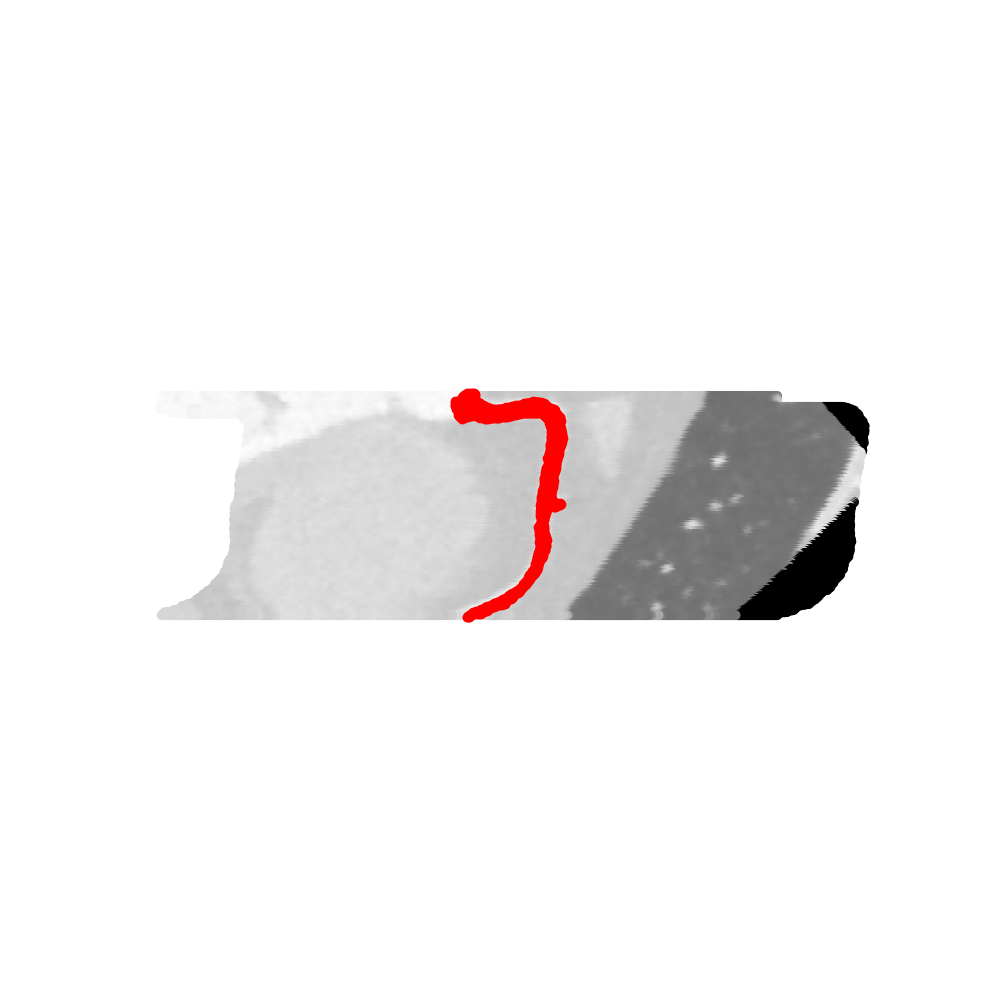

In [73]:
%matplotlib widget
def calculate_view_angle(plane_normal):
    normal = np.array(plane_normal) / np.linalg.norm(plane_normal)
    azimuth = np.degrees(np.arctan2(normal[1], normal[0]))
    elevation = np.degrees(np.arcsin(normal[2]))
    return elevation, azimuth

def project_to_2d(points, normal):
    normal = normal / np.linalg.norm(normal)
    u = np.cross(normal, [1, 0, 0])
    if np.linalg.norm(u) < 1e-6:
        u = np.cross(normal, [0, 1, 0])
    v = np.cross(normal, u)
    
    u, v = u / np.linalg.norm(u), v / np.linalg.norm(v)
    return np.array([[np.dot(p, u), np.dot(p, v)] for p in points])

def calc_rot_matrix(points, custom_angle: int = 0):
    first_point, last_point = points[0], points[-1]
    angle = np.arctan2(last_point[1] - first_point[1], last_point[0] - first_point[0])
    if custom_angle != 0:
        angle += custom_angle*np.pi/180
    rotation_matrix = np.array([
        [np.cos(-angle), -np.sin(-angle)],
        [np.sin(-angle), np.cos(-angle)]
    ])
    return rotation_matrix
    
def apply_rotation(points, matrix: np.ndarray, center = None):
    if center is None:
        center = points[0]
    return (points - center) @ matrix.T

def get_values(image: np.ndarray, coords: np.ndarray):
    x_size, y_size, z_size = image.shape
    coords = np.clip(coords, [0, 0, 0], [x_size-1, y_size-1, z_size-1]).astype(int)
    result = image[coords[:, 0], coords[:, 1], coords[:, 2]]
    return result

plt.style.use('grayscale')
fig = plt.figure(figsize=(10, 10), frameon=False)
ax = fig.add_subplot()

for i in tqdm(range(rotations), ncols=100):
    ax.cla()
    rotated_plane = rotate_vector(flow_vector, plane_normal, i*rotation_degrees)
    
    first_to_last_vector = original_skeleton[-1] - original_skeleton[0]
    perpendicular_vector = np.cross(first_to_last_vector, rotated_plane)
    perpendicular_vector /= np.linalg.norm(perpendicular_vector)
    

    y_step = 1
    steps = np.arange(-200, 201, y_step)
    steps = np.array([(s*perpendicular_vector) for s in steps])
    new_image = np.zeros((len(steps), len(original_skeleton)))

    point_array = []
    color_array = []
    for point in original_skeleton:
        point_coords = steps + point
        point_values = get_values(normalized_image, steps + point).astype(int)

        projected_point_coords = project_to_2d(point_coords, rotated_plane)
        colors = [p for p in point_values]

        point_array.extend(list(projected_point_coords))
        color_array.extend(colors)

    draw_mask = True

    projected_original_skeleton = project_to_2d(original_skeleton, rotated_plane)
    original_pivot = copy.deepcopy(projected_original_skeleton[0])
    projected_original_skeleton -= original_pivot
    rotation_matrix = calc_rot_matrix(projected_original_skeleton, custom_angle=90)
    point_array = apply_rotation(point_array, rotation_matrix, center=original_pivot)
    ax.scatter(*zip(*point_array), c=color_array)

    if draw_mask:
        projected_branch = project_to_2d(branch, rotated_plane)
        projected_branch = apply_rotation(projected_branch, rotation_matrix, center=original_pivot)
        ax.scatter(*zip(*projected_branch), c='r')
    
    ax.set_facecolor('black')
    ax.set_aspect('equal')
    ax.axis('off')

    plt.savefig(f"{output_folder}/mpr{i*rotation_degrees}deg.png", dpi=300, pad_inches=0)

In [ ]:
%matplotlib widget
def calculate_view_angle(plane_normal):
    normal = np.array(plane_normal) / np.linalg.norm(plane_normal)
    azimuth = np.degrees(np.arctan2(normal[1], normal[0]))
    elevation = np.degrees(np.arcsin(normal[2]))
    return elevation, azimuth

for i in range(rotations):
    fig = plt.figure(figsize=(5, 5), dpi=300)
    ax = fig.add_subplot(projection='3d')

    rotated_plane = rotate_vector(flow_vector, plane_normal, i*rotation_degrees)
    draw_surface(ax, rotated_plane)
    # draw_wireframe(ax, rotated_plane)
    
    projected_points = [project_point(rotated_plane, p) for p in skeleton]
    print(projected_points)
    
    for point in skeleton:
        # ax.scatter(*point)
        ax.scatter(*project_point(rotated_plane, point), c='w', s=1)
    
    center = project_point(rotated_plane, middle_point)
    elevation, azimuth = calculate_view_angle(rotated_plane)
    ax.view_init(elev=elevation, azim=azimuth)
        
    ax.set_aspect('equal')
    plt.show()